## Advanced Lane Finding Project
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 1. Camera calibration using chessboard images

camera_cal/calibration5.jpg , ret is False
camera_cal/calibration4.jpg , ret is False
camera_cal/calibration1.jpg , ret is False


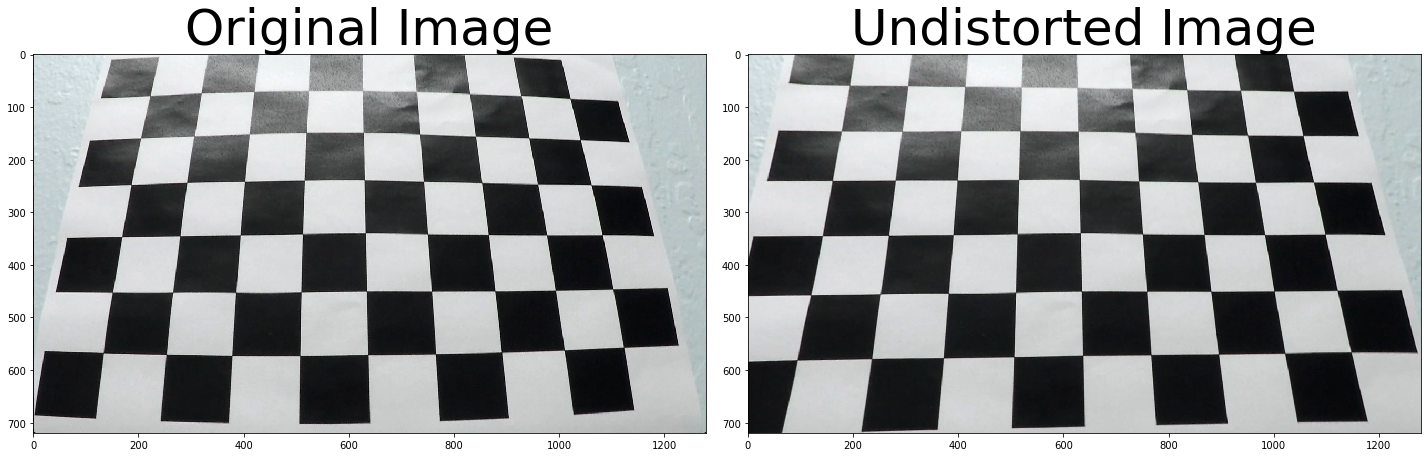

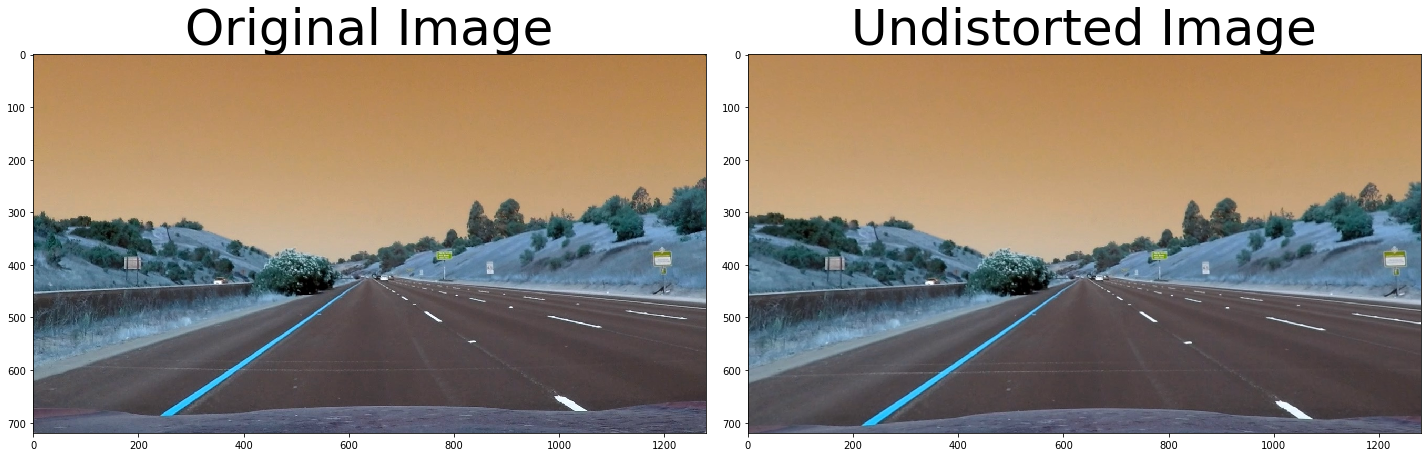

In [85]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
#%matplotlib qt
%matplotlib inline


def calibrate_camera(calibration_images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for fname in calibration_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #plt.imshow(img)
            cv2.waitKey(500)
        else:
            print(fname, ", ret is False")
    #calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist, rvecs, tvecs

#Undistort the camera calibration images, output the original and undistorted image side by side
def undistort_images(distorted_images, mtx, dist):
    for fname in distorted_images:
        img = cv2.imread(fname)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        filename_w_ext = os.path.basename(fname)
        filename, file_extension = os.path.splitext(filename_w_ext)
        cv2.imwrite("output_images/undistort_" + filename + file_extension, dst)
    #print("Undistortion complete")

    
#Undistort a test image, plot & output original image and undistorted image side by side
def plot_orig_undist(orig_name, output_name):
    orig = cv2.imread(orig_name)
    undist = cv2.undistort(orig, mtx, dist, None, mtx)
    f1, (ax11, ax12) = plt.subplots(1, 2, figsize=(20, 7))
    f1.tight_layout()
    ax11.imshow(orig)
    ax11.set_title('Original Image', fontsize=50)
    ax12.imshow(undist)
    ax12.set_title('Undistorted Image', fontsize=50) 
    diff = cv2.hconcat([orig, undist])
    cv2.imwrite("output_images/undist_diff_"+output_name, diff)
    
    

# Make a list of calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')
mtx, dist, rvecs, tvecs = calibrate_camera(cal_images)

#plot orig vs. undistort comparison
plot_orig_undist('camera_cal/calibration3.jpg', 'cal3.jpg')
plot_orig_undist('test_images/straight_lines1.jpg', 'straight_lines1.jpg')

undistort_images(cal_images, mtx, dist)









## 2. Apply Color And Gradient Transform

In [92]:

#Use color transforms, gradients, etc., to create a thresholded binary image.

# X Sobel and Y Sobel Threshold
def abs_sobel_threshold(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    
    if orient == 'x':
        sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        abs_sobel = np.absolute(sobelx)
    if orient == 'y':
        sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        abs_sobel = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

# Magitude threshold
def mag_threshold(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

# Directional threshold
def dir_threshold(image, sobel_kernel=15, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, 15)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, 15)
    dir_sobel = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    return dir_binary

# HLS channels 
def HLS_Threshold (img, h_thresh=(15, 100), l_thresh=(100,170), s_thresh=(170,255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel > h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    return h_binary, l_binary, s_binary

# Combination threshold = X, Y, Magnitude and Directional thresholds
def Combined_Threshold (img, x_thresh=(20,100), y_thresh=(20,100), mag_thresh=(30,100), dir_thresh=(0.7, 1.3), sobel_kernel=3):
    # Apply each of the thresholding functions
    gradx = abs_sobel_threshold(img, 'x', sobel_kernel, x_thresh)
    grady = abs_sobel_threshold(img, 'y', sobel_kernel, y_thresh)
    
    dir_binary = dir_threshold(img, sobel_kernel, dir_thresh)
    mag_binary = mag_threshold(img, sobel_kernel, mag_thresh)
    #mag_binary = mag_threshold(img, 3, (30,70))

    comb_binary = np.zeros_like(dir_binary)
    comb_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1      
    
    return comb_binary


# S-Channel + Combination threshold on input image
def transform_image(undistort_img):
    h_th, l_th, s_th = HLS_Threshold (undistort_img, (15, 100), (100,170), (150,255))
    c_binary = Combined_Threshold (undistort_img, (20,100), (20,100), (30,100), (0.7, 1.3), 3)
    combo_binary = np.zeros_like(c_binary)
    combo_binary[(s_th == 1)|(c_binary == 1)] = 1
    #cv2.imwrite("output_images/output_"+file, combo_binary*255) 
    return combo_binary
    
    
# Transform All test images
def transform_images(image_files_dir):
    files = os.listdir(image_files_dir)
    for file in files:
        image = mpimg.imread(image_files_dir+file)
        undistort_img = cv2.undistort(image, mtx, dist, None, mtx)
        tf_binary = transform_image(undistort_img)
        cv2.imwrite("output_images/binary_"+file, tf_binary*255)    
    
    
# Read in Test Images, Undistort and then Apply Color/Gradient Transform
def Test_Combined_Thresholds (img_name):
    img = mpimg.imread(img_name)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    x_thresh=(20,100)
    y_thresh=(20,100)
    mag_thresh=(30,100)
    dir_thresh=(0.9, 1.1)
    H_thresh = (15, 100)
    L_thresh = (100,170)
    S_thresh = (170,255)
    sobel_kernel=15
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_threshold(img, 'x', sobel_kernel, x_thresh)
    grady = abs_sobel_threshold(img, 'y', sobel_kernel, y_thresh)
    
    gradx_y = np.zeros_like(gradx)
    gradx_y[(gradx == 1) & (grady == 1)] = 1
    
    dir_binary = dir_threshold(img, sobel_kernel, dir_thresh)
    mag_binary = mag_threshold(img, sobel_kernel, mag_thresh)

    comb_binary = np.zeros_like(dir_binary)
    comb_binary[(gradx_y == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1      
    
    h_th, l_th, s_th = HLS_Threshold (img, H_thresh, L_thresh, S_thresh)

    s_comb = np.zeros_like(dir_binary)
    s_comb[(s_th == 1)|(comb_binary == 1)] = 1
    
    s_comb_warp_image = warp_image(s_comb)
    
    f2, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(40, 14))
    f2.tight_layout()
    ax1.imshow(gradx)
    ax1.set_title('X grad', fontsize=50)
    ax2.imshow(grady)
    ax2.set_title('Y grad', fontsize=50)
    ax3.imshow(gradx_y)
    ax3.set_title('X-Y grad', fontsize=50)
    ax4.imshow(dir_binary)
    ax4.set_title('dir binary', fontsize=50)
    ax5.imshow(mag_binary)
    ax5.set_title('mag_binary', fontsize=25)
    ax6.imshow(comb_binary)
    ax6.set_title('combined threshold', fontsize=25)
    ax7.imshow(s_th)
    ax7.set_title('S Channel', fontsize=50)
    ax8.imshow(s_comb)
    ax8.set_title('S + Combined', fontsize=25)
    ax9.imshow(s_comb_warp_image)
    ax9.set_title('S+C Warp', fontsize=25)
    return comb_binary


transform_images("test_images/")

    

    
    

## 3. Warp Image -  Bird's Eye View



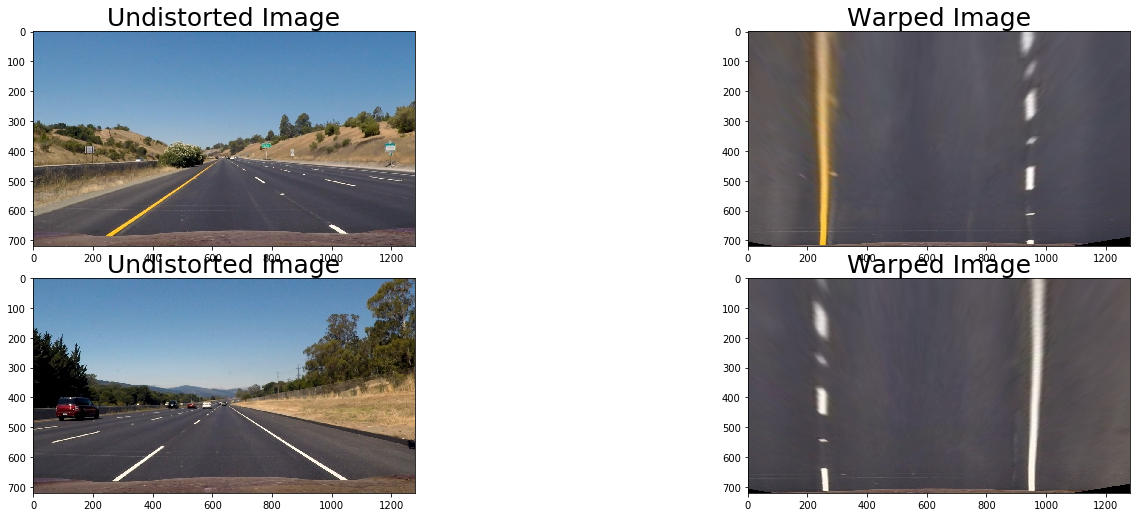

In [91]:

# Compute perspective transform matrices M and Minv 
def perspective_matrices(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

# The warp function - front view to bird's eye view
def warp_image(img):
    warp = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warp

    
# A Helper function - combine undistort and warp
def undistortAndWarp(img, mtx, dist, M, flags=cv2.INTER_LINEAR):
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    warp = cv2.warpPerspective(undistort, M, (undistort.shape[1], undistort.shape[0]), flags=cv2.INTER_LINEAR)
    return warp



# Test warp function on the two straight_line test images
def test_straightline():
    img1 = mpimg.imread('test_images/straight_lines1.jpg')
    img2 = mpimg.imread('test_images/straight_lines2.jpg')
    warped1 = undistortAndWarp(img1, mtx, dist, M, cv2.INTER_LINEAR)
    warped2 = undistortAndWarp(img2, mtx, dist, M, cv2.INTER_LINEAR)

    #plot
    f3, ((ax31, ax32),(ax33, ax34)) = plt.subplots(2, 2, figsize=(20, 7))
    f3.tight_layout()
    ax31.imshow(img1)
    ax31.set_title('Undistorted Image', fontsize=25)
    ax32.imshow(warped1)
    ax32.set_title('Warped Image', fontsize=25)
    ax33.imshow(img2)
    ax33.set_title('Undistorted Image', fontsize=25)
    ax34.imshow(warped2)
    ax34.set_title('Warped Image', fontsize=25)

# To Warp all the test images and save to output/ directory
def warp_images(filepath):
    files = os.listdir(filepath)
    for file in files:
        if file [0:6] == "binary":
            image = mpimg.imread(filepath + file)
            warp = warp_image(image)
            cv2.imwrite("output_images/warped_" + file, warp*255)

            


#Expanded Width - have more space on the right side so to improve the right curves
src = np.float32([[582-5,450],[698+5,450],[1283,720], [12,720]])
dst = np.float32([[100,0], [1085,0], [1085,720], [100,720]])

#Example points:
#src = np.float32([[585,460],[695,460],[1127,720], [203,720]])
#dst = np.float32([[320,0], [960,0], [960,720], [320,720]])

#Perspective transform matrices M and Minv, as global variables
M, Minv = perspective_matrices(src, dst)

test_straightline()

warp_images("output_images/")


#Read in Binary Files, Undistort and then Apply Color/Gradient Transform
   
    


## 4. Detect lane pixels, fit polynomials to find the lane boundary.

In [71]:


# Global Variables for pixel to meter conversion
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


# Histogram to find starting points for left and white lanes
# Return starting points of left lane and right lane
def histogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base

# Sliding window to search for lanes
# Return raw lane points for left lane and right lane
def findLanePixelSlidingWindow(img):
    leftx_base, rightx_base = histogram(img)
    out_img = np.dstack((img, img, img))
    # HYPERPARAMETERS
    nwindows = 9 
    margin = 100 
    minpix = 80
    
    window_height = np.int(img.shape[0]//nwindows)
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
       
        win_xleft_low = int(leftx_current - margin) 
        win_xleft_high = int(leftx_current + margin)
        win_xright_low = int(rightx_current - margin)  
        win_xright_high = int(rightx_current + margin)  

        #draw windows
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2)        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]        
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    return leftx, lefty, rightx, righty, out_img       
        
    
# Perform sliding window search then fit polynomial
# Return polynomials and lane points
def findLanesFitPoly(img):
    leftx, lefty, rightx, righty, out_img = findLanePixelSlidingWindow(img)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization - Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    lane_img = np.zeros_like(out_img)
    left_line = np.column_stack((left_fitx, ploty))
    right_line = np.column_stack((right_fitx, ploty))
    cv2.polylines(lane_img, np.int_([left_line]), False, (0,255,255), thickness=2)
    cv2.polylines(lane_img, np.int_([right_line]), False, (0,255,255), thickness=2)
    comb_img = cv2.addWeighted(out_img, 1, lane_img, 1, 0)
    #return left_fit, right_fit, comb_img
    return left_fit, right_fit, comb_img, left_fitx, right_fitx, ploty 


# Fit polynomial based on found lane pixels, 
# Return lane points in pixels
def fitPoly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    return left_fit, right_fit, left_fitx, right_fitx, ploty

    
# Search around polynomial from previous image to find lane points in new image and fit new polynomials
# Return new polynomials and lane points in pixels
def searchAroundPoly(img, left_fit, right_fit):
    # HYPERPARAMETER
    margin = 100
    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = (nonzerox > (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] + margin ))
    right_lane_inds = (nonzerox > (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fitPoly(img.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    lane_img = np.zeros_like(out_img)   
    left_line = np.column_stack((left_fitx, ploty))
    right_line = np.column_stack((right_fitx, ploty))
    
    cv2.polylines(lane_img, np.int_([left_line]), False, (0,255,255), thickness=2)
    cv2.polylines(lane_img, np.int_([right_line]), False, (0,255,255), thickness=2)
    
    out_img = cv2.addWeighted(out_img, 1, lane_img, 1, 0)    
    
    ## End visualization steps ##
    
    return left_fit, right_fit, out_img, left_fitx, right_fitx, ploty    



def find_lanes_in_images (filedir):
    files = os.listdir(filedir)
    fig_index = 1

    for file in files:
        if file [0:6] == "warped":
            image = mpimg.imread(filedir + file)
            l_fit, r_fit, out_img, left_fitx, right_fitx, ploty = findLanesFitPoly(image)
            #l_fit, r_fit, out_img, left_fitx, right_fitx, ploty = searchAroundPoly(image, l_fit, r_fit)
            cv2.imwrite("output_images/lane_" + file, out_img)
    print("find_lanes_in_images completed")
    
    
# Test an example
#warpped1 = mpimg.imread('output_images/warpped_output_straight_lines2.jpg')
#warpped2 = mpimg.imread('output_images/warpped_output_straight_lines2.jpg')
#l_fit, r_fit, out_img_, left_fitx_, right_fitx_, ploty_ = findLanesFitPoly(warpped1)
#l_fit, r_fit, out_img2 = searchAroundPoly(warpped1, l_fit, r_fit)
#cv2.imwrite("output_images/lanes_test.jpg", out_img2) 
#plt.imshow(out_img2)


#Find Lanes on all warpped test images and save to output_images/ directory
find_lanes_in_images("output_images/")





output_images/lanes_ fileoutput
output_images/lanes_ fileoutput
output_images/lanes_ fileoutput
output_images/lanes_ fileoutput
output_images/lanes_ fileoutput
output_images/lanes_ fileoutput
output_images/lanes_ fileoutput
output_images/lanes_ fileoutput
find_lanes_in_images completed


## 6. Compute curvature and vehicle position

In [139]:

# Compute curverad for single lane with polyfit parameters
def measure_curvature_single_lane(y_eval, poly_fit):
    y_eval = y_eval*ym_per_pix
    kA = xm_per_pix/(ym_per_pix**2)
    kB = xm_per_pix/ym_per_pix
    curverad = (1 + (2*poly_fit[0]*kA*y_eval + poly_fit[1]*kB)**2)**(3/2)/np.absolute(2*poly_fit[0]*kA)  
    curverad = round(curverad, 2)
    return curverad

# Compute curverad for both lanes
def measure_curvature(y_eval, left_fit, right_fit):
    left_curverad = measure_curvature_single_lane(y_eval, left_fit)
    right_curverad = measure_curvature_single_lane(y_eval, right_fit)
    return left_curverad, right_curverad

# Take in left x and right x coordinates, compute vehicle offset from ego lane center
def vehicle_location_offset(img_width, left_fitx, right_fitx):
    return vehicle_location_offset_xbase(img_width, left_fitx[-1], right_fitx[-1])

def vehicle_location_offset_xbase(img_width, left_x_base, right_x_base):
    lane_centerx = (left_x_base + right_x_base)/2
    offset = (img_width/2 - lane_centerx)*xm_per_pix
    offset = round(offset, 2)
    return offset
    
  
# Compute lane width 
def lane_width(left_fitx, right_fitx):
    lane_width_top = round((right_fitx[0] - left_fitx[0])*xm_per_pix,2)
    lane_width_bottom = round((right_fitx[-1] - left_fitx[-1])*xm_per_pix,2)

    #print("at y = 0, lane width is ", (lane_width_top), " m")
    #print("at y = 719, lane width is ", (lane_width_bottom), " m")
    
    return lane_width_top, lane_width_bottom
    

# Test curverad on one image
def get_curvature(filename):
    warped = mpimg.imread(filename)
    left_fit, right_fit, comb_img, left_fitx, right_fitx, ploty = findLanesFitPoly(warped)
    #print("filename", filename)
    #print("left_fit", left_fit)
    #print("right_fit", right_fit)
    left_curverad, right_curverad = measure_curvature((warped.shape[0] - 1), left_fit, right_fit)
    #print(left_curverad, 'm', right_curverad, 'm')
    lane_width(left_fitx, right_fitx)
    return left_curverad, right_curverad    
    
# Test vehicle offset on one image
def get_vehicle_offset(filename):
    warped = mpimg.imread(filename)
    left_fit, right_fit, img, left_fitx, right_fitx, ploty = findLanesFitPoly(warped)
    offset = vehicle_location_offset(img.shape[1], left_fitx, right_fitx)
    #print("vehicle offset is ", offset)
    return offset


# Test pipeline from test images and derive curvature and vehicle offset
def get_curvature_offset_src_image(orig_filename):    
    orig_img = mpimg.imread(orig_filename)
    undistort_img = cv2.undistort(orig_img, mtx, dist, None, mtx)
    tf_img = transform_image(undistort_img)
    warped = warp_image(tf_img)
    left_fit, right_fit, comb_img, left_fitx, right_fitx, ploty = findLanesFitPoly(warped)
    left_curverad, right_curverad = measure_curvature((warped.shape[0] - 1), left_fit, right_fit)
    #print(left_curverad, 'm', right_curverad, 'm')
    offset = vehicle_location_offset(orig_img.shape[1], left_fitx, right_fitx)
    #print("vehicle offset is ", offset, 'm')
    lane_width(left_fitx, right_fitx)    
    return left_curverad, right_curverad, offset


# Test curvature and vehicle offset from warped images output from previous pipeline
def get_curvature_offset_warped_images():
    files = os.listdir("output_images/")
    fig_index = 1

    for file in files:
        if file [0:6] == "warped":
            get_curvature(filedir + file)
            get_vehicle_offset(filedir + file)
        
    
# Test curvature and vehicle offset from source test images directly
def get_curvature_vehicle_offset_src_images():
    xfiles = os.listdir("test_images/")
    for f in xfiles:
        get_curvature_offset_src_image("test_images/" + f)
    
                    
get_curvature_vehicle_offset_src_images()
#get_curvature_offset_warped_images()
                       


## 6. Warp the detected lane boundaries back onto the original image

draw_curverad_offset input parameters: left_curverad is 19308.31  right_curverad is 1442.02
draw_curverad_offset input parameters: left_curverad is 952.13  right_curverad is 165.25
draw_curverad_offset input parameters: left_curverad is 214.59  right_curverad is 442.72
draw_curverad_offset input parameters: left_curverad is 764.82  right_curverad is 305.03
draw_curverad_offset input parameters: left_curverad is 711.07  right_curverad is 737.72
draw_curverad_offset input parameters: left_curverad is 420.68  right_curverad is 386.8
draw_curverad_offset input parameters: left_curverad is 4622.94  right_curverad is 2407.97
draw_curverad_offset input parameters: left_curverad is 10007.87  right_curverad is 2117.64


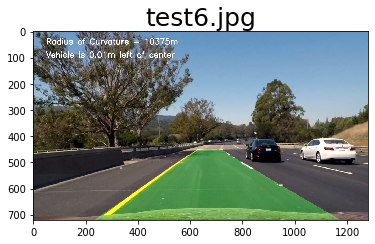

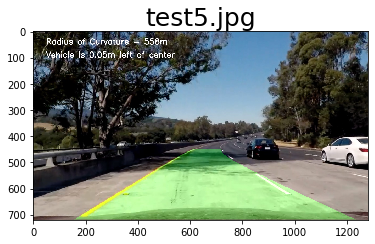

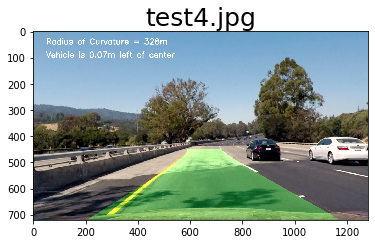

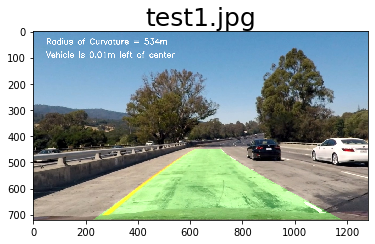

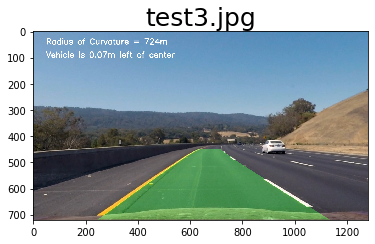

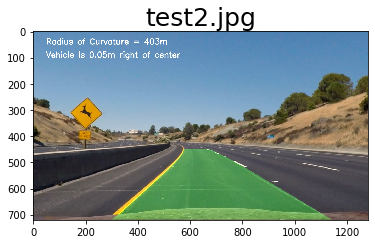

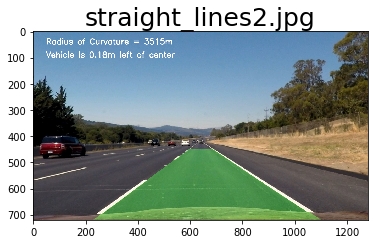

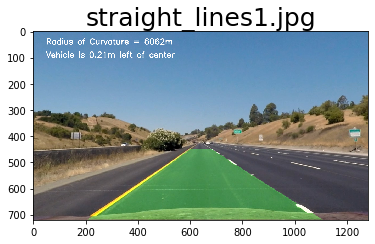

In [140]:


# Inverse warp - bird's eyeview to front view
def inv_warp_image (undist_img, warp_img, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    return result

# Helper function - apply inv-warp on two files by their names
def inv_warp_file (orig_name, warp_name):
    warped = mpimg.imread(warp_name)
    orig = mpimg.imread(orig_name)
    undist = cv2.undistort(orig, mtx, dist, None, mtx)
    left_fit, right_fit, out_img, left_fitx, right_fitx, ploty = findLanesFitPoly(warped)
    return inv_warp_image(undist, warped, left_fitx, right_fitx, ploty)

# Draw curvarads and vehicle offset onto image
def draw_curverad_offset (img, left_curverad, right_curverad, offset):
    ave_curverad = np.int((left_curverad + right_curverad)/ 2)
    abs_offset = round(np.absolute(offset),2)
    #draw on image
    curverad_text = 'Radius of Curvature = ' + str(ave_curverad) + 'm'
    print("draw_curverad_offset input parameters: left_curverad is", left_curverad, " right_curverad is", right_curverad)
    
    #curverad_text = 'Radius of Curvature Left: ' + str(left_curverad) + 'm  Right: ' + str(right_curverad) + 'm'
    if offset > 0: 
        offset_text = "Vehicle is " + str(abs_offset) + "m left of center"
    elif offset < 0: 
        offset_text = "Vehicle is " + str(abs_offset) + "m right of center"
    else: 
        offset_text = "Vehicle is at the center"
    pos_curverad = (50,50)
    pos_offset = (50,100)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    thickness = 2
    color = (255, 255, 255)
    img = cv2.putText(img, curverad_text, pos_curverad, font, fontScale, color, thickness, cv2.LINE_AA)
    img = cv2.putText(img, offset_text, pos_offset, font, fontScale, color, thickness, cv2.LINE_AA)
    return img
  
    
# Test inv warp on images
def inv_warp_images (orig_img_dir, warped_img_dir):
    orig_files = os.listdir(orig_img_dir)
    warped_files = os.listdir(warped_img_dir)
    
    figure_index = 1
    for file_name in orig_files:
        warped_img_name = (warped_img_dir + "warped_binary_" + file_name)
        orig_img_name = (orig_img_dir + file_name)
        unwarped = inv_warp_file(orig_img_name, warped_img_name)
        left_curverad, right_curverad = get_curvature(warped_img_name)
        offset = get_vehicle_offset(warped_img_name)
        unwarped = draw_curverad_offset(unwarped, left_curverad, right_curverad, offset)
        f = plt.figure()
        plt.title(file_name, fontsize=25)
        plt.imshow(unwarped)
        r,g,b = cv2.split(unwarped)
        unwarped = cv2.merge((b,g,r))
        cv2.imwrite("output_images/remark_"+file_name, unwarped)
        
      
inv_warp_images('test_images/', 'output_images/')


## 7. Test pipeline on video

In [152]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML



# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = 0  
        # x values of the last n fits of the line
        self.recent_polyfitted = []
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 

        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None      
        
    def update_line(self, new_fit, new_x, ploty, new_curvarad):
        if (new_fit == [])| (new_x == []):
            return False
        self.detected = N_buffer
        
        self.update_fit_x(new_fit, new_x)
        
    
    #for now, no averaging
        
    
    #update recent_xfitted, bestx, best_fit, current_fit, line_base_pos, diffs, 
    def update_fit_x(self, new_fit, new_x):
        #maintain buffer size equal to N_buffer
        if(len(self.recent_xfitted) == N_buffer):
            self.recent_xfitted.pop(0)
        newx = new_x
        self.recent_xfitted.append(newx)
        #print("xfitted.append: new_x", newx)
        if(len(self.recent_polyfitted) == N_buffer):
            self.recent_polyfitted.pop(0)
        self.recent_polyfitted.append(new_fit)
        #print("polyfitted.append: new_fit", new_fit)
        
        
        #update best_fit
        ave_fit = np.array([0.0,0.0,0.0], float) 
        for fit_i in self.recent_polyfitted:
            ave_fit = np.add(fit_i, ave_fit)
        ave_fit = ave_fit/(len(self.recent_polyfitted))
        self.set_best_fit(ave_fit)
        #print("update_fit_x: new fit is", self.get_best_fit())
        
        #update best_x
        ave_x = np.zeros_like(new_x)
        for x_i in self.recent_xfitted:
            ave_x = np.add(ave_x, x_i)
        ave_x = ave_x/(len(self.recent_xfitted))
        self.set_bestx(ave_x)
        #print("update_fit_x: new x is", self.get_bestx())      
        
        #use new fit to compute new curvature
        curverad = measure_curvature_single_lane(719, self.get_best_fit())
        self.set_curvature(curverad)
    
        
        
    #update curvature    
    def set_curvature(self, new_curvarad):
        self.radius_of_curvature = new_curvarad
        return self.radius_of_curvature
        
    def get_curvature(self):
        return self.radius_of_curvature
    
    def get_base_pos_x(self):
        return self.line_base_pos
    
    def get_bestx(self):
        return self.bestx
    
    def get_best_fit(self):
        return self.best_fit
    
    def get_detected(self):
        return self.detected
    
    def set_detected(self, value):
        if(value > 0):
            self.detected = value
        #when goes to zero, clear all records    
        else:
            self.detected = 0
            self.recent_polyfitted.clear()
            self.recent_xfitted.clear()
            
    def set_best_fit(self, value):
        if value.shape[0] != 3:
            print("set_best_fit: wrong input") 
        self.best_fit = value
        
    def set_bestx(self, fit_x):
        self.bestx = fit_x


# Check if curverads and lane widths are reasonable
def check_lanes(left_curverad, right_curverad, left_fitx, right_fitx):
    min_rad = min(left_curverad, right_curverad)
    max_rad = max(left_curverad, right_curverad)
    
    #1. all curvatures should be larger than 100m
    if (min_rad < 100): 
        print("sanity check failed - min_rad < 100")
        return False
    
    #2. the curvature difference between two lanes should be less than 3X if one is within 1km.
    if min_rad < 1000:
        if (max_rad > min_rad*3):
            print("sanity check failed - min_rad < 100 & max_rad > min_rad*3")
            return False  
        
    #3. the distance between two lanes should be consistent
    if (left_fitx[0] >= right_fitx[0]):
        print("sanity check failed - left_fitx[0] >= right_fitx[0]")
        return False
    
    #4. check lane width
    width_top, width_bottom = lane_width(left_fitx, right_fitx)
    if ((width_top < lane_width_th[0]) | (width_top > lane_width_th[1]) | (width_bottom < lane_width_th[0]) | (width_bottom > lane_width_th[1])):
        print("sanity check failed - width out of bound")
        return False
    if (abs(width_top - width_bottom) > 0.7):
        print("sanity check failed - width inconsistent")
        return False
    
    return True


# No good lane found, decrease detected counter by 1
def no_good_fit():
    left_lane.set_detected(left_lane.get_detected() - 1)
    right_lane.set_detected(right_lane.get_detected() - 1)
    

# Search for lane points and perform polynomial fit
def search_lanes(img):
    if (left_lane.get_detected() > 0) & (right_lane.get_detected() > 0):
        #if detected, perform search around previously fitted lines
        print("search prior")
        print("left lane best fit is", left_lane.get_best_fit())
        print("right lane best fit is", right_lane.get_best_fit())
        left_fit, right_fit, out_img, left_fitx, right_fitx, ploty = searchAroundPoly(img, left_lane.get_best_fit(), right_lane.get_best_fit())
    else:
        #if not detected in last frame, perform histogram and sliding window
        print("histogram and sliding window")
        left_fit, right_fit, out_img, left_fitx, right_fitx, ploty = findLanesFitPoly(img)
        
    return left_fit, right_fit, out_img, left_fitx, right_fitx, ploty
    
    
# Update left lane and right lane after finding good polyfit    
def update_lanes(left_fit, left_fitx, right_fit, right_fitx, ploty, left_curverad, right_curverad):
    left_lane.update_line(left_fit, left_fitx, ploty, left_curverad)
    right_lane.update_line(right_fit, right_fitx, ploty, right_curverad)


# Find lanes, compute curverads and vehicle lane offset
def find_lanes_curvature_offset(img):
    left_fit, right_fit, out_img, left_fitx, right_fitx, ploty = search_lanes(img)
    left_curverad, right_curverad = measure_curvature(ploty[-1], left_fit, right_fit)
    check_status = check_lanes(left_curverad, right_curverad, left_fitx, right_fitx)
    #pass sanity check, update lanes, otherwise fall back
    if(check_status): 
        update_lanes(left_fit, left_fitx, right_fit, right_fitx, ploty, left_curverad, right_curverad)
        
    else:
        no_good_fit()

    offset = vehicle_location_offset(img.shape[1], left_lane.get_bestx(), right_lane.get_bestx())
    lc = left_lane.get_curvature()
    rc = right_lane.get_curvature()
    print("offset is ", offset, "m, ", "left lane curvature is ", lc, "right lane curvature is ", rc)
    return left_lane.get_bestx(), right_lane.get_bestx(), ploty, offset, lc, rc
    
# Process each frame    
def process_image(img):
    undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
    #threshold binary
    tf_img = transform_image(undistort_img)
    #warp
    warp_img = cv2.warpPerspective(tf_img, M, (tf_img.shape[1], tf_img.shape[0]), flags=cv2.INTER_LINEAR)
    
    #find lanes
    left_fitx, right_fitx, ploty, offset, l_curverad, r_curverad = find_lanes_curvature_offset(warp_img)
    inv_warp = inv_warp2 (undistort_img, warp_img, left_fitx, right_fitx, ploty)
    inv_warp = draw_curverad_offset(inv_warp, left_lane.get_curvature(), right_lane.get_curvature(), offset)    
    return inv_warp

# Test process_image() with_plots
def test_process_image(filename):
    img = mpimg.imread(filename)
    #undistort
    undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
    #threshold binary
    tf_img = transform_image(undistort_img)
    #warp
    warp_img = cv2.warpPerspective(tf_img, M, (tf_img.shape[1], tf_img.shape[0]), flags=cv2.INTER_LINEAR)
    
    #find lanes
    left_fitx, right_fitx, ploty, offset, l_curverad, r_curverad = find_lanes_curvature_offset(warp_img)
    inv_warp = inv_warp_image(undistort_img, warp_img, left_fitx, right_fitx, ploty)
    inv_warp = draw_curverad_offset(inv_warp, left_lane.get_curvature(), right_lane.get_curvature(), offset)
    
    #warp back onto the video
    f = plt.figure()
    plt.title(filename, fontsize=25)
    plt.imshow(inv_warp)
    
    return inv_warp
    

# Test on project Video
video_output = 'output_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#video_output = 'output_challenge_video.mp4'
#clip1 = VideoFileClip("challenge_video.mp4")


#instantiate left lane and right lane objects
left_lane = Line()
right_lane = Line()
N_buffer = 7
lane_width_th = [3.3, 4.4]

output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(video_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

histogram and sliding window
offset is  -0.16 m,  left lane curvature is  347.25 right lane curvature is  759.14
draw_curverad_offset input parameters: left_curverad is 347.25  right_curverad is 759.14
Moviepy - Building video output_project_video.mp4.
Moviepy - Writing video output_project_video.mp4



t:   0%|          | 2/1260 [00:00<02:35,  8.09it/s, now=None]

search prior
left lane best fit is [-4.72942431e-04  6.56971625e-01  7.82659666e+01]
right lane best fit is [-2.16442490e-04  4.56310152e-01  8.17536155e+02]
offset is  -0.16 m,  left lane curvature is  355.22 right lane curvature is  776.78
draw_curverad_offset input parameters: left_curverad is 355.22  right_curverad is 776.78


t:   0%|          | 3/1260 [00:00<03:28,  6.04it/s, now=None]

search prior
left lane best fit is [-4.62332430e-04  6.49216305e-01  7.90090377e+01]
right lane best fit is [-2.11533307e-04  4.53915480e-01  8.17452284e+02]
offset is  -0.16 m,  left lane curvature is  363.9 right lane curvature is  725.81
draw_curverad_offset input parameters: left_curverad is 363.9  right_curverad is 725.81


t:   0%|          | 4/1260 [00:00<03:54,  5.36it/s, now=None]

search prior
left lane best fit is [-4.51299192e-04  6.42657020e-01  7.97216603e+01]
right lane best fit is [-2.26378419e-04  4.67615035e-01  8.13034166e+02]
offset is  -0.16 m,  left lane curvature is  368.37 right lane curvature is  677.4
draw_curverad_offset input parameters: left_curverad is 368.37  right_curverad is 677.4


t:   0%|          | 5/1260 [00:01<04:23,  4.76it/s, now=None]

search prior
left lane best fit is [-4.45817834e-04  6.39102503e-01  8.02107033e+01]
right lane best fit is [-2.42544967e-04  4.85157125e-01  8.06939673e+02]
offset is  -0.15 m,  left lane curvature is  367.39 right lane curvature is  620.38
draw_curverad_offset input parameters: left_curverad is 367.39  right_curverad is 620.38


t:   0%|          | 6/1260 [00:01<04:28,  4.67it/s, now=None]

search prior
left lane best fit is [-4.47010116e-04  6.41864552e-01  7.94384414e+01]
right lane best fit is [-2.64822546e-04  5.08330572e-01  7.99936629e+02]
offset is  -0.15 m,  left lane curvature is  372.32 right lane curvature is  584.89
draw_curverad_offset input parameters: left_curverad is 372.32  right_curverad is 584.89


t:   1%|          | 7/1260 [00:01<04:46,  4.38it/s, now=None]

search prior
left lane best fit is [-4.41091896e-04  6.39498774e-01  7.92617495e+01]
right lane best fit is [-2.80881748e-04  5.25074555e-01  7.94892260e+02]
offset is  -0.15 m,  left lane curvature is  374.45 right lane curvature is  545.14
draw_curverad_offset input parameters: left_curverad is 374.45  right_curverad is 545.14


t:   1%|          | 8/1260 [00:01<04:52,  4.28it/s, now=None]

search prior
left lane best fit is [-4.38582750e-04  6.39938317e-01  7.86255064e+01]
right lane best fit is [-3.01349838e-04  5.46897577e-01  7.88263305e+02]
offset is  -0.15 m,  left lane curvature is  380.5 right lane curvature is  498.69
draw_curverad_offset input parameters: left_curverad is 380.5  right_curverad is 498.69


t:   1%|          | 9/1260 [00:01<04:46,  4.37it/s, now=None]

search prior
left lane best fit is [-4.31606189e-04  6.38892435e-01  7.75295244e+01]
right lane best fit is [-3.29401175e-04  5.75807251e-01  7.79567209e+02]
offset is  -0.15 m,  left lane curvature is  389.15 right lane curvature is  464.56
draw_curverad_offset input parameters: left_curverad is 389.15  right_curverad is 464.56


t:   1%|          | 10/1260 [00:02<04:45,  4.38it/s, now=None]

search prior
left lane best fit is [-4.22019619e-04  6.35698244e-01  7.70318608e+01]
right lane best fit is [-3.53592071e-04  6.05277801e-01  7.69053592e+02]
offset is  -0.15 m,  left lane curvature is  393.68 right lane curvature is  455.38
draw_curverad_offset input parameters: left_curverad is 393.68  right_curverad is 455.38


t:   1%|          | 11/1260 [00:02<04:51,  4.29it/s, now=None]

search prior
left lane best fit is [-4.17172243e-04  6.36433466e-01  7.53091057e+01]
right lane best fit is [-3.60726056e-04  6.17979160e-01  7.63428628e+02]
offset is  -0.16 m,  left lane curvature is  397.6 right lane curvature is  463.87
draw_curverad_offset input parameters: left_curverad is 397.6  right_curverad is 463.87


t:   1%|          | 12/1260 [00:02<04:47,  4.35it/s, now=None]

search prior
left lane best fit is [-4.13068754e-04  6.38654973e-01  7.27858966e+01]
right lane best fit is [-3.54139728e-04  6.19161931e-01  7.60418714e+02]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.16 m,  left lane curvature is  397.6 right lane curvature is  463.87
draw_curverad_offset input parameters: left_curverad is 397.6  right_curverad is 463.87


t:   1%|          | 13/1260 [00:02<04:43,  4.40it/s, now=None]

search prior
left lane best fit is [-4.13068754e-04  6.38654973e-01  7.27858966e+01]
right lane best fit is [-3.54139728e-04  6.19161931e-01  7.60418714e+02]
offset is  -0.17 m,  left lane curvature is  406.98 right lane curvature is  492.65
draw_curverad_offset input parameters: left_curverad is 406.98  right_curverad is 492.65


t:   1%|          | 14/1260 [00:03<04:43,  4.39it/s, now=None]

search prior
left lane best fit is [-4.03556178e-04  6.37465774e-01  6.96021159e+01]
right lane best fit is [-3.33473702e-04  6.03328643e-01  7.63076999e+02]
offset is  -0.17 m,  left lane curvature is  414.8 right lane curvature is  532.51
draw_curverad_offset input parameters: left_curverad is 414.8  right_curverad is 532.51


t:   1%|          | 15/1260 [00:03<04:51,  4.28it/s, now=None]

search prior
left lane best fit is [-3.95961452e-04  6.36854383e-01  6.65187209e+01]
right lane best fit is [-3.08547639e-04  5.85223831e-01  7.65198480e+02]
offset is  -0.18 m,  left lane curvature is  423.5 right lane curvature is  566.81
draw_curverad_offset input parameters: left_curverad is 423.5  right_curverad is 566.81


t:   1%|▏         | 16/1260 [00:03<04:46,  4.34it/s, now=None]

search prior
left lane best fit is [-3.87844193e-04  6.35453153e-01  6.34828328e+01]
right lane best fit is [-2.89902695e-04  5.69405479e-01  7.68055753e+02]
offset is  -0.18 m,  left lane curvature is  433.73 right lane curvature is  583.07
draw_curverad_offset input parameters: left_curverad is 433.73  right_curverad is 583.07


t:   1%|▏         | 17/1260 [00:03<04:39,  4.45it/s, now=None]

search prior
left lane best fit is [-3.78711067e-04  6.31420363e-01  6.17670924e+01]
right lane best fit is [-2.81840509e-04  5.68041430e-01  7.64861811e+02]
offset is  -0.17 m,  left lane curvature is  430.6 right lane curvature is  584.6
draw_curverad_offset input parameters: left_curverad is 430.6  right_curverad is 584.6


t:   1%|▏         | 18/1260 [00:04<04:41,  4.41it/s, now=None]

search prior
left lane best fit is [-3.81460886e-04  6.36545495e-01  5.86852564e+01]
right lane best fit is [-2.81110527e-04  5.71840707e-01  7.60421704e+02]
offset is  -0.16 m,  left lane curvature is  429.71 right lane curvature is  552.79
draw_curverad_offset input parameters: left_curverad is 429.71  right_curverad is 552.79


t:   2%|▏         | 19/1260 [00:04<04:46,  4.34it/s, now=None]

search prior
left lane best fit is [-3.82256270e-04  6.39457725e-01  5.62974108e+01]
right lane best fit is [-2.97280081e-04  5.91983462e-01  7.51700852e+02]
offset is  -0.15 m,  left lane curvature is  438.09 right lane curvature is  510.87
draw_curverad_offset input parameters: left_curverad is 438.09  right_curverad is 510.87


t:   2%|▏         | 20/1260 [00:04<04:56,  4.18it/s, now=None]

search prior
left lane best fit is [-3.74949247e-04  6.34620789e-01  5.58226399e+01]
right lane best fit is [-3.21657005e-04  6.18973200e-01  7.41198277e+02]
offset is  -0.14 m,  left lane curvature is  445.65 right lane curvature is  450.97
draw_curverad_offset input parameters: left_curverad is 445.65  right_curverad is 450.97


t:   2%|▏         | 21/1260 [00:04<04:57,  4.17it/s, now=None]

search prior
left lane best fit is [-3.68595314e-04  6.29078359e-01  5.63699832e+01]
right lane best fit is [-3.64330581e-04  6.61991989e-01  7.27595065e+02]
offset is  -0.13 m,  left lane curvature is  449.35 right lane curvature is  403.84
draw_curverad_offset input parameters: left_curverad is 449.35  right_curverad is 403.84


t:   2%|▏         | 22/1260 [00:04<04:53,  4.22it/s, now=None]

search prior
left lane best fit is [-3.65563735e-04  6.26599545e-01  5.60605505e+01]
right lane best fit is [-4.06797912e-04  7.01002919e-01  7.16646423e+02]
offset is  -0.11 m,  left lane curvature is  449.32 right lane curvature is  376.27
draw_curverad_offset input parameters: left_curverad is 449.32  right_curverad is 376.27


t:   2%|▏         | 23/1260 [00:05<04:42,  4.37it/s, now=None]

search prior
left lane best fit is [-3.65588250e-04  6.26696228e-01  5.50634736e+01]
right lane best fit is [-4.36557746e-04  7.25080387e-01  7.10478047e+02]
offset is  -0.1 m,  left lane curvature is  449.27 right lane curvature is  357.62
draw_curverad_offset input parameters: left_curverad is 449.27  right_curverad is 357.62


t:   2%|▏         | 24/1260 [00:05<04:36,  4.47it/s, now=None]

search prior
left lane best fit is [-3.65630052e-04  6.27127685e-01  5.32496619e+01]
right lane best fit is [-4.59277310e-04  7.35079976e-01  7.11650156e+02]
offset is  -0.09 m,  left lane curvature is  457.24 right lane curvature is  343.82
draw_curverad_offset input parameters: left_curverad is 457.24  right_curverad is 343.82


t:   2%|▏         | 25/1260 [00:05<04:32,  4.53it/s, now=None]

search prior
left lane best fit is [-3.59268090e-04  6.22542612e-01  5.16936561e+01]
right lane best fit is [-4.77686973e-04  7.36845282e-01  7.17523773e+02]
offset is  -0.09 m,  left lane curvature is  458.76 right lane curvature is  354.75
draw_curverad_offset input parameters: left_curverad is 458.76  right_curverad is 354.75


t:   2%|▏         | 26/1260 [00:05<04:28,  4.60it/s, now=None]

search prior
left lane best fit is [-3.58075292e-04  6.20674848e-01  5.05167907e+01]
right lane best fit is [-4.62970934e-04  7.16547000e-01  7.25531310e+02]
offset is  -0.09 m,  left lane curvature is  446.36 right lane curvature is  375.63
draw_curverad_offset input parameters: left_curverad is 446.36  right_curverad is 375.63


t:   2%|▏         | 27/1260 [00:06<04:29,  4.58it/s, now=None]

search prior
left lane best fit is [-3.68012115e-04  6.27674862e-01  4.79800982e+01]
right lane best fit is [-4.37242493e-04  6.87532956e-01  7.35106755e+02]
offset is  -0.09 m,  left lane curvature is  436.52 right lane curvature is  423.64
draw_curverad_offset input parameters: left_curverad is 436.52  right_curverad is 423.64


t:   2%|▏         | 28/1260 [00:06<04:31,  4.55it/s, now=None]

search prior
left lane best fit is [-3.76294552e-04  6.32298299e-01  4.61786987e+01]
right lane best fit is [-3.87718470e-04  6.38735958e-01  7.48354483e+02]
offset is  -0.09 m,  left lane curvature is  422.43 right lane curvature is  461.44
draw_curverad_offset input parameters: left_curverad is 422.43  right_curverad is 461.44


t:   2%|▏         | 29/1260 [00:06<04:30,  4.56it/s, now=None]

search prior
left lane best fit is [-3.88827242e-04  6.40118331e-01  4.41766397e+01]
right lane best fit is [-3.55976152e-04  6.05128908e-01  7.58810592e+02]
offset is  -0.09 m,  left lane curvature is  413.78 right lane curvature is  510.85
draw_curverad_offset input parameters: left_curverad is 413.78  right_curverad is 510.85


t:   2%|▏         | 30/1260 [00:06<04:32,  4.52it/s, now=None]

search prior
left lane best fit is [-3.96945267e-04  6.43936124e-01  4.29358336e+01]
right lane best fit is [-3.21566222e-04  5.69371265e-01  7.70225681e+02]
offset is  -0.09 m,  left lane curvature is  402.22 right lane curvature is  562.74
draw_curverad_offset input parameters: left_curverad is 402.22  right_curverad is 562.74


t:   2%|▏         | 31/1260 [00:06<04:44,  4.32it/s, now=None]

search prior
left lane best fit is [-4.08342118e-04  6.50478373e-01  4.19117341e+01]
right lane best fit is [-2.91943395e-04  5.44007346e-01  7.76424795e+02]
offset is  -0.09 m,  left lane curvature is  386.24 right lane curvature is  615.09
draw_curverad_offset input parameters: left_curverad is 386.24  right_curverad is 615.09


t:   3%|▎         | 32/1260 [00:07<04:56,  4.15it/s, now=None]

search prior
left lane best fit is [-4.25217740e-04  6.60943984e-01  4.11823989e+01]
right lane best fit is [-2.67127697e-04  5.26154579e-01  7.78866048e+02]
offset is  -0.09 m,  left lane curvature is  372.95 right lane curvature is  568.33
draw_curverad_offset input parameters: left_curverad is 372.95  right_curverad is 568.33


t:   3%|▎         | 33/1260 [00:07<05:22,  3.81it/s, now=None]

search prior
left lane best fit is [-4.40365485e-04  6.71828453e-01  3.99406065e+01]
right lane best fit is [-2.89081763e-04  5.44409998e-01  7.75736511e+02]
offset is  -0.08 m,  left lane curvature is  358.79 right lane curvature is  505.07
draw_curverad_offset input parameters: left_curverad is 358.79  right_curverad is 505.07


t:   3%|▎         | 34/1260 [00:07<05:16,  3.87it/s, now=None]

search prior
left lane best fit is [-4.57738156e-04  6.85203551e-01  3.84824585e+01]
right lane best fit is [-3.25248066e-04  5.75937361e-01  7.69153173e+02]
offset is  -0.06 m,  left lane curvature is  345.38 right lane curvature is  422.84
draw_curverad_offset input parameters: left_curverad is 345.38  right_curverad is 422.84


t:   3%|▎         | 35/1260 [00:08<05:12,  3.92it/s, now=None]

search prior
left lane best fit is [-4.75493100e-04  6.99073986e-01  3.71046019e+01]
right lane best fit is [-3.88436486e-04  6.28362897e-01  7.58827100e+02]
offset is  -0.06 m,  left lane curvature is  335.59 right lane curvature is  389.66
draw_curverad_offset input parameters: left_curverad is 335.59  right_curverad is 389.66


t:   3%|▎         | 36/1260 [00:08<05:08,  3.97it/s, now=None]

search prior
left lane best fit is [-4.89361755e-04  7.09851908e-01  3.65825314e+01]
right lane best fit is [-4.21494322e-04  6.63273794e-01  7.49135909e+02]
offset is  -0.06 m,  left lane curvature is  324.85 right lane curvature is  373.27
draw_curverad_offset input parameters: left_curverad is 324.85  right_curverad is 373.27


t:   3%|▎         | 37/1260 [00:08<04:57,  4.11it/s, now=None]

search prior
left lane best fit is [-5.05551435e-04  7.22800604e-01  3.61850986e+01]
right lane best fit is [-4.40001572e-04  6.92661662e-01  7.37296811e+02]
offset is  -0.06 m,  left lane curvature is  311.82 right lane curvature is  359.65
draw_curverad_offset input parameters: left_curverad is 311.82  right_curverad is 359.65
search prior

t:   3%|▎         | 38/1260 [00:08<04:56,  4.12it/s, now=None]


left lane best fit is [-5.26682768e-04  7.41673501e-01  3.42403516e+01]
right lane best fit is [-4.56676931e-04  7.21159159e-01  7.25440210e+02]
offset is  -0.06 m,  left lane curvature is  301.48 right lane curvature is  350.2
draw_curverad_offset input parameters: left_curverad is 301.48  right_curverad is 350.2


t:   3%|▎         | 39/1260 [00:08<04:52,  4.17it/s, now=None]

search prior
left lane best fit is [-5.44733959e-04  7.59564249e-01  3.16603169e+01]
right lane best fit is [-4.69009157e-04  7.45028913e-01  7.15021557e+02]
offset is  -0.07 m,  left lane curvature is  291.03 right lane curvature is  342.07
draw_curverad_offset input parameters: left_curverad is 291.03  right_curverad is 342.07


t:   3%|▎         | 40/1260 [00:09<04:40,  4.35it/s, now=None]

search prior
left lane best fit is [-5.64305108e-04  7.78890430e-01  2.86441055e+01]
right lane best fit is [-4.80154496e-04  7.64846196e-01  7.06232469e+02]
offset is  -0.07 m,  left lane curvature is  282.03 right lane curvature is  343.21
draw_curverad_offset input parameters: left_curverad is 282.03  right_curverad is 343.21


t:   3%|▎         | 41/1260 [00:09<04:42,  4.32it/s, now=None]

search prior
left lane best fit is [-5.82322227e-04  7.97913050e-01  2.51048251e+01]
right lane best fit is [-4.78580812e-04  7.73613689e-01  6.99732802e+02]
offset is  -0.08 m,  left lane curvature is  274.91 right lane curvature is  352.73
draw_curverad_offset input parameters: left_curverad is 274.91  right_curverad is 352.73


t:   3%|▎         | 42/1260 [00:09<04:39,  4.35it/s, now=None]

search prior
left lane best fit is [-5.97417121e-04  8.15956866e-01  2.12752953e+01]
right lane best fit is [-4.65720253e-04  7.76250209e-01  6.93290559e+02]
offset is  -0.08 m,  left lane curvature is  269.01 right lane curvature is  336.62
draw_curverad_offset input parameters: left_curverad is 269.01  right_curverad is 336.62


t:   3%|▎         | 43/1260 [00:09<04:33,  4.45it/s, now=None]

search prior
left lane best fit is [-6.10517460e-04  8.33095420e-01  1.70080123e+01]
right lane best fit is [-4.87989339e-04  8.02674800e-01  6.84317074e+02]
offset is  -0.08 m,  left lane curvature is  265.58 right lane curvature is  313.88
draw_curverad_offset input parameters: left_curverad is 265.58  right_curverad is 313.88


t:   3%|▎         | 44/1260 [00:10<04:37,  4.38it/s, now=None]

search prior
left lane best fit is [-6.18403646e-04  8.45853298e-01  1.32082661e+01]
right lane best fit is [-5.23315829e-04  8.38710141e-01  6.74409012e+02]
offset is  -0.08 m,  left lane curvature is  269.63 right lane curvature is  297.36
draw_curverad_offset input parameters: left_curverad is 269.63  right_curverad is 297.36


t:   4%|▎         | 45/1260 [00:10<04:32,  4.46it/s, now=None]

search prior
left lane best fit is [-6.09096029e-04  8.43706962e-01  1.18610024e+01]
right lane best fit is [-5.52340438e-04  8.64256886e-01  6.68918533e+02]
offset is  -0.07 m,  left lane curvature is  274.16 right lane curvature is  283.12
draw_curverad_offset input parameters: left_curverad is 274.16  right_curverad is 283.12


t:   4%|▎         | 46/1260 [00:10<04:24,  4.59it/s, now=None]

search prior
left lane best fit is [-5.99025166e-04  8.40456005e-01  1.04361716e+01]
right lane best fit is [-5.80097376e-04  8.84796268e-01  6.66469192e+02]
offset is  -0.08 m,  left lane curvature is  282.56 right lane curvature is  280.47
draw_curverad_offset input parameters: left_curverad is 282.56  right_curverad is 280.47


t:   4%|▎         | 47/1260 [00:10<04:28,  4.53it/s, now=None]

search prior
left lane best fit is [-5.81207782e-04  8.30501836e-01  9.93073028e+00]
right lane best fit is [-5.85562279e-04  8.84275966e-01  6.69212160e+02]
offset is  -0.08 m,  left lane curvature is  296.97 right lane curvature is  273.49
draw_curverad_offset input parameters: left_curverad is 296.97  right_curverad is 273.49


t:   4%|▍         | 48/1260 [00:10<04:30,  4.48it/s, now=None]

search prior
left lane best fit is [-5.53011725e-04  8.10980737e-01  1.11028787e+01]
right lane best fit is [-6.00488491e-04  8.87108832e-01  6.73489634e+02]
offset is  -0.08 m,  left lane curvature is  309.7 right lane curvature is  275.79
draw_curverad_offset input parameters: left_curverad is 309.7  right_curverad is 275.79


t:   4%|▍         | 49/1260 [00:11<04:40,  4.31it/s, now=None]

search prior
left lane best fit is [-5.30296332e-04  7.95137270e-01  1.17990144e+01]
right lane best fit is [-5.95493393e-04  8.75858801e-01  6.79467567e+02]
offset is  -0.09 m,  left lane curvature is  323.02 right lane curvature is  293.34
draw_curverad_offset input parameters: left_curverad is 323.02  right_curverad is 293.34


t:   4%|▍         | 50/1260 [00:11<04:34,  4.40it/s, now=None]

search prior
left lane best fit is [-5.08436923e-04  7.79230650e-01  1.28034032e+01]
right lane best fit is [-5.59878768e-04  8.44750512e-01  6.86857079e+02]
offset is  -0.1 m,  left lane curvature is  338.95 right lane curvature is  317.9
draw_curverad_offset input parameters: left_curverad is 338.95  right_curverad is 317.9


t:   4%|▍         | 51/1260 [00:11<04:28,  4.50it/s, now=None]

search prior
left lane best fit is [-4.84572383e-04  7.61688090e-01  1.37688448e+01]
right lane best fit is [-5.16638151e-04  8.04394217e-01  6.97134556e+02]
offset is  -0.11 m,  left lane curvature is  349.95 right lane curvature is  348.14
draw_curverad_offset input parameters: left_curverad is 349.95  right_curverad is 348.14


t:   4%|▍         | 52/1260 [00:11<04:43,  4.26it/s, now=None]

search prior
left lane best fit is [-4.69347488e-04  7.51188975e-01  1.35909913e+01]
right lane best fit is [-4.71810653e-04  7.67167381e-01  7.04709524e+02]
offset is  -0.12 m,  left lane curvature is  362.93 right lane curvature is  374.35
draw_curverad_offset input parameters: left_curverad is 362.93  right_curverad is 374.35


t:   4%|▍         | 53/1260 [00:12<04:45,  4.22it/s, now=None]

search prior
left lane best fit is [-4.52590986e-04  7.38972347e-01  1.40719227e+01]
right lane best fit is [-4.38823881e-04  7.40035039e-01  7.09802625e+02]
offset is  -0.13 m,  left lane curvature is  374.92 right lane curvature is  388.14
draw_curverad_offset input parameters: left_curverad is 374.92  right_curverad is 388.14


t:   4%|▍         | 54/1260 [00:12<04:36,  4.37it/s, now=None]

search prior
left lane best fit is [-4.38133975e-04  7.27685115e-01  1.50649610e+01]
right lane best fit is [-4.23261598e-04  7.30735147e-01  7.09639214e+02]
offset is  -0.13 m,  left lane curvature is  384.34 right lane curvature is  404.95
draw_curverad_offset input parameters: left_curverad is 384.34  right_curverad is 404.95


t:   4%|▍         | 55/1260 [00:12<04:52,  4.12it/s, now=None]

search prior
left lane best fit is [-4.27403731e-04  7.18974399e-01  1.57650400e+01]
right lane best fit is [-4.05736345e-04  7.22545893e-01  7.08055620e+02]
offset is  -0.13 m,  left lane curvature is  394.71 right lane curvature is  406.66
draw_curverad_offset input parameters: left_curverad is 394.71  right_curverad is 406.66


t:   4%|▍         | 56/1260 [00:12<04:56,  4.05it/s, now=None]

search prior
left lane best fit is [-4.16188289e-04  7.09612825e-01  1.67597602e+01]
right lane best fit is [-4.04053846e-04  7.27912097e-01  7.03202159e+02]
offset is  -0.12 m,  left lane curvature is  403.57 right lane curvature is  391.37
draw_curverad_offset input parameters: left_curverad is 403.57  right_curverad is 391.37


t:   5%|▍         | 57/1260 [00:13<04:48,  4.17it/s, now=None]

search prior
left lane best fit is [-4.07070857e-04  7.02146578e-01  1.72998501e+01]
right lane best fit is [-4.19817202e-04  7.41298606e-01  6.99453480e+02]
offset is  -0.12 m,  left lane curvature is  413.39 right lane curvature is  368.92
draw_curverad_offset input parameters: left_curverad is 413.39  right_curverad is 368.92


t:   5%|▍         | 58/1260 [00:13<04:39,  4.30it/s, now=None]

search prior
left lane best fit is [-3.97409405e-04  6.92935588e-01  1.87804022e+01]
right lane best fit is [-4.45322261e-04  7.63013932e-01  6.93801044e+02]
offset is  -0.1 m,  left lane curvature is  421.42 right lane curvature is  348.5
draw_curverad_offset input parameters: left_curverad is 421.42  right_curverad is 348.5


t:   5%|▍         | 59/1260 [00:13<04:33,  4.38it/s, now=None]

search prior
left lane best fit is [-3.89838129e-04  6.83991322e-01  2.07379879e+01]
right lane best fit is [-4.71364866e-04  7.83315359e-01  6.89067857e+02]
offset is  -0.1 m,  left lane curvature is  428.45 right lane curvature is  346.88
draw_curverad_offset input parameters: left_curverad is 428.45  right_curverad is 346.88


t:   5%|▍         | 60/1260 [00:13<04:37,  4.33it/s, now=None]

search prior
left lane best fit is [-3.83443559e-04  6.75639510e-01  2.26807179e+01]
right lane best fit is [-4.73564224e-04  7.87277343e-01  6.86301029e+02]
offset is  -0.1 m,  left lane curvature is  426.07 right lane curvature is  376.07
draw_curverad_offset input parameters: left_curverad is 426.07  right_curverad is 376.07


t:   5%|▍         | 61/1260 [00:14<04:30,  4.44it/s, now=None]

search prior
left lane best fit is [-3.85573666e-04  6.73810584e-01  2.38528856e+01]
right lane best fit is [-4.36895920e-04  7.66081767e-01  6.85601468e+02]
offset is  -0.1 m,  left lane curvature is  418.35 right lane curvature is  396.51
draw_curverad_offset input parameters: left_curverad is 418.35  right_curverad is 396.51


t:   5%|▍         | 62/1260 [00:14<04:24,  4.52it/s, now=None]

search prior
left lane best fit is [-3.92677134e-04  6.75197157e-01  2.50684647e+01]
right lane best fit is [-4.14434748e-04  7.56158612e-01  6.82403970e+02]
sanity check failed - width out of bound
offset is  -0.1 m,  left lane curvature is  418.35 right lane curvature is  396.51
draw_curverad_offset input parameters: left_curverad is 418.35  right_curverad is 396.51


t:   5%|▌         | 63/1260 [00:14<04:20,  4.59it/s, now=None]

search prior
left lane best fit is [-3.92677134e-04  6.75197157e-01  2.50684647e+01]
right lane best fit is [-4.14434748e-04  7.56158612e-01  6.82403970e+02]
sanity check failed - width out of bound
offset is  -0.1 m,  left lane curvature is  418.35 right lane curvature is  396.51
draw_curverad_offset input parameters: left_curverad is 418.35  right_curverad is 396.51


t:   5%|▌         | 64/1260 [00:14<04:33,  4.37it/s, now=None]

search prior
left lane best fit is [-3.92677134e-04  6.75197157e-01  2.50684647e+01]
right lane best fit is [-4.14434748e-04  7.56158612e-01  6.82403970e+02]
sanity check failed - width out of bound
offset is  -0.1 m,  left lane curvature is  418.35 right lane curvature is  396.51
draw_curverad_offset input parameters: left_curverad is 418.35  right_curverad is 396.51


t:   5%|▌         | 65/1260 [00:14<04:29,  4.44it/s, now=None]

search prior
left lane best fit is [-3.92677134e-04  6.75197157e-01  2.50684647e+01]
right lane best fit is [-4.14434748e-04  7.56158612e-01  6.82403970e+02]
sanity check failed - width out of bound
offset is  -0.1 m,  left lane curvature is  418.35 right lane curvature is  396.51
draw_curverad_offset input parameters: left_curverad is 418.35  right_curverad is 396.51


t:   5%|▌         | 66/1260 [00:15<04:23,  4.52it/s, now=None]

search prior
left lane best fit is [-3.92677134e-04  6.75197157e-01  2.50684647e+01]
right lane best fit is [-4.14434748e-04  7.56158612e-01  6.82403970e+02]
sanity check failed - width out of bound
offset is  -0.1 m,  left lane curvature is  418.35 right lane curvature is  396.51
draw_curverad_offset input parameters: left_curverad is 418.35  right_curverad is 396.51


t:   5%|▌         | 67/1260 [00:15<04:20,  4.59it/s, now=None]

search prior
left lane best fit is [-3.92677134e-04  6.75197157e-01  2.50684647e+01]
right lane best fit is [-4.14434748e-04  7.56158612e-01  6.82403970e+02]
sanity check failed - width out of bound
offset is  -0.1 m,  left lane curvature is  418.35 right lane curvature is  396.51
draw_curverad_offset input parameters: left_curverad is 418.35  right_curverad is 396.51


t:   5%|▌         | 68/1260 [00:15<04:22,  4.54it/s, now=None]

search prior
left lane best fit is [-3.92677134e-04  6.75197157e-01  2.50684647e+01]
right lane best fit is [-4.14434748e-04  7.56158612e-01  6.82403970e+02]
sanity check failed - width out of bound
offset is  -0.1 m,  left lane curvature is  418.35 right lane curvature is  396.51
draw_curverad_offset input parameters: left_curverad is 418.35  right_curverad is 396.51


t:   5%|▌         | 69/1260 [00:15<04:34,  4.35it/s, now=None]

histogram and sliding window
offset is  -0.03 m,  left lane curvature is  434.94 right lane curvature is  438.01
draw_curverad_offset input parameters: left_curverad is 434.94  right_curverad is 438.01


t:   6%|▌         | 70/1260 [00:16<04:45,  4.17it/s, now=None]

search prior
left lane best fit is [-3.77624501e-04  6.07415495e-01  5.51169364e+01]
right lane best fit is [-3.75171237e-04  7.01236535e-01  6.83433811e+02]
sanity check failed - width out of bound
offset is  -0.03 m,  left lane curvature is  434.94 right lane curvature is  438.01
draw_curverad_offset input parameters: left_curverad is 434.94  right_curverad is 438.01


t:   6%|▌         | 71/1260 [00:16<04:40,  4.24it/s, now=None]

search prior
left lane best fit is [-3.77624501e-04  6.07415495e-01  5.51169364e+01]
right lane best fit is [-3.75171237e-04  7.01236535e-01  6.83433811e+02]
offset is  -0.03 m,  left lane curvature is  455.59 right lane curvature is  436.57
draw_curverad_offset input parameters: left_curverad is 455.59  right_curverad is 436.57


t:   6%|▌         | 72/1260 [00:16<05:02,  3.92it/s, now=None]

search prior
left lane best fit is [-3.60514159e-04  5.90882229e-01  5.80490842e+01]
right lane best fit is [-3.76407342e-04  7.02029192e-01  6.83932623e+02]
sanity check failed - width out of bound
offset is  -0.03 m,  left lane curvature is  455.59 right lane curvature is  436.57
draw_curverad_offset input parameters: left_curverad is 455.59  right_curverad is 436.57


t:   6%|▌         | 73/1260 [00:16<05:16,  3.75it/s, now=None]

search prior
left lane best fit is [-3.60514159e-04  5.90882229e-01  5.80490842e+01]
right lane best fit is [-3.76407342e-04  7.02029192e-01  6.83932623e+02]
offset is  -0.03 m,  left lane curvature is  453.24 right lane curvature is  455.07
draw_curverad_offset input parameters: left_curverad is 453.24  right_curverad is 455.07


t:   6%|▌         | 74/1260 [00:17<05:19,  3.72it/s, now=None]

search prior
left lane best fit is [-3.62384682e-04  5.90690384e-01  5.79985699e+01]
right lane best fit is [-3.61138878e-04  6.90814202e-01  6.85475667e+02]
sanity check failed - width out of bound
offset is  -0.03 m,  left lane curvature is  453.24 right lane curvature is  455.07
draw_curverad_offset input parameters: left_curverad is 453.24  right_curverad is 455.07


t:   6%|▌         | 75/1260 [00:17<04:59,  3.96it/s, now=None]

search prior
left lane best fit is [-3.62384682e-04  5.90690384e-01  5.79985699e+01]
right lane best fit is [-3.61138878e-04  6.90814202e-01  6.85475667e+02]
sanity check failed - width out of bound
offset is  -0.03 m,  left lane curvature is  453.24 right lane curvature is  455.07
draw_curverad_offset input parameters: left_curverad is 453.24  right_curverad is 455.07


t:   6%|▌         | 76/1260 [00:17<04:53,  4.03it/s, now=None]

search prior
left lane best fit is [-3.62384682e-04  5.90690384e-01  5.79985699e+01]
right lane best fit is [-3.61138878e-04  6.90814202e-01  6.85475667e+02]
offset is  -0.01 m,  left lane curvature is  458.34 right lane curvature is  421.16
draw_curverad_offset input parameters: left_curverad is 458.34  right_curverad is 421.16


t:   6%|▌         | 77/1260 [00:17<04:43,  4.17it/s, now=None]

search prior
left lane best fit is [-3.58353378e-04  5.86678967e-01  5.73943792e+01]
right lane best fit is [-3.90122972e-04  7.01590806e-01  6.88367645e+02]
offset is  -0.01 m,  left lane curvature is  462.52 right lane curvature is  405.9
draw_curverad_offset input parameters: left_curverad is 462.52  right_curverad is 405.9


t:   6%|▌         | 78/1260 [00:18<04:31,  4.35it/s, now=None]

search prior
left lane best fit is [-3.55115423e-04  5.82749500e-01  5.76574419e+01]
right lane best fit is [-4.04753907e-04  7.07901676e-01  6.89148696e+02]
offset is  0.0 m,  left lane curvature is  471.35 right lane curvature is  393.47
draw_curverad_offset input parameters: left_curverad is 471.35  right_curverad is 393.47


t:   6%|▋         | 79/1260 [00:18<04:25,  4.45it/s, now=None]

search prior
left lane best fit is [-3.48463385e-04  5.76977407e-01  5.73898696e+01]
right lane best fit is [-4.17495810e-04  7.09618536e-01  6.93023026e+02]
offset is  0.01 m,  left lane curvature is  479.54 right lane curvature is  393.75
draw_curverad_offset input parameters: left_curverad is 479.54  right_curverad is 393.75


t:   6%|▋         | 80/1260 [00:18<04:32,  4.32it/s, now=None]

search prior
left lane best fit is [-3.42517653e-04  5.71525694e-01  5.72963272e+01]
right lane best fit is [-4.17188676e-04  7.00756875e-01  6.98638645e+02]
offset is  0.01 m,  left lane curvature is  495.79 right lane curvature is  389.31
draw_curverad_offset input parameters: left_curverad is 495.79  right_curverad is 389.31


t:   6%|▋         | 81/1260 [00:18<04:27,  4.40it/s, now=None]

search prior
left lane best fit is [-3.31299386e-04  5.60417635e-01  5.74458868e+01]
right lane best fit is [-4.21911955e-04  6.91078209e-01  7.06711873e+02]
offset is  0.03 m,  left lane curvature is  505.16 right lane curvature is  379.89
draw_curverad_offset input parameters: left_curverad is 505.16  right_curverad is 379.89


t:   7%|▋         | 82/1260 [00:18<04:23,  4.46it/s, now=None]

search prior
left lane best fit is [-3.25157366e-04  5.53395880e-01  5.70098149e+01]
right lane best fit is [-4.32347131e-04  6.86078730e-01  7.13780916e+02]
offset is  0.04 m,  left lane curvature is  515.22 right lane curvature is  357.43
draw_curverad_offset input parameters: left_curverad is 515.22  right_curverad is 357.43


t:   7%|▋         | 83/1260 [00:19<04:19,  4.54it/s, now=None]

search prior
left lane best fit is [-3.18806498e-04  5.45451027e-01  5.72761087e+01]
right lane best fit is [-4.59474496e-04  6.96388943e-01  7.17248364e+02]
offset is  0.05 m,  left lane curvature is  520.33 right lane curvature is  353.53
draw_curverad_offset input parameters: left_curverad is 520.33  right_curverad is 353.53


t:   7%|▋         | 84/1260 [00:19<04:21,  4.49it/s, now=None]

search prior
left lane best fit is [-3.15677529e-04  5.39521846e-01  5.78145346e+01]
right lane best fit is [-4.64541954e-04  6.94385143e-01  7.20767276e+02]
offset is  0.05 m,  left lane curvature is  522.36 right lane curvature is  350.91
draw_curverad_offset input parameters: left_curverad is 522.36  right_curverad is 350.91


t:   7%|▋         | 85/1260 [00:19<04:28,  4.37it/s, now=None]

search prior
left lane best fit is [-3.14444879e-04  5.35341795e-01  5.77787233e+01]
right lane best fit is [-4.68004345e-04  6.90308974e-01  7.25041528e+02]
offset is  0.06 m,  left lane curvature is  522.49 right lane curvature is  351.2
draw_curverad_offset input parameters: left_curverad is 522.49  right_curverad is 351.2


t:   7%|▋         | 86/1260 [00:19<04:23,  4.45it/s, now=None]

search prior
left lane best fit is [-3.14365570e-04  5.31980954e-01  5.76999040e+01]
right lane best fit is [-4.67620834e-04  6.81322502e-01  7.30728855e+02]
offset is  0.07 m,  left lane curvature is  513.61 right lane curvature is  345.07
draw_curverad_offset input parameters: left_curverad is 513.61  right_curverad is 345.07


t:   7%|▋         | 87/1260 [00:20<04:20,  4.50it/s, now=None]

search prior
left lane best fit is [-3.19791773e-04  5.32738914e-01  5.73336339e+01]
right lane best fit is [-4.75917540e-04  6.82783103e-01  7.33297832e+02]
offset is  0.07 m,  left lane curvature is  492.29 right lane curvature is  358.72
draw_curverad_offset input parameters: left_curverad is 492.29  right_curverad is 358.72


t:   7%|▋         | 88/1260 [00:20<04:21,  4.49it/s, now=None]

search prior
left lane best fit is [-3.33625415e-04  5.40050348e-01  5.65671848e+01]
right lane best fit is [-4.57808778e-04  6.67638025e-01  7.36839041e+02]
offset is  0.07 m,  left lane curvature is  465.04 right lane curvature is  380.84
draw_curverad_offset input parameters: left_curverad is 465.04  right_curverad is 380.84


t:   7%|▋         | 89/1260 [00:20<04:21,  4.47it/s, now=None]

search prior
left lane best fit is [-3.53161810e-04  5.51301570e-01  5.63434766e+01]
right lane best fit is [-4.31227851e-04  6.49961294e-01  7.38180872e+02]
offset is  0.07 m,  left lane curvature is  440.45 right lane curvature is  394.66
draw_curverad_offset input parameters: left_curverad is 440.45  right_curverad is 394.66


t:   7%|▋         | 90/1260 [00:20<04:17,  4.55it/s, now=None]

search prior
left lane best fit is [-3.72870061e-04  5.62796340e-01  5.64549250e+01]
right lane best fit is [-4.16139493e-04  6.40601773e-01  7.38126163e+02]
offset is  0.07 m,  left lane curvature is  415.19 right lane curvature is  405.84
draw_curverad_offset input parameters: left_curverad is 415.19  right_curverad is 405.84


t:   7%|▋         | 91/1260 [00:20<04:13,  4.62it/s, now=None]

search prior
left lane best fit is [-3.95545631e-04  5.77245839e-01  5.66556718e+01]
right lane best fit is [-4.04689599e-04  6.38040475e-01  7.35017309e+02]
sanity check failed - width out of bound
offset is  0.07 m,  left lane curvature is  415.19 right lane curvature is  405.84
draw_curverad_offset input parameters: left_curverad is 415.19  right_curverad is 405.84


t:   7%|▋         | 92/1260 [00:21<04:17,  4.54it/s, now=None]

search prior
left lane best fit is [-3.95545631e-04  5.77245839e-01  5.66556718e+01]
right lane best fit is [-4.04689599e-04  6.38040475e-01  7.35017309e+02]
offset is  0.08 m,  left lane curvature is  392.8 right lane curvature is  409.0
draw_curverad_offset input parameters: left_curverad is 392.8  right_curverad is 409.0
search prior
left lane best fit is [-4.18089755e-04  5.91172492e-01  5.78112637e+01]
right lane best fit is [-4.01574330e-04  6.42216954e-01  7.30671366e+02]


t:   7%|▋         | 93/1260 [00:21<04:09,  4.67it/s, now=None]

offset is  0.07 m,  left lane curvature is  371.94 right lane curvature is  408.14
draw_curverad_offset input parameters: left_curverad is 371.94  right_curverad is 408.14
search prior
left lane best fit is [-4.41552134e-04  6.06519999e-01  5.90750506e+01]
right lane best fit is [-4.02436655e-04  6.55230422e-01  7.22069787e+02]


t:   7%|▋         | 94/1260 [00:21<04:08,  4.70it/s, now=None]

sanity check failed - width out of bound
offset is  0.07 m,  left lane curvature is  371.94 right lane curvature is  408.14
draw_curverad_offset input parameters: left_curverad is 371.94  right_curverad is 408.14
search prior
left lane best fit is [-4.41552134e-04  6.06519999e-01  5.90750506e+01]
right lane best fit is [-4.02436655e-04  6.55230422e-01  7.22069787e+02]


t:   8%|▊         | 95/1260 [00:21<04:07,  4.71it/s, now=None]

sanity check failed - width out of bound
offset is  0.07 m,  left lane curvature is  371.94 right lane curvature is  408.14
draw_curverad_offset input parameters: left_curverad is 371.94  right_curverad is 408.14
search prior
left lane best fit is [-4.41552134e-04  6.06519999e-01  5.90750506e+01]
right lane best fit is [-4.02436655e-04  6.55230422e-01  7.22069787e+02]


t:   8%|▊         | 96/1260 [00:21<04:10,  4.65it/s, now=None]

offset is  0.07 m,  left lane curvature is  358.53 right lane curvature is  408.77
draw_curverad_offset input parameters: left_curverad is 358.53  right_curverad is 408.77
search prior
left lane best fit is [-4.58074203e-04  6.17791882e-01  6.09201516e+01]
right lane best fit is [-4.01832007e-04  6.64921850e-01  7.14397617e+02]


t:   8%|▊         | 97/1260 [00:22<04:08,  4.68it/s, now=None]

offset is  0.08 m,  left lane curvature is  350.14 right lane curvature is  381.04
draw_curverad_offset input parameters: left_curverad is 350.14  right_curverad is 381.04
search prior
left lane best fit is [-4.69058224e-04  6.25467154e-01  6.29341388e+01]
right lane best fit is [-4.31052494e-04  6.93252941e-01  7.05174146e+02]


t:   8%|▊         | 98/1260 [00:22<04:05,  4.73it/s, now=None]

offset is  0.08 m,  left lane curvature is  346.55 right lane curvature is  367.67
draw_curverad_offset input parameters: left_curverad is 346.55  right_curverad is 367.67
search prior
left lane best fit is [-4.73917342e-04  6.30017344e-01  6.41075322e+01]
right lane best fit is [-4.46713631e-04  7.08641445e-01  7.00213616e+02]


t:   8%|▊         | 99/1260 [00:22<04:04,  4.75it/s, now=None]

offset is  0.07 m,  left lane curvature is  345.29 right lane curvature is  373.97
draw_curverad_offset input parameters: left_curverad is 345.29  right_curverad is 373.97
search prior
left lane best fit is [-4.75643411e-04  6.33327298e-01  6.42690124e+01]
right lane best fit is [-4.39200102e-04  7.01446637e-01  7.01724012e+02]


t:   8%|▊         | 100/1260 [00:22<04:08,  4.67it/s, now=None]

offset is  0.07 m,  left lane curvature is  344.39 right lane curvature is  380.98
draw_curverad_offset input parameters: left_curverad is 344.39  right_curverad is 380.98
search prior
left lane best fit is [-4.76886811e-04  6.36388999e-01  6.42312228e+01]
right lane best fit is [-4.31122842e-04  6.93044957e-01  7.03664319e+02]


t:   8%|▊         | 101/1260 [00:23<04:06,  4.70it/s, now=None]

offset is  0.06 m,  left lane curvature is  344.19 right lane curvature is  392.97
draw_curverad_offset input parameters: left_curverad is 344.19  right_curverad is 392.97
search prior
left lane best fit is [-4.77168138e-04  6.39684675e-01  6.31710161e+01]
right lane best fit is [-4.17974052e-04  6.77752014e-01  7.08345172e+02]


t:   8%|▊         | 102/1260 [00:23<04:05,  4.72it/s, now=None]

offset is  0.06 m,  left lane curvature is  342.34 right lane curvature is  387.07
draw_curverad_offset input parameters: left_curverad is 342.34  right_curverad is 387.07
search prior
left lane best fit is [-4.79738794e-04  6.44504171e-01  6.21629236e+01]
right lane best fit is [-4.24326472e-04  6.77420565e-01  7.10441494e+02]


t:   8%|▊         | 103/1260 [00:23<04:04,  4.74it/s, now=None]

offset is  0.07 m,  left lane curvature is  337.23 right lane curvature is  372.5
draw_curverad_offset input parameters: left_curverad is 337.23  right_curverad is 372.5
search prior
left lane best fit is [-4.87013692e-04  6.52255935e-01  6.07438891e+01]
right lane best fit is [-4.40903546e-04  6.87654942e-01  7.10072934e+02]


t:   8%|▊         | 104/1260 [00:23<04:10,  4.62it/s, now=None]

offset is  0.07 m,  left lane curvature is  334.04 right lane curvature is  356.33
draw_curverad_offset input parameters: left_curverad is 334.04  right_curverad is 356.33
search prior
left lane best fit is [-4.91668792e-04  6.57615509e-01  5.98233345e+01]
right lane best fit is [-4.60897829e-04  7.03052434e-01  7.08645674e+02]


t:   8%|▊         | 105/1260 [00:23<04:08,  4.65it/s, now=None]

offset is  0.07 m,  left lane curvature is  332.23 right lane curvature is  329.9
draw_curverad_offset input parameters: left_curverad is 332.23  right_curverad is 329.9
search prior
left lane best fit is [-4.94340169e-04  6.61501128e-01  5.91013910e+01]
right lane best fit is [-4.97803127e-04  7.30435294e-01  7.05773025e+02]


t:   8%|▊         | 106/1260 [00:24<04:05,  4.70it/s, now=None]

offset is  0.07 m,  left lane curvature is  332.22 right lane curvature is  312.77
draw_curverad_offset input parameters: left_curverad is 332.22  right_curverad is 312.77
search prior
left lane best fit is [-4.94359647e-04  6.62670601e-01  5.89474651e+01]
right lane best fit is [-5.25068092e-04  7.49653199e-01  7.04656882e+02]


t:   8%|▊         | 107/1260 [00:24<04:02,  4.75it/s, now=None]

offset is  0.08 m,  left lane curvature is  334.32 right lane curvature is  294.1
draw_curverad_offset input parameters: left_curverad is 334.32  right_curverad is 294.1
search prior
left lane best fit is [-4.91255822e-04  6.62027140e-01  5.85082488e+01]
right lane best fit is [-5.58420013e-04  7.69849980e-01  7.06000433e+02]


t:   9%|▊         | 108/1260 [00:24<04:10,  4.61it/s, now=None]

offset is  0.08 m,  left lane curvature is  338.3 right lane curvature is  274.94
draw_curverad_offset input parameters: left_curverad is 338.3  right_curverad is 274.94
search prior
left lane best fit is [-4.85468703e-04  6.59028470e-01  5.84903991e+01]
right lane best fit is [-5.97388110e-04  7.92796361e-01  7.07740594e+02]


t:   9%|▊         | 109/1260 [00:24<04:10,  4.59it/s, now=None]

offset is  0.08 m,  left lane curvature is  338.07 right lane curvature is  267.89
draw_curverad_offset input parameters: left_curverad is 338.07  right_curverad is 267.89
search prior
left lane best fit is [-4.85800627e-04  6.60380025e-01  5.83445743e+01]
right lane best fit is [-6.13131170e-04  8.02214052e-01  7.09379491e+02]


t:   9%|▊         | 110/1260 [00:24<04:08,  4.63it/s, now=None]

offset is  0.07 m,  left lane curvature is  341.06 right lane curvature is  264.53
draw_curverad_offset input parameters: left_curverad is 341.06  right_curverad is 264.53
search prior
left lane best fit is [-4.81533824e-04  6.57806825e-01  5.88375411e+01]
right lane best fit is [-6.20946964e-04  8.02806745e-01  7.13475941e+02]


t:   9%|▉         | 111/1260 [00:25<04:05,  4.69it/s, now=None]

offset is  0.06 m,  left lane curvature is  341.32 right lane curvature is  275.26
draw_curverad_offset input parameters: left_curverad is 341.32  right_curverad is 275.26
search prior
left lane best fit is [-4.81162112e-04  6.58652254e-01  5.87159699e+01]
right lane best fit is [-5.96718814e-04  7.79611934e-01  7.21001652e+02]


t:   9%|▉         | 112/1260 [00:25<04:07,  4.64it/s, now=None]

offset is  0.05 m,  left lane curvature is  339.79 right lane curvature is  293.96
draw_curverad_offset input parameters: left_curverad is 339.79  right_curverad is 293.96
search prior
left lane best fit is [-4.83326071e-04  6.61035277e-01  5.85201133e+01]
right lane best fit is [-5.58720296e-04  7.46675233e-01  7.29505179e+02]


t:   9%|▉         | 113/1260 [00:25<04:03,  4.72it/s, now=None]

offset is  0.04 m,  left lane curvature is  338.6 right lane curvature is  313.1
draw_curverad_offset input parameters: left_curverad is 338.6  right_curverad is 313.1
search prior
left lane best fit is [-4.85035316e-04  6.63766007e-01  5.79836426e+01]
right lane best fit is [-5.24541703e-04  7.17153059e-01  7.37518269e+02]


t:   9%|▉         | 114/1260 [00:25<04:04,  4.69it/s, now=None]

offset is  0.03 m,  left lane curvature is  333.7 right lane curvature is  327.58
draw_curverad_offset input parameters: left_curverad is 333.7  right_curverad is 327.58
search prior
left lane best fit is [-4.92161856e-04  6.70523074e-01  5.73991663e+01]
right lane best fit is [-5.01339031e-04  6.99585174e-01  7.41015244e+02]


t:   9%|▉         | 115/1260 [00:26<04:01,  4.73it/s, now=None]

offset is  0.01 m,  left lane curvature is  326.32 right lane curvature is  349.8
draw_curverad_offset input parameters: left_curverad is 326.32  right_curverad is 349.8
search prior
left lane best fit is [-5.03285226e-04  6.80478900e-01  5.66702175e+01]
right lane best fit is [-4.69489625e-04  6.81819852e-01  7.41499803e+02]


t:   9%|▉         | 116/1260 [00:26<04:04,  4.67it/s, now=None]

offset is  0.0 m,  left lane curvature is  322.3 right lane curvature is  360.6
draw_curverad_offset input parameters: left_curverad is 322.3  right_curverad is 360.6
search prior
left lane best fit is [-5.09576529e-04  6.86800836e-01  5.62908520e+01]
right lane best fit is [-4.55427606e-04  6.77155653e-01  7.40463821e+02]


t:   9%|▉         | 117/1260 [00:26<04:05,  4.65it/s, now=None]

offset is  -0.01 m,  left lane curvature is  315.76 right lane curvature is  374.64
draw_curverad_offset input parameters: left_curverad is 315.76  right_curverad is 374.64
search prior
left lane best fit is [-5.20133306e-04  6.96785094e-01  5.51697999e+01]
right lane best fit is [-4.38377482e-04  6.73607599e-01  7.37644743e+02]


t:   9%|▉         | 118/1260 [00:26<04:02,  4.71it/s, now=None]

offset is  -0.01 m,  left lane curvature is  313.86 right lane curvature is  357.59
draw_curverad_offset input parameters: left_curverad is 313.86  right_curverad is 357.59
search prior
left lane best fit is [-5.23280713e-04  7.01300154e-01  5.45679767e+01]
right lane best fit is [-4.59278442e-04  6.97487433e-01  7.31063411e+02]


t:   9%|▉         | 119/1260 [00:26<04:05,  4.65it/s, now=None]

offset is  -0.01 m,  left lane curvature is  313.09 right lane curvature is  329.1
draw_curverad_offset input parameters: left_curverad is 313.09  right_curverad is 329.1
search prior
left lane best fit is [-5.24573430e-04  7.05228343e-01  5.37782877e+01]
right lane best fit is [-4.99022089e-04  7.35479025e-01  7.22463881e+02]


t:  10%|▉         | 120/1260 [00:27<04:04,  4.65it/s, now=None]

offset is  -0.01 m,  left lane curvature is  310.82 right lane curvature is  305.1
draw_curverad_offset input parameters: left_curverad is 310.82  right_curverad is 305.1
search prior
left lane best fit is [-5.28394719e-04  7.10965070e-01  5.31648642e+01]
right lane best fit is [-5.38269081e-04  7.76866845e-01  7.10879356e+02]


t:  10%|▉         | 121/1260 [00:27<04:03,  4.68it/s, now=None]

sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  310.82 right lane curvature is  305.1
draw_curverad_offset input parameters: left_curverad is 310.82  right_curverad is 305.1
search prior
left lane best fit is [-5.28394719e-04  7.10965070e-01  5.31648642e+01]
right lane best fit is [-5.38269081e-04  7.76866845e-01  7.10879356e+02]


t:  10%|▉         | 122/1260 [00:27<04:01,  4.71it/s, now=None]

offset is  -0.02 m,  left lane curvature is  311.35 right lane curvature is  304.68
draw_curverad_offset input parameters: left_curverad is 311.35  right_curverad is 304.68
search prior
left lane best fit is [-5.27495677e-04  7.12931886e-01  5.30254573e+01]
right lane best fit is [-5.39016385e-04  7.90673889e-01  7.03707071e+02]
offset is 

t:  10%|▉         | 123/1260 [00:27<03:59,  4.75it/s, now=None]

 -0.03 m,  left lane curvature is  314.25 right lane curvature is  308.65
draw_curverad_offset input parameters: left_curverad is 314.25  right_curverad is 308.65
search prior
left lane best fit is [-5.22624684e-04  7.11858125e-01  5.32120625e+01]
right lane best fit is [-5.32094308e-04  7.98469035e-01  6.97485432e+02]


t:  10%|▉         | 124/1260 [00:27<04:06,  4.61it/s, now=None]

offset is  -0.04 m,  left lane curvature is  312.59 right lane curvature is  314.36
draw_curverad_offset input parameters: left_curverad is 312.59  right_curverad is 314.36
search prior
left lane best fit is [-5.25400385e-04  7.17857004e-01  5.18871799e+01]
right lane best fit is [-5.22449320e-04  8.01608527e-01  6.92488435e+02]


t:  10%|▉         | 125/1260 [00:28<04:02,  4.68it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  312.59 right lane curvature is  314.36
draw_curverad_offset input parameters: left_curverad is 312.59  right_curverad is 314.36
search prior
left lane best fit is [-5.25400385e-04  7.17857004e-01  5.18871799e+01]
right lane best fit is [-5.22449320e-04  8.01608527e-01  6.92488435e+02]


t:  10%|█         | 126/1260 [00:28<03:59,  4.73it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  312.59 right lane curvature is  314.36
draw_curverad_offset input parameters: left_curverad is 312.59  right_curverad is 314.36
search prior
left lane best fit is [-5.25400385e-04  7.17857004e-01  5.18871799e+01]
right lane best fit is [-5.22449320e-04  8.01608527e-01  6.92488435e+02]


t:  10%|█         | 127/1260 [00:28<04:00,  4.71it/s, now=None]

offset is  -0.05 m,  left lane curvature is  312.32 right lane curvature is  306.83
draw_curverad_offset input parameters: left_curverad is 312.32  right_curverad is 306.83
search prior
left lane best fit is [-5.25845633e-04  7.23374409e-01  5.00079699e+01]
right lane best fit is [-5.35260014e-04  8.16672726e-01  6.88621182e+02]


t:  10%|█         | 128/1260 [00:28<04:02,  4.66it/s, now=None]

offset is  -0.05 m,  left lane curvature is  312.23 right lane curvature is  306.59
draw_curverad_offset input parameters: left_curverad is 312.23  right_curverad is 306.59
search prior
left lane best fit is [-5.25996799e-04  7.27934650e-01  4.87839556e+01]
right lane best fit is [-5.35691878e-04  8.24142834e-01  6.84588682e+02]


t:  10%|█         | 129/1260 [00:29<04:03,  4.64it/s, now=None]

offset is  -0.06 m,  left lane curvature is  311.03 right lane curvature is  313.65
draw_curverad_offset input parameters: left_curverad is 311.03  right_curverad is 313.65
search prior
left lane best fit is [-5.28025183e-04  7.33761034e-01  4.72441214e+01]
right lane best fit is [-5.23662500e-04  8.19373786e-01  6.83716184e+02]
sanity check failed - width out of bound
offset is  -0.06 m,  left lane curvature is  311.03 right lane curvature is  313.65


t:  10%|█         | 130/1260 [00:29<03:59,  4.73it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 311.03  right_curverad is 313.65
search prior
left lane best fit is [-5.28025183e-04  7.33761034e-01  4.72441214e+01]
right lane best fit is [-5.23662500e-04  8.19373786e-01  6.83716184e+02]
offset is  -0.07 m,  left lane curvature is  311.08 right lane curvature is  321.43


t:  10%|█         | 131/1260 [00:29<03:58,  4.74it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 311.08  right_curverad is 321.43
search prior
left lane best fit is [-5.27930631e-04  7.37683129e-01  4.61668243e+01]
right lane best fit is [-5.11001684e-04  8.16758708e-01  6.80745496e+02]
sanity check failed - width out of bound
offset is  -0.07 m,  left lane curvature is  311.08 right lane curvature is  321.43


t:  10%|█         | 132/1260 [00:29<03:59,  4.72it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 311.08  right_curverad is 321.43
search prior
left lane best fit is [-5.27930631e-04  7.37683129e-01  4.61668243e+01]
right lane best fit is [-5.11001684e-04  8.16758708e-01  6.80745496e+02]
sanity check failed - width out of bound
offset is  -0.07 m,  left lane curvature is  311.08 right lane curvature is  321.43


t:  11%|█         | 133/1260 [00:29<03:57,  4.75it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 311.08  right_curverad is 321.43
search prior
left lane best fit is [-5.27930631e-04  7.37683129e-01  4.61668243e+01]
right lane best fit is [-5.11001684e-04  8.16758708e-01  6.80745496e+02]
offset is  -0.08 m,  left lane curvature is  315.54 right lane curvature is  328.83


t:  11%|█         | 134/1260 [00:30<03:56,  4.76it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 315.54  right_curverad is 328.83
search prior
left lane best fit is [-5.20458716e-04  7.34883252e-01  4.65017971e+01]
right lane best fit is [-4.99530179e-04  8.10902789e-01  6.79355997e+02]
offset is  -0.09 m,  left lane curvature is  317.4 right lane curvature is  337.31


t:  11%|█         | 135/1260 [00:30<03:53,  4.81it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 317.4  right_curverad is 337.31
search prior
left lane best fit is [-5.17415381e-04  7.35860882e-01  4.61537927e+01]
right lane best fit is [-4.86999174e-04  8.06108973e-01  6.77905649e+02]


t:  11%|█         | 136/1260 [00:30<04:01,  4.65it/s, now=None]

offset is  -0.1 m,  left lane curvature is  327.59 right lane curvature is  349.46
draw_curverad_offset input parameters: left_curverad is 327.59  right_curverad is 349.46
search prior
left lane best fit is [-5.01320792e-04  7.24755544e-01  4.80658635e+01]
right lane best fit is [-4.70102788e-04  7.93195347e-01  6.80272139e+02]


t:  11%|█         | 137/1260 [00:30<03:59,  4.68it/s, now=None]

offset is  -0.11 m,  left lane curvature is  339.49 right lane curvature is  382.03
draw_curverad_offset input parameters: left_curverad is 339.49  right_curverad is 382.03
search prior
left lane best fit is [-4.83750296e-04  7.10913335e-01  5.09593484e+01]
right lane best fit is [-4.30095474e-04  7.63818146e-01  6.84405600e+02]


t:  11%|█         | 138/1260 [00:30<03:58,  4.70it/s, now=None]

offset is  -0.12 m,  left lane curvature is  348.07 right lane curvature is  402.6
draw_curverad_offset input parameters: left_curverad is 348.07  right_curverad is 402.6
search prior
left lane best fit is [-4.71826414e-04  7.01485665e-01  5.29212144e+01]
right lane best fit is [-4.08157219e-04  7.42821679e-01  6.89882252e+02]


t:  11%|█         | 139/1260 [00:31<03:57,  4.72it/s, now=None]

offset is  -0.13 m,  left lane curvature is  361.28 right lane curvature is  442.04
draw_curverad_offset input parameters: left_curverad is 361.28  right_curverad is 442.04
search prior
left lane best fit is [-4.54585405e-04  6.86669089e-01  5.59419461e+01]
right lane best fit is [-3.71793087e-04  7.09451695e-01  6.98086215e+02]


t:  11%|█         | 140/1260 [00:31<04:00,  4.66it/s, now=None]

offset is  -0.14 m,  left lane curvature is  378.98 right lane curvature is  459.47
draw_curverad_offset input parameters: left_curverad is 378.98  right_curverad is 459.47
search prior
left lane best fit is [-4.33363190e-04  6.67706011e-01  5.97349484e+01]
right lane best fit is [-3.57687456e-04  6.87572412e-01  7.07646669e+02]


t:  11%|█         | 141/1260 [00:31<04:04,  4.57it/s, now=None]

offset is  -0.14 m,  left lane curvature is  393.0 right lane curvature is  469.09
draw_curverad_offset input parameters: left_curverad is 393.0  right_curverad is 469.09
search prior
left lane best fit is [-4.17910381e-04  6.53697456e-01  6.18375889e+01]
right lane best fit is [-3.50322975e-04  6.68414331e-01  7.18423409e+02]


t:  11%|█▏        | 142/1260 [00:31<04:00,  4.65it/s, now=None]

offset is  -0.14 m,  left lane curvature is  412.86 right lane curvature is  454.78
draw_curverad_offset input parameters: left_curverad is 412.86  right_curverad is 454.78
search prior
left lane best fit is [-3.97817226e-04  6.34696751e-01  6.50170943e+01]
right lane best fit is [-3.61280704e-04  6.58997948e-01  7.28370463e+02]


t:  11%|█▏        | 143/1260 [00:32<03:58,  4.68it/s, now=None]

offset is  -0.13 m,  left lane curvature is  430.71 right lane curvature is  444.89
draw_curverad_offset input parameters: left_curverad is 430.71  right_curverad is 444.89
search prior
left lane best fit is [-3.81338616e-04  6.18259566e-01  6.76966258e+01]
right lane best fit is [-3.69270401e-04  6.52420447e-01  7.36085898e+02]


t:  11%|█▏        | 144/1260 [00:32<04:02,  4.59it/s, now=None]

offset is  -0.12 m,  left lane curvature is  441.21 right lane curvature is  422.26
draw_curverad_offset input parameters: left_curverad is 441.21  right_curverad is 422.26
search prior
left lane best fit is [-3.72261715e-04  6.07485066e-01  6.99072710e+01]
right lane best fit is [-3.89020657e-04  6.60796760e-01  7.38281325e+02]


t:  12%|█▏        | 145/1260 [00:32<04:18,  4.32it/s, now=None]

offset is  -0.12 m,  left lane curvature is  452.5 right lane curvature is  423.71
draw_curverad_offset input parameters: left_curverad is 452.5  right_curverad is 423.71


t:  12%|█▏        | 146/1260 [00:32<05:39,  3.28it/s, now=None]

search prior
left lane best fit is [-3.62980582e-04  5.96465165e-01  7.22766999e+01]
right lane best fit is [-3.87685959e-04  6.56839096e-01  7.40251808e+02]
offset is  -0.11 m,  left lane curvature is  458.79 right lane curvature is  402.55
draw_curverad_offset input parameters: left_curverad is 458.79  right_curverad is 402.55


t:  12%|█▏        | 147/1260 [00:33<05:29,  3.38it/s, now=None]

search prior
left lane best fit is [-3.58002214e-04  5.88380693e-01  7.45774063e+01]
right lane best fit is [-4.08031844e-04  6.70979504e-01  7.38447474e+02]
offset is  -0.11 m,  left lane curvature is  451.16 right lane curvature is  412.45
draw_curverad_offset input parameters: left_curverad is 451.16  right_curverad is 412.45


t:  12%|█▏        | 148/1260 [00:33<05:09,  3.59it/s, now=None]

search prior
left lane best fit is [-3.64047023e-04  5.89894552e-01  7.54029756e+01]
right lane best fit is [-3.98257324e-04  6.65286972e-01  7.38057420e+02]
offset is  -0.11 m,  left lane curvature is  442.52 right lane curvature is  416.85
draw_curverad_offset input parameters: left_curverad is 442.52  right_curverad is 416.85


t:  12%|█▏        | 149/1260 [00:33<04:49,  3.83it/s, now=None]

search prior
left lane best fit is [-3.71149220e-04  5.91722666e-01  7.67106530e+01]
right lane best fit is [-3.94063389e-04  6.67284116e-01  7.35183231e+02]
offset is  -0.1 m,  left lane curvature is  421.48 right lane curvature is  407.53
draw_curverad_offset input parameters: left_curverad is 421.48  right_curverad is 407.53


t:  12%|█▏        | 150/1260 [00:33<04:35,  4.03it/s, now=None]

search prior
left lane best fit is [-3.89663063e-04  6.03271301e-01  7.70179444e+01]
right lane best fit is [-4.03081311e-04  6.83032724e-01  7.27599615e+02]
offset is  -0.1 m,  left lane curvature is  399.58 right lane curvature is  403.96
draw_curverad_offset input parameters: left_curverad is 399.58  right_curverad is 403.96


t:  12%|█▏        | 151/1260 [00:34<04:21,  4.25it/s, now=None]

search prior
left lane best fit is [-4.11001853e-04  6.17623884e-01  7.68068171e+01]
right lane best fit is [-4.06660596e-04  6.93777842e-01  7.21083688e+02]
offset is  -0.09 m,  left lane curvature is  386.21 right lane curvature is  389.43
draw_curverad_offset input parameters: left_curverad is 386.21  right_curverad is 389.43


t:  12%|█▏        | 152/1260 [00:34<04:21,  4.24it/s, now=None]

search prior
left lane best fit is [-4.25227223e-04  6.26764907e-01  7.67384888e+01]
right lane best fit is [-4.21808629e-04  7.05609595e-01  7.18439243e+02]
offset is  -0.09 m,  left lane curvature is  379.56 right lane curvature is  390.5
draw_curverad_offset input parameters: left_curverad is 379.56  right_curverad is 390.5


t:  12%|█▏        | 153/1260 [00:34<04:16,  4.32it/s, now=None]

search prior
left lane best fit is [-4.32678014e-04  6.30539540e-01  7.73613742e+01]
right lane best fit is [-4.20650335e-04  7.03570079e-01  7.19013358e+02]
offset is  -0.09 m,  left lane curvature is  375.46 right lane curvature is  381.09
draw_curverad_offset input parameters: left_curverad is 375.46  right_curverad is 381.09


t:  12%|█▏        | 154/1260 [00:34<04:10,  4.42it/s, now=None]

search prior
left lane best fit is [-4.37403512e-04  6.33200204e-01  7.74931857e+01]
right lane best fit is [-4.31029813e-04  7.11195813e-01  7.17802544e+02]
offset is  -0.08 m,  left lane curvature is  373.73 right lane curvature is  357.72
draw_curverad_offset input parameters: left_curverad is 373.73  right_curverad is 357.72


t:  12%|█▏        | 155/1260 [00:35<04:07,  4.46it/s, now=None]

search prior
left lane best fit is [-4.39431062e-04  6.33848975e-01  7.77514090e+01]
right lane best fit is [-4.59153453e-04  7.34017863e-01  7.13474115e+02]
offset is  -0.07 m,  left lane curvature is  370.19 right lane curvature is  334.99
draw_curverad_offset input parameters: left_curverad is 370.19  right_curverad is 334.99


t:  12%|█▏        | 156/1260 [00:35<04:09,  4.42it/s, now=None]

search prior
left lane best fit is [-4.43632174e-04  6.37425924e-01  7.67720279e+01]
right lane best fit is [-4.90277463e-04  7.55990215e-01  7.10769282e+02]
offset is  -0.07 m,  left lane curvature is  375.37 right lane curvature is  326.33
draw_curverad_offset input parameters: left_curverad is 375.37  right_curverad is 326.33


t:  12%|█▏        | 157/1260 [00:35<04:13,  4.34it/s, now=None]

search prior
left lane best fit is [-4.37504010e-04  6.33705224e-01  7.55359704e+01]
right lane best fit is [-5.03270097e-04  7.58444923e-01  7.14918817e+02]
offset is  -0.06 m,  left lane curvature is  382.59 right lane curvature is  320.98
draw_curverad_offset input parameters: left_curverad is 382.59  right_curverad is 320.98


t:  13%|█▎        | 158/1260 [00:35<04:07,  4.46it/s, now=None]

search prior
left lane best fit is [-4.29252746e-04  6.28727863e-01  7.41605501e+01]
right lane best fit is [-5.11642783e-04  7.57689800e-01  7.19012137e+02]
offset is  -0.06 m,  left lane curvature is  386.83 right lane curvature is  329.26
draw_curverad_offset input parameters: left_curverad is 386.83  right_curverad is 329.26


t:  13%|█▎        | 159/1260 [00:35<04:08,  4.42it/s, now=None]

search prior
left lane best fit is [-4.24543368e-04  6.27203182e-01  7.20287680e+01]
right lane best fit is [-4.98787715e-04  7.45322383e-01  7.22468497e+02]
offset is  -0.06 m,  left lane curvature is  385.56 right lane curvature is  333.02
draw_curverad_offset input parameters: left_curverad is 385.56  right_curverad is 333.02


t:  13%|█▎        | 160/1260 [00:36<04:18,  4.25it/s, now=None]

search prior
left lane best fit is [-4.25942831e-04  6.30233507e-01  6.96303831e+01]
right lane best fit is [-4.93160621e-04  7.44691117e-01  7.20421722e+02]
offset is  -0.06 m,  left lane curvature is  381.44 right lane curvature is  352.26
draw_curverad_offset input parameters: left_curverad is 381.44  right_curverad is 352.26


t:  13%|█▎        | 161/1260 [00:36<04:13,  4.34it/s, now=None]

search prior
left lane best fit is [-4.30549180e-04  6.35834935e-01  6.67279764e+01]
right lane best fit is [-4.66241809e-04  7.26878184e-01  7.21559087e+02]
offset is  -0.06 m,  left lane curvature is  377.1 right lane curvature is  357.87
draw_curverad_offset input parameters: left_curverad is 377.1  right_curverad is 357.87


t:  13%|█▎        | 162/1260 [00:36<04:07,  4.44it/s, now=None]

search prior
left lane best fit is [-4.35504059e-04  6.42478390e-01  6.32390975e+01]
right lane best fit is [-4.58939161e-04  7.23373939e-01  7.20518455e+02]
offset is  -0.06 m,  left lane curvature is  374.84 right lane curvature is  369.04
draw_curverad_offset input parameters: left_curverad is 374.84  right_curverad is 369.04


t:  13%|█▎        | 163/1260 [00:36<04:04,  4.48it/s, now=None]

search prior
left lane best fit is [-4.38132916e-04  6.47416560e-01  5.99425500e+01]
right lane best fit is [-4.45069707e-04  7.14690027e-01  7.20149632e+02]
offset is  -0.05 m,  left lane curvature is  368.8 right lane curvature is  365.8
draw_curverad_offset input parameters: left_curverad is 368.8  right_curverad is 365.8


t:  13%|█▎        | 164/1260 [00:37<04:05,  4.47it/s, now=None]

search prior
left lane best fit is [-4.45301735e-04  6.56163756e-01  5.60571227e+01]
right lane best fit is [-4.49008354e-04  7.20796523e-01  7.16576517e+02]
offset is  -0.05 m,  left lane curvature is  365.27 right lane curvature is  357.45
draw_curverad_offset input parameters: left_curverad is 365.27  right_curverad is 357.45


t:  13%|█▎        | 165/1260 [00:37<04:12,  4.34it/s, now=None]

search prior
left lane best fit is [-4.49604008e-04  6.62649327e-01  5.24039130e+01]
right lane best fit is [-4.59486022e-04  7.29542841e-01  7.14369229e+02]
offset is  -0.04 m,  left lane curvature is  361.03 right lane curvature is  353.73
draw_curverad_offset input parameters: left_curverad is 361.03  right_curverad is 353.73


t:  13%|█▎        | 166/1260 [00:37<04:06,  4.44it/s, now=None]

search prior
left lane best fit is [-4.54882315e-04  6.69756713e-01  4.90697808e+01]
right lane best fit is [-4.64318537e-04  7.36845350e-01  7.10879937e+02]
offset is  -0.03 m,  left lane curvature is  357.18 right lane curvature is  332.89
draw_curverad_offset input parameters: left_curverad is 357.18  right_curverad is 332.89
search prior
left lane best fit is [-4.59788440e-04  6.77096895e-01  4.54923377e+01]
right lane best fit is [-4.93373264e-04  7.63805092e-01  7.04258815e+02]


t:  13%|█▎        | 167/1260 [00:37<03:59,  4.55it/s, now=None]

sanity check failed - width out of bound
offset is  -0.03 m,  left lane curvature is  357.18 right lane curvature is  332.89
draw_curverad_offset input parameters: left_curverad is 357.18  right_curverad is 332.89
search prior
left lane best fit is [-4.59788440e-04  6.77096895e-01  4.54923377e+01]
right lane best fit is [-4.93373264e-04  7.63805092e-01  7.04258815e+02]


t:  13%|█▎        | 168/1260 [00:37<04:00,  4.54it/s, now=None]

offset is  -0.03 m,  left lane curvature is  350.36 right lane curvature is  311.48
draw_curverad_offset input parameters: left_curverad is 350.36  right_curverad is 311.48
search prior
left lane best fit is [-4.68735743e-04  6.88632103e-01  4.12022188e+01]
right lane best fit is [-5.27267972e-04  7.99041815e-01  6.93847152e+02]


t:  13%|█▎        | 169/1260 [00:38<03:59,  4.56it/s, now=None]

offset is  -0.02 m,  left lane curvature is  351.38 right lane curvature is  297.82
draw_curverad_offset input parameters: left_curverad is 351.38  right_curverad is 297.82
search prior
left lane best fit is [-4.67384706e-04  6.91425104e-01  3.81630951e+01]
right lane best fit is [-5.51432738e-04  8.21893557e-01  6.88878431e+02]


t:  13%|█▎        | 170/1260 [00:38<03:57,  4.59it/s, now=None]

offset is  -0.02 m,  left lane curvature is  358.24 right lane curvature is  276.91
draw_curverad_offset input parameters: left_curverad is 358.24  right_curverad is 276.91
search prior
left lane best fit is [-4.58432734e-04  6.87603134e-01  3.64216804e+01]
right lane best fit is [-5.93065692e-04  8.59736728e-01  6.80763964e+02]


t:  14%|█▎        | 171/1260 [00:38<03:52,  4.68it/s, now=None]

offset is  -0.01 m,  left lane curvature is  365.34 right lane curvature is  270.49
draw_curverad_offset input parameters: left_curverad is 365.34  right_curverad is 270.49
search prior
left lane best fit is [-4.49529982e-04  6.83902449e-01  3.43682166e+01]
right lane best fit is [-6.07136013e-04  8.73104914e-01  6.77904605e+02]


t:  14%|█▎        | 172/1260 [00:38<03:55,  4.62it/s, now=None]

offset is  -0.01 m,  left lane curvature is  371.31 right lane curvature is  268.63
draw_curverad_offset input parameters: left_curverad is 371.31  right_curverad is 268.63
search prior
left lane best fit is [-4.42312947e-04  6.80784634e-01  3.25528879e+01]
right lane best fit is [-6.11357146e-04  8.79639423e-01  6.75004656e+02]


t:  14%|█▎        | 173/1260 [00:39<03:57,  4.57it/s, now=None]

offset is  -0.01 m,  left lane curvature is  378.89 right lane curvature is  263.6
draw_curverad_offset input parameters: left_curverad is 378.89  right_curverad is 263.6
search prior
left lane best fit is [-4.33472823e-04  6.75580138e-01  3.10969115e+01]
right lane best fit is [-6.23014296e-04  8.89205132e-01  6.72982785e+02]


t:  14%|█▍        | 174/1260 [00:39<03:56,  4.59it/s, now=None]

offset is  -0.0 m,  left lane curvature is  381.9 right lane curvature is  259.21
draw_curverad_offset input parameters: left_curverad is 381.9  right_curverad is 259.21
search prior
left lane best fit is [-4.30054594e-04  6.74841701e-01  2.87120115e+01]
right lane best fit is [-6.33559342e-04  8.95227116e-01  6.72707649e+02]


t:  14%|█▍        | 175/1260 [00:39<03:54,  4.63it/s, now=None]

sanity check failed - width out of bound
offset is  -0.0 m,  left lane curvature is  381.9 right lane curvature is  259.21
draw_curverad_offset input parameters: left_curverad is 381.9  right_curverad is 259.21
search prior
left lane best fit is [-4.30054594e-04  6.74841701e-01  2.87120115e+01]
right lane best fit is [-6.33559342e-04  8.95227116e-01  6.72707649e+02]


t:  14%|█▍        | 176/1260 [00:39<03:57,  4.57it/s, now=None]

sanity check failed - width out of bound
offset is  -0.0 m,  left lane curvature is  381.9 right lane curvature is  259.21
draw_curverad_offset input parameters: left_curverad is 381.9  right_curverad is 259.21
search prior
left lane best fit is [-4.30054594e-04  6.74841701e-01  2.87120115e+01]
right lane best fit is [-6.33559342e-04  8.95227116e-01  6.72707649e+02]


t:  14%|█▍        | 177/1260 [00:39<03:55,  4.59it/s, now=None]

sanity check failed - width out of bound
offset is  -0.0 m,  left lane curvature is  381.9 right lane curvature is  259.21
draw_curverad_offset input parameters: left_curverad is 381.9  right_curverad is 259.21
search prior
left lane best fit is [-4.30054594e-04  6.74841701e-01  2.87120115e+01]
right lane best fit is [-6.33559342e-04  8.95227116e-01  6.72707649e+02]


t:  14%|█▍        | 178/1260 [00:40<03:52,  4.66it/s, now=None]

offset is  0.01 m,  left lane curvature is  383.64 right lane curvature is  254.07
draw_curverad_offset input parameters: left_curverad is 383.64  right_curverad is 254.07
search prior
left lane best fit is [-4.28112040e-04  6.74863401e-01  2.61878759e+01]
right lane best fit is [-6.46401174e-04  9.06379620e-01  6.70269065e+02]


t:  14%|█▍        | 179/1260 [00:40<03:50,  4.68it/s, now=None]

sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  383.64 right lane curvature is  254.07
draw_curverad_offset input parameters: left_curverad is 383.64  right_curverad is 254.07
search prior
left lane best fit is [-4.28112040e-04  6.74863401e-01  2.61878759e+01]
right lane best fit is [-6.46401174e-04  9.06379620e-01  6.70269065e+02]


t:  14%|█▍        | 180/1260 [00:40<03:55,  4.58it/s, now=None]

sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  383.64 right lane curvature is  254.07
draw_curverad_offset input parameters: left_curverad is 383.64  right_curverad is 254.07
search prior
left lane best fit is [-4.28112040e-04  6.74863401e-01  2.61878759e+01]
right lane best fit is [-6.46401174e-04  9.06379620e-01  6.70269065e+02]


t:  14%|█▍        | 181/1260 [00:40<03:53,  4.63it/s, now=None]

offset is  0.01 m,  left lane curvature is  380.55 right lane curvature is  249.98
draw_curverad_offset input parameters: left_curverad is 380.55  right_curverad is 249.98
search prior
left lane best fit is [-4.31585185e-04  6.78164696e-01  2.36698942e+01]
right lane best fit is [-6.56960903e-04  9.17307041e-01  6.68078916e+02]


t:  14%|█▍        | 182/1260 [00:41<03:59,  4.51it/s, now=None]

offset is  0.01 m,  left lane curvature is  364.68 right lane curvature is  255.3
draw_curverad_offset input parameters: left_curverad is 364.68  right_curverad is 255.3
search prior
left lane best fit is [-4.50356923e-04  6.92466894e-01  2.05623140e+01]
right lane best fit is [-6.43262800e-04  9.14695597e-01  6.64988552e+02]


t:  15%|█▍        | 183/1260 [00:41<04:03,  4.42it/s, now=None]

offset is  0.01 m,  left lane curvature is  354.43 right lane curvature is  255.11
draw_curverad_offset input parameters: left_curverad is 354.43  right_curverad is 255.11
search prior
left lane best fit is [-4.63368056e-04  7.00435391e-01  1.94040753e+01]
right lane best fit is [-6.43740134e-04  9.24702977e-01  6.59949980e+02]


t:  15%|█▍        | 184/1260 [00:41<04:05,  4.39it/s, now=None]

offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0
draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
search prior
left lane best fit is [-4.83844980e-04  7.14241617e-01  1.79720307e+01]
right lane best fit is [-6.36544308e-04  9.34744168e-01  6.52735942e+02]


t:  15%|█▍        | 185/1260 [00:41<04:04,  4.39it/s, now=None]

sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0
draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
search prior
left lane best fit is [-4.83844980e-04  7.14241617e-01  1.79720307e+01]
right lane best fit is [-6.36544308e-04  9.34744168e-01  6.52735942e+02]


t:  15%|█▍        | 186/1260 [00:41<04:14,  4.21it/s, now=None]

sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0
draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
search prior
left lane best fit is [-4.83844980e-04  7.14241617e-01  1.79720307e+01]
right lane best fit is [-6.36544308e-04  9.34744168e-01  6.52735942e+02]


t:  15%|█▍        | 187/1260 [00:42<04:10,  4.28it/s, now=None]

sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0
draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
search prior
left lane best fit is [-4.83844980e-04  7.14241617e-01  1.79720307e+01]
right lane best fit is [-6.36544308e-04  9.34744168e-01  6.52735942e+02]


t:  15%|█▍        | 188/1260 [00:42<04:18,  4.15it/s, now=None]

sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0
draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
search prior
left lane best fit is [-4.83844980e-04  7.14241617e-01  1.79720307e+01]
right lane best fit is [-6.36544308e-04  9.34744168e-01  6.52735942e+02]


t:  15%|█▌        | 189/1260 [00:42<04:25,  4.03it/s, now=None]

sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0
draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
search prior
left lane best fit is [-4.83844980e-04  7.14241617e-01  1.79720307e+01]
right lane best fit is [-6.36544308e-04  9.34744168e-01  6.52735942e+02]


t:  15%|█▌        | 190/1260 [00:42<04:18,  4.15it/s, now=None]

sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0
draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
search prior
left lane best fit is [-4.83844980e-04  7.14241617e-01  1.79720307e+01]
right lane best fit is [-6.36544308e-04  9.34744168e-01  6.52735942e+02]


t:  15%|█▌        | 191/1260 [00:43<04:11,  4.26it/s, now=None]

sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0
draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
histogram and sliding window


t:  15%|█▌        | 192/1260 [00:43<04:04,  4.37it/s, now=None]

sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0
draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
histogram and sliding window
sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0


t:  15%|█▌        | 193/1260 [00:43<03:55,  4.54it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
histogram and sliding window
sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0


t:  15%|█▌        | 194/1260 [00:43<03:48,  4.66it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
histogram and sliding window


t:  15%|█▌        | 195/1260 [00:44<03:52,  4.58it/s, now=None]

sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0
draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
histogram and sliding window


t:  16%|█▌        | 196/1260 [00:44<03:56,  4.50it/s, now=None]

sanity check failed - width out of bound
offset is  0.01 m,  left lane curvature is  339.42 right lane curvature is  258.0
draw_curverad_offset input parameters: left_curverad is 339.42  right_curverad is 258.0
histogram and sliding window


t:  16%|█▌        | 197/1260 [00:44<04:09,  4.26it/s, now=None]

offset is  -0.11 m,  left lane curvature is  307.18 right lane curvature is  511.04
draw_curverad_offset input parameters: left_curverad is 307.18  right_curverad is 511.04
search prior
left lane best fit is [-5.34630385e-04  7.76064996e-01  1.74158609e+01]
right lane best fit is [-3.21903844e-04  7.28253460e-01  6.64892875e+02]


t:  16%|█▌        | 198/1260 [00:44<04:06,  4.31it/s, now=None]

offset is  -0.1 m,  left lane curvature is  325.83 right lane curvature is  456.76
draw_curverad_offset input parameters: left_curverad is 325.83  right_curverad is 456.76


t:  16%|█▌        | 199/1260 [00:45<04:40,  3.78it/s, now=None]

search prior
left lane best fit is [-5.04034660e-04  7.50917179e-01  1.84073332e+01]
right lane best fit is [-3.59945212e-04  7.31048411e-01  6.79487839e+02]
offset is  -0.08 m,  left lane curvature is  342.08 right lane curvature is  405.58
draw_curverad_offset input parameters: left_curverad is 342.08  right_curverad is 405.58


t:  16%|█▌        | 200/1260 [00:45<04:36,  3.84it/s, now=None]

search prior
left lane best fit is [-4.80105968e-04  7.32925831e-01  1.76920057e+01]
right lane best fit is [-4.05155663e-04  7.37277707e-01  6.93645656e+02]
offset is  -0.07 m,  left lane curvature is  354.87 right lane curvature is  365.78
draw_curverad_offset input parameters: left_curverad is 354.87  right_curverad is 365.78


t:  16%|█▌        | 201/1260 [00:45<05:00,  3.52it/s, now=None]

search prior
left lane best fit is [-4.62816677e-04  7.20693292e-01  1.60913323e+01]
right lane best fit is [-4.49080618e-04  7.44986171e-01  7.06333354e+02]
offset is  -0.06 m,  left lane curvature is  361.91 right lane curvature is  368.37
draw_curverad_offset input parameters: left_curverad is 361.91  right_curverad is 368.37


t:  16%|█▌        | 202/1260 [00:45<04:47,  3.68it/s, now=None]

search prior
left lane best fit is [-4.53814389e-04  7.14412773e-01  1.48972009e+01]
right lane best fit is [-4.45901497e-04  7.31082371e-01  7.14825562e+02]
offset is  -0.06 m,  left lane curvature is  367.31 right lane curvature is  373.71
draw_curverad_offset input parameters: left_curverad is 367.31  right_curverad is 373.71
search prior
left lane best fit is [-4.47158099e-04  7.09545478e-01  1.37788958e+01]
right lane best fit is [-4.39520932e-04  7.17088583e-01  7.21956087e+02]


t:  16%|█▌        | 203/1260 [00:46<06:48,  2.59it/s, now=None]

offset is  -0.06 m,  left lane curvature is  369.13 right lane curvature is  381.89
draw_curverad_offset input parameters: left_curverad is 369.13  right_curverad is 381.89


t:  16%|█▌        | 204/1260 [00:46<06:40,  2.64it/s, now=None]

search prior
left lane best fit is [-4.44954666e-04  7.07358923e-01  1.31657907e+01]
right lane best fit is [-4.30119304e-04  7.07826927e-01  7.24213824e+02]
offset is  -0.05 m,  left lane curvature is  378.97 right lane curvature is  375.66
draw_curverad_offset input parameters: left_curverad is 378.97  right_curverad is 375.66


t:  16%|█▋        | 205/1260 [00:47<05:54,  2.98it/s, now=None]

search prior
left lane best fit is [-4.33404553e-04  6.97811396e-01  1.19253936e+01]
right lane best fit is [-4.37217688e-04  6.98463491e-01  7.32910399e+02]
offset is  -0.04 m,  left lane curvature is  383.33 right lane curvature is  369.58
draw_curverad_offset input parameters: left_curverad is 383.33  right_curverad is 369.58


t:  16%|█▋        | 206/1260 [00:47<05:21,  3.28it/s, now=None]

search prior
left lane best fit is [-4.28481411e-04  6.93659559e-01  1.05716228e+01]
right lane best fit is [-4.44391774e-04  6.97932432e-01  7.35525390e+02]
offset is  -0.04 m,  left lane curvature is  379.21 right lane curvature is  369.19
draw_curverad_offset input parameters: left_curverad is 379.21  right_curverad is 369.19


t:  16%|█▋        | 207/1260 [00:47<04:58,  3.52it/s, now=None]

search prior
left lane best fit is [-4.33134844e-04  6.96431043e-01  9.64898515e+00]
right lane best fit is [-4.44872465e-04  7.06125578e-01  7.29636866e+02]
offset is  -0.04 m,  left lane curvature is  371.49 right lane curvature is  375.0
draw_curverad_offset input parameters: left_curverad is 371.49  right_curverad is 375.0


t:  17%|█▋        | 208/1260 [00:47<04:43,  3.71it/s, now=None]

search prior
left lane best fit is [-4.42126036e-04  7.01855685e-01  9.56389021e+00]
right lane best fit is [-4.38013755e-04  7.16451722e-01  7.19195067e+02]
offset is  -0.04 m,  left lane curvature is  356.77 right lane curvature is  388.39
draw_curverad_offset input parameters: left_curverad is 356.77  right_curverad is 388.39


t:  17%|█▋        | 209/1260 [00:48<04:29,  3.90it/s, now=None]

search prior
left lane best fit is [-4.60351459e-04  7.14399009e-01  9.23571619e+00]
right lane best fit is [-4.22978494e-04  7.23649158e-01  7.07149865e+02]
offset is  -0.04 m,  left lane curvature is  341.14 right lane curvature is  409.12
draw_curverad_offset input parameters: left_curverad is 341.14  right_curverad is 409.12


t:  17%|█▋        | 210/1260 [00:48<04:17,  4.08it/s, now=None]

search prior
left lane best fit is [-4.81419601e-04  7.29389378e-01  9.21155315e+00]
right lane best fit is [-4.01647166e-04  7.31740791e-01  6.92530162e+02]
offset is  -0.04 m,  left lane curvature is  329.74 right lane curvature is  408.98
draw_curverad_offset input parameters: left_curverad is 329.74  right_curverad is 408.98


t:  17%|█▋        | 211/1260 [00:48<04:10,  4.19it/s, now=None]

search prior
left lane best fit is [-4.98053747e-04  7.41794646e-01  8.90260016e+00]
right lane best fit is [-4.01833106e-04  7.49476513e-01  6.80549017e+02]
offset is  -0.05 m,  left lane curvature is  322.97 right lane curvature is  422.03
draw_curverad_offset input parameters: left_curverad is 322.97  right_curverad is 422.03


t:  17%|█▋        | 212/1260 [00:48<04:12,  4.16it/s, now=None]

search prior
left lane best fit is [-5.08488074e-04  7.49914074e-01  8.70724837e+00]
right lane best fit is [-3.89483673e-04  7.52031310e-01  6.74173554e+02]
offset is  -0.05 m,  left lane curvature is  316.48 right lane curvature is  445.45
draw_curverad_offset input parameters: left_curverad is 316.48  right_curverad is 445.45


t:  17%|█▋        | 213/1260 [00:48<04:07,  4.22it/s, now=None]

search prior
left lane best fit is [-5.18915060e-04  7.58742227e-01  7.78184852e+00]
right lane best fit is [-3.69064301e-04  7.40567728e-01  6.73787403e+02]
offset is  -0.06 m,  left lane curvature is  311.95 right lane curvature is  483.9
draw_curverad_offset input parameters: left_curverad is 311.95  right_curverad is 483.9


t:  17%|█▋        | 214/1260 [00:49<04:01,  4.33it/s, now=None]

search prior
left lane best fit is [-5.26448652e-04  7.65535222e-01  6.84069716e+00]
right lane best fit is [-3.39809109e-04  7.17492953e-01  6.77292654e+02]
offset is  -0.07 m,  left lane curvature is  308.6 right lane curvature is  539.09
draw_curverad_offset input parameters: left_curverad is 308.6  right_curverad is 539.09


t:  17%|█▋        | 215/1260 [00:49<04:03,  4.29it/s, now=None]

search prior
left lane best fit is [-5.32163609e-04  7.71314110e-01  5.65921803e+00]
right lane best fit is [-3.05097036e-04  6.88644910e-01  6.82442037e+02]
offset is  -0.07 m,  left lane curvature is  308.93 right lane curvature is  558.76
draw_curverad_offset input parameters: left_curverad is 308.93  right_curverad is 558.76


t:  17%|█▋        | 216/1260 [00:49<04:01,  4.33it/s, now=None]

search prior
left lane best fit is [-5.31603400e-04  7.73006536e-01  4.08790706e+00]
right lane best fit is [-2.94356862e-04  6.72762716e-01  6.88261604e+02]
offset is  -0.06 m,  left lane curvature is  311.28 right lane curvature is  523.39
draw_curverad_offset input parameters: left_curverad is 311.28  right_curverad is 523.39


t:  17%|█▋        | 217/1260 [00:49<04:01,  4.31it/s, now=None]

search prior
left lane best fit is [-5.27592573e-04  7.72179212e-01  2.42060140e+00]
right lane best fit is [-3.14163237e-04  6.77252717e-01  6.91786714e+02]
offset is  -0.05 m,  left lane curvature is  315.96 right lane curvature is  502.43
draw_curverad_offset input parameters: left_curverad is 315.96  right_curverad is 502.43


t:  17%|█▋        | 218/1260 [00:50<03:55,  4.42it/s, now=None]

search prior
left lane best fit is [-5.19775175e-04  7.68313577e-01  1.21702875e+00]
right lane best fit is [-3.27207381e-04  6.78929355e-01  6.94071077e+02]
offset is  -0.04 m,  left lane curvature is  321.72 right lane curvature is  463.46
draw_curverad_offset input parameters: left_curverad is 321.72  right_curverad is 463.46


t:  17%|█▋        | 219/1260 [00:50<03:51,  4.51it/s, now=None]

search prior
left lane best fit is [-5.10474458e-04  7.63086112e-01  4.92091996e-01]
right lane best fit is [-3.54646208e-04  6.97184447e-01  6.90928329e+02]
offset is  -0.03 m,  left lane curvature is  328.94 right lane curvature is  433.11
draw_curverad_offset input parameters: left_curverad is 328.94  right_curverad is 433.11


t:  17%|█▋        | 220/1260 [00:50<03:54,  4.43it/s, now=None]

search prior
left lane best fit is [-4.99284135e-04  7.56365367e-01  7.93890572e-02]
right lane best fit is [-3.79446727e-04  7.15415574e-01  6.86514919e+02]
offset is  -0.02 m,  left lane curvature is  333.82 right lane curvature is  410.1
draw_curverad_offset input parameters: left_curverad is 333.82  right_curverad is 410.1


t:  18%|█▊        | 221/1260 [00:50<03:51,  4.49it/s, now=None]

search prior
left lane best fit is [-4.91982469e-04  7.52523447e-01 -6.35739334e-01]
right lane best fit is [-4.00705060e-04  7.35408706e-01  6.79515073e+02]
offset is  -0.01 m,  left lane curvature is  343.26 right lane curvature is  390.63
draw_curverad_offset input parameters: left_curverad is 343.26  right_curverad is 390.63


t:  18%|█▊        | 222/1260 [00:50<03:49,  4.53it/s, now=None]

search prior
left lane best fit is [-4.78471419e-04  7.44081248e-01 -1.19131135e+00]
right lane best fit is [-4.20627466e-04  7.49401219e-01  6.75740646e+02]
offset is  -0.0 m,  left lane curvature is  355.28 right lane curvature is  377.75
draw_curverad_offset input parameters: left_curverad is 355.28  right_curverad is 377.75


t:  18%|█▊        | 223/1260 [00:51<03:46,  4.58it/s, now=None]

search prior
left lane best fit is [-4.62293694e-04  7.33559948e-01 -1.57898010e+00]
right lane best fit is [-4.34940679e-04  7.58989117e-01  6.73362018e+02]
offset is  0.0 m,  left lane curvature is  368.1 right lane curvature is  376.21
draw_curverad_offset input parameters: left_curverad is 368.1  right_curverad is 376.21


t:  18%|█▊        | 224/1260 [00:51<03:57,  4.37it/s, now=None]

search prior
left lane best fit is [-4.46213225e-04  7.22906279e-01 -1.84942198e+00]
right lane best fit is [-4.36706498e-04  7.56376906e-01  6.74076026e+02]
offset is  0.0 m,  left lane curvature is  377.75 right lane curvature is  397.24
draw_curverad_offset input parameters: left_curverad is 377.75  right_curverad is 397.24


t:  18%|█▊        | 225/1260 [00:51<03:56,  4.37it/s, now=None]

search prior
left lane best fit is [-4.34840396e-04  7.15554085e-01 -2.37453294e+00]
right lane best fit is [-4.13609535e-04  7.34503104e-01  6.78057945e+02]
offset is  0.0 m,  left lane curvature is  380.24 right lane curvature is  405.61
draw_curverad_offset input parameters: left_curverad is 380.24  right_curverad is 405.61


t:  18%|█▊        | 226/1260 [00:51<03:51,  4.47it/s, now=None]

search prior
left lane best fit is [-4.31996487e-04  7.14341381e-01 -3.22436996e+00]
right lane best fit is [-4.05087993e-04  7.26238456e-01  6.78578956e+02]
offset is  0.01 m,  left lane curvature is  379.72 right lane curvature is  407.59
draw_curverad_offset input parameters: left_curverad is 379.72  right_curverad is 407.59


t:  18%|█▊        | 227/1260 [00:52<03:48,  4.53it/s, now=None]

search prior
left lane best fit is [-4.32588673e-04  7.14981046e-01 -3.84604026e+00]
right lane best fit is [-4.03125257e-04  7.25391182e-01  6.76971002e+02]
offset is  0.02 m,  left lane curvature is  382.9 right lane curvature is  389.78
draw_curverad_offset input parameters: left_curverad is 382.9  right_curverad is 389.78


t:  18%|█▊        | 228/1260 [00:52<04:00,  4.29it/s, now=None]

search prior
left lane best fit is [-4.28994724e-04  7.11947593e-01 -3.75491413e+00]
right lane best fit is [-4.21503879e-04  7.37901338e-01  6.74693290e+02]
offset is  0.02 m,  left lane curvature is  383.74 right lane curvature is  367.2
draw_curverad_offset input parameters: left_curverad is 383.74  right_curverad is 367.2


t:  18%|█▊        | 229/1260 [00:52<04:01,  4.27it/s, now=None]

search prior
left lane best fit is [-4.28057737e-04  7.10143408e-01 -3.29628231e+00]
right lane best fit is [-4.47394189e-04  7.61142317e-01  6.68756091e+02]
offset is  0.04 m,  left lane curvature is  386.38 right lane curvature is  339.52
draw_curverad_offset input parameters: left_curverad is 386.38  right_curverad is 339.52


t:  18%|█▊        | 230/1260 [00:52<03:55,  4.38it/s, now=None]

search prior
left lane best fit is [-4.25134721e-04  7.05878011e-01 -2.43137198e+00]
right lane best fit is [-4.83811834e-04  7.91243204e-01  6.62430002e+02]
offset is  0.04 m,  left lane curvature is  394.5 right lane curvature is  322.91
draw_curverad_offset input parameters: left_curverad is 394.5  right_curverad is 322.91


t:  18%|█▊        | 231/1260 [00:53<03:51,  4.45it/s, now=None]

search prior
left lane best fit is [-4.16384080e-04  6.96796467e-01 -8.61055933e-01]
right lane best fit is [-5.08662281e-04  8.13553751e-01  6.56944999e+02]
offset is  0.06 m,  left lane curvature is  405.64 right lane curvature is  295.48
draw_curverad_offset input parameters: left_curverad is 405.64  right_curverad is 295.48


t:  18%|█▊        | 232/1260 [00:53<04:01,  4.26it/s, now=None]

search prior
left lane best fit is [-4.04962815e-04  6.86231814e-01  2.80881060e-01]
right lane best fit is [-5.55833490e-04  8.49866837e-01  6.51022010e+02]
offset is  0.06 m,  left lane curvature is  416.83 right lane curvature is  284.18
draw_curverad_offset input parameters: left_curverad is 416.83  right_curverad is 284.18


t:  18%|█▊        | 233/1260 [00:53<04:01,  4.26it/s, now=None]

search prior
left lane best fit is [-3.94099952e-04  6.75993423e-01  1.00899384e+00]
right lane best fit is [-5.77914968e-04  8.64270994e-01  6.49713830e+02]
offset is  0.07 m,  left lane curvature is  429.93 right lane curvature is  276.81
draw_curverad_offset input parameters: left_curverad is 429.93  right_curverad is 276.81


t:  19%|█▊        | 234/1260 [00:53<03:55,  4.35it/s, now=None]

search prior
left lane best fit is [-3.82105354e-04  6.65265801e-01  1.38004055e+00]
right lane best fit is [-5.93289220e-04  8.71894029e-01  6.49800674e+02]
offset is  0.08 m,  left lane curvature is  441.09 right lane curvature is  278.09
draw_curverad_offset input parameters: left_curverad is 441.09  right_curverad is 278.09


t:  19%|█▊        | 235/1260 [00:53<03:54,  4.36it/s, now=None]

search prior
left lane best fit is [-3.72453023e-04  6.56780557e-01  8.37340766e-01]
right lane best fit is [-5.90559675e-04  8.64426067e-01  6.52875940e+02]
offset is  0.08 m,  left lane curvature is  447.22 right lane curvature is  288.06
draw_curverad_offset input parameters: left_curverad is 447.22  right_curverad is 288.06


t:  19%|█▊        | 236/1260 [00:54<03:58,  4.30it/s, now=None]

search prior
left lane best fit is [-3.67351488e-04  6.52013636e-01 -2.49685573e-01]
right lane best fit is [-5.70123079e-04  8.45044655e-01  6.56964520e+02]
offset is  0.08 m,  left lane curvature is  446.24 right lane curvature is  304.57
draw_curverad_offset input parameters: left_curverad is 446.24  right_curverad is 304.57


t:  19%|█▉        | 237/1260 [00:54<03:52,  4.39it/s, now=None]

search prior
left lane best fit is [-3.68158773e-04  6.52002289e-01 -1.91019997e+00]
right lane best fit is [-5.39240507e-04  8.20141872e-01  6.60573698e+02]
offset is  0.1 m,  left lane curvature is  430.5 right lane curvature is  301.0
draw_curverad_offset input parameters: left_curverad is 430.5  right_curverad is 301.0


t:  19%|█▉        | 238/1260 [00:54<03:49,  4.45it/s, now=None]

search prior
left lane best fit is [-3.81597252e-04  6.61303676e-01 -4.28552102e+00]
right lane best fit is [-5.45636717e-04  8.28834649e-01  6.56096564e+02]
offset is  0.1 m,  left lane curvature is  417.95 right lane curvature is  305.51
draw_curverad_offset input parameters: left_curverad is 417.95  right_curverad is 305.51


t:  19%|█▉        | 239/1260 [00:54<03:58,  4.28it/s, now=None]

search prior
left lane best fit is [-3.93033751e-04  6.68258960e-01 -5.64369389e+00]
right lane best fit is [-5.37584286e-04  8.29456003e-01  6.51295886e+02]
sanity check failed - width out of bound
offset is  0.1 m,  left lane curvature is  417.95 right lane curvature is  305.51
draw_curverad_offset input parameters: left_curverad is 417.95  right_curverad is 305.51


t:  19%|█▉        | 240/1260 [00:55<04:25,  3.84it/s, now=None]

search prior
left lane best fit is [-3.93033751e-04  6.68258960e-01 -5.64369389e+00]
right lane best fit is [-5.37584286e-04  8.29456003e-01  6.51295886e+02]
sanity check failed - width out of bound
offset is  0.1 m,  left lane curvature is  417.95 right lane curvature is  305.51
draw_curverad_offset input parameters: left_curverad is 417.95  right_curverad is 305.51


t:  19%|█▉        | 241/1260 [00:55<04:29,  3.79it/s, now=None]

search prior
left lane best fit is [-3.93033751e-04  6.68258960e-01 -5.64369389e+00]
right lane best fit is [-5.37584286e-04  8.29456003e-01  6.51295886e+02]
sanity check failed - width out of bound
offset is  0.1 m,  left lane curvature is  417.95 right lane curvature is  305.51
draw_curverad_offset input parameters: left_curverad is 417.95  right_curverad is 305.51


t:  19%|█▉        | 242/1260 [00:55<04:20,  3.90it/s, now=None]

search prior
left lane best fit is [-3.93033751e-04  6.68258960e-01 -5.64369389e+00]
right lane best fit is [-5.37584286e-04  8.29456003e-01  6.51295886e+02]
sanity check failed - width out of bound
offset is  0.1 m,  left lane curvature is  417.95 right lane curvature is  305.51
draw_curverad_offset input parameters: left_curverad is 417.95  right_curverad is 305.51


t:  19%|█▉        | 243/1260 [00:55<04:15,  3.98it/s, now=None]

search prior
left lane best fit is [-3.93033751e-04  6.68258960e-01 -5.64369389e+00]
right lane best fit is [-5.37584286e-04  8.29456003e-01  6.51295886e+02]
offset is  0.11 m,  left lane curvature is  406.88 right lane curvature is  305.56
draw_curverad_offset input parameters: left_curverad is 406.88  right_curverad is 305.56


t:  19%|█▉        | 244/1260 [00:56<04:47,  3.53it/s, now=None]

search prior
left lane best fit is [-4.03707385e-04  6.74254192e-01 -7.28923161e+00]
right lane best fit is [-5.37512819e-04  8.35559470e-01  6.46856805e+02]
sanity check failed - width out of bound
offset is  0.11 m,  left lane curvature is  406.88 right lane curvature is  305.56
draw_curverad_offset input parameters: left_curverad is 406.88  right_curverad is 305.56


t:  19%|█▉        | 245/1260 [00:56<04:30,  3.75it/s, now=None]

search prior
left lane best fit is [-4.03707385e-04  6.74254192e-01 -7.28923161e+00]
right lane best fit is [-5.37512819e-04  8.35559470e-01  6.46856805e+02]
offset is  0.11 m,  left lane curvature is  392.54 right lane curvature is  314.75
draw_curverad_offset input parameters: left_curverad is 392.54  right_curverad is 314.75


t:  20%|█▉        | 246/1260 [00:56<04:18,  3.93it/s, now=None]

search prior
left lane best fit is [-4.18437679e-04  6.82343161e-01 -8.09183646e+00]
right lane best fit is [-5.21862120e-04  8.35521563e-01  6.40729488e+02]
sanity check failed - width out of bound
offset is  0.11 m,  left lane curvature is  392.54 right lane curvature is  314.75
draw_curverad_offset input parameters: left_curverad is 392.54  right_curverad is 314.75


t:  20%|█▉        | 247/1260 [00:57<04:12,  4.02it/s, now=None]

search prior
left lane best fit is [-4.18437679e-04  6.82343161e-01 -8.09183646e+00]
right lane best fit is [-5.21862120e-04  8.35521563e-01  6.40729488e+02]
sanity check failed - width out of bound
offset is  0.11 m,  left lane curvature is  392.54 right lane curvature is  314.75
draw_curverad_offset input parameters: left_curverad is 392.54  right_curverad is 314.75


t:  20%|█▉        | 248/1260 [00:57<04:23,  3.84it/s, now=None]

search prior
left lane best fit is [-4.18437679e-04  6.82343161e-01 -8.09183646e+00]
right lane best fit is [-5.21862120e-04  8.35521563e-01  6.40729488e+02]
sanity check failed - width out of bound
offset is  0.11 m,  left lane curvature is  392.54 right lane curvature is  314.75
draw_curverad_offset input parameters: left_curverad is 392.54  right_curverad is 314.75


t:  20%|█▉        | 249/1260 [00:57<04:20,  3.89it/s, now=None]

search prior
left lane best fit is [-4.18437679e-04  6.82343161e-01 -8.09183646e+00]
right lane best fit is [-5.21862120e-04  8.35521563e-01  6.40729488e+02]
sanity check failed - width out of bound
offset is  0.11 m,  left lane curvature is  392.54 right lane curvature is  314.75
draw_curverad_offset input parameters: left_curverad is 392.54  right_curverad is 314.75


t:  20%|█▉        | 250/1260 [00:57<04:09,  4.05it/s, now=None]

search prior
left lane best fit is [-4.18437679e-04  6.82343161e-01 -8.09183646e+00]
right lane best fit is [-5.21862120e-04  8.35521563e-01  6.40729488e+02]
sanity check failed - width out of bound
offset is  0.11 m,  left lane curvature is  392.54 right lane curvature is  314.75
draw_curverad_offset input parameters: left_curverad is 392.54  right_curverad is 314.75


t:  20%|█▉        | 251/1260 [00:58<04:01,  4.18it/s, now=None]

search prior
left lane best fit is [-4.18437679e-04  6.82343161e-01 -8.09183646e+00]
right lane best fit is [-5.21862120e-04  8.35521563e-01  6.40729488e+02]
sanity check failed - width out of bound
offset is  0.11 m,  left lane curvature is  392.54 right lane curvature is  314.75
draw_curverad_offset input parameters: left_curverad is 392.54  right_curverad is 314.75


t:  20%|██        | 252/1260 [00:58<03:59,  4.20it/s, now=None]

search prior
left lane best fit is [-4.18437679e-04  6.82343161e-01 -8.09183646e+00]
right lane best fit is [-5.21862120e-04  8.35521563e-01  6.40729488e+02]
sanity check failed - width out of bound
offset is  0.11 m,  left lane curvature is  392.54 right lane curvature is  314.75
draw_curverad_offset input parameters: left_curverad is 392.54  right_curverad is 314.75


t:  20%|██        | 253/1260 [00:58<03:49,  4.39it/s, now=None]

histogram and sliding window
offset is  0.16 m,  left lane curvature is  355.86 right lane curvature is  335.24
draw_curverad_offset input parameters: left_curverad is 355.86  right_curverad is 335.24


t:  20%|██        | 254/1260 [00:58<03:45,  4.46it/s, now=None]

search prior
left lane best fit is [-4.61500624e-04  6.78193603e-01  3.76608583e+00]
right lane best fit is [-4.90006973e-04  8.11244560e-01  6.34794251e+02]
sanity check failed - width out of bound
offset is  0.16 m,  left lane curvature is  355.86 right lane curvature is  335.24
draw_curverad_offset input parameters: left_curverad is 355.86  right_curverad is 335.24


t:  20%|██        | 255/1260 [00:58<03:41,  4.54it/s, now=None]

search prior
left lane best fit is [-4.61500624e-04  6.78193603e-01  3.76608583e+00]
right lane best fit is [-4.90006973e-04  8.11244560e-01  6.34794251e+02]
offset is  0.17 m,  left lane curvature is  367.12 right lane curvature is  321.89
draw_curverad_offset input parameters: left_curverad is 367.12  right_curverad is 321.89


t:  20%|██        | 256/1260 [00:59<03:42,  4.51it/s, now=None]

search prior
left lane best fit is [-4.47337807e-04  6.65480923e-01  6.14629656e+00]
right lane best fit is [-5.10291766e-04  8.20624053e-01  6.37663810e+02]
sanity check failed - width out of bound
offset is  0.17 m,  left lane curvature is  367.12 right lane curvature is  321.89
draw_curverad_offset input parameters: left_curverad is 367.12  right_curverad is 321.89


t:  20%|██        | 257/1260 [00:59<03:41,  4.53it/s, now=None]

search prior
left lane best fit is [-4.47337807e-04  6.65480923e-01  6.14629656e+00]
right lane best fit is [-5.10291766e-04  8.20624053e-01  6.37663810e+02]
offset is  0.16 m,  left lane curvature is  364.41 right lane curvature is  330.34
draw_curverad_offset input parameters: left_curverad is 364.41  right_curverad is 330.34


t:  20%|██        | 258/1260 [00:59<03:41,  4.53it/s, now=None]

search prior
left lane best fit is [-4.50673214e-04  6.64127429e-01  8.99476862e+00]
right lane best fit is [-4.97264852e-04  8.12334450e-01  6.38558587e+02]
sanity check failed - width out of bound
offset is  0.16 m,  left lane curvature is  364.41 right lane curvature is  330.34
draw_curverad_offset input parameters: left_curverad is 364.41  right_curverad is 330.34


t:  21%|██        | 259/1260 [00:59<03:41,  4.51it/s, now=None]

search prior
left lane best fit is [-4.50673214e-04  6.64127429e-01  8.99476862e+00]
right lane best fit is [-4.97264852e-04  8.12334450e-01  6.38558587e+02]
sanity check failed - width out of bound
offset is  0.16 m,  left lane curvature is  364.41 right lane curvature is  330.34
draw_curverad_offset input parameters: left_curverad is 364.41  right_curverad is 330.34


t:  21%|██        | 260/1260 [01:00<03:44,  4.45it/s, now=None]

search prior
left lane best fit is [-4.50673214e-04  6.64127429e-01  8.99476862e+00]
right lane best fit is [-4.97264852e-04  8.12334450e-01  6.38558587e+02]
sanity check failed - width out of bound
offset is  0.16 m,  left lane curvature is  364.41 right lane curvature is  330.34
draw_curverad_offset input parameters: left_curverad is 364.41  right_curverad is 330.34


t:  21%|██        | 261/1260 [01:00<03:42,  4.48it/s, now=None]

search prior
left lane best fit is [-4.50673214e-04  6.64127429e-01  8.99476862e+00]
right lane best fit is [-4.97264852e-04  8.12334450e-01  6.38558587e+02]
sanity check failed - width out of bound
offset is  0.16 m,  left lane curvature is  364.41 right lane curvature is  330.34
draw_curverad_offset input parameters: left_curverad is 364.41  right_curverad is 330.34


t:  21%|██        | 262/1260 [01:00<03:44,  4.44it/s, now=None]

search prior
left lane best fit is [-4.50673214e-04  6.64127429e-01  8.99476862e+00]
right lane best fit is [-4.97264852e-04  8.12334450e-01  6.38558587e+02]
sanity check failed - width out of bound
offset is  0.16 m,  left lane curvature is  364.41 right lane curvature is  330.34
draw_curverad_offset input parameters: left_curverad is 364.41  right_curverad is 330.34


t:  21%|██        | 263/1260 [01:00<03:48,  4.37it/s, now=None]

search prior
left lane best fit is [-4.50673214e-04  6.64127429e-01  8.99476862e+00]
right lane best fit is [-4.97264852e-04  8.12334450e-01  6.38558587e+02]
sanity check failed - width out of bound
offset is  0.16 m,  left lane curvature is  364.41 right lane curvature is  330.34
draw_curverad_offset input parameters: left_curverad is 364.41  right_curverad is 330.34


t:  21%|██        | 264/1260 [01:00<03:50,  4.31it/s, now=None]

search prior
left lane best fit is [-4.50673214e-04  6.64127429e-01  8.99476862e+00]
right lane best fit is [-4.97264852e-04  8.12334450e-01  6.38558587e+02]
sanity check failed - width out of bound
offset is  0.16 m,  left lane curvature is  364.41 right lane curvature is  330.34
draw_curverad_offset input parameters: left_curverad is 364.41  right_curverad is 330.34


t:  21%|██        | 265/1260 [01:01<03:44,  4.44it/s, now=None]

histogram and sliding window
offset is  0.14 m,  left lane curvature is  402.91 right lane curvature is  330.83
draw_curverad_offset input parameters: left_curverad is 402.91  right_curverad is 330.83
search prior
left lane best fit is [-4.07606503e-04  5.78364177e-01  5.26989326e+01]
right lane best fit is [-4.96426688e-04  7.51128402e-01  6.85180675e+02]


t:  21%|██        | 266/1260 [01:01<03:40,  4.51it/s, now=None]

offset is  0.14 m,  left lane curvature is  403.88 right lane curvature is  322.85
draw_curverad_offset input parameters: left_curverad is 403.88  right_curverad is 322.85
search prior
left lane best fit is [-4.06625526e-04  5.76847360e-01  5.34126150e+01]
right lane best fit is [-5.08685903e-04  7.58770049e-01  6.85479319e+02]


t:  21%|██        | 267/1260 [01:01<03:43,  4.44it/s, now=None]

offset is  0.14 m,  left lane curvature is  412.68 right lane curvature is  325.72
draw_curverad_offset input parameters: left_curverad is 412.68  right_curverad is 325.72
search prior
left lane best fit is [-3.97954725e-04  5.69767630e-01  5.37606919e+01]
right lane best fit is [-5.04200718e-04  7.45649369e-01  6.93258537e+02]


t:  21%|██▏       | 268/1260 [01:01<03:47,  4.36it/s, now=None]

offset is  0.14 m,  left lane curvature is  412.53 right lane curvature is  341.33
draw_curverad_offset input parameters: left_curverad is 412.53  right_curverad is 341.33
search prior
left lane best fit is [-3.98097446e-04  5.67899145e-01  5.49561924e+01]
right lane best fit is [-4.81152562e-04  7.24973136e-01  6.97965803e+02]


t:  21%|██▏       | 269/1260 [01:02<03:43,  4.43it/s, now=None]

offset is  0.14 m,  left lane curvature is  415.44 right lane curvature is  351.73
draw_curverad_offset input parameters: left_curverad is 415.44  right_curverad is 351.73
search prior
left lane best fit is [-3.95303428e-04  5.64173149e-01  5.61086673e+01]
right lane best fit is [-4.66929530e-04  7.08440816e-01  7.03484135e+02]


t:  21%|██▏       | 270/1260 [01:02<03:40,  4.49it/s, now=None]

offset is  0.13 m,  left lane curvature is  423.56 right lane curvature is  361.14
draw_curverad_offset input parameters: left_curverad is 423.56  right_curverad is 361.14
search prior
left lane best fit is [-3.87725047e-04  5.56884860e-01  5.73668458e+01]
right lane best fit is [-4.54758481e-04  6.94155686e-01  7.09119163e+02]


t:  22%|██▏       | 271/1260 [01:02<03:37,  4.55it/s, now=None]

offset is  0.13 m,  left lane curvature is  427.49 right lane curvature is  375.93
draw_curverad_offset input parameters: left_curverad is 427.49  right_curverad is 375.93
search prior
left lane best fit is [-3.84167492e-04  5.52323993e-01  5.86070117e+01]
right lane best fit is [-4.36885069e-04  6.78798265e-01  7.13324964e+02]


t:  22%|██▏       | 272/1260 [01:02<03:41,  4.47it/s, now=None]

offset is  0.12 m,  left lane curvature is  435.32 right lane curvature is  405.36
draw_curverad_offset input parameters: left_curverad is 435.32  right_curverad is 405.36
search prior
left lane best fit is [-3.77252080e-04  5.43379227e-01  6.14200041e+01]
right lane best fit is [-4.05180371e-04  6.49789624e-01  7.21142052e+02]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  435.32 right lane curvature is  405.36


t:  22%|██▏       | 273/1260 [01:02<03:35,  4.58it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 435.32  right_curverad is 405.36
search prior
left lane best fit is [-3.77252080e-04  5.43379227e-01  6.14200041e+01]
right lane best fit is [-4.05180371e-04  6.49789624e-01  7.21142052e+02]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  435.32 right lane curvature is  405.36


t:  22%|██▏       | 274/1260 [01:03<03:30,  4.68it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 435.32  right_curverad is 405.36
search prior
left lane best fit is [-3.77252080e-04  5.43379227e-01  6.14200041e+01]
right lane best fit is [-4.05180371e-04  6.49789624e-01  7.21142052e+02]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  435.32 right lane curvature is  405.36


t:  22%|██▏       | 275/1260 [01:03<03:30,  4.67it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 435.32  right_curverad is 405.36
search prior
left lane best fit is [-3.77252080e-04  5.43379227e-01  6.14200041e+01]
right lane best fit is [-4.05180371e-04  6.49789624e-01  7.21142052e+02]


t:  22%|██▏       | 276/1260 [01:03<03:34,  4.58it/s, now=None]

sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  435.32 right lane curvature is  405.36
draw_curverad_offset input parameters: left_curverad is 435.32  right_curverad is 405.36
search prior
left lane best fit is [-3.77252080e-04  5.43379227e-01  6.14200041e+01]
right lane best fit is [-4.05180371e-04  6.49789624e-01  7.21142052e+02]


t:  22%|██▏       | 277/1260 [01:03<03:36,  4.53it/s, now=None]

offset is  0.11 m,  left lane curvature is  447.76 right lane curvature is  422.39
draw_curverad_offset input parameters: left_curverad is 447.76  right_curverad is 422.39
search prior
left lane best fit is [-3.66776412e-04  5.29100698e-01  6.73509459e+01]
right lane best fit is [-3.88854540e-04  6.33453223e-01  7.25966591e+02]


t:  22%|██▏       | 278/1260 [01:03<03:33,  4.61it/s, now=None]

offset is  0.1 m,  left lane curvature is  461.06 right lane curvature is  434.88
draw_curverad_offset input parameters: left_curverad is 461.06  right_curverad is 434.88
search prior
left lane best fit is [-3.56190728e-04  5.14437855e-01  7.38553377e+01]
right lane best fit is [-3.77693946e-04  6.23120638e-01  7.28616478e+02]


t:  22%|██▏       | 279/1260 [01:04<03:36,  4.53it/s, now=None]

offset is  0.1 m,  left lane curvature is  480.29 right lane curvature is  434.33
draw_curverad_offset input parameters: left_curverad is 480.29  right_curverad is 434.33
search prior
left lane best fit is [-3.41935762e-04  4.97988376e-01  7.97910717e+01]
right lane best fit is [-3.7816841e-04  6.1802853e-01  7.3278944e+02]


t:  22%|██▏       | 280/1260 [01:04<03:50,  4.26it/s, now=None]

offset is  0.09 m,  left lane curvature is  497.46 right lane curvature is  436.25
draw_curverad_offset input parameters: left_curverad is 497.46  right_curverad is 436.25
search prior
left lane best fit is [-3.30129177e-04  4.82650242e-01  8.64819084e+01]
right lane best fit is [-3.76498264e-04  6.15364905e-01  7.34122524e+02]


t:  22%|██▏       | 281/1260 [01:04<03:46,  4.32it/s, now=None]

offset is  0.09 m,  left lane curvature is  508.4 right lane curvature is  443.83
draw_curverad_offset input parameters: left_curverad is 508.4  right_curverad is 443.83
search prior
left lane best fit is [-3.23025535e-04  4.70455685e-01  9.34215927e+01]
right lane best fit is [-3.70072004e-04  6.08699629e-01  7.35256889e+02]


t:  22%|██▏       | 282/1260 [01:04<03:44,  4.36it/s, now=None]

offset is  0.09 m,  left lane curvature is  527.7 right lane curvature is  445.92
draw_curverad_offset input parameters: left_curverad is 527.7  right_curverad is 445.92
search prior
left lane best fit is [-3.11215362e-04  4.54609662e-01  1.00923753e+02]
right lane best fit is [-3.68334024e-04  6.03732362e-01  7.37244116e+02]


t:  22%|██▏       | 283/1260 [01:05<03:43,  4.38it/s, now=None]

sanity check failed - width out of bound
offset is  0.09 m,  left lane curvature is  527.7 right lane curvature is  445.92
draw_curverad_offset input parameters: left_curverad is 527.7  right_curverad is 445.92
search prior
left lane best fit is [-3.11215362e-04  4.54609662e-01  1.00923753e+02]
right lane best fit is [-3.68334024e-04  6.03732362e-01  7.37244116e+02]


t:  23%|██▎       | 284/1260 [01:05<03:41,  4.41it/s, now=None]

offset is  0.08 m,  left lane curvature is  551.74 right lane curvature is  428.59
draw_curverad_offset input parameters: left_curverad is 551.74  right_curverad is 428.59
search prior
left lane best fit is [-2.97652236e-04  4.37123994e-01  1.08822158e+02]
right lane best fit is [-3.83205842e-04  6.07322229e-01  7.40151917e+02]


t:  23%|██▎       | 285/1260 [01:05<03:42,  4.39it/s, now=None]

sanity check failed - width out of bound
offset is  0.08 m,  left lane curvature is  551.74 right lane curvature is  428.59
draw_curverad_offset input parameters: left_curverad is 551.74  right_curverad is 428.59
search prior
left lane best fit is [-2.97652236e-04  4.37123994e-01  1.08822158e+02]
right lane best fit is [-3.83205842e-04  6.07322229e-01  7.40151917e+02]


t:  23%|██▎       | 286/1260 [01:05<03:46,  4.30it/s, now=None]

offset is  0.08 m,  left lane curvature is  576.34 right lane curvature is  437.38
draw_curverad_offset input parameters: left_curverad is 576.34  right_curverad is 437.38
search prior
left lane best fit is [-2.84947903e-04  4.21908911e-01  1.14770041e+02]
right lane best fit is [-3.75497997e-04  5.89854767e-01  7.49082460e+02]


t:  23%|██▎       | 287/1260 [01:06<03:46,  4.30it/s, now=None]

offset is  0.07 m,  left lane curvature is  595.61 right lane curvature is  449.53
draw_curverad_offset input parameters: left_curverad is 595.61  right_curverad is 449.53
search prior
left lane best fit is [-2.75729299e-04  4.09574127e-01  1.20125359e+02]
right lane best fit is [-3.65348836e-04  5.69785334e-01  7.59184829e+02]


t:  23%|██▎       | 288/1260 [01:06<03:43,  4.35it/s, now=None]

offset is  0.07 m,  left lane curvature is  614.86 right lane curvature is  456.66
draw_curverad_offset input parameters: left_curverad is 614.86  right_curverad is 456.66
search prior
left lane best fit is [-2.67098241e-04  3.96484225e-01  1.26426769e+02]
right lane best fit is [-3.59641815e-04  5.55666997e-01  7.67192958e+02]


t:  23%|██▎       | 289/1260 [01:06<03:42,  4.37it/s, now=None]

offset is  0.06 m,  left lane curvature is  642.31 right lane curvature is  457.26
draw_curverad_offset input parameters: left_curverad is 642.31  right_curverad is 457.26
search prior
left lane best fit is [-2.55680876e-04  3.81891996e-01  1.32073506e+02]
right lane best fit is [-3.59160823e-04  5.41309934e-01  7.78145630e+02]


t:  23%|██▎       | 290/1260 [01:06<03:37,  4.46it/s, now=None]

offset is  0.06 m,  left lane curvature is  677.02 right lane curvature is  450.82
draw_curverad_offset input parameters: left_curverad is 677.02  right_curverad is 450.82
search prior
left lane best fit is [-2.42573659e-04  3.64921886e-01  1.38984878e+02]
right lane best fit is [-3.64285353e-04  5.35773849e-01  7.85572766e+02]


t:  23%|██▎       | 291/1260 [01:06<03:32,  4.57it/s, now=None]

offset is  0.05 m,  left lane curvature is  707.19 right lane curvature is  439.48
draw_curverad_offset input parameters: left_curverad is 707.19  right_curverad is 439.48
search prior
left lane best fit is [-2.32225452e-04  3.50528150e-01  1.45236334e+02]
right lane best fit is [-3.73686142e-04  5.32279493e-01  7.93137825e+02]


t:  23%|██▎       | 292/1260 [01:07<03:32,  4.56it/s, now=None]

offset is  0.04 m,  left lane curvature is  729.44 right lane curvature is  457.13
draw_curverad_offset input parameters: left_curverad is 729.44  right_curverad is 457.13
search prior
left lane best fit is [-2.25142378e-04  3.38095182e-01  1.51623661e+02]
right lane best fit is [-3.59256953e-04  5.17158890e-01  7.99055229e+02]


t:  23%|██▎       | 293/1260 [01:07<03:29,  4.61it/s, now=None]

sanity check failed - width out of bound
offset is  0.04 m,  left lane curvature is  729.44 right lane curvature is  457.13
draw_curverad_offset input parameters: left_curverad is 729.44  right_curverad is 457.13
search prior
left lane best fit is [-2.25142378e-04  3.38095182e-01  1.51623661e+02]
right lane best fit is [-3.59256953e-04  5.17158890e-01  7.99055229e+02]


t:  23%|██▎       | 294/1260 [01:07<03:37,  4.44it/s, now=None]

offset is  0.03 m,  left lane curvature is  747.13 right lane curvature is  486.44
draw_curverad_offset input parameters: left_curverad is 747.13  right_curverad is 486.44
search prior
left lane best fit is [-2.19812041e-04  3.27248522e-01  1.57572675e+02]
right lane best fit is [-3.37613924e-04  5.00193894e-01  8.03267335e+02]


t:  23%|██▎       | 295/1260 [01:07<03:34,  4.50it/s, now=None]

sanity check failed - width out of bound
offset is  0.03 m,  left lane curvature is  747.13 right lane curvature is  486.44
draw_curverad_offset input parameters: left_curverad is 747.13  right_curverad is 486.44
search prior
left lane best fit is [-2.19812041e-04  3.27248522e-01  1.57572675e+02]
right lane best fit is [-3.37613924e-04  5.00193894e-01  8.03267335e+02]


t:  23%|██▎       | 296/1260 [01:08<03:34,  4.49it/s, now=None]

offset is  0.02 m,  left lane curvature is  763.54 right lane curvature is  511.44
draw_curverad_offset input parameters: left_curverad is 763.54  right_curverad is 511.44
search prior
left lane best fit is [-2.15087508e-04  3.16815395e-01  1.63814049e+02]
right lane best fit is [-3.21112099e-04  4.88465350e-01  8.05399856e+02]


t:  24%|██▎       | 297/1260 [01:08<03:31,  4.55it/s, now=None]

sanity check failed - width out of bound
offset is  0.02 m,  left lane curvature is  763.54 right lane curvature is  511.44
draw_curverad_offset input parameters: left_curverad is 763.54  right_curverad is 511.44
search prior
left lane best fit is [-2.15087508e-04  3.16815395e-01  1.63814049e+02]
right lane best fit is [-3.21112099e-04  4.88465350e-01  8.05399856e+02]


t:  24%|██▎       | 298/1260 [01:08<03:28,  4.62it/s, now=None]

offset is  0.01 m,  left lane curvature is  790.15 right lane curvature is  550.57
draw_curverad_offset input parameters: left_curverad is 790.15  right_curverad is 550.57
search prior
left lane best fit is [-2.07843789e-04  3.05148509e-01  1.69725780e+02]
right lane best fit is [-2.98297708e-04  4.71716011e-01  8.07908594e+02]


t:  24%|██▎       | 299/1260 [01:08<03:32,  4.51it/s, now=None]

offset is  0.01 m,  left lane curvature is  819.54 right lane curvature is  590.78
draw_curverad_offset input parameters: left_curverad is 819.54  right_curverad is 590.78
search prior
left lane best fit is [-2.00387925e-04  2.93982855e-01  1.75209262e+02]
right lane best fit is [-2.78007321e-04  4.59133751e-01  8.08292941e+02]


t:  24%|██▍       | 300/1260 [01:08<03:32,  4.51it/s, now=None]

offset is  -0.0 m,  left lane curvature is  851.65 right lane curvature is  646.78
draw_curverad_offset input parameters: left_curverad is 851.65  right_curverad is 646.78
search prior
left lane best fit is [-1.92834537e-04  2.84673501e-01  1.78886735e+02]
right lane best fit is [-2.53950141e-04  4.39513095e-01  8.11942490e+02]


t:  24%|██▍       | 301/1260 [01:09<03:28,  4.59it/s, now=None]

offset is  -0.01 m,  left lane curvature is  897.21 right lane curvature is  702.97
draw_curverad_offset input parameters: left_curverad is 897.21  right_curverad is 702.97
search prior
left lane best fit is [-1.83041331e-04  2.74466260e-01  1.81927888e+02]
right lane best fit is [-2.33659357e-04  4.21855672e-01  8.15642696e+02]


t:  24%|██▍       | 302/1260 [01:09<03:27,  4.61it/s, now=None]

offset is  -0.01 m,  left lane curvature is  968.4 right lane curvature is  721.96
draw_curverad_offset input parameters: left_curverad is 968.4  right_curverad is 721.96
search prior
left lane best fit is [-1.69586519e-04  2.63252271e-01  1.83828136e+02]
right lane best fit is [-2.27515347e-04  4.13054881e-01  8.19152629e+02]


t:  24%|██▍       | 303/1260 [01:09<03:36,  4.42it/s, now=None]

offset is  -0.01 m,  left lane curvature is  1047.88 right lane curvature is  720.97
draw_curverad_offset input parameters: left_curverad is 1047.88  right_curverad is 720.97
search prior
left lane best fit is [-1.56726418e-04  2.54642962e-01  1.83774200e+02]
right lane best fit is [-2.27819763e-04  4.05115541e-01  8.24423462e+02]


t:  24%|██▍       | 304/1260 [01:09<03:35,  4.44it/s, now=None]

offset is  -0.01 m,  left lane curvature is  1138.98 right lane curvature is  744.12
draw_curverad_offset input parameters: left_curverad is 1138.98  right_curverad is 744.12
search prior
left lane best fit is [-1.44192666e-04  2.46204942e-01  1.83464757e+02]
right lane best fit is [-2.20729904e-04  3.94066796e-01  8.28937168e+02]


t:  24%|██▍       | 305/1260 [01:10<03:31,  4.51it/s, now=None]

offset is  -0.01 m,  left lane curvature is  1208.75 right lane curvature is  809.74
draw_curverad_offset input parameters: left_curverad is 1208.75  right_curverad is 809.74
search prior
left lane best fit is [-1.35872071e-04  2.40956670e-01  1.82700381e+02]
right lane best fit is [-2.02848860e-04  3.75104148e-01  8.34553568e+02]


t:  24%|██▍       | 306/1260 [01:10<03:27,  4.59it/s, now=None]

offset is  -0.02 m,  left lane curvature is  1303.57 right lane curvature is  940.32
draw_curverad_offset input parameters: left_curverad is 1303.57  right_curverad is 940.32
search prior
left lane best fit is [-1.25991057e-04  2.34466949e-01  1.82061062e+02]
right lane best fit is [-1.74689909e-04  3.48271729e-01  8.42024507e+02]


t:  24%|██▍       | 307/1260 [01:10<03:31,  4.50it/s, now=None]

offset is  -0.03 m,  left lane curvature is  1388.32 right lane curvature is  1114.33
draw_curverad_offset input parameters: left_curverad is 1388.32  right_curverad is 1114.33
search prior
left lane best fit is [-1.18300926e-04  2.26827254e-01  1.83382153e+02]
right lane best fit is [-1.47422852e-04  3.25332457e-01  8.46698285e+02]


t:  24%|██▍       | 308/1260 [01:10<03:30,  4.53it/s, now=None]

offset is  -0.03 m,  left lane curvature is  1500.44 right lane curvature is  1490.92
draw_curverad_offset input parameters: left_curverad is 1500.44  right_curverad is 1490.92
search prior
left lane best fit is [-1.09462382e-04  2.18580823e-01  1.84770271e+02]
right lane best fit is [-1.10199659e-04  2.93319037e-01  8.53495097e+02]


t:  25%|██▍       | 309/1260 [01:10<03:29,  4.54it/s, now=None]

offset is  -0.03 m,  left lane curvature is  1584.67 right lane curvature is  1677.44
draw_curverad_offset input parameters: left_curverad is 1584.67  right_curverad is 1677.44
search prior
left lane best fit is [-1.03643724e-04  2.08860385e-01  1.88827816e+02]
right lane best fit is [-9.79501077e-05  2.82119195e-01  8.55598610e+02]


t:  25%|██▍       | 310/1260 [01:11<03:24,  4.63it/s, now=None]

offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
search prior
left lane best fit is [-9.45804891e-05  1.94383545e-01  1.94999326e+02]
right lane best fit is [-8.67458044e-05  2.73229372e-01  8.56447025e+02]


t:  25%|██▍       | 311/1260 [01:11<03:41,  4.28it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
search prior
left lane best fit is [-9.45804891e-05  1.94383545e-01  1.94999326e+02]
right lane best fit is [-8.67458044e-05  2.73229372e-01  8.56447025e+02]


t:  25%|██▍       | 312/1260 [01:11<03:36,  4.38it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
search prior
left lane best fit is [-9.45804891e-05  1.94383545e-01  1.94999326e+02]
right lane best fit is [-8.67458044e-05  2.73229372e-01  8.56447025e+02]


t:  25%|██▍       | 313/1260 [01:11<03:33,  4.44it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
search prior
left lane best fit is [-9.45804891e-05  1.94383545e-01  1.94999326e+02]
right lane best fit is [-8.67458044e-05  2.73229372e-01  8.56447025e+02]


t:  25%|██▍       | 314/1260 [01:12<03:29,  4.52it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
search prior
left lane best fit is [-9.45804891e-05  1.94383545e-01  1.94999326e+02]
right lane best fit is [-8.67458044e-05  2.73229372e-01  8.56447025e+02]


t:  25%|██▌       | 315/1260 [01:12<03:32,  4.45it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
search prior
left lane best fit is [-9.45804891e-05  1.94383545e-01  1.94999326e+02]
right lane best fit is [-8.67458044e-05  2.73229372e-01  8.56447025e+02]


t:  25%|██▌       | 316/1260 [01:12<03:29,  4.50it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
search prior
left lane best fit is [-9.45804891e-05  1.94383545e-01  1.94999326e+02]
right lane best fit is [-8.67458044e-05  2.73229372e-01  8.56447025e+02]


t:  25%|██▌       | 317/1260 [01:12<03:31,  4.46it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
histogram and sliding window


t:  25%|██▌       | 318/1260 [01:12<03:26,  4.55it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
histogram and sliding window


t:  25%|██▌       | 319/1260 [01:13<03:27,  4.54it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
histogram and sliding window


t:  25%|██▌       | 320/1260 [01:13<03:24,  4.61it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
histogram and sliding window


t:  25%|██▌       | 321/1260 [01:13<03:24,  4.58it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
histogram and sliding window


t:  26%|██▌       | 322/1260 [01:13<03:25,  4.56it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
histogram and sliding window


t:  26%|██▌       | 323/1260 [01:14<03:33,  4.39it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
histogram and sliding window


t:  26%|██▌       | 324/1260 [01:14<03:28,  4.48it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
histogram and sliding window
sanity check failed - min_rad < 100 & max_rad > min_rad*3

t:  26%|██▌       | 325/1260 [01:14<03:23,  4.59it/s, now=None]


offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
histogram and sliding window


t:  26%|██▌       | 326/1260 [01:14<03:19,  4.69it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
histogram and sliding window


t:  26%|██▌       | 327/1260 [01:14<03:20,  4.66it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  1736.51 right lane curvature is  1894.2
draw_curverad_offset input parameters: left_curverad is 1736.51  right_curverad is 1894.2
histogram and sliding window
offset is  -0.02 m,  left lane curvature is  4294.13 right lane curvature is  1794.28


t:  26%|██▌       | 328/1260 [01:15<03:16,  4.74it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 4294.13  right_curverad is 1794.28
search prior
left lane best fit is [ 3.82449407e-05 -3.16135181e-02  2.96706317e+02]
right lane best fit is [-9.15307962e-05  1.66604479e-01  9.22871417e+02]
offset is  -0.03 m,  left lane curvature is  4639.4 right lane curvature is  2717.25


t:  26%|██▌       | 329/1260 [01:15<03:17,  4.72it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 4639.4  right_curverad is 2717.25
search prior
left lane best fit is [ 3.53986467e-05 -2.95257223e-02  2.96299239e+02]
right lane best fit is [-6.04433888e-05  1.43674899e-01  9.26580653e+02]


t:  26%|██▌       | 330/1260 [01:15<03:41,  4.20it/s, now=None]

offset is  -0.04 m,  left lane curvature is  4981.62 right lane curvature is  2896.49
draw_curverad_offset input parameters: left_curverad is 4981.62  right_curverad is 2896.49


t:  26%|██▋       | 331/1260 [01:15<03:54,  3.96it/s, now=None]

search prior
left lane best fit is [ 3.29669969e-05 -2.33306531e-02  2.92016178e+02]
right lane best fit is [-5.67024716e-05  1.35196784e-01  9.33588517e+02]
offset is  -0.04 m,  left lane curvature is  5105.14 right lane curvature is  4709.71
draw_curverad_offset input parameters: left_curverad is 5105.14  right_curverad is 4709.71


t:  26%|██▋       | 332/1260 [01:16<03:50,  4.03it/s, now=None]

search prior
left lane best fit is [ 3.21693081e-05 -2.38840301e-02  2.92575650e+02]
right lane best fit is [-3.48740174e-05  1.21026679e-01  9.35652869e+02]
offset is  -0.04 m,  left lane curvature is  5306.07 right lane curvature is  3984.57
draw_curverad_offset input parameters: left_curverad is 5306.07  right_curverad is 3984.57


t:  26%|██▋       | 333/1260 [01:16<03:49,  4.03it/s, now=None]

search prior
left lane best fit is [ 3.09510005e-05 -2.58914124e-02  2.94331370e+02]
right lane best fit is [-4.12203095e-05  1.27358541e-01  9.33789446e+02]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  5306.07 right lane curvature is  3984.57
draw_curverad_offset input parameters: left_curverad is 5306.07  right_curverad is 3984.57


t:  27%|██▋       | 334/1260 [01:16<03:49,  4.03it/s, now=None]

search prior
left lane best fit is [ 3.09510005e-05 -2.58914124e-02  2.94331370e+02]
right lane best fit is [-4.12203095e-05  1.27358541e-01  9.33789446e+02]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  5306.07 right lane curvature is  3984.57
draw_curverad_offset input parameters: left_curverad is 5306.07  right_curverad is 3984.57


t:  27%|██▋       | 335/1260 [01:16<03:48,  4.05it/s, now=None]

search prior
left lane best fit is [ 3.09510005e-05 -2.58914124e-02  2.94331370e+02]
right lane best fit is [-4.12203095e-05  1.27358541e-01  9.33789446e+02]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  5306.07 right lane curvature is  3984.57
draw_curverad_offset input parameters: left_curverad is 5306.07  right_curverad is 3984.57


t:  27%|██▋       | 336/1260 [01:17<03:40,  4.19it/s, now=None]

search prior
left lane best fit is [ 3.09510005e-05 -2.58914124e-02  2.94331370e+02]
right lane best fit is [-4.12203095e-05  1.27358541e-01  9.33789446e+02]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  5306.07 right lane curvature is  3984.57
draw_curverad_offset input parameters: left_curverad is 5306.07  right_curverad is 3984.57


t:  27%|██▋       | 337/1260 [01:17<03:34,  4.30it/s, now=None]

search prior
left lane best fit is [ 3.09510005e-05 -2.58914124e-02  2.94331370e+02]
right lane best fit is [-4.12203095e-05  1.27358541e-01  9.33789446e+02]
offset is  -0.04 m,  left lane curvature is  5590.62 right lane curvature is  3121.44
draw_curverad_offset input parameters: left_curverad is 5590.62  right_curverad is 3121.44


t:  27%|██▋       | 338/1260 [01:17<03:38,  4.23it/s, now=None]

search prior
left lane best fit is [ 2.93755968e-05 -2.66987580e-02  2.95925521e+02]
right lane best fit is [-5.26169286e-05  1.34821256e-01  9.32863066e+02]
offset is  -0.04 m,  left lane curvature is  5891.52 right lane curvature is  2865.08
draw_curverad_offset input parameters: left_curverad is 5891.52  right_curverad is 2865.08


t:  27%|██▋       | 339/1260 [01:17<03:42,  4.14it/s, now=None]

search prior
left lane best fit is [ 2.78752184e-05 -2.71716111e-02  2.97130403e+02]
right lane best fit is [-5.73241366e-05  1.36753586e-01  9.33198755e+02]
offset is  -0.04 m,  left lane curvature is  6158.89 right lane curvature is  3125.78
draw_curverad_offset input parameters: left_curverad is 6158.89  right_curverad is 3125.78


t:  27%|██▋       | 340/1260 [01:18<03:40,  4.18it/s, now=None]

search prior
left lane best fit is [ 2.66650750e-05 -2.77330994e-02  2.98184655e+02]
right lane best fit is [-5.25433239e-05  1.30407672e-01  9.35892018e+02]
offset is  -0.04 m,  left lane curvature is  6855.85 right lane curvature is  3068.03
draw_curverad_offset input parameters: left_curverad is 6855.85  right_curverad is 3068.03


t:  27%|██▋       | 341/1260 [01:18<03:37,  4.22it/s, now=None]

search prior
left lane best fit is [ 2.39542841e-05 -2.77494171e-02  2.99527630e+02]
right lane best fit is [-5.35317754e-05  1.27875640e-01  9.37935825e+02]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  6855.85 right lane curvature is  3068.03
draw_curverad_offset input parameters: left_curverad is 6855.85  right_curverad is 3068.03
search prior
left lane best fit is [ 2.39542841e-05 -2.77494171e-02  2.99527630e+02]
right lane best fit is [-5.35317754e-05  1.27875640e-01  9.37935825e+02]


t:  27%|██▋       | 342/1260 [01:18<04:39,  3.29it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  6855.85 right lane curvature is  3068.03
draw_curverad_offset input parameters: left_curverad is 6855.85  right_curverad is 3068.03
search prior
left lane best fit is [ 2.39542841e-05 -2.77494171e-02  2.99527630e+02]
right lane best fit is [-5.35317754e-05  1.27875640e-01  9.37935825e+02]


t:  27%|██▋       | 343/1260 [01:19<04:24,  3.47it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  6855.85 right lane curvature is  3068.03
draw_curverad_offset input parameters: left_curverad is 6855.85  right_curverad is 3068.03
search prior
left lane best fit is [ 2.39542841e-05 -2.77494171e-02  2.99527630e+02]
right lane best fit is [-5.35317754e-05  1.27875640e-01  9.37935825e+02]


t:  27%|██▋       | 344/1260 [01:19<04:26,  3.44it/s, now=None]

sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  6855.85 right lane curvature is  3068.03
draw_curverad_offset input parameters: left_curverad is 6855.85  right_curverad is 3068.03


t:  27%|██▋       | 345/1260 [01:19<05:16,  2.89it/s, now=None]

search prior
left lane best fit is [ 2.39542841e-05 -2.77494171e-02  2.99527630e+02]
right lane best fit is [-5.35317754e-05  1.27875640e-01  9.37935825e+02]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  6855.85 right lane curvature is  3068.03
draw_curverad_offset input parameters: left_curverad is 6855.85  right_curverad is 3068.03


t:  27%|██▋       | 346/1260 [01:20<04:59,  3.05it/s, now=None]

search prior
left lane best fit is [ 2.39542841e-05 -2.77494171e-02  2.99527630e+02]
right lane best fit is [-5.35317754e-05  1.27875640e-01  9.37935825e+02]
offset is  -0.03 m,  left lane curvature is  9737.67 right lane curvature is  2422.55
draw_curverad_offset input parameters: left_curverad is 9737.67  right_curverad is 2422.55


t:  28%|██▊       | 347/1260 [01:20<04:43,  3.23it/s, now=None]

search prior
left lane best fit is [ 1.68650935e-05 -2.60140529e-02  3.02409045e+02]
right lane best fit is [-6.77934736e-05  1.37108716e-01  9.35889527e+02]
offset is  -0.02 m,  left lane curvature is  19325.3 right lane curvature is  1992.04
draw_curverad_offset input parameters: left_curverad is 19325.3  right_curverad is 1992.04


t:  28%|██▊       | 348/1260 [01:20<04:21,  3.48it/s, now=None]

search prior
left lane best fit is [ 8.49802962e-06 -2.00720474e-02  3.02589125e+02]
right lane best fit is [-8.24426735e-05  1.41611768e-01  9.37408435e+02]
offset is  -0.02 m,  left lane curvature is  93808.91 right lane curvature is  1742.49
draw_curverad_offset input parameters: left_curverad is 93808.91  right_curverad is 1742.49


t:  28%|██▊       | 349/1260 [01:20<04:01,  3.77it/s, now=None]

search prior
left lane best fit is [ 1.75065755e-06 -1.43062997e-02  3.02581560e+02]
right lane best fit is [-9.42487844e-05  1.45541438e-01  9.38796419e+02]
offset is  -0.02 m,  left lane curvature is  38901.47 right lane curvature is  1671.56
draw_curverad_offset input parameters: left_curverad is 38901.47  right_curverad is 1671.56


t:  28%|██▊       | 350/1260 [01:21<03:50,  3.94it/s, now=None]

search prior
left lane best fit is [-4.22162605e-06 -7.70403377e-03  3.01104385e+02]
right lane best fit is [-9.82477992e-05  1.43580229e-01  9.41720537e+02]
offset is  -0.02 m,  left lane curvature is  13989.62 right lane curvature is  1632.02
draw_curverad_offset input parameters: left_curverad is 13989.62  right_curverad is 1632.02


t:  28%|██▊       | 351/1260 [01:21<03:44,  4.05it/s, now=None]

search prior
left lane best fit is [-1.17392766e-05 -7.62658817e-04  3.00106480e+02]
right lane best fit is [-1.00627690e-04  1.43448051e-01  9.42636607e+02]
offset is  -0.02 m,  left lane curvature is  9843.43 right lane curvature is  1458.96
draw_curverad_offset input parameters: left_curverad is 9843.43  right_curverad is 1458.96


t:  28%|██▊       | 352/1260 [01:21<03:40,  4.12it/s, now=None]

search prior
left lane best fit is [-1.66840340e-05  4.81622981e-03  2.98701769e+02]
right lane best fit is [-1.12564473e-04  1.49086865e-01  9.43712049e+02]
offset is  -0.02 m,  left lane curvature is  8089.12 right lane curvature is  1373.4
draw_curverad_offset input parameters: left_curverad is 8089.12  right_curverad is 1373.4


t:  28%|██▊       | 353/1260 [01:21<03:37,  4.17it/s, now=None]

search prior
left lane best fit is [-2.03023696e-05  9.68056898e-03  2.97281324e+02]
right lane best fit is [-1.19577965e-04  1.50682229e-01  9.45428193e+02]
offset is  -0.02 m,  left lane curvature is  8869.76 right lane curvature is  1485.51
draw_curverad_offset input parameters: left_curverad is 8869.76  right_curverad is 1485.51


t:  28%|██▊       | 354/1260 [01:21<03:32,  4.26it/s, now=None]

search prior
left lane best fit is [-1.85154771e-05  1.02176229e-02  2.96045907e+02]
right lane best fit is [-1.10553483e-04  1.41815585e-01  9.48280447e+02]
offset is  -0.02 m,  left lane curvature is  10985.51 right lane curvature is  1592.47
draw_curverad_offset input parameters: left_curverad is 10985.51  right_curverad is 1592.47


t:  28%|██▊       | 355/1260 [01:22<03:34,  4.21it/s, now=None]

search prior
left lane best fit is [-1.49494410e-05  9.72323119e-03  2.94741187e+02]
right lane best fit is [-1.03127664e-04  1.33499876e-01  9.51467275e+02]
offset is  -0.03 m,  left lane curvature is  20877.83 right lane curvature is  2107.48
draw_curverad_offset input parameters: left_curverad is 20877.83  right_curverad is 2107.48


t:  28%|██▊       | 356/1260 [01:22<03:39,  4.11it/s, now=None]

search prior
left lane best fit is [-7.86608927e-06  5.66640139e-03  2.94064553e+02]
right lane best fit is [-7.79257204e-05  1.12388329e-01  9.56444175e+02]
offset is  -0.03 m,  left lane curvature is  125815.45 right lane curvature is  2650.47
draw_curverad_offset input parameters: left_curverad is 125815.45  right_curverad is 2650.47


t:  28%|██▊       | 357/1260 [01:22<03:35,  4.19it/s, now=None]

search prior
left lane best fit is [-1.30529857e-06  7.81005284e-04  2.94185461e+02]
right lane best fit is [-6.19615893e-05  9.79149785e-02  9.60076866e+02]
offset is  -0.04 m,  left lane curvature is  16746.86 right lane curvature is  3317.4
draw_curverad_offset input parameters: left_curverad is 16746.86  right_curverad is 3317.4


t:  28%|██▊       | 358/1260 [01:22<03:27,  4.35it/s, now=None]

search prior
left lane best fit is [ 9.80643344e-06 -6.80909498e-03  2.94279396e+02]
right lane best fit is [-4.95049257e-05  8.43162590e-02  9.64502898e+02]
offset is  -0.04 m,  left lane curvature is  7005.76 right lane curvature is  3964.13
draw_curverad_offset input parameters: left_curverad is 7005.76  right_curverad is 3964.13


t:  28%|██▊       | 359/1260 [01:23<03:29,  4.31it/s, now=None]

search prior
left lane best fit is [ 2.34417660e-05 -1.99104942e-02  2.97449341e+02]
right lane best fit is [-4.14285106e-05  7.86116795e-02  9.64835901e+02]
offset is  -0.04 m,  left lane curvature is  4313.93 right lane curvature is  3857.76
draw_curverad_offset input parameters: left_curverad is 4313.93  right_curverad is 3857.76


t:  29%|██▊       | 360/1260 [01:23<03:30,  4.28it/s, now=None]

search prior
left lane best fit is [ 3.80693790e-05 -3.24447003e-02  2.99814209e+02]
right lane best fit is [-4.25708238e-05  8.04099970e-02  9.64448087e+02]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  4313.93 right lane curvature is  3857.76
draw_curverad_offset input parameters: left_curverad is 4313.93  right_curverad is 3857.76


t:  29%|██▊       | 361/1260 [01:23<03:31,  4.24it/s, now=None]

search prior
left lane best fit is [ 3.80693790e-05 -3.24447003e-02  2.99814209e+02]
right lane best fit is [-4.25708238e-05  8.04099970e-02  9.64448087e+02]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  4313.93 right lane curvature is  3857.76
draw_curverad_offset input parameters: left_curverad is 4313.93  right_curverad is 3857.76


t:  29%|██▊       | 362/1260 [01:23<03:30,  4.27it/s, now=None]

search prior
left lane best fit is [ 3.80693790e-05 -3.24447003e-02  2.99814209e+02]
right lane best fit is [-4.25708238e-05  8.04099970e-02  9.64448087e+02]
offset is  -0.05 m,  left lane curvature is  2642.71 right lane curvature is  3739.97
draw_curverad_offset input parameters: left_curverad is 2642.71  right_curverad is 3739.97


t:  29%|██▉       | 363/1260 [01:24<03:31,  4.25it/s, now=None]

search prior
left lane best fit is [ 6.21452789e-05 -5.38893601e-02  3.04380484e+02]
right lane best fit is [-4.39115767e-05  8.14765755e-02  9.64408646e+02]
sanity check failed - width out of bound
offset is  -0.05 m,  left lane curvature is  2642.71 right lane curvature is  3739.97
draw_curverad_offset input parameters: left_curverad is 2642.71  right_curverad is 3739.97


t:  29%|██▉       | 364/1260 [01:24<03:26,  4.35it/s, now=None]

search prior
left lane best fit is [ 6.21452789e-05 -5.38893601e-02  3.04380484e+02]
right lane best fit is [-4.39115767e-05  8.14765755e-02  9.64408646e+02]
sanity check failed - width out of bound
offset is  -0.05 m,  left lane curvature is  2642.71 right lane curvature is  3739.97
draw_curverad_offset input parameters: left_curverad is 2642.71  right_curverad is 3739.97


t:  29%|██▉       | 365/1260 [01:24<03:23,  4.41it/s, now=None]

search prior
left lane best fit is [ 6.21452789e-05 -5.38893601e-02  3.04380484e+02]
right lane best fit is [-4.39115767e-05  8.14765755e-02  9.64408646e+02]
sanity check failed - width out of bound
offset is  -0.05 m,  left lane curvature is  2642.71 right lane curvature is  3739.97
draw_curverad_offset input parameters: left_curverad is 2642.71  right_curverad is 3739.97


t:  29%|██▉       | 366/1260 [01:24<04:00,  3.71it/s, now=None]

search prior
left lane best fit is [ 6.21452789e-05 -5.38893601e-02  3.04380484e+02]
right lane best fit is [-4.39115767e-05  8.14765755e-02  9.64408646e+02]
sanity check failed - width out of bound
offset is  -0.05 m,  left lane curvature is  2642.71 right lane curvature is  3739.97
draw_curverad_offset input parameters: left_curverad is 2642.71  right_curverad is 3739.97


t:  29%|██▉       | 367/1260 [01:25<04:06,  3.62it/s, now=None]

search prior
left lane best fit is [ 6.21452789e-05 -5.38893601e-02  3.04380484e+02]
right lane best fit is [-4.39115767e-05  8.14765755e-02  9.64408646e+02]
sanity check failed - width out of bound
offset is  -0.05 m,  left lane curvature is  2642.71 right lane curvature is  3739.97
draw_curverad_offset input parameters: left_curverad is 2642.71  right_curverad is 3739.97


t:  29%|██▉       | 368/1260 [01:25<04:06,  3.61it/s, now=None]

search prior
left lane best fit is [ 6.21452789e-05 -5.38893601e-02  3.04380484e+02]
right lane best fit is [-4.39115767e-05  8.14765755e-02  9.64408646e+02]
sanity check failed - width out of bound
offset is  -0.05 m,  left lane curvature is  2642.71 right lane curvature is  3739.97
draw_curverad_offset input parameters: left_curverad is 2642.71  right_curverad is 3739.97


t:  29%|██▉       | 369/1260 [01:25<03:57,  3.75it/s, now=None]

search prior
left lane best fit is [ 6.21452789e-05 -5.38893601e-02  3.04380484e+02]
right lane best fit is [-4.39115767e-05  8.14765755e-02  9.64408646e+02]
sanity check failed - width out of bound
offset is  -0.05 m,  left lane curvature is  2642.71 right lane curvature is  3739.97
draw_curverad_offset input parameters: left_curverad is 2642.71  right_curverad is 3739.97


t:  29%|██▉       | 370/1260 [01:25<03:43,  3.98it/s, now=None]

histogram and sliding window
sanity check failed - width out of bound
offset is  -0.05 m,  left lane curvature is  2642.71 right lane curvature is  3739.97
draw_curverad_offset input parameters: left_curverad is 2642.71  right_curverad is 3739.97


t:  29%|██▉       | 371/1260 [01:26<03:33,  4.17it/s, now=None]

histogram and sliding window
sanity check failed - width out of bound
offset is  -0.05 m,  left lane curvature is  2642.71 right lane curvature is  3739.97
draw_curverad_offset input parameters: left_curverad is 2642.71  right_curverad is 3739.97
histogram and sliding window

t:  30%|██▉       | 372/1260 [01:26<03:24,  4.35it/s, now=None]


sanity check failed - width out of bound
offset is  -0.05 m,  left lane curvature is  2642.71 right lane curvature is  3739.97
draw_curverad_offset input parameters: left_curverad is 2642.71  right_curverad is 3739.97


t:  30%|██▉       | 373/1260 [01:26<03:21,  4.40it/s, now=None]

histogram and sliding window
offset is  -0.01 m,  left lane curvature is  1976.43 right lane curvature is  2274.27
draw_curverad_offset input parameters: left_curverad is 1976.43  right_curverad is 2274.27


t:  30%|██▉       | 374/1260 [01:26<03:26,  4.30it/s, now=None]

search prior
left lane best fit is [ 8.30926368e-05 -1.22361796e-01  3.35695482e+02]
right lane best fit is [-7.22108894e-05  9.55747224e-02  9.63039454e+02]
offset is  -0.01 m,  left lane curvature is  2235.92 right lane curvature is  2381.54
draw_curverad_offset input parameters: left_curverad is 2235.92  right_curverad is 2381.54


t:  30%|██▉       | 375/1260 [01:27<03:32,  4.16it/s, now=None]

search prior
left lane best fit is [ 7.34492731e-05 -1.13438090e-01  3.32640199e+02]
right lane best fit is [-6.89582868e-05  9.33560324e-02  9.63849418e+02]
offset is  -0.01 m,  left lane curvature is  2703.51 right lane curvature is  3550.03
draw_curverad_offset input parameters: left_curverad is 2703.51  right_curverad is 3550.03


t:  30%|██▉       | 376/1260 [01:27<03:28,  4.24it/s, now=None]

search prior
left lane best fit is [ 6.07462483e-05 -1.05809116e-01  3.32365394e+02]
right lane best fit is [-4.62608430e-05  7.81729855e-02  9.63684473e+02]
offset is  -0.01 m,  left lane curvature is  3433.96 right lane curvature is  5171.35
draw_curverad_offset input parameters: left_curverad is 3433.96  right_curverad is 5171.35


t:  30%|██▉       | 377/1260 [01:27<03:26,  4.29it/s, now=None]

search prior
left lane best fit is [ 4.78252477e-05 -9.84124379e-02  3.32376491e+02]
right lane best fit is [-3.17574174e-05  6.87041425e-02  9.63149340e+02]
sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  3433.96 right lane curvature is  5171.35
draw_curverad_offset input parameters: left_curverad is 3433.96  right_curverad is 5171.35


t:  30%|███       | 378/1260 [01:27<03:26,  4.28it/s, now=None]

search prior
left lane best fit is [ 4.78252477e-05 -9.84124379e-02  3.32376491e+02]
right lane best fit is [-3.17574174e-05  6.87041425e-02  9.63149340e+02]
sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  3433.96 right lane curvature is  5171.35
draw_curverad_offset input parameters: left_curverad is 3433.96  right_curverad is 5171.35


t:  30%|███       | 379/1260 [01:27<03:32,  4.14it/s, now=None]

search prior
left lane best fit is [ 4.78252477e-05 -9.84124379e-02  3.32376491e+02]
right lane best fit is [-3.17574174e-05  6.87041425e-02  9.63149340e+02]
sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  3433.96 right lane curvature is  5171.35
draw_curverad_offset input parameters: left_curverad is 3433.96  right_curverad is 5171.35


t:  30%|███       | 380/1260 [01:28<03:33,  4.13it/s, now=None]

search prior
left lane best fit is [ 4.78252477e-05 -9.84124379e-02  3.32376491e+02]
right lane best fit is [-3.17574174e-05  6.87041425e-02  9.63149340e+02]
offset is  -0.01 m,  left lane curvature is  6279.83 right lane curvature is  16706.07
draw_curverad_offset input parameters: left_curverad is 6279.83  right_curverad is 16706.07


t:  30%|███       | 381/1260 [01:28<03:28,  4.21it/s, now=None]

search prior
left lane best fit is [ 2.61528083e-05 -8.34621900e-02  3.31568545e+02]
right lane best fit is [-9.83075344e-06  5.46555862e-02  9.62986515e+02]
offset is  -0.0 m,  left lane curvature is  16942.78 right lane curvature is  170871.57
draw_curverad_offset input parameters: left_curverad is 16942.78  right_curverad is 170871.57


t:  30%|███       | 382/1260 [01:28<03:26,  4.25it/s, now=None]

search prior
left lane best fit is [ 9.69376266e-06 -7.01553348e-02  3.29777293e+02]
right lane best fit is [-9.61160945e-07  4.72822406e-02  9.63875007e+02]
offset is  -0.0 m,  left lane curvature is  60538.98 right lane curvature is  52079.55
draw_curverad_offset input parameters: left_curverad is 60538.98  right_curverad is 52079.55


t:  30%|███       | 383/1260 [01:28<03:34,  4.08it/s, now=None]

search prior
left lane best fit is [-2.71300101e-06 -5.88305363e-02  3.27617385e+02]
right lane best fit is [3.15354925e-06 4.23504541e-02 9.65267010e+02]
offset is  0.0 m,  left lane curvature is  6705.55 right lane curvature is  14707.21
draw_curverad_offset input parameters: left_curverad is 6705.55  right_curverad is 14707.21


t:  30%|███       | 384/1260 [01:29<03:30,  4.17it/s, now=None]

search prior
left lane best fit is [-2.44945140e-05 -4.01179687e-02  3.24276947e+02]
right lane best fit is [1.11670820e-05 3.39356121e-02 9.66868465e+02]
offset is  0.0 m,  left lane curvature is  3708.52 right lane curvature is  11509.09
draw_curverad_offset input parameters: left_curverad is 3708.52  right_curverad is 11509.09


t:  31%|███       | 385/1260 [01:29<03:25,  4.26it/s, now=None]

search prior
left lane best fit is [-4.42917109e-05 -2.33881106e-02  3.22048154e+02]
right lane best fit is [1.42702146e-05 3.07744567e-02 9.66709082e+02]
offset is  0.01 m,  left lane curvature is  2742.11 right lane curvature is  11434.23
draw_curverad_offset input parameters: left_curverad is 2742.11  right_curverad is 11434.23


t:  31%|███       | 386/1260 [01:29<03:26,  4.24it/s, now=None]

search prior
left lane best fit is [-5.99036200e-05 -8.40627215e-03  3.19424083e+02]
right lane best fit is [1.43635781e-05 2.89197039e-02 9.67398940e+02]
offset is  0.01 m,  left lane curvature is  2255.25 right lane curvature is  20855.2
draw_curverad_offset input parameters: left_curverad is 2255.25  right_curverad is 20855.2


t:  31%|███       | 387/1260 [01:29<03:32,  4.10it/s, now=None]

search prior
left lane best fit is [-7.28368510e-05  6.39501188e-03  3.15947763e+02]
right lane best fit is [7.87497733e-06 3.20685125e-02 9.67813050e+02]
offset is  0.01 m,  left lane curvature is  2194.69 right lane curvature is  16872.45
draw_curverad_offset input parameters: left_curverad is 2194.69  right_curverad is 16872.45


t:  31%|███       | 388/1260 [01:30<03:29,  4.16it/s, now=None]

search prior
left lane best fit is [-7.48447209e-05  1.44453643e-02  3.12194729e+02]
right lane best fit is [-9.73360407e-06  4.17955832e-02  9.68565043e+02]
offset is  0.01 m,  left lane curvature is  2220.26 right lane curvature is  5703.38
draw_curverad_offset input parameters: left_curverad is 2220.26  right_curverad is 5703.38


t:  31%|███       | 389/1260 [01:30<03:24,  4.27it/s, now=None]

search prior
left lane best fit is [-7.39805678e-05  2.07434718e-02  3.08116978e+02]
right lane best fit is [-2.87947418e-05  5.28211871e-02  9.69334171e+02]
offset is  0.01 m,  left lane curvature is  2281.31 right lane curvature is  4148.13
draw_curverad_offset input parameters: left_curverad is 2281.31  right_curverad is 4148.13


t:  31%|███       | 390/1260 [01:30<03:25,  4.24it/s, now=None]

search prior
left lane best fit is [-7.19986046e-05  2.49412656e-02  3.05070286e+02]
right lane best fit is [-3.95905677e-05  6.04646441e-02  9.68811344e+02]
offset is  0.01 m,  left lane curvature is  2291.9 right lane curvature is  3511.9
draw_curverad_offset input parameters: left_curverad is 2291.9  right_curverad is 3511.9


t:  31%|███       | 391/1260 [01:30<03:21,  4.30it/s, now=None]

search prior
left lane best fit is [-7.16640675e-05  3.14036752e-02  3.00998351e+02]
right lane best fit is [-4.67629435e-05  6.40852225e-02  9.69184104e+02]
offset is  0.01 m,  left lane curvature is  2332.7 right lane curvature is  3581.71
draw_curverad_offset input parameters: left_curverad is 2332.7  right_curverad is 3581.71


t:  31%|███       | 392/1260 [01:31<03:18,  4.37it/s, now=None]

search prior
left lane best fit is [-7.04086298e-05  3.84728295e-02  2.95677505e+02]
right lane best fit is [-4.58515541e-05  5.86266330e-02  9.72426314e+02]
offset is  0.0 m,  left lane curvature is  2404.15 right lane curvature is  4774.13
draw_curverad_offset input parameters: left_curverad is 2404.15  right_curverad is 4774.13


t:  31%|███       | 393/1260 [01:31<03:13,  4.47it/s, now=None]

search prior
left lane best fit is [-6.83144474e-05  4.51630453e-02  2.90080363e+02]
right lane best fit is [-3.43993300e-05  4.76153051e-02  9.75822412e+02]
offset is  -0.0 m,  left lane curvature is  2556.58 right lane curvature is  12539.82
draw_curverad_offset input parameters: left_curverad is 2556.58  right_curverad is 12539.82


t:  31%|███▏      | 394/1260 [01:31<03:12,  4.50it/s, now=None]

search prior
left lane best fit is [-6.42396242e-05  5.07071826e-02  2.84270489e+02]
right lane best fit is [-1.30964499e-05  2.87245935e-02  9.80461729e+02]
offset is  -0.01 m,  left lane curvature is  2740.79 right lane curvature is  12166.3
draw_curverad_offset input parameters: left_curverad is 2740.79  right_curverad is 12166.3


t:  31%|███▏      | 395/1260 [01:31<03:13,  4.46it/s, now=None]

search prior
left lane best fit is [-5.99209351e-05  5.38308428e-02  2.80135049e+02]
right lane best fit is [1.34987459e-05 8.61590414e-03 9.83120321e+02]
offset is  -0.02 m,  left lane curvature is  2860.29 right lane curvature is  4021.71
draw_curverad_offset input parameters: left_curverad is 2860.29  right_curverad is 4021.71


t:  31%|███▏      | 396/1260 [01:31<03:14,  4.43it/s, now=None]

search prior
left lane best fit is [-5.74168603e-05  5.78386260e-02  2.76157111e+02]
right lane best fit is [ 4.08372050e-05 -1.20864902e-02  9.85364756e+02]
offset is  -0.02 m,  left lane curvature is  3069.44 right lane curvature is  2880.52
draw_curverad_offset input parameters: left_curverad is 3069.44  right_curverad is 2880.52


t:  32%|███▏      | 397/1260 [01:32<03:14,  4.43it/s, now=None]

search prior
left lane best fit is [-5.35041012e-05  6.07260432e-02  2.72161116e+02]
right lane best fit is [ 5.70172980e-05 -2.51919929e-02  9.86811631e+02]
offset is  -0.02 m,  left lane curvature is  3581.0 right lane curvature is  2130.25
draw_curverad_offset input parameters: left_curverad is 3581.0  right_curverad is 2130.25


t:  32%|███▏      | 398/1260 [01:32<03:11,  4.50it/s, now=None]

search prior
left lane best fit is [-4.58606319e-05  5.93921995e-02  2.69423827e+02]
right lane best fit is [ 7.71022166e-05 -3.95569029e-02  9.87666834e+02]
offset is  -0.02 m,  left lane curvature is  4392.03 right lane curvature is  1807.16
draw_curverad_offset input parameters: left_curverad is 4392.03  right_curverad is 1807.16


t:  32%|███▏      | 399/1260 [01:32<03:15,  4.40it/s, now=None]

search prior
left lane best fit is [-3.73920046e-05  5.70471211e-02  2.66937745e+02]
right lane best fit is [ 9.08904209e-05 -4.85374207e-02  9.87621106e+02]
offset is  -0.02 m,  left lane curvature is  5500.49 right lane curvature is  1982.58
draw_curverad_offset input parameters: left_curverad is 5500.49  right_curverad is 1982.58


t:  32%|███▏      | 400/1260 [01:32<03:15,  4.39it/s, now=None]

search prior
left lane best fit is [-2.98568655e-05  5.49654876e-02  2.64673257e+02]
right lane best fit is [ 8.28462315e-05 -4.30777415e-02  9.86075818e+02]
offset is  -0.01 m,  left lane curvature is  7544.03 right lane curvature is  2328.84
draw_curverad_offset input parameters: left_curverad is 7544.03  right_curverad is 2328.84


t:  32%|███▏      | 401/1260 [01:33<03:14,  4.41it/s, now=None]

search prior
left lane best fit is [-2.17693149e-05  5.17918120e-02  2.62896911e+02]
right lane best fit is [ 7.05260458e-05 -3.55649623e-02  9.84736351e+02]
offset is  -0.0 m,  left lane curvature is  10428.91 right lane curvature is  3300.35
draw_curverad_offset input parameters: left_curverad is 10428.91  right_curverad is 3300.35


t:  32%|███▏      | 402/1260 [01:33<03:09,  4.53it/s, now=None]

search prior
left lane best fit is [-1.57475448e-05  4.99847366e-02  2.60717340e+02]
right lane best fit is [ 4.97632309e-05 -2.35129457e-02  9.84136631e+02]
offset is  0.01 m,  left lane curvature is  20692.73 right lane curvature is  8379.58
draw_curverad_offset input parameters: left_curverad is 20692.73  right_curverad is 8379.58


t:  32%|███▏      | 403/1260 [01:33<03:14,  4.41it/s, now=None]

search prior
left lane best fit is [-7.93667373e-06  4.60370244e-02  2.59287902e+02]
right lane best fit is [ 1.95987483e-05 -3.15980331e-03  9.81668897e+02]
offset is  0.02 m,  left lane curvature is  50038.01 right lane curvature is  27784.67
draw_curverad_offset input parameters: left_curverad is 50038.01  right_curverad is 27784.67


t:  32%|███▏      | 404/1260 [01:33<03:12,  4.45it/s, now=None]

search prior
left lane best fit is [-3.28216572e-06  4.46616911e-02  2.57347328e+02]
right lane best fit is [-5.91069731e-06  1.18814916e-02  9.80920410e+02]
offset is  0.02 m,  left lane curvature is  63262.55 right lane curvature is  6248.86
draw_curverad_offset input parameters: left_curverad is 63262.55  right_curverad is 6248.86


t:  32%|███▏      | 405/1260 [01:33<03:09,  4.52it/s, now=None]

search prior
left lane best fit is [-2.59606107e-06  4.49146301e-02  2.56098494e+02]
right lane best fit is [-2.62811609e-05  2.60913668e-02  9.79015725e+02]
offset is  0.03 m,  left lane curvature is  355756.93 right lane curvature is  4289.63
draw_curverad_offset input parameters: left_curverad is 355756.93  right_curverad is 4289.63


t:  32%|███▏      | 406/1260 [01:34<03:06,  4.58it/s, now=None]

search prior
left lane best fit is [4.61647756e-07 4.32913260e-02 2.55148907e+02]
right lane best fit is [-3.82850444e-05  3.34589681e-02  9.78482410e+02]
offset is  0.03 m,  left lane curvature is  193920.27 right lane curvature is  6344.05
draw_curverad_offset input parameters: left_curverad is 193920.27  right_curverad is 6344.05


t:  32%|███▏      | 407/1260 [01:34<03:09,  4.49it/s, now=None]

search prior
left lane best fit is [8.46916636e-07 4.25026483e-02 2.54792725e+02]
right lane best fit is [-2.58868168e-05  2.49427615e-02  9.78889773e+02]
offset is  0.03 m,  left lane curvature is  254267.08 right lane curvature is  10674.18
draw_curverad_offset input parameters: left_curverad is 254267.08  right_curverad is 10674.18


t:  32%|███▏      | 408/1260 [01:34<03:11,  4.44it/s, now=None]

search prior
left lane best fit is [6.45912127e-07 4.24634106e-02 2.54068874e+02]
right lane best fit is [-1.53854278e-05  1.71579640e-02  9.79531004e+02]
offset is  0.03 m,  left lane curvature is  170587.27 right lane curvature is  26339.98
draw_curverad_offset input parameters: left_curverad is 170587.27  right_curverad is 26339.98


t:  32%|███▏      | 409/1260 [01:34<03:11,  4.44it/s, now=None]

search prior
left lane best fit is [9.62760110e-07 4.32290400e-02 2.52495311e+02]
right lane best fit is [ 6.23489568e-06 -5.75787817e-04  9.82194620e+02]
offset is  0.03 m,  left lane curvature is  225120.0 right lane curvature is  5042.52
draw_curverad_offset input parameters: left_curverad is 225120.0  right_curverad is 5042.52


t:  33%|███▎      | 410/1260 [01:35<03:14,  4.37it/s, now=None]

search prior
left lane best fit is [7.29542398e-07 4.34797284e-02 2.51448468e+02]
right lane best fit is [ 3.25689492e-05 -2.05649868e-02  9.84575305e+02]
offset is  0.03 m,  left lane curvature is  66299.42 right lane curvature is  2945.52
draw_curverad_offset input parameters: left_curverad is 66299.42  right_curverad is 2945.52


t:  33%|███▎      | 411/1260 [01:35<03:16,  4.31it/s, now=None]

search prior
left lane best fit is [2.47716932e-06 4.17951490e-02 2.50767252e+02]
right lane best fit is [ 5.57571960e-05 -3.72050070e-02  9.86167559e+02]
offset is  0.03 m,  left lane curvature is  84502.91 right lane curvature is  2238.48
draw_curverad_offset input parameters: left_curverad is 84502.91  right_curverad is 2238.48


t:  33%|███▎      | 412/1260 [01:35<03:15,  4.33it/s, now=None]

search prior
left lane best fit is [1.94354047e-06 4.23784189e-02 2.49671139e+02]
right lane best fit is [ 7.33704670e-05 -5.11370674e-02  9.87774357e+02]
offset is  0.03 m,  left lane curvature is  61992.13 right lane curvature is  2129.59
draw_curverad_offset input parameters: left_curverad is 61992.13  right_curverad is 2129.59


t:  33%|███▎      | 413/1260 [01:35<03:12,  4.39it/s, now=None]

search prior
left lane best fit is [-2.64926413e-06  4.51960997e-02  2.48655146e+02]
right lane best fit is [ 7.71228498e-05 -5.36103719e-02  9.87034848e+02]
offset is  0.04 m,  left lane curvature is  30555.26 right lane curvature is  2929.46
draw_curverad_offset input parameters: left_curverad is 30555.26  right_curverad is 2929.46


t:  33%|███▎      | 414/1260 [01:36<03:18,  4.25it/s, now=None]

search prior
left lane best fit is [-5.37495092e-06  4.75017940e-02  2.47174964e+02]
right lane best fit is [ 5.60627670e-05 -3.89725939e-02  9.84618314e+02]
offset is  0.05 m,  left lane curvature is  16881.44 right lane curvature is  5658.96
draw_curverad_offset input parameters: left_curverad is 16881.44  right_curverad is 5658.96


t:  33%|███▎      | 415/1260 [01:36<03:18,  4.25it/s, now=None]

search prior
left lane best fit is [-9.72854236e-06  4.96268551e-02  2.46614137e+02]
right lane best fit is [ 2.90210588e-05 -1.84636305e-02  9.80331249e+02]
offset is  0.07 m,  left lane curvature is  10013.08 right lane curvature is  184241.52
draw_curverad_offset input parameters: left_curverad is 10013.08  right_curverad is 184241.52


t:  33%|███▎      | 416/1260 [01:36<03:16,  4.29it/s, now=None]

search prior
left lane best fit is [-1.64015611e-05  5.32601393e-02  2.46138988e+02]
right lane best fit is [-8.91367053e-07  6.20400490e-03  9.74795187e+02]
offset is  0.07 m,  left lane curvature is  6510.25 right lane curvature is  24222.74
draw_curverad_offset input parameters: left_curverad is 6510.25  right_curverad is 24222.74


t:  33%|███▎      | 417/1260 [01:36<03:15,  4.32it/s, now=None]

search prior
left lane best fit is [-2.52261128e-05  5.67486030e-02  2.46987015e+02]
right lane best fit is [-6.77986231e-06  1.50662754e-02  9.70388869e+02]
offset is  0.08 m,  left lane curvature is  4754.48 right lane curvature is  13893.64
draw_curverad_offset input parameters: left_curverad is 4754.48  right_curverad is 13893.64


t:  33%|███▎      | 418/1260 [01:36<03:12,  4.38it/s, now=None]

search prior
left lane best fit is [-3.45416536e-05  6.29834040e-02  2.46082191e+02]
right lane best fit is [-1.18202894e-05  2.13487426e-02  9.67663201e+02]
offset is  0.08 m,  left lane curvature is  3899.27 right lane curvature is  16048.99
draw_curverad_offset input parameters: left_curverad is 3899.27  right_curverad is 16048.99


t:  33%|███▎      | 419/1260 [01:37<03:14,  4.32it/s, now=None]

search prior
left lane best fit is [-4.21173336e-05  6.70184614e-02  2.45725876e+02]
right lane best fit is [-1.02328559e-05  2.28751528e-02  9.65588508e+02]
offset is  0.08 m,  left lane curvature is  3441.45 right lane curvature is  204245.1
draw_curverad_offset input parameters: left_curverad is 3441.45  right_curverad is 204245.1


t:  33%|███▎      | 420/1260 [01:37<03:12,  4.37it/s, now=None]

search prior
left lane best fit is [-4.77201862e-05  7.05836495e-02  2.45112629e+02]
right lane best fit is [8.04073171e-07 1.67900238e-02 9.64787881e+02]
offset is  0.08 m,  left lane curvature is  3121.46 right lane curvature is  7874.08
draw_curverad_offset input parameters: left_curverad is 3121.46  right_curverad is 7874.08


t:  33%|███▎      | 421/1260 [01:37<03:10,  4.40it/s, now=None]

search prior
left lane best fit is [-5.26121419e-05  7.45909776e-02  2.43939682e+02]
right lane best fit is [2.08571445e-05 2.19438492e-03 9.66129982e+02]
offset is  0.08 m,  left lane curvature is  2735.59 right lane curvature is  4341.2
draw_curverad_offset input parameters: left_curverad is 2735.59  right_curverad is 4341.2


t:  33%|███▎      | 422/1260 [01:37<03:08,  4.45it/s, now=None]

search prior
left lane best fit is [-6.00333831e-05  7.99604072e-02  2.43297685e+02]
right lane best fit is [ 3.78317422e-05 -7.82665185e-03  9.65765785e+02]
offset is  0.08 m,  left lane curvature is  2598.12 right lane curvature is  3469.63
draw_curverad_offset input parameters: left_curverad is 2598.12  right_curverad is 3469.63


t:  34%|███▎      | 423/1260 [01:38<03:13,  4.33it/s, now=None]

search prior
left lane best fit is [-6.32099346e-05  8.21953950e-02  2.42878984e+02]
right lane best fit is [ 4.73359816e-05 -1.34552317e-02  9.65234258e+02]
offset is  0.08 m,  left lane curvature is  2747.72 right lane curvature is  4943.5
draw_curverad_offset input parameters: left_curverad is 2747.72  right_curverad is 4943.5


t:  34%|███▎      | 424/1260 [01:38<03:11,  4.36it/s, now=None]

search prior
left lane best fit is [-5.97683833e-05  8.01342149e-02  2.42782915e+02]
right lane best fit is [ 3.32225413e-05 -7.77025728e-04  9.61814924e+02]
offset is  0.09 m,  left lane curvature is  2889.0 right lane curvature is  6770.16
draw_curverad_offset input parameters: left_curverad is 2889.0  right_curverad is 6770.16


t:  34%|███▎      | 425/1260 [01:38<03:12,  4.34it/s, now=None]

search prior
left lane best fit is [-5.68455402e-05  7.73408471e-02  2.43383481e+02]
right lane best fit is [2.42584759e-05 7.23781757e-03 9.59069153e+02]
offset is  0.09 m,  left lane curvature is  3251.46 right lane curvature is  45734.07
draw_curverad_offset input parameters: left_curverad is 3251.46  right_curverad is 45734.07


t:  34%|███▍      | 426/1260 [01:38<03:09,  4.40it/s, now=None]

search prior
left lane best fit is [-5.05086470e-05  7.36093204e-02  2.43129204e+02]
right lane best fit is [3.59097809e-06 2.37643514e-02 9.55571762e+02]
offset is  0.1 m,  left lane curvature is  3481.37 right lane curvature is  7277.94
draw_curverad_offset input parameters: left_curverad is 3481.37  right_curverad is 7277.94


t:  34%|███▍      | 427/1260 [01:38<03:08,  4.42it/s, now=None]

search prior
left lane best fit is [-4.71730438e-05  7.15044236e-02  2.42986219e+02]
right lane best fit is [-2.25650680e-05  4.41561594e-02  9.51048873e+02]
offset is  0.11 m,  left lane curvature is  3695.25 right lane curvature is  3068.9
draw_curverad_offset input parameters: left_curverad is 3695.25  right_curverad is 3068.9
search prior

t:  34%|███▍      | 428/1260 [01:39<03:05,  4.50it/s, now=None]


left lane best fit is [-4.44426977e-05  7.12213120e-02  2.41441974e+02]
right lane best fit is [-5.35134959e-05  6.47185848e-02  9.48256562e+02]
offset is  0.12 m,  left lane curvature is  4905.89 right lane curvature is  2682.56
draw_curverad_offset input parameters: left_curverad is 4905.89  right_curverad is 2682.56


t:  34%|███▍      | 429/1260 [01:39<03:05,  4.47it/s, now=None]

search prior
left lane best fit is [-3.34756580e-05  6.47346792e-02  2.40420295e+02]
right lane best fit is [-6.12207699e-05  6.87125672e-02  9.47895393e+02]
offset is  0.12 m,  left lane curvature is  7369.15 right lane curvature is  2793.63
draw_curverad_offset input parameters: left_curverad is 7369.15  right_curverad is 2793.63


t:  34%|███▍      | 430/1260 [01:39<03:07,  4.43it/s, now=None]

search prior
left lane best fit is [-2.22860487e-05  5.76722269e-02  2.39755880e+02]
right lane best fit is [-5.87865325e-05  6.62026715e-02  9.47953647e+02]
offset is  0.12 m,  left lane curvature is  10928.34 right lane curvature is  3462.69
draw_curverad_offset input parameters: left_curverad is 10928.34  right_curverad is 3462.69


t:  34%|███▍      | 431/1260 [01:39<03:12,  4.31it/s, now=None]

search prior
left lane best fit is [-1.50279843e-05  5.38809128e-02  2.38121037e+02]
right lane best fit is [-4.74277586e-05  5.46464748e-02  9.50266478e+02]
offset is  0.12 m,  left lane curvature is  24783.72 right lane curvature is  4178.7
draw_curverad_offset input parameters: left_curverad is 24783.72  right_curverad is 4178.7


t:  34%|███▍      | 432/1260 [01:40<03:10,  4.34it/s, now=None]

search prior
left lane best fit is [-6.62663149e-06  4.79634025e-02  2.37612756e+02]
right lane best fit is [-3.93009449e-05  4.77781468e-02  9.50702973e+02]
offset is  0.13 m,  left lane curvature is  343233.66 right lane curvature is  4814.94
draw_curverad_offset input parameters: left_curverad is 343233.66  right_curverad is 4814.94


t:  34%|███▍      | 433/1260 [01:40<03:11,  4.33it/s, now=None]

search prior
left lane best fit is [4.78492976e-07 4.47103606e-02 2.35665109e+02]
right lane best fit is [-3.41077818e-05  4.07222441e-02  9.52728093e+02]
offset is  0.13 m,  left lane curvature is  14101.25 right lane curvature is  6702.75
draw_curverad_offset input parameters: left_curverad is 14101.25  right_curverad is 6702.75


t:  34%|███▍      | 434/1260 [01:40<03:13,  4.27it/s, now=None]

search prior
left lane best fit is [1.16470674e-05 3.71464581e-02 2.34955442e+02]
right lane best fit is [-2.45014114e-05  3.21138912e-02  9.54534953e+02]
offset is  0.12 m,  left lane curvature is  6814.47 right lane curvature is  10222.07
draw_curverad_offset input parameters: left_curverad is 6814.47  right_curverad is 10222.07


t:  35%|███▍      | 435/1260 [01:40<03:14,  4.24it/s, now=None]

search prior
left lane best fit is [2.41020322e-05 2.85205779e-02 2.34429583e+02]
right lane best fit is [-1.60659071e-05  2.59829325e-02  9.55621859e+02]
offset is  0.13 m,  left lane curvature is  4629.91 right lane curvature is  9129.18
draw_curverad_offset input parameters: left_curverad is 4629.91  right_curverad is 9129.18


t:  35%|███▍      | 436/1260 [01:41<03:10,  4.32it/s, now=None]

search prior
left lane best fit is [3.54751540e-05 1.98816611e-02 2.34300635e+02]
right lane best fit is [-1.79892023e-05  2.63839998e-02  9.56006519e+02]
offset is  0.13 m,  left lane curvature is  3528.21 right lane curvature is  4790.71
draw_curverad_offset input parameters: left_curverad is 3528.21  right_curverad is 4790.71


t:  35%|███▍      | 437/1260 [01:41<03:05,  4.43it/s, now=None]

search prior
left lane best fit is [4.65536005e-05 1.10295538e-02 2.34370057e+02]
right lane best fit is [-3.42803581e-05  3.68740549e-02  9.55368239e+02]
offset is  0.14 m,  left lane curvature is  2901.34 right lane curvature is  2801.46
draw_curverad_offset input parameters: left_curverad is 2901.34  right_curverad is 2801.46
search prior
left lane best fit is [5.66133259e-05 2.07393771e-03 2.34911917e+02]
right lane best fit is [-5.86231439e-05  5.45240402e-02  9.53432650e+02]


t:  35%|███▍      | 438/1260 [01:41<03:02,  4.50it/s, now=None]

offset is  0.14 m,  left lane curvature is  2437.18 right lane curvature is  2473.79
draw_curverad_offset input parameters: left_curverad is 2437.18  right_curverad is 2473.79
search prior
left lane best fit is [ 6.73961260e-05 -1.03307509e-02  2.37778632e+02]
right lane best fit is [-6.63884149e-05  6.24889994e-02  9.51216428e+02]


t:  35%|███▍      | 439/1260 [01:41<03:04,  4.45it/s, now=None]

offset is  0.14 m,  left lane curvature is  2137.89 right lane curvature is  2196.27
draw_curverad_offset input parameters: left_curverad is 2137.89  right_curverad is 2196.27
search prior
left lane best fit is [ 7.68316088e-05 -2.26635664e-02  2.41070013e+02]
right lane best fit is [-7.47776692e-05  7.00958607e-02  9.49108847e+02]


t:  35%|███▍      | 440/1260 [01:41<03:04,  4.45it/s, now=None]

offset is  0.15 m,  left lane curvature is  1927.02 right lane curvature is  2131.26
draw_curverad_offset input parameters: left_curverad is 1927.02  right_curverad is 2131.26
search prior
left lane best fit is [ 8.52381299e-05 -3.67312599e-02  2.46155997e+02]
right lane best fit is [-7.70584686e-05  7.62260850e-02  9.45674563e+02]


t:  35%|███▌      | 441/1260 [01:42<03:12,  4.24it/s, now=None]

offset is  0.15 m,  left lane curvature is  1761.75 right lane curvature is  2021.11
draw_curverad_offset input parameters: left_curverad is 1761.75  right_curverad is 2021.11
search prior
left lane best fit is [ 9.32318203e-05 -5.55528333e-02  2.55126486e+02]
right lane best fit is [-8.12574811e-05  8.85382046e-02  9.38113146e+02]


t:  35%|███▌      | 442/1260 [01:42<03:14,  4.20it/s, now=None]

offset is  0.15 m,  left lane curvature is  1701.05 right lane curvature is  1844.22
draw_curverad_offset input parameters: left_curverad is 1701.05  right_curverad is 1844.22
search prior
left lane best fit is [ 9.65560220e-05 -6.82854188e-02  2.61765102e+02]
right lane best fit is [-8.90510503e-05  1.00680330e-01  9.32419138e+02]


t:  35%|███▌      | 443/1260 [01:42<03:22,  4.03it/s, now=None]

offset is  0.16 m,  left lane curvature is  1697.63 right lane curvature is  1787.51
draw_curverad_offset input parameters: left_curverad is 1697.63  right_curverad is 1787.51
search prior
left lane best fit is [ 9.67478146e-05 -7.76833618e-02  2.67546489e+02]
right lane best fit is [-9.18758583e-05  1.08858243e-01  9.27328027e+02]


t:  35%|███▌      | 444/1260 [01:42<03:22,  4.03it/s, now=None]

offset is  0.16 m,  left lane curvature is  1709.22 right lane curvature is  2267.36
draw_curverad_offset input parameters: left_curverad is 1709.22  right_curverad is 2267.36
search prior
left lane best fit is [ 9.60903618e-05 -8.08897303e-02  2.69015755e+02]
right lane best fit is [-7.24309540e-05  9.37768406e-02  9.29475519e+02]


t:  35%|███▌      | 445/1260 [01:43<03:17,  4.12it/s, now=None]

offset is  0.16 m,  left lane curvature is  1727.57 right lane curvature is  2183.98
draw_curverad_offset input parameters: left_curverad is 1727.57  right_curverad is 2183.98
search prior
left lane best fit is [ 9.50691471e-05 -8.20835359e-02  2.68975579e+02]
right lane best fit is [-7.51964631e-05  9.42297923e-02  9.30424747e+02]


t:  35%|███▌      | 446/1260 [01:43<03:15,  4.16it/s, now=None]

offset is  0.16 m,  left lane curvature is  1745.84 right lane curvature is  2390.64
draw_curverad_offset input parameters: left_curverad is 1745.84  right_curverad is 2390.64
search prior
left lane best fit is [ 9.40732990e-05 -8.37806810e-02  2.69287965e+02]
right lane best fit is [-6.86957808e-05  8.90801806e-02  9.31574487e+02]


t:  35%|███▌      | 447/1260 [01:43<03:18,  4.10it/s, now=None]

offset is  0.17 m,  left lane curvature is  1785.32 right lane curvature is  2284.4
draw_curverad_offset input parameters: left_curverad is 1785.32  right_curverad is 2284.4
search prior
left lane best fit is [ 9.19928731e-05 -8.26553708e-02  2.68012259e+02]
right lane best fit is [-7.18908913e-05  8.86479648e-02  9.33252709e+02]


t:  36%|███▌      | 448/1260 [01:43<03:13,  4.20it/s, now=None]

offset is  0.17 m,  left lane curvature is  1922.03 right lane curvature is  2155.97
draw_curverad_offset input parameters: left_curverad is 1922.03  right_curverad is 2155.97
search prior
left lane best fit is [ 8.54484148e-05 -7.77661369e-02  2.66055586e+02]
right lane best fit is [-7.61737946e-05  8.96414742e-02  9.34398856e+02]


t:  36%|███▌      | 449/1260 [01:44<03:06,  4.35it/s, now=None]

offset is  0.18 m,  left lane curvature is  2067.72 right lane curvature is  2162.11
draw_curverad_offset input parameters: left_curverad is 2067.72  right_curverad is 2162.11
search prior
left lane best fit is [ 7.94272450e-05 -7.39720259e-02  2.64615300e+02]
right lane best fit is [-7.59575581e-05  8.80582713e-02  9.35403574e+02]


t:  36%|███▌      | 450/1260 [01:44<03:02,  4.43it/s, now=None]

offset is  0.18 m,  left lane curvature is  2273.35 right lane curvature is  2638.19
draw_curverad_offset input parameters: left_curverad is 2273.35  right_curverad is 2638.19
search prior
left lane best fit is [ 7.22419082e-05 -7.16501206e-02  2.64821982e+02]
right lane best fit is [-6.22499860e-05  7.84700422e-02  9.36216225e+02]


t:  36%|███▌      | 451/1260 [01:44<03:01,  4.46it/s, now=None]

offset is  0.19 m,  left lane curvature is  2538.62 right lane curvature is  2573.36
draw_curverad_offset input parameters: left_curverad is 2538.62  right_curverad is 2573.36
search prior
left lane best fit is [ 6.46918913e-05 -7.23960319e-02  2.67738685e+02]
right lane best fit is [-6.38182045e-05  8.31977549e-02  9.32923097e+02]


t:  36%|███▌      | 452/1260 [01:44<03:04,  4.39it/s, now=None]

offset is  0.19 m,  left lane curvature is  3276.06 right lane curvature is  3145.44
draw_curverad_offset input parameters: left_curverad is 3276.06  right_curverad is 3145.44
search prior
left lane best fit is [ 5.01293179e-05 -6.70548155e-02  2.69567069e+02]
right lane best fit is [-5.22109931e-05  7.81571993e-02  9.31227679e+02]


t:  36%|███▌      | 453/1260 [01:45<03:01,  4.45it/s, now=None]

offset is  0.19 m,  left lane curvature is  4606.91 right lane curvature is  4352.81
draw_curverad_offset input parameters: left_curverad is 4606.91  right_curverad is 4352.81
search prior
left lane best fit is [ 3.56479876e-05 -6.23739998e-02  2.72159658e+02]
right lane best fit is [-3.77291542e-05  7.12595278e-02  9.29733176e+02]


t:  36%|███▌      | 454/1260 [01:45<02:58,  4.51it/s, now=None]

offset is  0.19 m,  left lane curvature is  8189.63 right lane curvature is  7366.78
draw_curverad_offset input parameters: left_curverad is 8189.63  right_curverad is 7366.78
search prior
left lane best fit is [ 2.00533432e-05 -5.48988766e-02  2.73211863e+02]
right lane best fit is [-2.22933335e-05  6.11015778e-02  9.30437618e+02]


t:  36%|███▌      | 455/1260 [01:45<02:59,  4.48it/s, now=None]

offset is  0.19 m,  left lane curvature is  31236.87 right lane curvature is  84329.08
draw_curverad_offset input parameters: left_curverad is 31236.87  right_curverad is 84329.08
search prior
left lane best fit is [ 5.25766368e-06 -4.72290305e-02  2.74150825e+02]
right lane best fit is [-1.94753862e-06  4.60244474e-02  9.32636532e+02]


t:  36%|███▌      | 456/1260 [01:45<02:56,  4.56it/s, now=None]

offset is  0.19 m,  left lane curvature is  14479.27 right lane curvature is  13416.91
draw_curverad_offset input parameters: left_curverad is 14479.27  right_curverad is 13416.91
search prior
left lane best fit is [-1.13430157e-05 -3.82716095e-02  2.75409268e+02]
right lane best fit is [1.22411078e-05 3.53195885e-02 9.34171594e+02]


t:  36%|███▋      | 457/1260 [01:45<02:56,  4.56it/s, now=None]

offset is  0.19 m,  left lane curvature is  6009.75 right lane curvature is  13583.72
draw_curverad_offset input parameters: left_curverad is 6009.75  right_curverad is 13583.72
search prior
left lane best fit is [-2.73296675e-05 -2.76341388e-02  2.75389601e+02]
right lane best fit is [1.20907158e-05 3.32453564e-02 9.36048764e+02]


t:  36%|███▋      | 458/1260 [01:46<02:53,  4.63it/s, now=None]

offset is  0.19 m,  left lane curvature is  3866.02 right lane curvature is  15491.08
draw_curverad_offset input parameters: left_curverad is 3866.02  right_curverad is 15491.08
search prior
left lane best fit is [-4.24859579e-05 -1.80327196e-02  2.76055819e+02]
right lane best fit is [1.06019857e-05 3.35790561e-02 9.36951362e+02]


t:  36%|███▋      | 459/1260 [01:46<02:56,  4.55it/s, now=None]

offset is  0.19 m,  left lane curvature is  3163.15 right lane curvature is  34554.36
draw_curverad_offset input parameters: left_curverad is 3163.15  right_curverad is 34554.36
search prior
left lane best fit is [-5.19280390e-05 -1.17168617e-02  2.76878492e+02]
right lane best fit is [4.75289934e-06 3.42492208e-02 9.39003045e+02]


t:  37%|███▋      | 460/1260 [01:46<02:54,  4.57it/s, now=None]

offset is  0.19 m,  left lane curvature is  2628.12 right lane curvature is  357046.14
draw_curverad_offset input parameters: left_curverad is 2628.12  right_curverad is 357046.14
search prior
left lane best fit is [-6.25022387e-05 -5.90339424e-03  2.79011246e+02]
right lane best fit is [-4.59973915e-07  3.68260603e-02  9.39042879e+02]


t:  37%|███▋      | 461/1260 [01:46<02:55,  4.55it/s, now=None]

offset is  0.19 m,  left lane curvature is  2343.85 right lane curvature is  30179.62
draw_curverad_offset input parameters: left_curverad is 2343.85  right_curverad is 30179.62
search prior
left lane best fit is [-7.00849566e-05 -2.17702773e-03  2.81391892e+02]
right lane best fit is [5.44184233e-06 3.11256088e-02 9.40028851e+02]


t:  37%|███▋      | 462/1260 [01:46<02:52,  4.63it/s, now=None]

offset is  0.18 m,  left lane curvature is  2222.84 right lane curvature is  7284.95
draw_curverad_offset input parameters: left_curverad is 2222.84  right_curverad is 7284.95
search prior
left lane best fit is [-7.39013924e-05  9.05376025e-04  2.82290537e+02]
right lane best fit is [2.25445768e-05 1.60313450e-02 9.43831760e+02]


t:  37%|███▋      | 463/1260 [01:47<02:54,  4.58it/s, now=None]

offset is  0.18 m,  left lane curvature is  2071.0 right lane curvature is  4851.68
draw_curverad_offset input parameters: left_curverad is 2071.0  right_curverad is 4851.68
search prior
left lane best fit is [-7.93204693e-05  6.71255001e-03  2.81593848e+02]
right lane best fit is [3.38515844e-05 2.76348655e-03 9.48520997e+02]


t:  37%|███▋      | 464/1260 [01:47<02:58,  4.46it/s, now=None]

offset is  0.17 m,  left lane curvature is  2045.85 right lane curvature is  3327.04
draw_curverad_offset input parameters: left_curverad is 2045.85  right_curverad is 3327.04
search prior
left lane best fit is [-8.02943828e-05  1.09555654e-02  2.79822484e+02]
right lane best fit is [ 4.93648884e-05 -1.49833524e-02  9.54784713e+02]


t:  37%|███▋      | 465/1260 [01:47<02:58,  4.44it/s, now=None]

offset is  0.16 m,  left lane curvature is  2084.2 right lane curvature is  2082.73
draw_curverad_offset input parameters: left_curverad is 2084.2  right_curverad is 2082.73
search prior
left lane best fit is [-7.88156318e-05  1.17252271e-02  2.79561544e+02]
right lane best fit is [ 7.88612716e-05 -4.24410452e-02  9.61334926e+02]


t:  37%|███▋      | 466/1260 [01:47<02:58,  4.45it/s, now=None]

offset is  0.15 m,  left lane curvature is  2140.58 right lane curvature is  1579.15
draw_curverad_offset input parameters: left_curverad is 2140.58  right_curverad is 1579.15
search prior
left lane best fit is [-7.67384839e-05  1.21554749e-02  2.79161510e+02]
right lane best fit is [ 1.04014032e-04 -6.63527543e-02  9.67129155e+02]


t:  37%|███▋      | 467/1260 [01:48<02:58,  4.45it/s, now=None]

offset is  0.15 m,  left lane curvature is  2270.93 right lane curvature is  1453.49
draw_curverad_offset input parameters: left_curverad is 2270.93  right_curverad is 1453.49
search prior
left lane best fit is [-7.23322205e-05  1.09349564e-02  2.78675453e+02]
right lane best fit is [ 1.13007477e-04 -7.72389385e-02  9.70778787e+02]


t:  37%|███▋      | 468/1260 [01:48<02:56,  4.49it/s, now=None]

offset is  0.15 m,  left lane curvature is  2381.78 right lane curvature is  1465.27
draw_curverad_offset input parameters: left_curverad is 2381.78  right_curverad is 1465.27
search prior
left lane best fit is [-6.89641749e-05  1.08600932e-02  2.78018010e+02]
right lane best fit is [ 1.12097107e-04 -8.08810647e-02  9.73357270e+02]


t:  37%|███▋      | 469/1260 [01:48<02:56,  4.48it/s, now=None]

offset is  0.15 m,  left lane curvature is  2555.74 right lane curvature is  1700.33
draw_curverad_offset input parameters: left_curverad is 2555.74  right_curverad is 1700.33
search prior
left lane best fit is [-6.42685450e-05  9.77894383e-03  2.77505086e+02]
right lane best fit is [ 9.65947638e-05 -7.53665087e-02  9.74690320e+02]


t:  37%|███▋      | 470/1260 [01:48<02:53,  4.54it/s, now=None]

offset is  0.15 m,  left lane curvature is  3010.13 right lane curvature is  1881.45
draw_curverad_offset input parameters: left_curverad is 3010.13  right_curverad is 1881.45
search prior
left lane best fit is [-5.45653481e-05  3.81426102e-03  2.78566842e+02]
right lane best fit is [ 8.72936784e-05 -7.11328348e-02  9.74634566e+02]


t:  37%|███▋      | 471/1260 [01:48<02:59,  4.39it/s, now=None]

offset is  0.15 m,  left lane curvature is  3582.16 right lane curvature is  2030.89
draw_curverad_offset input parameters: left_curverad is 3582.16  right_curverad is 2030.89
search prior
left lane best fit is [-4.58506146e-05 -1.34346345e-04  2.78601746e+02]
right lane best fit is [ 8.08686126e-05 -7.07743238e-02  9.75716506e+02]


t:  37%|███▋      | 472/1260 [01:49<02:57,  4.43it/s, now=None]

offset is  0.16 m,  left lane curvature is  4211.91 right lane curvature is  2896.88
draw_curverad_offset input parameters: left_curverad is 4211.91  right_curverad is 2896.88
search prior
left lane best fit is [-3.89942258e-05 -2.38264646e-03  2.78064030e+02]
right lane best fit is [ 5.66918495e-05 -5.49414044e-02  9.74021971e+02]


t:  38%|███▊      | 473/1260 [01:49<02:58,  4.42it/s, now=None]

offset is  0.16 m,  left lane curvature is  5492.96 right lane curvature is  5009.79
draw_curverad_offset input parameters: left_curverad is 5492.96  right_curverad is 5009.79
search prior
left lane best fit is [-2.98994249e-05 -5.99244924e-03  2.77364068e+02]
right lane best fit is [ 3.27812160e-05 -3.98560861e-02  9.72677757e+02]
offset is  0.16 m,  left lane curvature is  8176.51 right lane curvature is  7008.03


t:  38%|███▊      | 474/1260 [01:49<02:53,  4.54it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 8176.51  right_curverad is 7008.03
search prior
left lane best fit is [-2.00858589e-05 -8.65536100e-03  2.75540379e+02]
right lane best fit is [ 2.34340880e-05 -3.79791749e-02  9.74569751e+02]
offset is  0.16 m,  left lane curvature is  12353.53 right lane curvature is  7175.36


t:  38%|███▊      | 475/1260 [01:49<02:52,  4.55it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 12353.53  right_curverad is 7175.36
search prior
left lane best fit is [-1.32942003e-05 -1.08339844e-02  2.74670564e+02]
right lane best fit is [ 2.28876294e-05 -4.05450239e-02  9.75991086e+02]
offset is  0.16 m,  left lane curvature is  27423.82 right lane curvature is  8556.16


t:  38%|███▊      | 476/1260 [01:50<02:48,  4.66it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 27423.82  right_curverad is 8556.16
search prior
left lane best fit is [-5.98852563e-06 -1.11611656e-02  2.71965867e+02]
right lane best fit is [ 1.91940916e-05 -4.28625961e-02  9.78998908e+02]
offset is  0.16 m,  left lane curvature is  1653537.5 right lane curvature is  7113.03


t:  38%|███▊      | 477/1260 [01:50<02:46,  4.70it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 1653537.5  right_curverad is 7113.03
search prior
left lane best fit is [ 9.93187250e-08 -1.14819388e-02  2.69686089e+02]
right lane best fit is [ 2.30883171e-05 -5.00195066e-02  9.82376703e+02]
offset is  0.16 m,  left lane curvature is  28251.55 right lane curvature is  6791.0


t:  38%|███▊      | 478/1260 [01:50<02:45,  4.73it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 28251.55  right_curverad is 6791.0
search prior
left lane best fit is [ 5.81301972e-06 -1.33525659e-02  2.68574443e+02]
right lane best fit is [ 2.41831973e-05 -5.31812522e-02  9.84542856e+02]
offset is  0.15 m,  left lane curvature is 

t:  38%|███▊      | 479/1260 [01:50<02:47,  4.68it/s, now=None]

 12349.59 right lane curvature is  4812.36
draw_curverad_offset input parameters: left_curverad is 12349.59  right_curverad is 4812.36
search prior
left lane best fit is [ 1.32981578e-05 -1.44050085e-02  2.65931169e+02]
right lane best fit is [ 3.41262997e-05 -6.70277666e-02  9.90691177e+02]


t:  38%|███▊      | 480/1260 [01:50<02:48,  4.62it/s, now=None]

offset is  0.15 m,  left lane curvature is  9893.35 right lane curvature is  3527.24
draw_curverad_offset input parameters: left_curverad is 9893.35  right_curverad is 3527.24
search prior
left lane best fit is [ 1.65997502e-05 -1.27964392e-02  2.63162099e+02]
right lane best fit is [ 4.65598180e-05 -8.12212035e-02  9.96392784e+02]


t:  38%|███▊      | 481/1260 [01:51<02:48,  4.63it/s, now=None]

offset is  0.14 m,  left lane curvature is  8235.92 right lane curvature is  3368.2
draw_curverad_offset input parameters: left_curverad is 8235.92  right_curverad is 3368.2
search prior
left lane best fit is [ 1.99404643e-05 -1.03637943e-02  2.59511318e+02]
right lane best fit is [ 4.87585136e-05 -8.99327127e-02  1.00288286e+03]


t:  38%|███▊      | 482/1260 [01:51<02:47,  4.64it/s, now=None]

offset is  0.14 m,  left lane curvature is  6274.12 right lane curvature is  4272.69
draw_curverad_offset input parameters: left_curverad is 6274.12  right_curverad is 4272.69
search prior
left lane best fit is [ 2.61757183e-05 -1.11070296e-02  2.56677438e+02]
right lane best fit is [ 3.84374140e-05 -8.87735108e-02  1.00770149e+03]


t:  38%|███▊      | 483/1260 [01:51<02:52,  4.51it/s, now=None]

offset is  0.14 m,  left lane curvature is  5313.86 right lane curvature is  5069.91
draw_curverad_offset input parameters: left_curverad is 5313.86  right_curverad is 5069.91
search prior
left lane best fit is [ 3.09061525e-05 -1.22502644e-02  2.54673750e+02]
right lane best fit is [ 3.23938206e-05 -8.88032578e-02  1.01172222e+03]


t:  38%|███▊      | 484/1260 [01:51<02:50,  4.54it/s, now=None]

offset is  0.14 m,  left lane curvature is  4775.82 right lane curvature is  6739.48
draw_curverad_offset input parameters: left_curverad is 4775.82  right_curverad is 6739.48
search prior
left lane best fit is [ 3.43883324e-05 -1.15635214e-02  2.51653642e+02]
right lane best fit is [ 2.43695256e-05 -8.83369778e-02  1.01629798e+03]


t:  38%|███▊      | 485/1260 [01:52<02:50,  4.54it/s, now=None]

offset is  0.14 m,  left lane curvature is  4284.99 right lane curvature is  16289.23
draw_curverad_offset input parameters: left_curverad is 4284.99  right_curverad is 16289.23
search prior
left lane best fit is [ 3.83276359e-05 -1.40524495e-02  2.50935046e+02]
right lane best fit is [ 1.00829717e-05 -8.02177840e-02  1.01757168e+03]


t:  39%|███▊      | 486/1260 [01:52<02:54,  4.43it/s, now=None]

offset is  0.15 m,  left lane curvature is  4174.07 right lane curvature is  18649.48
draw_curverad_offset input parameters: left_curverad is 4174.07  right_curverad is 18649.48
search prior
left lane best fit is [ 3.93460842e-05 -1.58474456e-02  2.50809658e+02]
right lane best fit is [-8.80731667e-06 -6.70302367e-02  1.01712872e+03]


t:  39%|███▊      | 487/1260 [01:52<02:59,  4.31it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.15 m,  left lane curvature is  4174.07 right lane curvature is  18649.48
draw_curverad_offset input parameters: left_curverad is 4174.07  right_curverad is 18649.48
search prior
left lane best fit is [ 3.93460842e-05 -1.58474456e-02  2.50809658e+02]
right lane best fit is [-8.80731667e-06 -6.70302367e-02  1.01712872e+03]


t:  39%|███▊      | 488/1260 [01:52<02:55,  4.39it/s, now=None]

offset is  0.15 m,  left lane curvature is  4396.21 right lane curvature is  4893.21
draw_curverad_offset input parameters: left_curverad is 4396.21  right_curverad is 4893.21
search prior
left lane best fit is [ 3.73575592e-05 -1.89762362e-02  2.53175331e+02]
right lane best fit is [-3.35691274e-05 -4.43098226e-02  1.01287963e+03]
offset is  0.15 m,  left lane curvature is  4889.86 right lane curvature is  4404.23


t:  39%|███▉      | 489/1260 [01:52<02:50,  4.51it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 4889.86  right_curverad is 4404.23
search prior
left lane best fit is [ 3.35856460e-05 -2.39044206e-02  2.58037000e+02]
right lane best fit is [-3.72952227e-05 -3.31401854e-02  1.00748100e+03]
offset is  0.15 m,  left lane curvature is  6183.82 right lane curvature is  4784.52


t:  39%|███▉      | 490/1260 [01:53<02:47,  4.60it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 6183.82  right_curverad is 4784.52
search prior
left lane best fit is [ 2.65575931e-05 -2.56969411e-02  2.62380226e+02]
right lane best fit is [-3.43294325e-05 -2.68637280e-02  1.00259032e+03]


t:  39%|███▉      | 491/1260 [01:53<02:50,  4.52it/s, now=None]

offset is  0.15 m,  left lane curvature is  8702.43 right lane curvature is  5672.1
draw_curverad_offset input parameters: left_curverad is 8702.43  right_curverad is 5672.1
search prior
left lane best fit is [ 1.88713745e-05 -2.78387152e-02  2.67601341e+02]
right lane best fit is [-2.89561339e-05 -2.08760107e-02  9.96591437e+02]


t:  39%|███▉      | 492/1260 [01:53<02:50,  4.51it/s, now=None]

offset is  0.15 m,  left lane curvature is  11006.85 right lane curvature is  5156.91
draw_curverad_offset input parameters: left_curverad is 11006.85  right_curverad is 5156.91
search prior
left lane best fit is [ 1.49204734e-05 -3.40138234e-02  2.74318272e+02]
right lane best fit is [-3.18482130e-05 -8.12655793e-03  9.88981349e+02]


t:  39%|███▉      | 493/1260 [01:53<02:50,  4.49it/s, now=None]

offset is  0.14 m,  left lane curvature is  17174.12 right lane curvature is  5700.49
draw_curverad_offset input parameters: left_curverad is 17174.12  right_curverad is 5700.49
search prior
left lane best fit is [ 9.56256200e-06 -3.52664507e-02  2.78104810e+02]
right lane best fit is [-2.88106098e-05 -2.91218076e-03  9.84631477e+02]


t:  39%|███▉      | 494/1260 [01:54<02:50,  4.50it/s, now=None]

offset is  0.14 m,  left lane curvature is  36396.54 right lane curvature is  6054.0
draw_curverad_offset input parameters: left_curverad is 36396.54  right_curverad is 6054.0
search prior
left lane best fit is [ 4.51224427e-06 -3.56140394e-02  2.81435420e+02]
right lane best fit is [-2.71278066e-05  3.61298904e-03  9.79991899e+02]


t:  39%|███▉      | 495/1260 [01:54<02:55,  4.35it/s, now=None]

offset is  0.14 m,  left lane curvature is  35558.48 right lane curvature is  10935.45
draw_curverad_offset input parameters: left_curverad is 35558.48  right_curverad is 10935.45
search prior
left lane best fit is [ 4.61858324e-06 -3.45184742e-02  2.81179075e+02]
right lane best fit is [-1.50180788e-05 -4.96148122e-03  9.81029770e+02]


t:  39%|███▉      | 496/1260 [01:54<02:52,  4.42it/s, now=None]

offset is  0.14 m,  left lane curvature is  32978.4 right lane curvature is  7490.37
draw_curverad_offset input parameters: left_curverad is 32978.4  right_curverad is 7490.37
search prior
left lane best fit is [ 4.97989611e-06 -3.11837887e-02  2.78802962e+02]
right lane best fit is [-2.19256103e-05 -1.40790915e-03  9.81929638e+02]


t:  39%|███▉      | 497/1260 [01:54<02:54,  4.37it/s, now=None]

offset is  0.14 m,  left lane curvature is  31698.9 right lane curvature is  4440.9
draw_curverad_offset input parameters: left_curverad is 31698.9  right_curverad is 4440.9
search prior
left lane best fit is [ 5.18088187e-06 -2.69340954e-02  2.75723509e+02]
right lane best fit is [-3.69823079e-05  7.98670547e-03  9.82174406e+02]


t:  40%|███▉      | 498/1260 [01:54<02:51,  4.44it/s, now=None]

offset is  0.14 m,  left lane curvature is  44455.58 right lane curvature is  2867.17
draw_curverad_offset input parameters: left_curverad is 44455.58  right_curverad is 2867.17
search prior
left lane best fit is [ 3.69419879e-06 -2.13199573e-02  2.72377544e+02]
right lane best fit is [-5.72837393e-05  1.99375465e-02  9.82239208e+02]


t:  40%|███▉      | 499/1260 [01:55<02:54,  4.36it/s, now=None]

offset is  0.14 m,  left lane curvature is  66444.16 right lane curvature is  2656.3
draw_curverad_offset input parameters: left_curverad is 66444.16  right_curverad is 2656.3
search prior
left lane best fit is [-2.47166564e-06 -1.24107976e-02  2.68695837e+02]
right lane best fit is [-6.18318279e-05  2.31939686e-02  9.82430394e+02]


t:  40%|███▉      | 500/1260 [01:55<02:52,  4.40it/s, now=None]

offset is  0.14 m,  left lane curvature is  18483.96 right lane curvature is  2693.67
draw_curverad_offset input parameters: left_curverad is 18483.96  right_curverad is 2693.67
search prior
left lane best fit is [-8.88488781e-06 -4.43851714e-03  2.65583892e+02]
right lane best fit is [-6.09738436e-05  2.30988780e-02  9.82582575e+02]


t:  40%|███▉      | 501/1260 [01:55<02:51,  4.41it/s, now=None]

offset is  0.14 m,  left lane curvature is  11088.91 right lane curvature is  2860.85
draw_curverad_offset input parameters: left_curverad is 11088.91  right_curverad is 2860.85
search prior
left lane best fit is [-1.48100852e-05  5.07254286e-03  2.60916704e+02]
right lane best fit is [-5.74105226e-05  1.81749592e-02  9.85114837e+02]


t:  40%|███▉      | 502/1260 [01:55<02:48,  4.50it/s, now=None]

offset is  0.14 m,  left lane curvature is  7627.04 right lane curvature is  2933.48
draw_curverad_offset input parameters: left_curverad is 7627.04  right_curverad is 2933.48
search prior
left lane best fit is [-2.15323173e-05  1.49823228e-02  2.56459070e+02]
right lane best fit is [-5.59892408e-05  1.63259746e-02  9.86850001e+02]


t:  40%|███▉      | 503/1260 [01:56<02:50,  4.44it/s, now=None]

offset is  0.14 m,  left lane curvature is  5935.62 right lane curvature is  3247.22
draw_curverad_offset input parameters: left_curverad is 5935.62  right_curverad is 3247.22
search prior
left lane best fit is [-2.76681042e-05  2.65288803e-02  2.50757972e+02]
right lane best fit is [-5.05794957e-05  9.25270655e-03  9.90733228e+02]


t:  40%|████      | 504/1260 [01:56<02:50,  4.43it/s, now=None]

offset is  0.13 m,  left lane curvature is  5109.82 right lane curvature is  7120.99
draw_curverad_offset input parameters: left_curverad is 5109.82  right_curverad is 7120.99
search prior
left lane best fit is [-3.21395078e-05  3.49920446e-02  2.46750073e+02]
right lane best fit is [-2.30635746e-05 -1.36260026e-02  9.96208170e+02]


t:  40%|████      | 505/1260 [01:56<02:48,  4.49it/s, now=None]

offset is  0.12 m,  left lane curvature is  4562.83 right lane curvature is  158385.57
draw_curverad_offset input parameters: left_curverad is 4562.83  right_curverad is 158385.57
search prior
left lane best fit is [-3.59923720e-05  4.29868177e-02  2.42827829e+02]
right lane best fit is [-1.03690777e-06 -3.21967623e-02  1.00150868e+03]


t:  40%|████      | 506/1260 [01:56<02:47,  4.51it/s, now=None]

offset is  0.12 m,  left lane curvature is  4270.21 right lane curvature is  30951.15
draw_curverad_offset input parameters: left_curverad is 4270.21  right_curverad is 30951.15
search prior
left lane best fit is [-3.84587304e-05  5.15101430e-02  2.37933034e+02]
right lane best fit is [ 5.30614883e-06 -4.20764364e-02  1.00688677e+03]


t:  40%|████      | 507/1260 [01:56<02:46,  4.51it/s, now=None]

offset is  0.12 m,  left lane curvature is  4284.55 right lane curvature is  15825.97
draw_curverad_offset input parameters: left_curverad is 4284.55  right_curverad is 15825.97
search prior
left lane best fit is [-3.83299686e-05  5.67800829e-02  2.34508969e+02]
right lane best fit is [ 1.03773469e-05 -4.98115429e-02  1.01092355e+03]


t:  40%|████      | 508/1260 [01:57<02:49,  4.44it/s, now=None]

offset is  0.11 m,  left lane curvature is  4245.63 right lane curvature is  9069.14
draw_curverad_offset input parameters: left_curverad is 4245.63  right_curverad is 9069.14
search prior
left lane best fit is [-3.86814272e-05  6.09704631e-02  2.31970963e+02]
right lane best fit is [ 1.81087818e-05 -5.90738222e-02  1.01462397e+03]


t:  40%|████      | 509/1260 [01:57<02:50,  4.40it/s, now=None]

offset is  0.11 m,  left lane curvature is  4901.45 right lane curvature is  8969.83
draw_curverad_offset input parameters: left_curverad is 4901.45  right_curverad is 8969.83
search prior
left lane best fit is [-3.35058530e-05  5.85886193e-02  2.31729974e+02]
right lane best fit is [ 1.83092687e-05 -5.94623817e-02  1.01481510e+03]


t:  40%|████      | 510/1260 [01:57<02:49,  4.42it/s, now=None]

offset is  0.11 m,  left lane curvature is  6763.11 right lane curvature is  8862.51
draw_curverad_offset input parameters: left_curverad is 6763.11  right_curverad is 8862.51
search prior
left lane best fit is [-2.42828921e-05  5.12931248e-02  2.32972959e+02]
right lane best fit is [ 1.85309724e-05 -5.91985560e-02  1.01381637e+03]


t:  41%|████      | 511/1260 [01:57<02:53,  4.32it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.11 m,  left lane curvature is  6763.11 right lane curvature is  8862.51
draw_curverad_offset input parameters: left_curverad is 6763.11  right_curverad is 8862.51
search prior
left lane best fit is [-2.42828921e-05  5.12931248e-02  2.32972959e+02]
right lane best fit is [ 1.85309724e-05 -5.91985560e-02  1.01381637e+03]


t:  41%|████      | 512/1260 [01:58<02:50,  4.39it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.11 m,  left lane curvature is  6763.11 right lane curvature is  8862.51
draw_curverad_offset input parameters: left_curverad is 6763.11  right_curverad is 8862.51
search prior
left lane best fit is [-2.42828921e-05  5.12931248e-02  2.32972959e+02]
right lane best fit is [ 1.85309724e-05 -5.91985560e-02  1.01381637e+03]


t:  41%|████      | 513/1260 [01:58<02:50,  4.39it/s, now=None]

offset is  0.12 m,  left lane curvature is  13510.95 right lane curvature is  12381.78
draw_curverad_offset input parameters: left_curverad is 13510.95  right_curverad is 12381.78
search prior
left lane best fit is [-1.21552655e-05  4.25662505e-02  2.33573361e+02]
right lane best fit is [-1.32644188e-05 -3.21640794e-02  1.00764047e+03]


t:  41%|████      | 514/1260 [01:58<02:54,  4.27it/s, now=None]

offset is  0.12 m,  left lane curvature is  20068.44 right lane curvature is  10088.88
draw_curverad_offset input parameters: left_curverad is 20068.44  right_curverad is 10088.88
search prior
left lane best fit is [-8.18346699e-06  3.77810130e-02  2.35148359e+02]
right lane best fit is [-1.62788287e-05 -2.25325970e-02  1.00154382e+03]


t:  41%|████      | 515/1260 [01:58<02:55,  4.24it/s, now=None]

offset is  0.12 m,  left lane curvature is  74977.34 right lane curvature is  16518.75
draw_curverad_offset input parameters: left_curverad is 74977.34  right_curverad is 16518.75
search prior
left lane best fit is [-2.19039306e-06  3.11734983e-02  2.36852435e+02]
right lane best fit is [-9.94213447e-06 -2.08836395e-02  9.96958538e+02]


t:  41%|████      | 516/1260 [01:59<02:56,  4.22it/s, now=None]

offset is  0.12 m,  left lane curvature is  1066764.29 right lane curvature is  16340.36
draw_curverad_offset input parameters: left_curverad is 1066764.29  right_curverad is 16340.36
search prior
left lane best fit is [1.53951335e-07 2.75618781e-02 2.38068737e+02]
right lane best fit is [-1.00505670e-05 -1.36234393e-02  9.91219866e+02]


t:  41%|████      | 517/1260 [01:59<02:56,  4.21it/s, now=None]

offset is  0.12 m,  left lane curvature is  1248689.04 right lane curvature is  18069.58
draw_curverad_offset input parameters: left_curverad is 1248689.04  right_curverad is 18069.58
search prior
left lane best fit is [-1.31521378e-07  2.56857095e-02  2.39188880e+02]
right lane best fit is [-9.08867129e-06 -7.74633939e-03  9.85942280e+02]


t:  41%|████      | 518/1260 [01:59<02:54,  4.25it/s, now=None]

offset is  0.13 m,  left lane curvature is  65889.53 right lane curvature is  19088.57
draw_curverad_offset input parameters: left_curverad is 65889.53  right_curverad is 19088.57
search prior
left lane best fit is [-2.49249101e-06  2.78417091e-02  2.38413649e+02]
right lane best fit is [-8.60346994e-06 -5.23620980e-03  9.83441969e+02]


t:  41%|████      | 519/1260 [01:59<02:54,  4.25it/s, now=None]

offset is  0.13 m,  left lane curvature is  17743.28 right lane curvature is  10581.95
draw_curverad_offset input parameters: left_curverad is 17743.28  right_curverad is 10581.95
search prior
left lane best fit is [-9.25579637e-06  3.22155853e-02  2.38315494e+02]
right lane best fit is [-1.55196244e-05  5.22356222e-03  9.78816905e+02]


t:  41%|████▏     | 520/1260 [02:00<02:48,  4.39it/s, now=None]

offset is  0.13 m,  left lane curvature is  10215.57 right lane curvature is  23349.15
draw_curverad_offset input parameters: left_curverad is 10215.57  right_curverad is 23349.15
search prior
left lane best fit is [-1.60762156e-05  3.88754453e-02  2.36601515e+02]
right lane best fit is [-7.03354974e-06 -3.06172927e-03  9.81123473e+02]


t:  41%|████▏     | 521/1260 [02:00<02:46,  4.44it/s, now=None]

offset is  0.12 m,  left lane curvature is  13738.51 right lane curvature is  27280.67
draw_curverad_offset input parameters: left_curverad is 13738.51  right_curverad is 27280.67
search prior
left lane best fit is [-1.19538613e-05  3.64042095e-02  2.36408983e+02]
right lane best fit is [ 6.01990130e-06 -1.59966780e-02  9.84967807e+02]


t:  41%|████▏     | 522/1260 [02:00<02:48,  4.38it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.12 m,  left lane curvature is  13738.51 right lane curvature is  27280.67
draw_curverad_offset input parameters: left_curverad is 13738.51  right_curverad is 27280.67
search prior
left lane best fit is [-1.19538613e-05  3.64042095e-02  2.36408983e+02]
right lane best fit is [ 6.01990130e-06 -1.59966780e-02  9.84967807e+02]


t:  42%|████▏     | 523/1260 [02:00<02:48,  4.38it/s, now=None]

offset is  0.13 m,  left lane curvature is  11404.02 right lane curvature is  66711.99
draw_curverad_offset input parameters: left_curverad is 11404.02  right_curverad is 66711.99
search prior
left lane best fit is [-1.44008676e-05  3.66592484e-02  2.37327289e+02]
right lane best fit is [ 2.46174071e-06 -1.85050992e-02  9.88314366e+02]


t:  42%|████▏     | 524/1260 [02:00<02:47,  4.39it/s, now=None]

offset is  0.13 m,  left lane curvature is  5778.67 right lane curvature is  17419.42
draw_curverad_offset input parameters: left_curverad is 5778.67  right_curverad is 17419.42
search prior
left lane best fit is [-2.84195014e-05  4.60293052e-02  2.37007914e+02]
right lane best fit is [ 9.42786053e-06 -3.03846044e-02  9.93748521e+02]


t:  42%|████▏     | 525/1260 [02:01<02:45,  4.45it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.13 m,  left lane curvature is  5778.67 right lane curvature is  17419.42
draw_curverad_offset input parameters: left_curverad is 5778.67  right_curverad is 17419.42
search prior
left lane best fit is [-2.84195014e-05  4.60293052e-02  2.37007914e+02]
right lane best fit is [ 9.42786053e-06 -3.03846044e-02  9.93748521e+02]


t:  42%|████▏     | 526/1260 [02:01<02:43,  4.48it/s, now=None]

offset is  0.13 m,  left lane curvature is  2779.05 right lane curvature is  16454.05
draw_curverad_offset input parameters: left_curverad is 2779.05  right_curverad is 16454.05
search prior
left lane best fit is [-5.90949806e-05  6.81355397e-02  2.35921063e+02]
right lane best fit is [-9.98116396e-06 -1.66819430e-02  9.92268564e+02]


t:  42%|████▏     | 527/1260 [02:01<02:46,  4.39it/s, now=None]

offset is  0.14 m,  left lane curvature is  2016.69 right lane curvature is  6893.42
draw_curverad_offset input parameters: left_curverad is 2016.69  right_curverad is 6893.42
search prior
left lane best fit is [-8.14363465e-05  8.20102586e-02  2.36364506e+02]
right lane best fit is [-2.38248477e-05 -1.02254290e-02  9.93458693e+02]


t:  42%|████▏     | 528/1260 [02:01<02:47,  4.38it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.14 m,  left lane curvature is  2016.69 right lane curvature is  6893.42
draw_curverad_offset input parameters: left_curverad is 2016.69  right_curverad is 6893.42
search prior
left lane best fit is [-8.14363465e-05  8.20102586e-02  2.36364506e+02]
right lane best fit is [-2.38248477e-05 -1.02254290e-02  9.93458693e+02]


t:  42%|████▏     | 529/1260 [02:02<02:44,  4.46it/s, now=None]

offset is  0.15 m,  left lane curvature is  1506.76 right lane curvature is  3058.32
draw_curverad_offset input parameters: left_curverad is 1506.76  right_curverad is 3058.32
search prior
left lane best fit is [-1.09000345e-04  1.04635877e-01  2.32658610e+02]
right lane best fit is [-5.37045224e-05  7.77517883e-03  9.94630341e+02]


t:  42%|████▏     | 530/1260 [02:02<02:42,  4.48it/s, now=None]

offset is  0.15 m,  left lane curvature is  1248.45 right lane curvature is  2603.87
draw_curverad_offset input parameters: left_curverad is 1248.45  right_curverad is 2603.87
search prior
left lane best fit is [-1.31559385e-04  1.21258651e-01  2.31226528e+02]
right lane best fit is [-6.30795291e-05  1.22264375e-02  9.95994738e+02]


t:  42%|████▏     | 531/1260 [02:02<02:49,  4.30it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.15 m,  left lane curvature is  1248.45 right lane curvature is  2603.87
draw_curverad_offset input parameters: left_curverad is 1248.45  right_curverad is 2603.87
search prior
left lane best fit is [-1.31559385e-04  1.21258651e-01  2.31226528e+02]
right lane best fit is [-6.30795291e-05  1.22264375e-02  9.95994738e+02]


t:  42%|████▏     | 532/1260 [02:02<02:48,  4.33it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.15 m,  left lane curvature is  1248.45 right lane curvature is  2603.87
draw_curverad_offset input parameters: left_curverad is 1248.45  right_curverad is 2603.87
search prior
left lane best fit is [-1.31559385e-04  1.21258651e-01  2.31226528e+02]
right lane best fit is [-6.30795291e-05  1.22264375e-02  9.95994738e+02]


t:  42%|████▏     | 533/1260 [02:02<02:43,  4.45it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.15 m,  left lane curvature is  1248.45 right lane curvature is  2603.87
draw_curverad_offset input parameters: left_curverad is 1248.45  right_curverad is 2603.87
search prior
left lane best fit is [-1.31559385e-04  1.21258651e-01  2.31226528e+02]
right lane best fit is [-6.30795291e-05  1.22264375e-02  9.95994738e+02]


t:  42%|████▏     | 534/1260 [02:03<02:41,  4.50it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.15 m,  left lane curvature is  1248.45 right lane curvature is  2603.87
draw_curverad_offset input parameters: left_curverad is 1248.45  right_curverad is 2603.87
search prior
left lane best fit is [-1.31559385e-04  1.21258651e-01  2.31226528e+02]
right lane best fit is [-6.30795291e-05  1.22264375e-02  9.95994738e+02]


t:  42%|████▏     | 535/1260 [02:03<02:46,  4.35it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.15 m,  left lane curvature is  1248.45 right lane curvature is  2603.87
draw_curverad_offset input parameters: left_curverad is 1248.45  right_curverad is 2603.87
search prior
left lane best fit is [-1.31559385e-04  1.21258651e-01  2.31226528e+02]
right lane best fit is [-6.30795291e-05  1.22264375e-02  9.95994738e+02]


t:  43%|████▎     | 536/1260 [02:03<02:45,  4.37it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.15 m,  left lane curvature is  1248.45 right lane curvature is  2603.87
draw_curverad_offset input parameters: left_curverad is 1248.45  right_curverad is 2603.87
search prior
left lane best fit is [-1.31559385e-04  1.21258651e-01  2.31226528e+02]
right lane best fit is [-6.30795291e-05  1.22264375e-02  9.95994738e+02]


t:  43%|████▎     | 537/1260 [02:03<02:44,  4.40it/s, now=None]

offset is  0.14 m,  left lane curvature is  1449.66 right lane curvature is  3634.46
draw_curverad_offset input parameters: left_curverad is 1449.66  right_curverad is 3634.46
search prior
left lane best fit is [-1.13296848e-04  1.00782768e-01  2.38420305e+02]
right lane best fit is [-4.51912270e-05 -4.22596535e-03  9.99939571e+02]


t:  43%|████▎     | 538/1260 [02:04<02:48,  4.29it/s, now=None]

offset is  0.13 m,  left lane curvature is  2176.03 right lane curvature is  5931.46
draw_curverad_offset input parameters: left_curverad is 2176.03  right_curverad is 5931.46
search prior
left lane best fit is [-7.54751477e-05  5.95277813e-02  2.50794632e+02]
right lane best fit is [-2.76898655e-05 -2.06245493e-02  1.00355027e+03]


t:  43%|████▎     | 539/1260 [02:04<02:51,  4.21it/s, now=None]

offset is  0.12 m,  left lane curvature is  8744.32 right lane curvature is  16160.41
draw_curverad_offset input parameters: left_curverad is 8744.32  right_curverad is 16160.41
search prior
left lane best fit is [ 1.87809771e-05 -3.42391034e-02  2.73761711e+02]
right lane best fit is [-1.01629990e-05 -3.91377428e-02  1.00894589e+03]


t:  43%|████▎     | 540/1260 [02:04<02:49,  4.26it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.12 m,  left lane curvature is  8744.32 right lane curvature is  16160.41
draw_curverad_offset input parameters: left_curverad is 8744.32  right_curverad is 16160.41
search prior
left lane best fit is [ 1.87809771e-05 -3.42391034e-02  2.73761711e+02]
right lane best fit is [-1.01629990e-05 -3.91377428e-02  1.00894589e+03]


t:  43%|████▎     | 541/1260 [02:04<02:47,  4.30it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.12 m,  left lane curvature is  8744.32 right lane curvature is  16160.41
draw_curverad_offset input parameters: left_curverad is 8744.32  right_curverad is 16160.41
search prior
left lane best fit is [ 1.87809771e-05 -3.42391034e-02  2.73761711e+02]
right lane best fit is [-1.01629990e-05 -3.91377428e-02  1.00894589e+03]


t:  43%|████▎     | 542/1260 [02:05<02:45,  4.33it/s, now=None]

offset is  0.11 m,  left lane curvature is  2132.7 right lane curvature is  18847.19
draw_curverad_offset input parameters: left_curverad is 2132.7  right_curverad is 18847.19
search prior
left lane best fit is [ 7.70048718e-05 -8.86013423e-02  2.86216407e+02]
right lane best fit is [-8.71426804e-06 -4.41037641e-02  1.01262803e+03]


t:  43%|████▎     | 543/1260 [02:05<02:45,  4.34it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.11 m,  left lane curvature is  2132.7 right lane curvature is  18847.19
draw_curverad_offset input parameters: left_curverad is 2132.7  right_curverad is 18847.19
search prior
left lane best fit is [ 7.70048718e-05 -8.86013423e-02  2.86216407e+02]
right lane best fit is [-8.71426804e-06 -4.41037641e-02  1.01262803e+03]


t:  43%|████▎     | 544/1260 [02:05<02:47,  4.26it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.11 m,  left lane curvature is  2132.7 right lane curvature is  18847.19
draw_curverad_offset input parameters: left_curverad is 2132.7  right_curverad is 18847.19
search prior
left lane best fit is [ 7.70048718e-05 -8.86013423e-02  2.86216407e+02]
right lane best fit is [-8.71426804e-06 -4.41037641e-02  1.01262803e+03]


t:  43%|████▎     | 545/1260 [02:05<02:42,  4.40it/s, now=None]

offset is  0.09 m,  left lane curvature is  1630.91 right lane curvature is  7916.31
draw_curverad_offset input parameters: left_curverad is 1630.91  right_curverad is 7916.31
search prior
left lane best fit is [ 1.00699546e-04 -1.10292087e-01  2.92559383e+02]
right lane best fit is [ 2.07459871e-05 -6.48965393e-02  1.01510654e+03]


t:  43%|████▎     | 546/1260 [02:05<02:41,  4.43it/s, now=None]

offset is  0.07 m,  left lane curvature is  1425.93 right lane curvature is  1986.55
draw_curverad_offset input parameters: left_curverad is 1425.93  right_curverad is 1986.55
search prior
left lane best fit is [ 1.15176648e-04 -1.24459717e-01  2.98179812e+02]
right lane best fit is [ 8.26692742e-05 -1.10440026e-01  1.02071268e+03]


t:  43%|████▎     | 547/1260 [02:06<02:38,  4.50it/s, now=None]

offset is  0.05 m,  left lane curvature is  1452.14 right lane curvature is  1166.01
draw_curverad_offset input parameters: left_curverad is 1452.14  right_curverad is 1166.01
search prior
left lane best fit is [ 1.13097750e-04 -1.21096498e-01  2.99184270e+02]
right lane best fit is [ 1.40853494e-04 -1.51876783e-01  1.02589258e+03]


t:  43%|████▎     | 548/1260 [02:06<02:35,  4.57it/s, now=None]

offset is  0.05 m,  left lane curvature is  2314.02 right lane curvature is  1103.67
draw_curverad_offset input parameters: left_curverad is 2314.02  right_curverad is 1103.67
search prior
left lane best fit is [ 7.09713222e-05 -7.85714489e-02  2.89538233e+02]
right lane best fit is [ 1.48810929e-04 -1.59226489e-01  1.02839085e+03]


t:  44%|████▎     | 549/1260 [02:06<02:40,  4.43it/s, now=None]

sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  2314.02 right lane curvature is  1103.67
draw_curverad_offset input parameters: left_curverad is 2314.02  right_curverad is 1103.67
search prior
left lane best fit is [ 7.09713222e-05 -7.85714489e-02  2.89538233e+02]
right lane best fit is [ 1.48810929e-04 -1.59226489e-01  1.02839085e+03]


t:  44%|████▎     | 550/1260 [02:06<02:38,  4.49it/s, now=None]

offset is  0.05 m,  left lane curvature is  9534.85 right lane curvature is  1021.0
draw_curverad_offset input parameters: left_curverad is 9534.85  right_curverad is 1021.0
search prior
left lane best fit is [ 1.72238668e-05 -1.80124668e-02  2.73185041e+02]
right lane best fit is [ 1.60863334e-04 -1.71026126e-01  1.03204876e+03]


t:  44%|████▎     | 551/1260 [02:07<02:36,  4.52it/s, now=None]

sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  9534.85 right lane curvature is  1021.0
draw_curverad_offset input parameters: left_curverad is 9534.85  right_curverad is 1021.0
search prior
left lane best fit is [ 1.72238668e-05 -1.80124668e-02  2.73185041e+02]
right lane best fit is [ 1.60863334e-04 -1.71026126e-01  1.03204876e+03]


t:  44%|████▍     | 552/1260 [02:07<02:36,  4.53it/s, now=None]

sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  9534.85 right lane curvature is  1021.0
draw_curverad_offset input parameters: left_curverad is 9534.85  right_curverad is 1021.0
search prior
left lane best fit is [ 1.72238668e-05 -1.80124668e-02  2.73185041e+02]
right lane best fit is [ 1.60863334e-04 -1.71026126e-01  1.03204876e+03]


t:  44%|████▍     | 553/1260 [02:07<02:38,  4.45it/s, now=None]

sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  9534.85 right lane curvature is  1021.0
draw_curverad_offset input parameters: left_curverad is 9534.85  right_curverad is 1021.0
search prior
left lane best fit is [ 1.72238668e-05 -1.80124668e-02  2.73185041e+02]
right lane best fit is [ 1.60863334e-04 -1.71026126e-01  1.03204876e+03]


t:  44%|████▍     | 554/1260 [02:07<02:35,  4.53it/s, now=None]

sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  9534.85 right lane curvature is  1021.0
draw_curverad_offset input parameters: left_curverad is 9534.85  right_curverad is 1021.0
search prior
left lane best fit is [ 1.72238668e-05 -1.80124668e-02  2.73185041e+02]
right lane best fit is [ 1.60863334e-04 -1.71026126e-01  1.03204876e+03]


t:  44%|████▍     | 555/1260 [02:07<02:32,  4.62it/s, now=None]

sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  9534.85 right lane curvature is  1021.0
draw_curverad_offset input parameters: left_curverad is 9534.85  right_curverad is 1021.0
search prior
left lane best fit is [ 1.72238668e-05 -1.80124668e-02  2.73185041e+02]
right lane best fit is [ 1.60863334e-04 -1.71026126e-01  1.03204876e+03]


t:  44%|████▍     | 556/1260 [02:08<02:37,  4.48it/s, now=None]

sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  9534.85 right lane curvature is  1021.0
draw_curverad_offset input parameters: left_curverad is 9534.85  right_curverad is 1021.0
search prior
left lane best fit is [ 1.72238668e-05 -1.80124668e-02  2.73185041e+02]
right lane best fit is [ 1.60863334e-04 -1.71026126e-01  1.03204876e+03]


t:  44%|████▍     | 557/1260 [02:08<02:41,  4.34it/s, now=None]

offset is  0.06 m,  left lane curvature is  2225.71 right lane curvature is  1451.85
draw_curverad_offset input parameters: left_curverad is 2225.71  right_curverad is 1451.85
search prior
left lane best fit is [-7.37871818e-05  8.16675415e-02  2.46616795e+02]
right lane best fit is [ 1.13116803e-04 -1.39661712e-01  1.03076110e+03]


t:  44%|████▍     | 558/1260 [02:08<02:43,  4.29it/s, now=None]

offset is  0.07 m,  left lane curvature is  1739.23 right lane curvature is  1437.42
draw_curverad_offset input parameters: left_curverad is 1739.23  right_curverad is 1437.42
search prior
left lane best fit is [-9.44263842e-05  1.10422624e-01  2.36700032e+02]
right lane best fit is [ 1.14251568e-04 -1.51719704e-01  1.03753436e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.07 m,  left lane curvature is  1739.23 right lane curvature is  1437.42


t:  44%|████▍     | 559/1260 [02:08<02:36,  4.47it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 1739.23  right_curverad is 1437.42
search prior
left lane best fit is [-9.44263842e-05  1.10422624e-01  2.36700032e+02]
right lane best fit is [ 1.14251568e-04 -1.51719704e-01  1.03753436e+03]
sanity check failed - width out of bound
offset is  0.07 m,  left lane curvature is  1739.23 right lane curvature is  1437.42


t:  44%|████▍     | 560/1260 [02:09<02:33,  4.57it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 1739.23  right_curverad is 1437.42
search prior
left lane best fit is [-9.44263842e-05  1.10422624e-01  2.36700032e+02]
right lane best fit is [ 1.14251568e-04 -1.51719704e-01  1.03753436e+03]


t:  45%|████▍     | 561/1260 [02:09<02:36,  4.48it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.07 m,  left lane curvature is  1739.23 right lane curvature is  1437.42
draw_curverad_offset input parameters: left_curverad is 1739.23  right_curverad is 1437.42
search prior
left lane best fit is [-9.44263842e-05  1.10422624e-01  2.36700032e+02]
right lane best fit is [ 1.14251568e-04 -1.51719704e-01  1.03753436e+03]


t:  45%|████▍     | 562/1260 [02:09<02:37,  4.44it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.07 m,  left lane curvature is  1739.23 right lane curvature is  1437.42
draw_curverad_offset input parameters: left_curverad is 1739.23  right_curverad is 1437.42
search prior
left lane best fit is [-9.44263842e-05  1.10422624e-01  2.36700032e+02]
right lane best fit is [ 1.14251568e-04 -1.51719704e-01  1.03753436e+03]


t:  45%|████▍     | 563/1260 [02:09<02:35,  4.48it/s, now=None]

sanity check failed - width out of bound
offset is  0.07 m,  left lane curvature is  1739.23 right lane curvature is  1437.42
draw_curverad_offset input parameters: left_curverad is 1739.23  right_curverad is 1437.42
search prior
left lane best fit is [-9.44263842e-05  1.10422624e-01  2.36700032e+02]
right lane best fit is [ 1.14251568e-04 -1.51719704e-01  1.03753436e+03]


t:  45%|████▍     | 564/1260 [02:09<02:31,  4.59it/s, now=None]

sanity check failed - width out of bound
offset is  0.07 m,  left lane curvature is  1739.23 right lane curvature is  1437.42
draw_curverad_offset input parameters: left_curverad is 1739.23  right_curverad is 1437.42
search prior
left lane best fit is [-9.44263842e-05  1.10422624e-01  2.36700032e+02]
right lane best fit is [ 1.14251568e-04 -1.51719704e-01  1.03753436e+03]


t:  45%|████▍     | 565/1260 [02:10<02:34,  4.49it/s, now=None]

sanity check failed - width out of bound
offset is  0.07 m,  left lane curvature is  1739.23 right lane curvature is  1437.42
draw_curverad_offset input parameters: left_curverad is 1739.23  right_curverad is 1437.42
histogram and sliding window
sanity check failed - width out of bound
offset is  0.07 m,  left lane curvature is  1739.23 right lane curvature is  1437.42


t:  45%|████▍     | 566/1260 [02:10<02:29,  4.64it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 1739.23  right_curverad is 1437.42
histogram and sliding window
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.07 m,  left lane curvature is  1739.23 right lane curvature is  1437.42


t:  45%|████▌     | 567/1260 [02:10<02:26,  4.72it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 1739.23  right_curverad is 1437.42
histogram and sliding window


t:  45%|████▌     | 568/1260 [02:10<02:29,  4.62it/s, now=None]

offset is  0.11 m,  left lane curvature is  2822.43 right lane curvature is  1797.76
draw_curverad_offset input parameters: left_curverad is 2822.43  right_curverad is 1797.76


t:  45%|████▌     | 569/1260 [02:11<02:48,  4.10it/s, now=None]

search prior
left lane best fit is [ 5.81863394e-05 -9.20932797e-02  2.95492829e+02]
right lane best fit is [-9.13579717e-05  7.42510846e-02  9.74197719e+02]
sanity check failed - width out of bound
offset is  0.11 m,  left lane curvature is  2822.43 right lane curvature is  1797.76
draw_curverad_offset input parameters: left_curverad is 2822.43  right_curverad is 1797.76


t:  45%|████▌     | 570/1260 [02:11<02:44,  4.18it/s, now=None]

search prior
left lane best fit is [ 5.81863394e-05 -9.20932797e-02  2.95492829e+02]
right lane best fit is [-9.13579717e-05  7.42510846e-02  9.74197719e+02]
offset is  0.1 m,  left lane curvature is  917.68 right lane curvature is  1269.93
draw_curverad_offset input parameters: left_curverad is 917.68  right_curverad is 1269.93


t:  45%|████▌     | 571/1260 [02:11<02:39,  4.32it/s, now=None]

search prior
left lane best fit is [ 1.78969830e-04 -2.06848782e-01  3.18256822e+02]
right lane best fit is [-1.29346367e-04  9.25584990e-02  9.81897004e+02]
offset is  0.09 m,  left lane curvature is  842.85 right lane curvature is  1371.05
draw_curverad_offset input parameters: left_curverad is 842.85  right_curverad is 1371.05


t:  45%|████▌     | 572/1260 [02:11<02:41,  4.26it/s, now=None]

search prior
left lane best fit is [ 1.94862787e-04 -2.21986214e-01  3.21070924e+02]
right lane best fit is [-1.19807546e-04  7.72323868e-02  9.90658524e+02]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.09 m,  left lane curvature is  842.85 right lane curvature is  1371.05
draw_curverad_offset input parameters: left_curverad is 842.85  right_curverad is 1371.05


t:  45%|████▌     | 573/1260 [02:12<02:42,  4.22it/s, now=None]

search prior
left lane best fit is [ 1.94862787e-04 -2.21986214e-01  3.21070924e+02]
right lane best fit is [-1.19807546e-04  7.72323868e-02  9.90658524e+02]
offset is  0.08 m,  left lane curvature is  831.93 right lane curvature is  1395.59
draw_curverad_offset input parameters: left_curverad is 831.93  right_curverad is 1395.59


t:  46%|████▌     | 574/1260 [02:12<02:45,  4.14it/s, now=None]

search prior
left lane best fit is [ 1.97423670e-04 -2.22194293e-01  3.18920913e+02]
right lane best fit is [-1.17705179e-04  6.68208981e-02  9.99567872e+02]
offset is  0.08 m,  left lane curvature is  931.55 right lane curvature is  1490.85
draw_curverad_offset input parameters: left_curverad is 931.55  right_curverad is 1490.85


t:  46%|████▌     | 575/1260 [02:12<02:43,  4.18it/s, now=None]

search prior
left lane best fit is [ 1.76308760e-04 -1.96152081e-01  3.09757725e+02]
right lane best fit is [-1.10186183e-04  5.33331290e-02  1.00747446e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.08 m,  left lane curvature is  931.55 right lane curvature is  1490.85
draw_curverad_offset input parameters: left_curverad is 931.55  right_curverad is 1490.85


t:  46%|████▌     | 576/1260 [02:12<02:38,  4.32it/s, now=None]

search prior
left lane best fit is [ 1.76308760e-04 -1.96152081e-01  3.09757725e+02]
right lane best fit is [-1.10186183e-04  5.33331290e-02  1.00747446e+03]
offset is  0.08 m,  left lane curvature is  1383.75 right lane curvature is  1272.57
draw_curverad_offset input parameters: left_curverad is 1383.75  right_curverad is 1272.57


t:  46%|████▌     | 577/1260 [02:12<02:42,  4.20it/s, now=None]

search prior
left lane best fit is [ 1.18687616e-04 -1.27343856e-01  2.89420204e+02]
right lane best fit is [-1.29092904e-04  7.06632982e-02  1.00688334e+03]
offset is  0.07 m,  left lane curvature is  2242.7 right lane curvature is  1320.97
draw_curverad_offset input parameters: left_curverad is 2242.7  right_curverad is 1320.97


t:  46%|████▌     | 578/1260 [02:13<02:42,  4.19it/s, now=None]

search prior
left lane best fit is [ 7.32289235e-05 -7.43409277e-02  2.74576014e+02]
right lane best fit is [-1.24357841e-04  7.04126093e-02  1.00714887e+03]
offset is  0.05 m,  left lane curvature is  2206.39 right lane curvature is  1721.59
draw_curverad_offset input parameters: left_curverad is 2206.39  right_curverad is 1721.59


t:  46%|████▌     | 579/1260 [02:13<02:38,  4.31it/s, now=None]

search prior
left lane best fit is [ 7.44346065e-05 -7.09961724e-02  2.72080461e+02]
right lane best fit is [-9.54095670e-05  5.03560302e-02  1.01318716e+03]
offset is  0.04 m,  left lane curvature is  2715.28 right lane curvature is  3530.71
draw_curverad_offset input parameters: left_curverad is 2715.28  right_curverad is 3530.71


t:  46%|████▌     | 580/1260 [02:13<02:45,  4.12it/s, now=None]

search prior
left lane best fit is [ 6.04835290e-05 -6.07634918e-02  2.71924985e+02]
right lane best fit is [-4.65162906e-05  1.96302620e-02  1.01655771e+03]
offset is  0.02 m,  left lane curvature is  3887.51 right lane curvature is  31190.04
draw_curverad_offset input parameters: left_curverad is 3887.51  right_curverad is 31190.04


t:  46%|████▌     | 581/1260 [02:13<02:52,  3.93it/s, now=None]

search prior
left lane best fit is [ 4.22448965e-05 -4.57406632e-02  2.70540116e+02]
right lane best fit is [ 5.26536059e-06 -1.22552547e-02  1.01806437e+03]
offset is  0.01 m,  left lane curvature is  2994.45 right lane curvature is  3043.81
draw_curverad_offset input parameters: left_curverad is 2994.45  right_curverad is 3043.81


t:  46%|████▌     | 582/1260 [02:14<03:00,  3.75it/s, now=None]

search prior
left lane best fit is [ 5.48437850e-05 -6.76515328e-02  2.80827195e+02]
right lane best fit is [ 5.39560858e-05 -4.07112660e-02  1.01757988e+03]
offset is  -0.01 m,  left lane curvature is  11001.4 right lane curvature is  1576.6
draw_curverad_offset input parameters: left_curverad is 11001.4  right_curverad is 1576.6


t:  46%|████▋     | 583/1260 [02:14<03:43,  3.03it/s, now=None]

search prior
left lane best fit is [ 1.49277995e-05 -2.39525409e-02  2.71094937e+02]
right lane best fit is [ 1.04182300e-04 -6.78520417e-02  1.01587132e+03]
sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  11001.4 right lane curvature is  1576.6
draw_curverad_offset input parameters: left_curverad is 11001.4  right_curverad is 1576.6


t:  46%|████▋     | 584/1260 [02:14<03:23,  3.32it/s, now=None]

search prior
left lane best fit is [ 1.49277995e-05 -2.39525409e-02  2.71094937e+02]
right lane best fit is [ 1.04182300e-04 -6.78520417e-02  1.01587132e+03]
offset is  -0.01 m,  left lane curvature is  13137.6 right lane curvature is  945.73
draw_curverad_offset input parameters: left_curverad is 13137.6  right_curverad is 945.73


t:  46%|████▋     | 585/1260 [02:15<03:17,  3.42it/s, now=None]

search prior
left lane best fit is [ 1.25005306e-05 -2.48076472e-02  2.73582969e+02]
right lane best fit is [ 1.73721811e-04 -1.20049748e-01  1.01966329e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.01 m,  left lane curvature is  13137.6 right lane curvature is  945.73
draw_curverad_offset input parameters: left_curverad is 13137.6  right_curverad is 945.73


t:  47%|████▋     | 586/1260 [02:15<03:12,  3.50it/s, now=None]

search prior
left lane best fit is [ 1.25005306e-05 -2.48076472e-02  2.73582969e+02]
right lane best fit is [ 1.73721811e-04 -1.20049748e-01  1.01966329e+03]
sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  13137.6 right lane curvature is  945.73
draw_curverad_offset input parameters: left_curverad is 13137.6  right_curverad is 945.73


t:  47%|████▋     | 587/1260 [02:15<03:09,  3.56it/s, now=None]

search prior
left lane best fit is [ 1.25005306e-05 -2.48076472e-02  2.73582969e+02]
right lane best fit is [ 1.73721811e-04 -1.20049748e-01  1.01966329e+03]
offset is  -0.02 m,  left lane curvature is  2867.26 right lane curvature is  746.3
draw_curverad_offset input parameters: left_curverad is 2867.26  right_curverad is 746.3


t:  47%|████▋     | 588/1260 [02:16<03:19,  3.37it/s, now=None]

search prior
left lane best fit is [ 5.72768873e-05 -6.83738054e-02  2.83885937e+02]
right lane best fit is [ 2.20194941e-04 -1.54668896e-01  1.02093106e+03]
offset is  -0.01 m,  left lane curvature is  2038.22 right lane curvature is  762.05
draw_curverad_offset input parameters: left_curverad is 2038.22  right_curverad is 762.05


t:  47%|████▋     | 589/1260 [02:16<03:34,  3.13it/s, now=None]

search prior
left lane best fit is [ 8.05751676e-05 -8.75235461e-02  2.86519962e+02]
right lane best fit is [ 2.15627830e-04 -1.57615251e-01  1.02115753e+03]
offset is  -0.0 m,  left lane curvature is  2854.98 right lane curvature is  787.47
draw_curverad_offset input parameters: left_curverad is 2854.98  right_curverad is 787.47


t:  47%|████▋     | 590/1260 [02:16<03:48,  2.93it/s, now=None]

search prior
left lane best fit is [ 5.75236480e-05 -6.05850900e-02  2.78803277e+02]
right lane best fit is [ 2.08652420e-04 -1.57903216e-01  1.02117479e+03]
offset is  0.01 m,  left lane curvature is  3554.61 right lane curvature is  855.93
draw_curverad_offset input parameters: left_curverad is 3554.61  right_curverad is 855.93


t:  47%|████▋     | 591/1260 [02:17<03:25,  3.26it/s, now=None]

search prior
left lane best fit is [ 4.62015327e-05 -4.70283329e-02  2.74590398e+02]
right lane best fit is [ 1.91942900e-04 -1.49760440e-01  1.02130259e+03]
offset is  0.02 m,  left lane curvature is  16051.72 right lane curvature is  962.86
draw_curverad_offset input parameters: left_curverad is 16051.72  right_curverad is 962.86


t:  47%|████▋     | 592/1260 [02:17<03:08,  3.55it/s, now=None]

search prior
left lane best fit is [ 1.02311385e-05 -2.06125083e-03  2.59542782e+02]
right lane best fit is [ 1.70603868e-04 -1.44291087e-01  1.02466023e+03]
offset is  0.04 m,  left lane curvature is  3511.78 right lane curvature is  1245.58
draw_curverad_offset input parameters: left_curverad is 3511.78  right_curverad is 1245.58


t:  47%|████▋     | 593/1260 [02:17<03:05,  3.60it/s, now=None]

search prior
left lane best fit is [ 4.67653358e-05 -4.10106279e-02  2.67659435e+02]
right lane best fit is [ 1.31859840e-04 -1.28496556e-01  1.02768859e+03]
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  47%|████▋     | 594/1260 [02:17<03:09,  3.51it/s, now=None]

search prior
left lane best fit is [ 5.57829867e-05 -5.91708292e-02  2.73929982e+02]
right lane best fit is [ 1.03390699e-04 -1.16540028e-01  1.03012155e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  47%|████▋     | 595/1260 [02:18<03:37,  3.05it/s, now=None]

search prior
left lane best fit is [ 5.57829867e-05 -5.91708292e-02  2.73929982e+02]
right lane best fit is [ 1.03390699e-04 -1.16540028e-01  1.03012155e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  47%|████▋     | 596/1260 [02:18<03:26,  3.21it/s, now=None]

search prior
left lane best fit is [ 5.57829867e-05 -5.91708292e-02  2.73929982e+02]
right lane best fit is [ 1.03390699e-04 -1.16540028e-01  1.03012155e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  47%|████▋     | 597/1260 [02:18<03:13,  3.43it/s, now=None]

search prior
left lane best fit is [ 5.57829867e-05 -5.91708292e-02  2.73929982e+02]
right lane best fit is [ 1.03390699e-04 -1.16540028e-01  1.03012155e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  47%|████▋     | 598/1260 [02:19<03:02,  3.64it/s, now=None]

search prior
left lane best fit is [ 5.57829867e-05 -5.91708292e-02  2.73929982e+02]
right lane best fit is [ 1.03390699e-04 -1.16540028e-01  1.03012155e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  48%|████▊     | 599/1260 [02:19<02:52,  3.83it/s, now=None]

search prior
left lane best fit is [ 5.57829867e-05 -5.91708292e-02  2.73929982e+02]
right lane best fit is [ 1.03390699e-04 -1.16540028e-01  1.03012155e+03]
sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  48%|████▊     | 600/1260 [02:19<02:56,  3.74it/s, now=None]

search prior
left lane best fit is [ 5.57829867e-05 -5.91708292e-02  2.73929982e+02]
right lane best fit is [ 1.03390699e-04 -1.16540028e-01  1.03012155e+03]
sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  48%|████▊     | 601/1260 [02:19<02:47,  3.94it/s, now=None]

histogram and sliding window
sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  48%|████▊     | 602/1260 [02:20<02:40,  4.09it/s, now=None]

histogram and sliding window
sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  48%|████▊     | 603/1260 [02:20<02:32,  4.32it/s, now=None]

histogram and sliding window
sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  48%|████▊     | 604/1260 [02:20<02:31,  4.34it/s, now=None]

histogram and sliding window
sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  48%|████▊     | 605/1260 [02:20<02:32,  4.30it/s, now=None]

histogram and sliding window
sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  48%|████▊     | 606/1260 [02:20<02:28,  4.41it/s, now=None]

histogram and sliding window
sanity check failed - width out of bound
offset is  0.05 m,  left lane curvature is  2944.06 right lane curvature is  1588.45
draw_curverad_offset input parameters: left_curverad is 2944.06  right_curverad is 1588.45


t:  48%|████▊     | 607/1260 [02:21<02:25,  4.48it/s, now=None]

histogram and sliding window
offset is  0.07 m,  left lane curvature is  334.86 right lane curvature is  327.12
draw_curverad_offset input parameters: left_curverad is 334.86  right_curverad is 327.12
search prior


t:  48%|████▊     | 608/1260 [02:21<02:25,  4.49it/s, now=None]

left lane best fit is [ 4.90922307e-04 -5.01867506e-01  3.45998458e+02]
right lane best fit is [ 5.02516452e-04 -5.24889874e-01  1.13068687e+03]
offset is  0.08 m,  left lane curvature is  334.61 right lane curvature is  307.77
draw_curverad_offset input parameters: left_curverad is 334.61  right_curverad is 307.77


t:  48%|████▊     | 609/1260 [02:21<02:31,  4.29it/s, now=None]

search prior
left lane best fit is [ 4.91193595e-04 -5.23441928e-01  3.60691225e+02]
right lane best fit is [ 5.34220585e-04 -5.49520232e-01  1.13102707e+03]
offset is  0.09 m,  left lane curvature is  342.07 right lane curvature is  304.7
draw_curverad_offset input parameters: left_curverad is 342.07  right_curverad is 304.7


t:  48%|████▊     | 610/1260 [02:21<02:31,  4.30it/s, now=None]

search prior
left lane best fit is [ 4.80430459e-04 -5.22583414e-01  3.62188380e+02]
right lane best fit is [ 5.39581976e-04 -5.59337938e-01  1.13375603e+03]
offset is  0.1 m,  left lane curvature is  336.92 right lane curvature is  302.86
draw_curverad_offset input parameters: left_curverad is 336.92  right_curverad is 302.86


t:  48%|████▊     | 611/1260 [02:22<02:28,  4.36it/s, now=None]

search prior
left lane best fit is [ 4.87781670e-04 -5.29915320e-01  3.62743489e+02]
right lane best fit is [ 5.42836995e-04 -5.68816532e-01  1.13700931e+03]
offset is  0.11 m,  left lane curvature is  334.65 right lane curvature is  307.62
draw_curverad_offset input parameters: left_curverad is 334.65  right_curverad is 307.62


t:  49%|████▊     | 612/1260 [02:22<02:28,  4.36it/s, now=None]

search prior
left lane best fit is [ 4.91103351e-04 -5.32051212e-01  3.62042073e+02]
right lane best fit is [ 5.34379360e-04 -5.68728684e-01  1.13867889e+03]
offset is  0.12 m,  left lane curvature is  337.2 right lane curvature is  310.46
draw_curverad_offset input parameters: left_curverad is 337.2  right_curverad is 310.46


t:  49%|████▊     | 613/1260 [02:22<02:32,  4.23it/s, now=None]

search prior
left lane best fit is [ 4.87373186e-04 -5.28776668e-01  3.60305261e+02]
right lane best fit is [ 5.29439693e-04 -5.72012390e-01  1.14092934e+03]
offset is  0.12 m,  left lane curvature is  328.75 right lane curvature is  313.73
draw_curverad_offset input parameters: left_curverad is 328.75  right_curverad is 313.73


t:  49%|████▊     | 614/1260 [02:22<02:32,  4.23it/s, now=None]

search prior
left lane best fit is [ 4.99923662e-04 -5.43843337e-01  3.64769003e+02]
right lane best fit is [ 5.23886962e-04 -5.71384753e-01  1.14119508e+03]
offset is  0.14 m,  left lane curvature is  324.18 right lane curvature is  316.43
draw_curverad_offset input parameters: left_curverad is 324.18  right_curverad is 316.43


t:  49%|████▉     | 615/1260 [02:23<02:35,  4.14it/s, now=None]

search prior
left lane best fit is [ 5.06940514e-04 -5.61513862e-01  3.72299973e+02]
right lane best fit is [ 5.19371265e-04 -5.76073199e-01  1.14293845e+03]
offset is  0.15 m,  left lane curvature is  323.79 right lane curvature is  321.91
draw_curverad_offset input parameters: left_curverad is 323.79  right_curverad is 321.91


t:  49%|████▉     | 616/1260 [02:23<02:33,  4.18it/s, now=None]

search prior
left lane best fit is [ 5.07504279e-04 -5.72944745e-01  3.77563152e+02]
right lane best fit is [ 5.10462178e-04 -5.77764818e-01  1.14509561e+03]
offset is  0.17 m,  left lane curvature is  318.55 right lane curvature is  329.84
draw_curverad_offset input parameters: left_curverad is 318.55  right_curverad is 329.84


t:  49%|████▉     | 617/1260 [02:23<02:36,  4.11it/s, now=None]

search prior
left lane best fit is [ 5.15833823e-04 -5.90830160e-01  3.84729510e+02]
right lane best fit is [ 4.98125371e-04 -5.78074722e-01  1.14725682e+03]
offset is  0.2 m,  left lane curvature is  323.74 right lane curvature is  346.53
draw_curverad_offset input parameters: left_curverad is 323.74  right_curverad is 346.53


t:  49%|████▉     | 618/1260 [02:23<02:36,  4.09it/s, now=None]

search prior
left lane best fit is [ 5.07484756e-04 -6.02156329e-01  3.94369621e+02]
right lane best fit is [ 4.74060045e-04 -5.71006793e-01  1.14761701e+03]
offset is  0.23 m,  left lane curvature is  331.86 right lane curvature is  365.48
draw_curverad_offset input parameters: left_curverad is 331.86  right_curverad is 365.48


t:  49%|████▉     | 619/1260 [02:24<02:37,  4.07it/s, now=None]

search prior
left lane best fit is [ 4.94985980e-04 -6.15249167e-01  4.07084040e+02]
right lane best fit is [ 4.49412688e-04 -5.66072738e-01  1.14831158e+03]
offset is  0.25 m,  left lane curvature is  334.55 right lane curvature is  385.69
draw_curverad_offset input parameters: left_curverad is 334.55  right_curverad is 385.69


t:  49%|████▉     | 620/1260 [02:24<02:35,  4.12it/s, now=None]

search prior
left lane best fit is [ 4.90943131e-04 -6.36991034e-01  4.22562244e+02]
right lane best fit is [ 4.25827653e-04 -5.59557422e-01  1.14866285e+03]
offset is  0.28 m,  left lane curvature is  350.81 right lane curvature is  400.63
draw_curverad_offset input parameters: left_curverad is 350.81  right_curverad is 400.63


t:  49%|████▉     | 621/1260 [02:24<02:38,  4.04it/s, now=None]

search prior
left lane best fit is [ 4.68138325e-04 -6.45023490e-01  4.36793217e+02]
right lane best fit is [ 4.09931951e-04 -5.59691799e-01  1.15003077e+03]
offset is  0.3 m,  left lane curvature is  365.77 right lane curvature is  422.37
draw_curverad_offset input parameters: left_curverad is 365.77  right_curverad is 422.37


t:  49%|████▉     | 622/1260 [02:24<02:35,  4.10it/s, now=None]

search prior
left lane best fit is [ 4.48994145e-04 -6.54555039e-01  4.50561125e+02]
right lane best fit is [ 3.88820462e-04 -5.57180953e-01  1.15224037e+03]
offset is  0.33 m,  left lane curvature is  378.05 right lane curvature is  448.29
draw_curverad_offset input parameters: left_curverad is 378.05  right_curverad is 448.29


t:  49%|████▉     | 623/1260 [02:25<02:33,  4.15it/s, now=None]

search prior
left lane best fit is [ 4.34417206e-04 -6.65890942e-01  4.64676994e+02]
right lane best fit is [ 3.66348434e-04 -5.53534618e-01  1.15463184e+03]
offset is  0.34 m,  left lane curvature is  385.05 right lane curvature is  481.89
draw_curverad_offset input parameters: left_curverad is 385.05  right_curverad is 481.89


t:  50%|████▉     | 624/1260 [02:25<02:55,  3.62it/s, now=None]

search prior
left lane best fit is [ 4.26555738e-04 -6.80583816e-01  4.78784796e+02]
right lane best fit is [ 3.40825028e-04 -5.45852389e-01  1.15706599e+03]
offset is  0.34 m,  left lane curvature is  380.77 right lane curvature is  497.55
draw_curverad_offset input parameters: left_curverad is 380.77  right_curverad is 497.55


t:  50%|████▉     | 625/1260 [02:25<03:16,  3.23it/s, now=None]

search prior
left lane best fit is [ 4.31372361e-04 -7.00807651e-01  4.92008295e+02]
right lane best fit is [ 3.30114383e-04 -5.47073805e-01  1.16226472e+03]
offset is  0.33 m,  left lane curvature is  370.86 right lane curvature is  505.46
draw_curverad_offset input parameters: left_curverad is 370.86  right_curverad is 505.46


t:  50%|████▉     | 626/1260 [02:26<03:33,  2.97it/s, now=None]

search prior
left lane best fit is [ 4.42903548e-04 -7.24147829e-01  5.04679930e+02]
right lane best fit is [ 3.24956607e-04 -5.50357083e-01  1.16864535e+03]
sanity check failed - width out of bound
offset is  0.33 m,  left lane curvature is  370.86 right lane curvature is  505.46
draw_curverad_offset input parameters: left_curverad is 370.86  right_curverad is 505.46


t:  50%|████▉     | 627/1260 [02:26<03:12,  3.29it/s, now=None]

search prior
left lane best fit is [ 4.42903548e-04 -7.24147829e-01  5.04679930e+02]
right lane best fit is [ 3.24956607e-04 -5.50357083e-01  1.16864535e+03]
offset is  0.32 m,  left lane curvature is  375.95 right lane curvature is  477.28
draw_curverad_offset input parameters: left_curverad is 375.95  right_curverad is 477.28


t:  50%|████▉     | 628/1260 [02:26<03:02,  3.46it/s, now=None]

search prior
left lane best fit is [ 4.36961176e-04 -7.41123290e-01  5.22668751e+02]
right lane best fit is [ 3.44139307e-04 -5.72440045e-01  1.17675690e+03]
sanity check failed - width out of bound
offset is  0.32 m,  left lane curvature is  375.95 right lane curvature is  477.28
draw_curverad_offset input parameters: left_curverad is 375.95  right_curverad is 477.28
search prior
left lane best fit is [ 4.36961176e-04 -7.41123290e-01  5.22668751e+02]
right lane best fit is [ 3.44139307e-04 -5.72440045e-01  1.17675690e+03]
sanity check failed - width out of bound
offset is  0.32 m,  left lane curvature is  375.95 right lane curvature is  477.28
draw_curverad_offset input parameters: left_curverad is 375.95  right_curverad is 477.28


t:  50%|█████     | 630/1260 [02:27<03:25,  3.06it/s, now=None]

search prior
left lane best fit is [ 4.36961176e-04 -7.41123290e-01  5.22668751e+02]
right lane best fit is [ 3.44139307e-04 -5.72440045e-01  1.17675690e+03]
offset is  0.3 m,  left lane curvature is  385.55 right lane curvature is  446.51
draw_curverad_offset input parameters: left_curverad is 385.55  right_curverad is 446.51


t:  50%|█████     | 631/1260 [02:27<03:36,  2.91it/s, now=None]

search prior
left lane best fit is [ 4.26143381e-04 -7.49591795e-01  5.38063771e+02]
right lane best fit is [ 3.67845226e-04 -5.98172565e-01  1.18783890e+03]
offset is  0.27 m,  left lane curvature is  389.15 right lane curvature is  421.7
draw_curverad_offset input parameters: left_curverad is 389.15  right_curverad is 421.7


t:  50%|█████     | 632/1260 [02:28<03:20,  3.14it/s, now=None]

search prior
left lane best fit is [ 4.22238806e-04 -7.56449721e-01  5.48549396e+02]
right lane best fit is [ 3.89479692e-04 -6.22109588e-01  1.20028256e+03]
offset is  0.25 m,  left lane curvature is  399.01 right lane curvature is  424.27
draw_curverad_offset input parameters: left_curverad is 399.01  right_curverad is 424.27


t:  50%|█████     | 633/1260 [02:28<03:10,  3.29it/s, now=None]

search prior
left lane best fit is [ 4.11825036e-04 -7.46532658e-01  5.49361979e+02]
right lane best fit is [ 3.87129336e-04 -6.30880421e-01  1.21265611e+03]
offset is  0.24 m,  left lane curvature is  410.72 right lane curvature is  431.2
draw_curverad_offset input parameters: left_curverad is 410.72  right_curverad is 431.2


t:  50%|█████     | 634/1260 [02:28<03:00,  3.47it/s, now=None]

search prior
left lane best fit is [ 4.00088866e-04 -7.31226208e-01  5.46638657e+02]
right lane best fit is [ 3.80931233e-04 -6.37937135e-01  1.22466622e+03]
offset is  0.22 m,  left lane curvature is  431.95 right lane curvature is  434.0
draw_curverad_offset input parameters: left_curverad is 431.95  right_curverad is 434.0


t:  50%|█████     | 635/1260 [02:28<03:13,  3.23it/s, now=None]

search prior
left lane best fit is [ 3.80433962e-04 -7.08273064e-01  5.41444781e+02]
right lane best fit is [ 3.78498227e-04 -6.45234839e-01  1.23475083e+03]
offset is  0.21 m,  left lane curvature is  464.62 right lane curvature is  416.16
draw_curverad_offset input parameters: left_curverad is 464.62  right_curverad is 416.16


t:  50%|█████     | 636/1260 [02:29<03:15,  3.19it/s, now=None]

search prior
left lane best fit is [ 3.53719588e-04 -6.82043876e-01  5.37152333e+02]
right lane best fit is [ 3.94705105e-04 -6.62061640e-01  1.24293760e+03]
offset is  0.2 m,  left lane curvature is  478.23 right lane curvature is  424.23
draw_curverad_offset input parameters: left_curverad is 478.23  right_curverad is 424.23


t:  51%|█████     | 637/1260 [02:29<03:27,  3.00it/s, now=None]

search prior
left lane best fit is [ 3.43654247e-04 -6.68206934e-01  5.32709146e+02]
right lane best fit is [ 3.87217136e-04 -6.58590624e-01  1.24622104e+03]
offset is  0.21 m,  left lane curvature is  494.24 right lane curvature is  427.23
draw_curverad_offset input parameters: left_curverad is 494.24  right_curverad is 427.23


t:  51%|█████     | 638/1260 [02:29<03:10,  3.27it/s, now=None]

search prior
left lane best fit is [ 3.32544985e-04 -6.58624366e-01  5.31114057e+02]
right lane best fit is [ 3.84500147e-04 -6.57333613e-01  1.24610297e+03]
sanity check failed - width out of bound
offset is  0.21 m,  left lane curvature is  494.24 right lane curvature is  427.23
draw_curverad_offset input parameters: left_curverad is 494.24  right_curverad is 427.23


t:  51%|█████     | 639/1260 [02:30<02:53,  3.58it/s, now=None]

search prior
left lane best fit is [ 3.32544985e-04 -6.58624366e-01  5.31114057e+02]
right lane best fit is [ 3.84500147e-04 -6.57333613e-01  1.24610297e+03]
sanity check failed - width out of bound
offset is  0.21 m,  left lane curvature is  494.24 right lane curvature is  427.23
draw_curverad_offset input parameters: left_curverad is 494.24  right_curverad is 427.23


t:  51%|█████     | 640/1260 [02:30<02:43,  3.79it/s, now=None]

search prior
left lane best fit is [ 3.32544985e-04 -6.58624366e-01  5.31114057e+02]
right lane best fit is [ 3.84500147e-04 -6.57333613e-01  1.24610297e+03]
offset is  0.21 m,  left lane curvature is  529.65 right lane curvature is  419.51
draw_curverad_offset input parameters: left_curverad is 529.65  right_curverad is 419.51


t:  51%|█████     | 641/1260 [02:30<02:41,  3.84it/s, now=None]

search prior
left lane best fit is [ 3.10361984e-04 -6.45797048e-01  5.35370123e+02]
right lane best fit is [ 3.91566979e-04 -6.62571689e-01  1.24398595e+03]
offset is  0.2 m,  left lane curvature is  536.48 right lane curvature is  401.37
draw_curverad_offset input parameters: left_curverad is 536.48  right_curverad is 401.37


t:  51%|█████     | 642/1260 [02:30<02:36,  3.95it/s, now=None]

search prior
left lane best fit is [ 3.06439360e-04 -6.49615390e-01  5.43506061e+02]
right lane best fit is [ 4.09235747e-04 -6.73746553e-01  1.24269406e+03]
offset is  0.19 m,  left lane curvature is  565.79 right lane curvature is  395.27
draw_curverad_offset input parameters: left_curverad is 565.79  right_curverad is 395.27


t:  51%|█████     | 643/1260 [02:31<02:29,  4.12it/s, now=None]

search prior
left lane best fit is [ 2.90605757e-04 -6.39054621e-01  5.47072808e+02]
right lane best fit is [ 4.15547763e-04 -6.76675873e-01  1.24141166e+03]
offset is  0.18 m,  left lane curvature is  597.86 right lane curvature is  398.8
draw_curverad_offset input parameters: left_curverad is 597.86  right_curverad is 398.8


t:  51%|█████     | 644/1260 [02:31<02:24,  4.26it/s, now=None]

search prior
left lane best fit is [ 2.75041317e-04 -6.25759034e-01  5.48971696e+02]
right lane best fit is [ 4.11871615e-04 -6.73616446e-01  1.24049175e+03]
offset is  0.17 m,  left lane curvature is  609.86 right lane curvature is  409.58
draw_curverad_offset input parameters: left_curverad is 609.86  right_curverad is 409.58


t:  51%|█████     | 645/1260 [02:31<02:25,  4.23it/s, now=None]

search prior
left lane best fit is [ 2.69632301e-04 -6.18455727e-01  5.50650068e+02]
right lane best fit is [ 4.01040451e-04 -6.66291578e-01  1.24039734e+03]
offset is  0.16 m,  left lane curvature is  618.7 right lane curvature is  409.22
draw_curverad_offset input parameters: left_curverad is 618.7  right_curverad is 409.22


t:  51%|█████▏    | 646/1260 [02:31<02:23,  4.29it/s, now=None]

search prior
left lane best fit is [ 2.65760710e-04 -6.07026748e-01  5.48751725e+02]
right lane best fit is [ 4.01399520e-04 -6.67798214e-01  1.24297298e+03]
offset is  0.14 m,  left lane curvature is  593.47 right lane curvature is  422.14
draw_curverad_offset input parameters: left_curverad is 593.47  right_curverad is 422.14


t:  51%|█████▏    | 647/1260 [02:31<02:23,  4.26it/s, now=None]

search prior
left lane best fit is [ 2.77001933e-04 -6.01929005e-01  5.44023824e+02]
right lane best fit is [ 3.89132570e-04 -6.60613689e-01  1.24581354e+03]
offset is  0.13 m,  left lane curvature is  547.41 right lane curvature is  443.79
draw_curverad_offset input parameters: left_curverad is 547.41  right_curverad is 443.79


t:  51%|█████▏    | 648/1260 [02:32<02:25,  4.22it/s, now=None]

search prior
left lane best fit is [ 3.00235733e-04 -6.09980660e-01  5.41316747e+02]
right lane best fit is [ 3.70173839e-04 -6.46647763e-01  1.24657140e+03]
offset is  0.12 m,  left lane curvature is  524.47 right lane curvature is  454.63
draw_curverad_offset input parameters: left_curverad is 524.47  right_curverad is 454.63


t:  52%|█████▏    | 649/1260 [02:32<02:24,  4.21it/s, now=None]

search prior
left lane best fit is [ 3.13335546e-04 -6.15158884e-01  5.41493558e+02]
right lane best fit is [ 3.61358736e-04 -6.39084961e-01  1.24607981e+03]
offset is  0.11 m,  left lane curvature is  495.73 right lane curvature is  437.41
draw_curverad_offset input parameters: left_curverad is 495.73  right_curverad is 437.41


t:  52%|█████▏    | 650/1260 [02:32<02:23,  4.24it/s, now=None]

search prior
left lane best fit is [ 3.31476966e-04 -6.33867288e-01  5.48874558e+02]
right lane best fit is [ 3.75554727e-04 -6.45361932e-01  1.24464656e+03]
offset is  0.1 m,  left lane curvature is  461.82 right lane curvature is  421.46
draw_curverad_offset input parameters: left_curverad is 461.82  right_curverad is 421.46


t:  52%|█████▏    | 651/1260 [02:32<02:39,  3.83it/s, now=None]

search prior
left lane best fit is [ 3.55797799e-04 -6.60256572e-01  5.58902923e+02]
right lane best fit is [ 3.89738359e-04 -6.50298147e-01  1.24178674e+03]
offset is  0.09 m,  left lane curvature is  439.35 right lane curvature is  421.31
draw_curverad_offset input parameters: left_curverad is 439.35  right_curverad is 421.31


t:  52%|█████▏    | 652/1260 [02:33<02:33,  3.97it/s, now=None]

search prior
left lane best fit is [ 3.73967730e-04 -6.76545683e-01  5.64172343e+02]
right lane best fit is [ 3.89872698e-04 -6.46095475e-01  1.23855721e+03]
offset is  0.08 m,  left lane curvature is  423.09 right lane curvature is  434.21
draw_curverad_offset input parameters: left_curverad is 423.09  right_curverad is 434.21


t:  52%|█████▏    | 653/1260 [02:33<02:31,  4.00it/s, now=None]

search prior
left lane best fit is [ 3.88312635e-04 -6.86267159e-01  5.66152578e+02]
right lane best fit is [ 3.78290924e-04 -6.33351965e-01  1.23451568e+03]
offset is  0.08 m,  left lane curvature is  408.29 right lane curvature is  452.07
draw_curverad_offset input parameters: left_curverad is 408.29  right_curverad is 452.07


t:  52%|█████▏    | 654/1260 [02:33<02:33,  3.94it/s, now=None]

search prior
left lane best fit is [ 4.02363155e-04 -6.93832898e-01  5.66600022e+02]
right lane best fit is [ 3.63362116e-04 -6.19190787e-01  1.23102420e+03]
offset is  0.07 m,  left lane curvature is  399.17 right lane curvature is  451.05
draw_curverad_offset input parameters: left_curverad is 399.17  right_curverad is 451.05


t:  52%|█████▏    | 655/1260 [02:33<02:31,  3.98it/s, now=None]

search prior
left lane best fit is [ 4.11529435e-04 -6.94793055e-01  5.64437674e+02]
right lane best fit is [ 3.64178056e-04 -6.17133209e-01  1.22962289e+03]
offset is  0.07 m,  left lane curvature is  387.71 right lane curvature is  451.93
draw_curverad_offset input parameters: left_curverad is 387.71  right_curverad is 451.93


t:  52%|█████▏    | 656/1260 [02:34<02:34,  3.92it/s, now=None]

search prior
left lane best fit is [ 4.23657630e-04 -6.98440763e-01  5.63033471e+02]
right lane best fit is [ 3.63464219e-04 -6.12860031e-01  1.22744427e+03]
offset is  0.06 m,  left lane curvature is  377.0 right lane curvature is  460.76
draw_curverad_offset input parameters: left_curverad is 377.0  right_curverad is 460.76


t:  52%|█████▏    | 657/1260 [02:34<02:47,  3.59it/s, now=None]

search prior
left lane best fit is [ 4.35681643e-04 -7.03940771e-01  5.62871345e+02]
right lane best fit is [ 3.56501081e-04 -6.04766542e-01  1.22481659e+03]
offset is  0.06 m,  left lane curvature is  369.98 right lane curvature is  458.24
draw_curverad_offset input parameters: left_curverad is 369.98  right_curverad is 458.24


t:  52%|█████▏    | 658/1260 [02:34<02:41,  3.74it/s, now=None]

search prior
left lane best fit is [ 4.43930111e-04 -7.06592745e-01  5.62227755e+02]
right lane best fit is [ 3.58449707e-04 -6.03757232e-01  1.22376234e+03]
offset is  0.05 m,  left lane curvature is  360.78 right lane curvature is  460.53
draw_curverad_offset input parameters: left_curverad is 360.78  right_curverad is 460.53


t:  52%|█████▏    | 659/1260 [02:35<02:34,  3.88it/s, now=None]

search prior
left lane best fit is [ 4.55235836e-04 -7.14916568e-01  5.64270059e+02]
right lane best fit is [ 3.56665483e-04 -6.00173638e-01  1.22203050e+03]
offset is  0.05 m,  left lane curvature is  354.4 right lane curvature is  466.65
draw_curverad_offset input parameters: left_curverad is 354.4  right_curverad is 466.65


t:  52%|█████▏    | 660/1260 [02:35<02:28,  4.04it/s, now=None]

search prior
left lane best fit is [ 4.63427874e-04 -7.23366698e-01  5.67605578e+02]
right lane best fit is [ 3.51990758e-04 -5.94515823e-01  1.22001090e+03]
offset is  0.05 m,  left lane curvature is  353.94 right lane curvature is  473.98
draw_curverad_offset input parameters: left_curverad is 353.94  right_curverad is 473.98


t:  52%|█████▏    | 661/1260 [02:35<02:26,  4.08it/s, now=None]

search prior
left lane best fit is [ 4.64033217e-04 -7.24685538e-01  5.68961963e+02]
right lane best fit is [ 3.46549250e-04 -5.88074014e-01  1.21803627e+03]
offset is  0.05 m,  left lane curvature is  356.94 right lane curvature is  493.07
draw_curverad_offset input parameters: left_curverad is 356.94  right_curverad is 493.07


t:  53%|█████▎    | 662/1260 [02:35<02:24,  4.15it/s, now=None]

search prior
left lane best fit is [ 4.60134324e-04 -7.22312675e-01  5.69422413e+02]
right lane best fit is [ 3.33146557e-04 -5.75516037e-01  1.21537717e+03]
offset is  0.05 m,  left lane curvature is  364.36 right lane curvature is  506.35
draw_curverad_offset input parameters: left_curverad is 364.36  right_curverad is 506.35


t:  53%|█████▎    | 663/1260 [02:35<02:22,  4.20it/s, now=None]

search prior
left lane best fit is [ 4.50776229e-04 -7.14448318e-01  5.67983910e+02]
right lane best fit is [ 3.24412850e-04 -5.68237019e-01  1.21433981e+03]
offset is  0.05 m,  left lane curvature is  376.53 right lane curvature is  520.8
draw_curverad_offset input parameters: left_curverad is 376.53  right_curverad is 520.8


t:  53%|█████▎    | 664/1260 [02:36<02:20,  4.26it/s, now=None]

search prior
left lane best fit is [ 4.36211244e-04 -6.99978364e-01  5.64035319e+02]
right lane best fit is [ 3.15418157e-04 -5.58938038e-01  1.21280769e+03]
offset is  0.06 m,  left lane curvature is  387.17 right lane curvature is  551.13
draw_curverad_offset input parameters: left_curverad is 387.17  right_curverad is 551.13


t:  53%|█████▎    | 665/1260 [02:36<02:20,  4.22it/s, now=None]

search prior
left lane best fit is [ 4.24238227e-04 -6.88137392e-01  5.60634232e+02]
right lane best fit is [ 2.98076690e-04 -5.43441700e-01  1.21034338e+03]
offset is  0.06 m,  left lane curvature is  400.9 right lane curvature is  571.34
draw_curverad_offset input parameters: left_curverad is 400.9  right_curverad is 571.34


t:  53%|█████▎    | 666/1260 [02:36<02:16,  4.34it/s, now=None]

search prior
left lane best fit is [ 4.09713430e-04 -6.73993844e-01  5.56593360e+02]
right lane best fit is [ 2.87538137e-04 -5.32150728e-01  1.20815448e+03]
offset is  0.06 m,  left lane curvature is  411.93 right lane curvature is  570.19
draw_curverad_offset input parameters: left_curverad is 411.93  right_curverad is 570.19


t:  53%|█████▎    | 667/1260 [02:36<02:19,  4.26it/s, now=None]

search prior
left lane best fit is [ 3.98747250e-04 -6.61215801e-01  5.52126269e+02]
right lane best fit is [ 2.88115400e-04 -5.29318094e-01  1.20714237e+03]
offset is  0.05 m,  left lane curvature is  426.84 right lane curvature is  547.29
draw_curverad_offset input parameters: left_curverad is 426.84  right_curverad is 547.29


t:  53%|█████▎    | 668/1260 [02:37<02:24,  4.11it/s, now=None]

search prior
left lane best fit is [ 3.84836248e-04 -6.49174152e-01  5.49737092e+02]
right lane best fit is [ 3.00146756e-04 -5.33991343e-01  1.20629461e+03]
offset is  0.05 m,  left lane curvature is  439.02 right lane curvature is  527.47
draw_curverad_offset input parameters: left_curverad is 439.02  right_curverad is 527.47


t:  53%|█████▎    | 669/1260 [02:37<02:34,  3.83it/s, now=None]

search prior
left lane best fit is [ 3.74168559e-04 -6.39919006e-01  5.48010388e+02]
right lane best fit is [ 3.11407245e-04 -5.37452343e-01  1.20534469e+03]
offset is  0.04 m,  left lane curvature is  450.97 right lane curvature is  514.88
draw_curverad_offset input parameters: left_curverad is 450.97  right_curverad is 514.88


t:  53%|█████▎    | 670/1260 [02:37<02:32,  3.86it/s, now=None]

search prior
left lane best fit is [ 3.64266787e-04 -6.30961901e-01  5.46338410e+02]
right lane best fit is [ 3.19012070e-04 -5.37863174e-01  1.20396131e+03]
offset is  0.04 m,  left lane curvature is  465.45 right lane curvature is  494.02
draw_curverad_offset input parameters: left_curverad is 465.45  right_curverad is 494.02


t:  53%|█████▎    | 671/1260 [02:37<02:27,  3.99it/s, now=None]

search prior
left lane best fit is [ 3.52944261e-04 -6.21715632e-01  5.45085529e+02]
right lane best fit is [ 3.32466563e-04 -5.43976772e-01  1.20391114e+03]
offset is  0.03 m,  left lane curvature is  482.61 right lane curvature is  472.97
draw_curverad_offset input parameters: left_curverad is 482.61  right_curverad is 472.97


t:  53%|█████▎    | 672/1260 [02:38<02:32,  3.87it/s, now=None]

search prior
left lane best fit is [ 3.40411923e-04 -6.10602237e-01  5.43148630e+02]
right lane best fit is [ 3.47245447e-04 -5.52417785e-01  1.20457658e+03]
offset is  0.03 m,  left lane curvature is  505.38 right lane curvature is  452.2
draw_curverad_offset input parameters: left_curverad is 505.38  right_curverad is 452.2


t:  53%|█████▎    | 673/1260 [02:38<02:33,  3.84it/s, now=None]

search prior
left lane best fit is [ 3.25086098e-04 -5.96435815e-01  5.40475642e+02]
right lane best fit is [ 3.63186768e-04 -5.62841965e-01  1.20619602e+03]
offset is  0.03 m,  left lane curvature is  529.73 right lane curvature is  448.93
draw_curverad_offset input parameters: left_curverad is 529.73  right_curverad is 448.93


t:  53%|█████▎    | 674/1260 [02:38<02:24,  4.05it/s, now=None]

search prior
left lane best fit is [ 3.10162477e-04 -5.84123224e-01  5.38820912e+02]
right lane best fit is [ 3.65830829e-04 -5.62547642e-01  1.20581774e+03]
offset is  0.03 m,  left lane curvature is  544.7 right lane curvature is  454.7
draw_curverad_offset input parameters: left_curverad is 544.7  right_curverad is 454.7


t:  54%|█████▎    | 675/1260 [02:38<02:19,  4.19it/s, now=None]

search prior
left lane best fit is [ 3.01640693e-04 -5.74284366e-01  5.36094535e+02]
right lane best fit is [ 3.61192075e-04 -5.59142905e-01  1.20616044e+03]
offset is  0.03 m,  left lane curvature is  560.36 right lane curvature is  463.78
draw_curverad_offset input parameters: left_curverad is 560.36  right_curverad is 463.78


t:  54%|█████▎    | 676/1260 [02:39<02:18,  4.21it/s, now=None]

search prior
left lane best fit is [ 2.93217347e-04 -5.64434143e-01  5.33334191e+02]
right lane best fit is [ 3.54123366e-04 -5.54471176e-01  1.20622891e+03]
offset is  0.03 m,  left lane curvature is  572.41 right lane curvature is  471.7
draw_curverad_offset input parameters: left_curverad is 572.41  right_curverad is 471.7


t:  54%|█████▎    | 677/1260 [02:39<02:28,  3.92it/s, now=None]

search prior
left lane best fit is [ 2.87049193e-04 -5.58703039e-01  5.32560395e+02]
right lane best fit is [ 3.48177299e-04 -5.49964472e-01  1.20550510e+03]
offset is  0.03 m,  left lane curvature is  579.08 right lane curvature is  473.51
draw_curverad_offset input parameters: left_curverad is 579.08  right_curverad is 473.51


t:  54%|█████▍    | 678/1260 [02:39<02:35,  3.74it/s, now=None]

search prior
left lane best fit is [ 2.83752415e-04 -5.56468375e-01  5.33272769e+02]
right lane best fit is [ 3.46849686e-04 -5.47735844e-01  1.20407755e+03]
offset is  0.03 m,  left lane curvature is  567.51 right lane curvature is  474.08
draw_curverad_offset input parameters: left_curverad is 567.51  right_curverad is 474.08


t:  54%|█████▍    | 679/1260 [02:40<02:38,  3.68it/s, now=None]

search prior
left lane best fit is [ 2.89531592e-04 -5.62776829e-01  5.36023846e+02]
right lane best fit is [ 3.46428514e-04 -5.45645579e-01  1.20252272e+03]
offset is  0.02 m,  left lane curvature is  553.06 right lane curvature is  477.73
draw_curverad_offset input parameters: left_curverad is 553.06  right_curverad is 477.73


t:  54%|█████▍    | 680/1260 [02:40<02:40,  3.62it/s, now=None]

search prior
left lane best fit is [ 2.97087170e-04 -5.69453989e-01  5.38392601e+02]
right lane best fit is [ 3.43783918e-04 -5.41376551e-01  1.20039421e+03]
offset is  0.02 m,  left lane curvature is  536.48 right lane curvature is  467.43
draw_curverad_offset input parameters: left_curverad is 536.48  right_curverad is 467.43


t:  54%|█████▍    | 681/1260 [02:40<02:43,  3.53it/s, now=None]

search prior
left lane best fit is [ 3.06254081e-04 -5.75207515e-01  5.39565154e+02]
right lane best fit is [ 3.51354943e-04 -5.46758403e-01  1.20058471e+03]
offset is  0.01 m,  left lane curvature is  519.68 right lane curvature is  462.77
draw_curverad_offset input parameters: left_curverad is 519.68  right_curverad is 462.77


t:  54%|█████▍    | 682/1260 [02:40<02:38,  3.64it/s, now=None]

search prior
left lane best fit is [ 3.16137612e-04 -5.82315557e-01  5.41234956e+02]
right lane best fit is [ 3.54885852e-04 -5.47416743e-01  1.19947979e+03]
offset is  0.01 m,  left lane curvature is  501.1 right lane curvature is  453.15
draw_curverad_offset input parameters: left_curverad is 501.1  right_curverad is 453.15


t:  54%|█████▍    | 683/1260 [02:41<02:30,  3.84it/s, now=None]

search prior
left lane best fit is [ 3.27841575e-04 -5.90392654e-01  5.42754156e+02]
right lane best fit is [ 3.62420224e-04 -5.51390740e-01  1.19894311e+03]
offset is  0.0 m,  left lane curvature is  486.42 right lane curvature is  450.23
draw_curverad_offset input parameters: left_curverad is 486.42  right_curverad is 450.23


t:  54%|█████▍    | 684/1260 [02:41<02:23,  4.01it/s, now=None]

search prior
left lane best fit is [ 3.37722762e-04 -5.96145225e-01  5.43266956e+02]
right lane best fit is [ 3.64768259e-04 -5.52033538e-01  1.19836928e+03]
offset is  -0.0 m,  left lane curvature is  468.63 right lane curvature is  448.91
draw_curverad_offset input parameters: left_curverad is 468.63  right_curverad is 448.91


t:  54%|█████▍    | 685/1260 [02:41<02:22,  4.04it/s, now=None]

search prior
left lane best fit is [ 3.50519814e-04 -6.03037984e-01  5.43188675e+02]
right lane best fit is [ 3.65842711e-04 -5.52302274e-01  1.19820915e+03]
offset is  -0.0 m,  left lane curvature is  461.27 right lane curvature is  457.64
draw_curverad_offset input parameters: left_curverad is 461.27  right_curverad is 457.64


t:  54%|█████▍    | 686/1260 [02:41<02:24,  3.97it/s, now=None]

search prior
left lane best fit is [ 3.56100374e-04 -6.02266162e-01  5.40821213e+02]
right lane best fit is [ 3.58864242e-04 -5.46511163e-01  1.19731482e+03]
offset is  -0.01 m,  left lane curvature is  450.32 right lane curvature is  459.97
draw_curverad_offset input parameters: left_curverad is 450.32  right_curverad is 459.97


t:  55%|█████▍    | 687/1260 [02:42<02:29,  3.83it/s, now=None]

search prior
left lane best fit is [ 3.64745531e-04 -6.06517176e-01  5.40327380e+02]
right lane best fit is [ 3.57047065e-04 -5.44398296e-01  1.19661473e+03]
offset is  -0.01 m,  left lane curvature is  440.07 right lane curvature is  471.06
draw_curverad_offset input parameters: left_curverad is 440.07  right_curverad is 471.06


t:  55%|█████▍    | 688/1260 [02:42<02:28,  3.84it/s, now=None]

search prior
left lane best fit is [ 3.73235956e-04 -6.12081264e-01  5.40679377e+02]
right lane best fit is [ 3.48640146e-04 -5.36605435e-01  1.19470194e+03]
offset is  -0.01 m,  left lane curvature is  428.29 right lane curvature is  477.3
draw_curverad_offset input parameters: left_curverad is 428.29  right_curverad is 477.3


t:  55%|█████▍    | 689/1260 [02:42<02:29,  3.83it/s, now=None]

search prior
left lane best fit is [ 3.83488203e-04 -6.19646883e-01  5.41677336e+02]
right lane best fit is [ 3.44083633e-04 -5.32437711e-01  1.19344050e+03]
offset is  -0.01 m,  left lane curvature is  417.95 right lane curvature is  483.13
draw_curverad_offset input parameters: left_curverad is 417.95  right_curverad is 483.13


t:  55%|█████▍    | 690/1260 [02:42<02:29,  3.83it/s, now=None]

search prior
left lane best fit is [ 3.92969642e-04 -6.25147131e-01  5.41443040e+02]
right lane best fit is [ 3.39933502e-04 -5.28996701e-01  1.19277442e+03]
offset is  -0.01 m,  left lane curvature is  409.34 right lane curvature is  490.5
draw_curverad_offset input parameters: left_curverad is 409.34  right_curverad is 490.5


t:  55%|█████▍    | 691/1260 [02:43<02:24,  3.94it/s, now=None]

search prior
left lane best fit is [ 4.01221466e-04 -6.27310859e-01  5.39347123e+02]
right lane best fit is [ 3.34830777e-04 -5.24834545e-01  1.19249838e+03]
offset is  -0.01 m,  left lane curvature is  398.7 right lane curvature is  495.32
draw_curverad_offset input parameters: left_curverad is 398.7  right_curverad is 495.32


t:  55%|█████▍    | 692/1260 [02:43<02:20,  4.04it/s, now=None]

search prior
left lane best fit is [ 4.11926801e-04 -6.32896819e-01  5.38493008e+02]
right lane best fit is [ 3.31576681e-04 -5.23253021e-01  1.19283654e+03]
offset is  -0.02 m,  left lane curvature is  389.22 right lane curvature is  477.01
draw_curverad_offset input parameters: left_curverad is 389.22  right_curverad is 477.01


t:  55%|█████▌    | 693/1260 [02:43<02:21,  4.00it/s, now=None]

search prior
left lane best fit is [ 4.21946986e-04 -6.39147713e-01  5.38517211e+02]
right lane best fit is [ 3.44294609e-04 -5.33555433e-01  1.19423974e+03]
offset is  -0.02 m,  left lane curvature is  374.38 right lane curvature is  463.52
draw_curverad_offset input parameters: left_curverad is 374.38  right_curverad is 463.52


t:  55%|█████▌    | 694/1260 [02:43<02:33,  3.68it/s, now=None]

search prior
left lane best fit is [ 4.38669110e-04 -6.52897263e-01  5.40727702e+02]
right lane best fit is [ 3.54314857e-04 -5.41020437e-01  1.19470380e+03]
offset is  -0.02 m,  left lane curvature is  364.81 right lane curvature is  450.37
draw_curverad_offset input parameters: left_curverad is 364.81  right_curverad is 450.37


t:  55%|█████▌    | 695/1260 [02:44<02:33,  3.68it/s, now=None]

search prior
left lane best fit is [ 4.50176302e-04 -6.60735613e-01  5.40949588e+02]
right lane best fit is [ 3.64653528e-04 -5.49370639e-01  1.19588885e+03]
offset is  -0.02 m,  left lane curvature is  358.5 right lane curvature is  441.96
draw_curverad_offset input parameters: left_curverad is 358.5  right_curverad is 441.96


t:  55%|█████▌    | 696/1260 [02:44<02:24,  3.91it/s, now=None]

search prior
left lane best fit is [ 4.58089195e-04 -6.65789708e-01  5.40656412e+02]
right lane best fit is [ 3.71591703e-04 -5.55084863e-01  1.19679761e+03]
offset is  -0.02 m,  left lane curvature is  353.97 right lane curvature is  438.53
draw_curverad_offset input parameters: left_curverad is 353.97  right_curverad is 438.53


t:  55%|█████▌    | 697/1260 [02:44<02:20,  4.02it/s, now=None]

search prior
left lane best fit is [ 4.63957601e-04 -6.71051730e-01  5.41319318e+02]
right lane best fit is [ 3.74499534e-04 -5.57266838e-01  1.19672530e+03]
offset is  -0.02 m,  left lane curvature is  349.13 right lane curvature is  428.15
draw_curverad_offset input parameters: left_curverad is 349.13  right_curverad is 428.15


t:  55%|█████▌    | 698/1260 [02:44<02:14,  4.18it/s, now=None]

search prior
left lane best fit is [ 4.70389751e-04 -6.80333176e-01  5.44272250e+02]
right lane best fit is [ 3.83576741e-04 -5.64476535e-01  1.19699275e+03]
offset is  -0.02 m,  left lane curvature is  347.28 right lane curvature is  422.32
draw_curverad_offset input parameters: left_curverad is 347.28  right_curverad is 422.32


t:  55%|█████▌    | 699/1260 [02:45<02:11,  4.27it/s, now=None]

search prior
left lane best fit is [ 4.72895417e-04 -6.87761248e-01  5.47527051e+02]
right lane best fit is [ 3.88866209e-04 -5.68003472e-01  1.19634982e+03]
offset is  -0.01 m,  left lane curvature is  342.97 right lane curvature is  426.25
draw_curverad_offset input parameters: left_curverad is 342.97  right_curverad is 426.25


t:  56%|█████▌    | 700/1260 [02:45<02:07,  4.40it/s, now=None]

search prior
left lane best fit is [ 4.78845337e-04 -7.00254763e-01  5.52582713e+02]
right lane best fit is [ 3.85280162e-04 -5.64627880e-01  1.19484225e+03]
offset is  -0.01 m,  left lane curvature is  345.87 right lane curvature is  421.41
draw_curverad_offset input parameters: left_curverad is 345.87  right_curverad is 421.41


t:  56%|█████▌    | 701/1260 [02:45<02:12,  4.23it/s, now=None]

search prior
left lane best fit is [ 4.74826383e-04 -7.03039746e-01  5.55348524e+02]
right lane best fit is [ 3.89706059e-04 -5.68445936e-01  1.19480613e+03]
sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  345.87 right lane curvature is  421.41
draw_curverad_offset input parameters: left_curverad is 345.87  right_curverad is 421.41


t:  56%|█████▌    | 702/1260 [02:45<02:10,  4.26it/s, now=None]

search prior
left lane best fit is [ 4.74826383e-04 -7.03039746e-01  5.55348524e+02]
right lane best fit is [ 3.89706059e-04 -5.68445936e-01  1.19480613e+03]
sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  345.87 right lane curvature is  421.41
draw_curverad_offset input parameters: left_curverad is 345.87  right_curverad is 421.41


t:  56%|█████▌    | 703/1260 [02:46<02:12,  4.21it/s, now=None]

search prior
left lane best fit is [ 4.74826383e-04 -7.03039746e-01  5.55348524e+02]
right lane best fit is [ 3.89706059e-04 -5.68445936e-01  1.19480613e+03]
sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  345.87 right lane curvature is  421.41
draw_curverad_offset input parameters: left_curverad is 345.87  right_curverad is 421.41


t:  56%|█████▌    | 704/1260 [02:46<02:07,  4.37it/s, now=None]

search prior
left lane best fit is [ 4.74826383e-04 -7.03039746e-01  5.55348524e+02]
right lane best fit is [ 3.89706059e-04 -5.68445936e-01  1.19480613e+03]
sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  345.87 right lane curvature is  421.41
draw_curverad_offset input parameters: left_curverad is 345.87  right_curverad is 421.41


t:  56%|█████▌    | 705/1260 [02:46<02:04,  4.46it/s, now=None]

search prior
left lane best fit is [ 4.74826383e-04 -7.03039746e-01  5.55348524e+02]
right lane best fit is [ 3.89706059e-04 -5.68445936e-01  1.19480613e+03]
sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  345.87 right lane curvature is  421.41
draw_curverad_offset input parameters: left_curverad is 345.87  right_curverad is 421.41


t:  56%|█████▌    | 706/1260 [02:46<02:01,  4.58it/s, now=None]

search prior
left lane best fit is [ 4.74826383e-04 -7.03039746e-01  5.55348524e+02]
right lane best fit is [ 3.89706059e-04 -5.68445936e-01  1.19480613e+03]
sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  345.87 right lane curvature is  421.41
draw_curverad_offset input parameters: left_curverad is 345.87  right_curverad is 421.41


t:  56%|█████▌    | 707/1260 [02:47<02:23,  3.86it/s, now=None]

search prior
left lane best fit is [ 4.74826383e-04 -7.03039746e-01  5.55348524e+02]
right lane best fit is [ 3.89706059e-04 -5.68445936e-01  1.19480613e+03]
offset is  -0.0 m,  left lane curvature is  350.7 right lane curvature is  409.92
draw_curverad_offset input parameters: left_curverad is 350.7  right_curverad is 409.92


t:  56%|█████▌    | 708/1260 [02:47<02:26,  3.78it/s, now=None]

search prior
left lane best fit is [ 4.68295073e-04 -7.05977080e-01  5.59185395e+02]
right lane best fit is [ 4.00627642e-04 -5.76937752e-01  1.19535032e+03]
offset is  0.0 m,  left lane curvature is  355.57 right lane curvature is  400.61
draw_curverad_offset input parameters: left_curverad is 355.57  right_curverad is 400.61


t:  56%|█████▋    | 709/1260 [02:47<02:38,  3.47it/s, now=None]

search prior
left lane best fit is [ 4.61891784e-04 -7.08606834e-01  5.62691853e+02]
right lane best fit is [ 4.09944745e-04 -5.83980516e-01  1.19556484e+03]
offset is  0.0 m,  left lane curvature is  360.78 right lane curvature is  388.05
draw_curverad_offset input parameters: left_curverad is 360.78  right_curverad is 388.05


t:  56%|█████▋    | 710/1260 [02:47<02:31,  3.64it/s, now=None]

search prior
left lane best fit is [ 4.55226756e-04 -7.10204338e-01  5.65682738e+02]
right lane best fit is [ 4.23211038e-04 -5.94446055e-01  1.19644843e+03]
sanity check failed - width out of bound
offset is  0.0 m,  left lane curvature is  360.78 right lane curvature is  388.05
draw_curverad_offset input parameters: left_curverad is 360.78  right_curverad is 388.05


t:  56%|█████▋    | 711/1260 [02:48<02:39,  3.45it/s, now=None]

search prior
left lane best fit is [ 4.55226756e-04 -7.10204338e-01  5.65682738e+02]
right lane best fit is [ 4.23211038e-04 -5.94446055e-01  1.19644843e+03]
offset is  0.01 m,  left lane curvature is  368.64 right lane curvature is  378.35
draw_curverad_offset input parameters: left_curverad is 368.64  right_curverad is 378.35


t:  57%|█████▋    | 712/1260 [02:48<02:38,  3.46it/s, now=None]

search prior
left lane best fit is [ 4.45541704e-04 -7.10332052e-01  5.69341815e+02]
right lane best fit is [ 4.34065809e-04 -6.03228276e-01  1.19659773e+03]
offset is  0.01 m,  left lane curvature is  376.86 right lane curvature is  372.36
draw_curverad_offset input parameters: left_curverad is 376.86  right_curverad is 372.36


t:  57%|█████▋    | 713/1260 [02:48<02:50,  3.20it/s, now=None]

search prior
left lane best fit is [ 4.35844418e-04 -7.07420838e-01  5.71143110e+02]
right lane best fit is [ 4.41047060e-04 -6.09405588e-01  1.19687835e+03]
offset is  0.02 m,  left lane curvature is  387.14 right lane curvature is  370.89
draw_curverad_offset input parameters: left_curverad is 387.14  right_curverad is 370.89


t:  57%|█████▋    | 714/1260 [02:49<02:39,  3.42it/s, now=None]

search prior
left lane best fit is [ 4.24291903e-04 -6.99715123e-01  5.70452452e+02]
right lane best fit is [ 4.42803141e-04 -6.11561971e-01  1.19689397e+03]
offset is  0.02 m,  left lane curvature is  398.73 right lane curvature is  371.94
draw_curverad_offset input parameters: left_curverad is 398.73  right_curverad is 371.94
search prior
left lane best fit is [ 4.11968035e-04 -6.89835885e-01  5.68513284e+02]
right lane best fit is [ 4.41543560e-04 -6.12938705e-01  1.19773775e+03]


t:  57%|█████▋    | 715/1260 [02:49<02:25,  3.74it/s, now=None]

offset is  0.03 m,  left lane curvature is  402.15 right lane curvature is  373.83
draw_curverad_offset input parameters: left_curverad is 402.15  right_curverad is 373.83
search prior
left lane best fit is [ 4.08470417e-04 -6.86421828e-01  5.67636976e+02]
right lane best fit is [ 4.39310071e-04 -6.13790645e-01  1.19823641e+03]


t:  57%|█████▋    | 716/1260 [02:49<02:23,  3.79it/s, now=None]

sanity check failed - width out of bound
offset is  0.03 m,  left lane curvature is  402.15 right lane curvature is  373.83
draw_curverad_offset input parameters: left_curverad is 402.15  right_curverad is 373.83
search prior
left lane best fit is [ 4.08470417e-04 -6.86421828e-01  5.67636976e+02]
right lane best fit is [ 4.39310071e-04 -6.13790645e-01  1.19823641e+03]


t:  57%|█████▋    | 717/1260 [02:49<02:45,  3.28it/s, now=None]

offset is  0.03 m,  left lane curvature is  399.75 right lane curvature is  373.9
draw_curverad_offset input parameters: left_curverad is 399.75  right_curverad is 373.9


t:  57%|█████▋    | 718/1260 [02:50<02:55,  3.09it/s, now=None]

search prior
left lane best fit is [ 4.10919499e-04 -6.88873197e-01  5.68871008e+02]
right lane best fit is [ 4.39231347e-04 -6.16685586e-01  1.19924125e+03]
offset is  0.03 m,  left lane curvature is  397.41 right lane curvature is  375.11
draw_curverad_offset input parameters: left_curverad is 397.41  right_curverad is 375.11


t:  57%|█████▋    | 719/1260 [02:50<02:43,  3.31it/s, now=None]

search prior
left lane best fit is [ 4.13334137e-04 -6.89913306e-01  5.69151815e+02]
right lane best fit is [ 4.37813439e-04 -6.19360358e-01  1.20113745e+03]
offset is  0.03 m,  left lane curvature is  394.12 right lane curvature is  373.81
draw_curverad_offset input parameters: left_curverad is 394.12  right_curverad is 373.81


t:  57%|█████▋    | 720/1260 [02:50<02:30,  3.58it/s, now=None]

search prior
left lane best fit is [ 4.16776568e-04 -6.89259550e-01  5.67730963e+02]
right lane best fit is [ 4.39332925e-04 -6.23812647e-01  1.20419403e+03]
offset is  0.02 m,  left lane curvature is  388.71 right lane curvature is  377.01
draw_curverad_offset input parameters: left_curverad is 388.71  right_curverad is 377.01


t:  57%|█████▋    | 721/1260 [02:51<02:36,  3.44it/s, now=None]

search prior
left lane best fit is [ 4.22563062e-04 -6.92139491e-01  5.67782096e+02]
right lane best fit is [ 4.35603433e-04 -6.25631924e-01  1.20729064e+03]
offset is  0.02 m,  left lane curvature is  386.45 right lane curvature is  372.84
draw_curverad_offset input parameters: left_curverad is 386.45  right_curverad is 372.84


t:  57%|█████▋    | 722/1260 [02:51<02:30,  3.57it/s, now=None]

search prior
left lane best fit is [ 4.25034571e-04 -6.93087187e-01  5.67901774e+02]
right lane best fit is [ 4.40471239e-04 -6.34406318e-01  1.21181424e+03]
offset is  0.02 m,  left lane curvature is  383.86 right lane curvature is  379.62
draw_curverad_offset input parameters: left_curverad is 383.86  right_curverad is 379.62


t:  57%|█████▋    | 723/1260 [02:51<02:31,  3.56it/s, now=None]

search prior
left lane best fit is [ 4.27892130e-04 -6.95045200e-01  5.68730261e+02]
right lane best fit is [ 4.32610630e-04 -6.33108999e-01  1.21499848e+03]
offset is  0.01 m,  left lane curvature is  383.42 right lane curvature is  394.39
draw_curverad_offset input parameters: left_curverad is 383.42  right_curverad is 394.39


t:  57%|█████▋    | 724/1260 [02:51<02:30,  3.56it/s, now=None]

search prior
left lane best fit is [ 4.28381495e-04 -6.92813181e-01  5.67664197e+02]
right lane best fit is [ 4.16410304e-04 -6.25910413e-01  1.21823755e+03]
offset is  0.01 m,  left lane curvature is  386.83 right lane curvature is  405.5
draw_curverad_offset input parameters: left_curverad is 386.83  right_curverad is 405.5


t:  58%|█████▊    | 725/1260 [02:52<02:35,  3.45it/s, now=None]

search prior
left lane best fit is [ 4.24603247e-04 -6.87062727e-01  5.65585777e+02]
right lane best fit is [ 4.05010134e-04 -6.22809772e-01  1.22245993e+03]
offset is  0.01 m,  left lane curvature is  391.1 right lane curvature is  421.06
draw_curverad_offset input parameters: left_curverad is 391.1  right_curverad is 421.06


t:  58%|█████▊    | 726/1260 [02:52<02:29,  3.56it/s, now=None]

search prior
left lane best fit is [ 4.19974831e-04 -6.82485288e-01  5.64642863e+02]
right lane best fit is [ 3.90060323e-04 -6.16466512e-01  1.22564088e+03]
offset is  0.01 m,  left lane curvature is  394.07 right lane curvature is  447.35
draw_curverad_offset input parameters: left_curverad is 394.07  right_curverad is 447.35


t:  58%|█████▊    | 727/1260 [02:52<02:27,  3.60it/s, now=None]

search prior
left lane best fit is [ 4.16807183e-04 -6.78253296e-01  5.63434037e+02]
right lane best fit is [ 3.67162685e-04 -6.05407231e-01  1.22881115e+03]
offset is  0.01 m,  left lane curvature is  394.47 right lane curvature is  462.13
draw_curverad_offset input parameters: left_curverad is 394.47  right_curverad is 462.13


t:  58%|█████▊    | 728/1260 [02:53<02:20,  3.78it/s, now=None]

search prior
left lane best fit is [ 4.16382263e-04 -6.77318732e-01  5.63264917e+02]
right lane best fit is [ 3.55441275e-04 -6.00863334e-01  1.23207311e+03]
offset is  0.01 m,  left lane curvature is  394.48 right lane curvature is  487.08
draw_curverad_offset input parameters: left_curverad is 394.48  right_curverad is 487.08


t:  58%|█████▊    | 729/1260 [02:53<02:16,  3.88it/s, now=None]

search prior
left lane best fit is [ 4.16380359e-04 -6.78518259e-01  5.64627850e+02]
right lane best fit is [ 3.37258069e-04 -5.90490357e-01  1.23388097e+03]
offset is  0.0 m,  left lane curvature is  389.52 right lane curvature is  476.64
draw_curverad_offset input parameters: left_curverad is 389.52  right_curverad is 476.64


t:  58%|█████▊    | 730/1260 [02:53<02:13,  3.98it/s, now=None]

search prior
left lane best fit is [ 4.21679368e-04 -6.84511538e-01  5.67198200e+02]
right lane best fit is [ 3.44639575e-04 -5.98514620e-01  1.23775819e+03]
offset is  -0.0 m,  left lane curvature is  388.08 right lane curvature is  460.86
draw_curverad_offset input parameters: left_curverad is 388.08  right_curverad is 460.86


t:  58%|█████▊    | 731/1260 [02:53<02:09,  4.09it/s, now=None]

search prior
left lane best fit is [ 4.23245143e-04 -6.89450270e-01  5.70400116e+02]
right lane best fit is [ 3.56428861e-04 -6.09879050e-01  1.24197152e+03]
offset is  -0.01 m,  left lane curvature is  386.49 right lane curvature is  450.26
draw_curverad_offset input parameters: left_curverad is 386.49  right_curverad is 450.26


t:  58%|█████▊    | 732/1260 [02:53<02:04,  4.25it/s, now=None]

search prior
left lane best fit is [ 4.24986497e-04 -6.93767666e-01  5.73292005e+02]
right lane best fit is [ 3.64812149e-04 -6.17927756e-01  1.24538069e+03]
offset is  -0.02 m,  left lane curvature is  382.8 right lane curvature is  436.87
draw_curverad_offset input parameters: left_curverad is 382.8  right_curverad is 436.87


t:  58%|█████▊    | 733/1260 [02:54<02:01,  4.32it/s, now=None]

search prior
left lane best fit is [ 4.29083651e-04 -7.01463424e-01  5.77794001e+02]
right lane best fit is [ 3.75982078e-04 -6.27842806e-01  1.24864077e+03]
offset is  -0.03 m,  left lane curvature is  377.25 right lane curvature is  418.31
draw_curverad_offset input parameters: left_curverad is 377.25  right_curverad is 418.31


t:  58%|█████▊    | 734/1260 [02:54<02:00,  4.36it/s, now=None]

search prior
left lane best fit is [ 4.35414777e-04 -7.15533128e-01  5.85791839e+02]
right lane best fit is [ 3.92653911e-04 -6.40561394e-01  1.25062402e+03]
offset is  -0.03 m,  left lane curvature is  376.27 right lane curvature is  398.8
draw_curverad_offset input parameters: left_curverad is 376.27  right_curverad is 398.8


t:  58%|█████▊    | 735/1260 [02:54<01:59,  4.40it/s, now=None]

search prior
left lane best fit is [ 4.36562206e-04 -7.26562013e-01  5.93929416e+02]
right lane best fit is [ 4.11839248e-04 -6.54835753e-01  1.25253009e+03]
offset is  -0.04 m,  left lane curvature is  374.98 right lane curvature is  378.73
draw_curverad_offset input parameters: left_curverad is 374.98  right_curverad is 378.73


t:  58%|█████▊    | 736/1260 [02:54<01:57,  4.46it/s, now=None]

search prior
left lane best fit is [ 4.38076322e-04 -7.36759040e-01  6.01193985e+02]
right lane best fit is [ 4.33653107e-04 -6.71970946e-01  1.25503544e+03]
offset is  -0.04 m,  left lane curvature is  376.64 right lane curvature is  376.08
draw_curverad_offset input parameters: left_curverad is 376.64  right_curverad is 376.08


t:  58%|█████▊    | 737/1260 [02:55<01:57,  4.44it/s, now=None]

search prior
left lane best fit is [ 4.36169312e-04 -7.42943336e-01  6.07028390e+02]
right lane best fit is [ 4.36707293e-04 -6.75140787e-01  1.25568467e+03]
offset is  -0.04 m,  left lane curvature is  376.87 right lane curvature is  376.24
draw_curverad_offset input parameters: left_curverad is 376.87  right_curverad is 376.24


t:  59%|█████▊    | 738/1260 [02:55<02:00,  4.33it/s, now=None]

search prior
left lane best fit is [ 4.35917568e-04 -7.49278194e-01  6.12549113e+02]
right lane best fit is [ 4.36516969e-04 -6.75467939e-01  1.25566456e+03]
offset is  -0.04 m,  left lane curvature is  379.27 right lane curvature is  378.55
draw_curverad_offset input parameters: left_curverad is 379.27  right_curverad is 378.55


t:  59%|█████▊    | 739/1260 [02:55<01:58,  4.38it/s, now=None]

search prior
left lane best fit is [ 4.33177951e-04 -7.52669996e-01  6.17148166e+02]
right lane best fit is [ 4.33860359e-04 -6.74454587e-01  1.25569290e+03]
offset is  -0.04 m,  left lane curvature is  380.32 right lane curvature is  376.35
draw_curverad_offset input parameters: left_curverad is 380.32  right_curverad is 376.35


t:  59%|█████▊    | 740/1260 [02:55<01:57,  4.42it/s, now=None]

search prior
left lane best fit is [ 4.31999933e-04 -7.56382677e-01  6.21315418e+02]
right lane best fit is [ 4.36392010e-04 -6.77262095e-01  1.25628153e+03]
offset is  -0.05 m,  left lane curvature is  381.87 right lane curvature is  370.41
draw_curverad_offset input parameters: left_curverad is 381.87  right_curverad is 370.41


t:  59%|█████▉    | 741/1260 [02:55<01:57,  4.43it/s, now=None]

search prior
left lane best fit is [ 4.30255907e-04 -7.55949670e-01  6.22867125e+02]
right lane best fit is [ 4.43387539e-04 -6.84146994e-01  1.25862675e+03]
offset is  -0.05 m,  left lane curvature is  382.23 right lane curvature is  364.11
draw_curverad_offset input parameters: left_curverad is 382.23  right_curverad is 364.11


t:  59%|█████▉    | 742/1260 [02:56<01:56,  4.45it/s, now=None]

search prior
left lane best fit is [ 4.29848863e-04 -7.55316813e-01  6.23855883e+02]
right lane best fit is [ 4.51056362e-04 -6.89783493e-01  1.26037774e+03]
offset is  -0.06 m,  left lane curvature is  383.72 right lane curvature is  354.69
draw_curverad_offset input parameters: left_curverad is 383.72  right_curverad is 354.69


t:  59%|█████▉    | 743/1260 [02:56<01:58,  4.35it/s, now=None]

search prior
left lane best fit is [ 4.28187256e-04 -7.53563814e-01  6.24717612e+02]
right lane best fit is [ 4.63028078e-04 -6.99697244e-01  1.26307186e+03]
offset is  -0.07 m,  left lane curvature is  386.9 right lane curvature is  346.94
draw_curverad_offset input parameters: left_curverad is 386.9  right_curverad is 346.94


t:  59%|█████▉    | 744/1260 [02:56<02:05,  4.10it/s, now=None]

search prior
left lane best fit is [ 4.24674562e-04 -7.52045525e-01  6.26555526e+02]
right lane best fit is [ 4.73370392e-04 -7.07486415e-01  1.26467613e+03]
offset is  -0.07 m,  left lane curvature is  388.91 right lane curvature is  339.47
draw_curverad_offset input parameters: left_curverad is 388.91  right_curverad is 339.47


t:  59%|█████▉    | 745/1260 [02:56<02:05,  4.10it/s, now=None]

search prior
left lane best fit is [ 4.22486004e-04 -7.51341670e-01  6.28405550e+02]
right lane best fit is [ 4.83774651e-04 -7.16139999e-01  1.26652899e+03]
offset is  -0.08 m,  left lane curvature is  389.64 right lane curvature is  333.45
draw_curverad_offset input parameters: left_curverad is 389.64  right_curverad is 333.45


t:  59%|█████▉    | 746/1260 [02:57<02:00,  4.26it/s, now=None]

search prior
left lane best fit is [ 4.21699900e-04 -7.53815017e-01  6.31600447e+02]
right lane best fit is [ 4.92513196e-04 -7.23212580e-01  1.26760987e+03]
offset is  -0.08 m,  left lane curvature is  394.56 right lane curvature is  333.29
draw_curverad_offset input parameters: left_curverad is 394.56  right_curverad is 333.29


t:  59%|█████▉    | 747/1260 [02:57<01:59,  4.29it/s, now=None]

search prior
left lane best fit is [ 4.16457787e-04 -7.50315306e-01  6.32566305e+02]
right lane best fit is [ 4.92749348e-04 -7.24318593e-01  1.26843596e+03]
offset is  -0.08 m,  left lane curvature is  402.19 right lane curvature is  337.37
draw_curverad_offset input parameters: left_curverad is 402.19  right_curverad is 337.37


t:  59%|█████▉    | 748/1260 [02:57<02:04,  4.10it/s, now=None]

search prior
left lane best fit is [ 4.08578668e-04 -7.44521525e-01  6.33047555e+02]
right lane best fit is [ 4.86790374e-04 -7.20698643e-01  1.26840524e+03]
offset is  -0.08 m,  left lane curvature is  410.62 right lane curvature is  346.12
draw_curverad_offset input parameters: left_curverad is 410.62  right_curverad is 346.12


t:  59%|█████▉    | 749/1260 [02:57<02:06,  4.05it/s, now=None]

search prior
left lane best fit is [ 4.00191697e-04 -7.35271699e-01  6.31464898e+02]
right lane best fit is [ 4.74493926e-04 -7.14881027e-01  1.26950356e+03]
offset is  -0.08 m,  left lane curvature is  418.62 right lane curvature is  360.65
draw_curverad_offset input parameters: left_curverad is 418.62  right_curverad is 360.65


t:  60%|█████▉    | 750/1260 [02:58<02:03,  4.12it/s, now=None]

search prior
left lane best fit is [ 3.92552995e-04 -7.25346592e-01  6.29168227e+02]
right lane best fit is [ 4.55388648e-04 -7.03633723e-01  1.27030450e+03]
offset is  -0.08 m,  left lane curvature is  426.4 right lane curvature is  376.29
draw_curverad_offset input parameters: left_curverad is 426.4  right_curverad is 376.29


t:  60%|█████▉    | 751/1260 [02:58<02:10,  3.91it/s, now=None]

search prior
left lane best fit is [ 3.85385132e-04 -7.13731624e-01  6.25530738e+02]
right lane best fit is [ 4.36486523e-04 -6.94474249e-01  1.27276682e+03]
offset is  -0.08 m,  left lane curvature is  432.75 right lane curvature is  392.96
draw_curverad_offset input parameters: left_curverad is 432.75  right_curverad is 392.96


t:  60%|█████▉    | 752/1260 [02:58<02:13,  3.81it/s, now=None]

search prior
left lane best fit is [ 3.79723112e-04 -7.04008538e-01  6.22594137e+02]
right lane best fit is [ 4.17994959e-04 -6.84887918e-01  1.27524423e+03]
offset is  -0.09 m,  left lane curvature is  435.97 right lane curvature is  413.85
draw_curverad_offset input parameters: left_curverad is 435.97  right_curverad is 413.85


t:  60%|█████▉    | 753/1260 [02:59<02:19,  3.63it/s, now=None]

search prior
left lane best fit is [ 3.76910743e-04 -6.95654532e-01  6.19666774e+02]
right lane best fit is [ 3.96925607e-04 -6.74138452e-01  1.27810987e+03]
offset is  -0.09 m,  left lane curvature is  436.24 right lane curvature is  445.07
draw_curverad_offset input parameters: left_curverad is 436.24  right_curverad is 445.07


t:  60%|█████▉    | 754/1260 [02:59<02:23,  3.53it/s, now=None]

search prior
left lane best fit is [ 3.76654809e-04 -6.89740775e-01  6.17406559e+02]
right lane best fit is [ 3.69142524e-04 -6.60107294e-01  1.28107995e+03]
offset is  -0.09 m,  left lane curvature is  430.08 right lane curvature is  471.81
draw_curverad_offset input parameters: left_curverad is 430.08  right_curverad is 471.81


t:  60%|█████▉    | 755/1260 [02:59<02:25,  3.46it/s, now=None]

search prior
left lane best fit is [ 3.82038797e-04 -6.90741922e-01  6.17570658e+02]
right lane best fit is [ 3.48260902e-04 -6.49270025e-01  1.28369338e+03]
offset is  -0.1 m,  left lane curvature is  417.95 right lane curvature is  494.61
draw_curverad_offset input parameters: left_curverad is 417.95  right_curverad is 494.61


t:  60%|██████    | 756/1260 [02:59<02:23,  3.51it/s, now=None]

search prior
left lane best fit is [ 3.93108449e-04 -7.00894052e-01  6.21459507e+02]
right lane best fit is [ 3.32249984e-04 -6.41554799e-01  1.28605529e+03]
offset is  -0.11 m,  left lane curvature is  400.79 right lane curvature is  511.32
draw_curverad_offset input parameters: left_curverad is 400.79  right_curverad is 511.32


t:  60%|██████    | 757/1260 [03:00<02:15,  3.72it/s, now=None]

search prior
left lane best fit is [ 4.09922543e-04 -7.18015202e-01  6.27684900e+02]
right lane best fit is [ 3.21416632e-04 -6.36465519e-01  1.28808988e+03]
offset is  -0.11 m,  left lane curvature is  387.89 right lane curvature is  527.71
draw_curverad_offset input parameters: left_curverad is 387.89  right_curverad is 527.71


t:  60%|██████    | 758/1260 [03:00<02:07,  3.92it/s, now=None]

search prior
left lane best fit is [ 4.23537643e-04 -7.31601712e-01  6.32883829e+02]
right lane best fit is [ 3.11457728e-04 -6.31511308e-01  1.29033252e+03]
offset is  -0.12 m,  left lane curvature is  378.76 right lane curvature is  545.96
draw_curverad_offset input parameters: left_curverad is 378.76  right_curverad is 545.96


t:  60%|██████    | 759/1260 [03:00<02:03,  4.07it/s, now=None]

search prior
left lane best fit is [ 4.33739140e-04 -7.40634010e-01  6.36352595e+02]
right lane best fit is [ 3.01077293e-04 -6.26356899e-01  1.29283452e+03]
offset is  -0.13 m,  left lane curvature is  374.59 right lane curvature is  569.35
draw_curverad_offset input parameters: left_curverad is 374.59  right_curverad is 569.35


t:  60%|██████    | 760/1260 [03:00<02:00,  4.15it/s, now=None]

search prior
left lane best fit is [ 4.38556597e-04 -7.44217198e-01  6.38207660e+02]
right lane best fit is [ 2.88733455e-04 -6.18320859e-01  1.29466021e+03]
offset is  -0.14 m,  left lane curvature is  370.13 right lane curvature is  566.14
draw_curverad_offset input parameters: left_curverad is 370.13  right_curverad is 566.14


t:  60%|██████    | 761/1260 [03:01<01:59,  4.17it/s, now=None]

search prior
left lane best fit is [ 4.43824913e-04 -7.48228678e-01  6.40058380e+02]
right lane best fit is [ 2.90363212e-04 -6.18501024e-01  1.29676861e+03]
offset is  -0.15 m,  left lane curvature is  365.97 right lane curvature is  575.05
draw_curverad_offset input parameters: left_curverad is 365.97  right_curverad is 575.05


t:  60%|██████    | 762/1260 [03:01<01:56,  4.27it/s, now=None]

search prior
left lane best fit is [ 4.48862623e-04 -7.50967311e-01  6.41043483e+02]
right lane best fit is [ 2.85872662e-04 -6.14173315e-01  1.29814160e+03]
offset is  -0.16 m,  left lane curvature is  365.73 right lane curvature is  597.23
draw_curverad_offset input parameters: left_curverad is 365.73  right_curverad is 597.23


t:  61%|██████    | 763/1260 [03:01<01:53,  4.36it/s, now=None]

search prior
left lane best fit is [ 4.49143080e-04 -7.46635984e-01  6.38998669e+02]
right lane best fit is [ 2.75272167e-04 -6.04610049e-01  1.29858928e+03]
offset is  -0.17 m,  left lane curvature is  371.42 right lane curvature is  639.43
draw_curverad_offset input parameters: left_curverad is 371.42  right_curverad is 639.43


t:  61%|██████    | 764/1260 [03:01<01:54,  4.34it/s, now=None]

search prior
left lane best fit is [ 4.42263932e-04 -7.32767223e-01  6.33354083e+02]
right lane best fit is [ 2.57133509e-04 -5.89248442e-01  1.29822151e+03]
offset is  -0.17 m,  left lane curvature is  372.94 right lane curvature is  686.87
draw_curverad_offset input parameters: left_curverad is 372.94  right_curverad is 686.87


t:  61%|██████    | 765/1260 [03:02<02:02,  4.03it/s, now=None]

search prior
left lane best fit is [ 4.40445757e-04 -7.24641761e-01  6.29308215e+02]
right lane best fit is [ 2.39397780e-04 -5.73608173e-01  1.29655075e+03]
offset is  -0.17 m,  left lane curvature is  371.76 right lane curvature is  750.74
draw_curverad_offset input parameters: left_curverad is 371.76  right_curverad is 750.74


t:  61%|██████    | 766/1260 [03:02<02:05,  3.94it/s, now=None]

search prior
left lane best fit is [ 4.41825325e-04 -7.19647880e-01  6.25876301e+02]
right lane best fit is [ 2.19058816e-04 -5.55553188e-01  1.29391930e+03]
offset is  -0.17 m,  left lane curvature is  369.52 right lane curvature is  792.51
draw_curverad_offset input parameters: left_curverad is 369.52  right_curverad is 792.51


t:  61%|██████    | 767/1260 [03:02<02:02,  4.04it/s, now=None]

search prior
left lane best fit is [ 4.44495397e-04 -7.16083607e-01  6.22800361e+02]
right lane best fit is [ 2.07525380e-04 -5.43935419e-01  1.29185483e+03]
offset is  -0.18 m,  left lane curvature is  366.21 right lane curvature is  826.68
draw_curverad_offset input parameters: left_curverad is 366.21  right_curverad is 826.68
search prior
left lane best fit is [ 4.48504524e-04 -7.16609152e-01  6.21697585e+02]
right lane best fit is [ 1.98950811e-04 -5.32638347e-01  1.28885717e+03]


t:  61%|██████    | 768/1260 [03:03<02:55,  2.80it/s, now=None]

offset is  -0.18 m,  left lane curvature is  366.41 right lane curvature is  843.53
draw_curverad_offset input parameters: left_curverad is 366.41  right_curverad is 843.53
search prior
left lane best fit is [ 4.48258475e-04 -7.12977592e-01  6.19344315e+02]
right lane best fit is [ 1.94972103e-04 -5.25068603e-01  1.28652870e+03]


t:  61%|██████    | 769/1260 [03:03<02:41,  3.04it/s, now=None]

offset is  -0.18 m,  left lane curvature is  366.93 right lane curvature is  816.22
draw_curverad_offset input parameters: left_curverad is 366.93  right_curverad is 816.22
search prior
left lane best fit is [ 4.47619590e-04 -7.10253295e-01  6.17794035e+02]
right lane best fit is [ 2.01475563e-04 -5.25978728e-01  1.28549675e+03]


t:  61%|██████    | 770/1260 [03:03<02:28,  3.29it/s, now=None]

offset is  -0.19 m,  left lane curvature is  364.72 right lane curvature is  769.98
draw_curverad_offset input parameters: left_curverad is 364.72  right_curverad is 769.98
search prior
left lane best fit is [ 4.50326027e-04 -7.15072205e-01  6.19943869e+02]
right lane best fit is [ 2.13542112e-04 -5.29776073e-01  1.28369691e+03]


t:  61%|██████    | 771/1260 [03:03<02:17,  3.55it/s, now=None]

offset is  -0.2 m,  left lane curvature is  359.86 right lane curvature is  724.21
draw_curverad_offset input parameters: left_curverad is 359.86  right_curverad is 724.21
search prior
left lane best fit is [ 4.56412990e-04 -7.23923126e-01  6.23431799e+02]
right lane best fit is [ 2.27002640e-04 -5.33443385e-01  1.28160909e+03]


t:  61%|██████▏   | 772/1260 [03:04<02:10,  3.75it/s, now=None]

offset is  -0.2 m,  left lane curvature is  359.1 right lane curvature is  671.26
draw_curverad_offset input parameters: left_curverad is 359.1  right_curverad is 671.26
search prior
left lane best fit is [ 4.57386424e-04 -7.28944118e-01  6.26453508e+02]
right lane best fit is [ 2.44863231e-04 -5.40260045e-01  1.28026298e+03]


t:  61%|██████▏   | 773/1260 [03:04<02:06,  3.84it/s, now=None]

offset is  -0.21 m,  left lane curvature is  360.05 right lane curvature is  639.78
draw_curverad_offset input parameters: left_curverad is 360.05  right_curverad is 639.78
search prior
left lane best fit is [ 4.56179456e-04 -7.29935580e-01  6.27673468e+02]
right lane best fit is [ 2.56878333e-04 -5.43097567e-01  1.27905800e+03]


t:  61%|██████▏   | 774/1260 [03:04<02:09,  3.75it/s, now=None]

offset is  -0.22 m,  left lane curvature is  365.22 right lane curvature is  629.42
draw_curverad_offset input parameters: left_curverad is 365.22  right_curverad is 629.42


t:  62%|██████▏   | 775/1260 [03:04<02:12,  3.65it/s, now=None]

search prior
left lane best fit is [ 4.49732038e-04 -7.24869075e-01  6.26773744e+02]
right lane best fit is [ 2.61093940e-04 -5.42191123e-01  1.27835558e+03]
offset is  -0.22 m,  left lane curvature is  369.21 right lane curvature is  619.94
draw_curverad_offset input parameters: left_curverad is 369.21  right_curverad is 619.94


t:  62%|██████▏   | 776/1260 [03:05<02:10,  3.70it/s, now=None]

search prior
left lane best fit is [ 4.44883092e-04 -7.21320177e-01  6.26464982e+02]
right lane best fit is [ 2.65069538e-04 -5.40819821e-01  1.27721784e+03]
offset is  -0.22 m,  left lane curvature is  376.46 right lane curvature is  636.36
draw_curverad_offset input parameters: left_curverad is 376.46  right_curverad is 636.36


t:  62%|██████▏   | 777/1260 [03:05<02:13,  3.62it/s, now=None]

search prior
left lane best fit is [ 4.36320689e-04 -7.13616809e-01  6.24795624e+02]
right lane best fit is [ 2.58234597e-04 -5.32167241e-01  1.27543685e+03]
offset is  -0.23 m,  left lane curvature is  382.62 right lane curvature is  622.23
draw_curverad_offset input parameters: left_curverad is 382.62  right_curverad is 622.23


t:  62%|██████▏   | 778/1260 [03:05<02:07,  3.78it/s, now=None]

search prior
left lane best fit is [ 4.29297486e-04 -7.06315875e-01  6.22817399e+02]
right lane best fit is [ 2.64079319e-04 -5.31867815e-01  1.27439182e+03]
offset is  -0.23 m,  left lane curvature is  394.38 right lane curvature is  589.97
draw_curverad_offset input parameters: left_curverad is 394.38  right_curverad is 589.97


t:  62%|██████▏   | 779/1260 [03:05<02:02,  3.92it/s, now=None]

search prior
left lane best fit is [ 4.16513711e-04 -6.94299007e-01  6.20050794e+02]
right lane best fit is [ 2.78492930e-04 -5.37617665e-01  1.27396703e+03]
offset is  -0.24 m,  left lane curvature is  403.97 right lane curvature is  552.5
draw_curverad_offset input parameters: left_curverad is 403.97  right_curverad is 552.5


t:  62%|██████▏   | 780/1260 [03:06<01:58,  4.06it/s, now=None]

search prior
left lane best fit is [ 4.06634261e-04 -6.86622652e-01  6.19074091e+02]
right lane best fit is [ 2.97341800e-04 -5.45836294e-01  1.27256832e+03]
offset is  -0.24 m,  left lane curvature is  414.41 right lane curvature is  515.43
draw_curverad_offset input parameters: left_curverad is 414.41  right_curverad is 515.43


t:  62%|██████▏   | 781/1260 [03:06<01:58,  4.04it/s, now=None]

search prior
left lane best fit is [ 3.96407447e-04 -6.81122954e-01  6.19711294e+02]
right lane best fit is [ 3.18694339e-04 -5.54837558e-01  1.27001278e+03]
offset is  -0.24 m,  left lane curvature is  425.48 right lane curvature is  490.96
draw_curverad_offset input parameters: left_curverad is 425.48  right_curverad is 490.96


t:  62%|██████▏   | 782/1260 [03:06<02:00,  3.97it/s, now=None]

search prior
left lane best fit is [ 3.86111643e-04 -6.73981246e-01  6.19619933e+02]
right lane best fit is [ 3.34551938e-04 -5.60011935e-01  1.26683566e+03]
offset is  -0.25 m,  left lane curvature is  436.78 right lane curvature is  470.37
draw_curverad_offset input parameters: left_curverad is 436.78  right_curverad is 470.37


t:  62%|██████▏   | 783/1260 [03:06<02:04,  3.84it/s, now=None]

search prior
left lane best fit is [ 3.76137997e-04 -6.65639361e-01  6.18539378e+02]
right lane best fit is [ 3.49174771e-04 -5.64909461e-01  1.26411539e+03]
offset is  -0.25 m,  left lane curvature is  449.52 right lane curvature is  450.97
draw_curverad_offset input parameters: left_curverad is 449.52  right_curverad is 450.97


t:  62%|██████▏   | 784/1260 [03:07<02:02,  3.89it/s, now=None]

search prior
left lane best fit is [ 3.65483209e-04 -6.53359624e-01  6.14969846e+02]
right lane best fit is [ 3.64184271e-04 -5.70337866e-01  1.26206879e+03]
offset is  -0.25 m,  left lane curvature is  469.25 right lane curvature is  446.2
draw_curverad_offset input parameters: left_curverad is 469.25  right_curverad is 446.2


t:  62%|██████▏   | 785/1260 [03:07<02:00,  3.93it/s, now=None]

search prior
left lane best fit is [ 3.50122311e-04 -6.36002815e-01  6.09847086e+02]
right lane best fit is [ 3.68067450e-04 -5.69893072e-01  1.25996949e+03]
offset is  -0.24 m,  left lane curvature is  492.93 right lane curvature is  458.52
draw_curverad_offset input parameters: left_curverad is 492.93  right_curverad is 458.52


t:  62%|██████▏   | 786/1260 [03:07<01:57,  4.04it/s, now=None]

search prior
left lane best fit is [ 3.33311131e-04 -6.14438695e-01  6.02532672e+02]
right lane best fit is [ 3.58181914e-04 -5.60227329e-01  1.25719883e+03]
offset is  -0.24 m,  left lane curvature is  519.13 right lane curvature is  487.35
draw_curverad_offset input parameters: left_curverad is 519.13  right_curverad is 487.35


t:  62%|██████▏   | 787/1260 [03:07<02:00,  3.91it/s, now=None]

search prior
left lane best fit is [ 3.16488160e-04 -5.89360289e-01  5.92738690e+02]
right lane best fit is [ 3.37009540e-04 -5.43006581e-01  1.25455309e+03]
offset is  -0.24 m,  left lane curvature is  545.31 right lane curvature is  515.79
draw_curverad_offset input parameters: left_curverad is 545.31  right_curverad is 515.79


t:  63%|██████▎   | 788/1260 [03:08<02:03,  3.83it/s, now=None]

search prior
left lane best fit is [ 3.01291188e-04 -5.66448886e-01  5.83807679e+02]
right lane best fit is [ 3.18434522e-04 -5.27324124e-01  1.25171551e+03]
offset is  -0.23 m,  left lane curvature is  568.69 right lane curvature is  543.19
draw_curverad_offset input parameters: left_curverad is 568.69  right_curverad is 543.19


t:  63%|██████▎   | 789/1260 [03:08<02:03,  3.81it/s, now=None]

search prior
left lane best fit is [ 2.88902978e-04 -5.46815603e-01  5.75853585e+02]
right lane best fit is [ 3.02382827e-04 -5.13539711e-01  1.24911781e+03]
offset is  -0.23 m,  left lane curvature is  593.32 right lane curvature is  566.9
draw_curverad_offset input parameters: left_curverad is 593.32  right_curverad is 566.9


t:  63%|██████▎   | 790/1260 [03:08<01:59,  3.95it/s, now=None]

search prior
left lane best fit is [ 2.76905406e-04 -5.29239890e-01  5.69334961e+02]
right lane best fit is [ 2.89744825e-04 -5.02819178e-01  1.24633682e+03]
offset is  -0.22 m,  left lane curvature is  616.99 right lane curvature is  588.04
draw_curverad_offset input parameters: left_curverad is 616.99  right_curverad is 588.04


t:  63%|██████▎   | 791/1260 [03:08<01:54,  4.08it/s, now=None]

search prior
left lane best fit is [ 2.66291390e-04 -5.17374900e-01  5.66332845e+02]
right lane best fit is [ 2.79333153e-04 -4.91417942e-01  1.24162217e+03]
offset is  -0.22 m,  left lane curvature is  637.43 right lane curvature is  605.63
draw_curverad_offset input parameters: left_curverad is 637.43  right_curverad is 605.63


t:  63%|██████▎   | 792/1260 [03:09<01:58,  3.95it/s, now=None]

search prior
left lane best fit is [ 2.57756611e-04 -5.07117310e-01  5.63613496e+02]
right lane best fit is [ 2.71219941e-04 -4.81189815e-01  1.23715610e+03]
offset is  -0.22 m,  left lane curvature is  656.3 right lane curvature is  608.03
draw_curverad_offset input parameters: left_curverad is 656.3  right_curverad is 608.03


t:  63%|██████▎   | 793/1260 [03:09<01:56,  4.01it/s, now=None]

search prior
left lane best fit is [ 2.50347087e-04 -4.98473604e-01  5.61610421e+02]
right lane best fit is [ 2.70146969e-04 -4.75568345e-01  1.23317956e+03]
offset is  -0.22 m,  left lane curvature is  673.14 right lane curvature is  608.36
draw_curverad_offset input parameters: left_curverad is 673.14  right_curverad is 608.36


t:  63%|██████▎   | 794/1260 [03:09<01:57,  3.97it/s, now=None]

search prior
left lane best fit is [ 2.44088000e-04 -4.91450824e-01  5.60185692e+02]
right lane best fit is [ 2.69992924e-04 -4.70585046e-01  1.22919712e+03]
offset is  -0.22 m,  left lane curvature is  690.87 right lane curvature is  625.69
draw_curverad_offset input parameters: left_curverad is 690.87  right_curverad is 625.69


t:  63%|██████▎   | 795/1260 [03:09<01:54,  4.07it/s, now=None]

search prior
left lane best fit is [ 2.37825286e-04 -4.84443620e-01  5.58832396e+02]
right lane best fit is [ 2.62516352e-04 -4.60788925e-01  1.22476507e+03]
offset is  -0.22 m,  left lane curvature is  708.84 right lane curvature is  653.93
draw_curverad_offset input parameters: left_curverad is 708.84  right_curverad is 653.93


t:  63%|██████▎   | 796/1260 [03:10<01:50,  4.18it/s, now=None]

search prior
left lane best fit is [ 2.31798952e-04 -4.77687202e-01  5.57515912e+02]
right lane best fit is [ 2.51182365e-04 -4.46936168e-01  1.21925774e+03]
offset is  -0.21 m,  left lane curvature is  717.58 right lane curvature is  696.27
draw_curverad_offset input parameters: left_curverad is 717.58  right_curverad is 696.27


t:  63%|██████▎   | 797/1260 [03:10<01:50,  4.21it/s, now=None]

search prior
left lane best fit is [ 2.28976461e-04 -4.73515423e-01  5.56581070e+02]
right lane best fit is [ 2.35911353e-04 -4.27843480e-01  1.21228599e+03]
sanity check failed - width out of bound
offset is  -0.21 m,  left lane curvature is  717.58 right lane curvature is  696.27
draw_curverad_offset input parameters: left_curverad is 717.58  right_curverad is 696.27


t:  63%|██████▎   | 798/1260 [03:10<01:49,  4.24it/s, now=None]

search prior
left lane best fit is [ 2.28976461e-04 -4.73515423e-01  5.56581070e+02]
right lane best fit is [ 2.35911353e-04 -4.27843480e-01  1.21228599e+03]
offset is  -0.22 m,  left lane curvature is  705.59 right lane curvature is  718.88
draw_curverad_offset input parameters: left_curverad is 705.59  right_curverad is 718.88


t:  63%|██████▎   | 799/1260 [03:10<01:48,  4.24it/s, now=None]

search prior
left lane best fit is [ 2.32856757e-04 -4.72149716e-01  5.54859489e+02]
right lane best fit is [ 2.28486959e-04 -4.14061407e-01  1.20585834e+03]
offset is  -0.22 m,  left lane curvature is  689.87 right lane curvature is  734.85
draw_curverad_offset input parameters: left_curverad is 689.87  right_curverad is 734.85


t:  63%|██████▎   | 800/1260 [03:11<01:51,  4.12it/s, now=None]

search prior
left lane best fit is [ 2.38147798e-04 -4.70885995e-01  5.52584812e+02]
right lane best fit is [ 2.23518433e-04 -4.03446044e-01  1.20032337e+03]
offset is  -0.22 m,  left lane curvature is  667.1 right lane curvature is  753.15
draw_curverad_offset input parameters: left_curverad is 667.1  right_curverad is 753.15


t:  64%|██████▎   | 801/1260 [03:11<01:55,  3.98it/s, now=None]

search prior
left lane best fit is [ 2.46260752e-04 -4.69993568e-01  5.49085980e+02]
right lane best fit is [ 2.18087975e-04 -3.93734792e-01  1.19575446e+03]
offset is  -0.22 m,  left lane curvature is  652.04 right lane curvature is  775.23
draw_curverad_offset input parameters: left_curverad is 652.04  right_curverad is 775.23


t:  64%|██████▎   | 802/1260 [03:11<01:58,  3.86it/s, now=None]

search prior
left lane best fit is [ 2.51930559e-04 -4.66351638e-01  5.44727874e+02]
right lane best fit is [ 2.11875827e-04 -3.84030296e-01  1.19146835e+03]
offset is  -0.23 m,  left lane curvature is  633.12 right lane curvature is  767.19
draw_curverad_offset input parameters: left_curverad is 633.12  right_curverad is 767.19


t:  64%|██████▎   | 803/1260 [03:11<01:58,  3.86it/s, now=None]

search prior
left lane best fit is [ 2.59444412e-04 -4.62368096e-01  5.39006206e+02]
right lane best fit is [ 2.14089719e-04 -3.81246176e-01  1.18897277e+03]
offset is  -0.23 m,  left lane curvature is  620.43 right lane curvature is  724.54
draw_curverad_offset input parameters: left_curverad is 620.43  right_curverad is 724.54


t:  64%|██████▍   | 804/1260 [03:12<01:53,  4.00it/s, now=None]

search prior
left lane best fit is [ 2.64733345e-04 -4.54971430e-01  5.31805352e+02]
right lane best fit is [ 2.26684397e-04 -3.86260438e-01  1.18775176e+03]
offset is  -0.24 m,  left lane curvature is  600.89 right lane curvature is  677.58
draw_curverad_offset input parameters: left_curverad is 600.89  right_curverad is 677.58


t:  64%|██████▍   | 805/1260 [03:12<02:01,  3.75it/s, now=None]

search prior
left lane best fit is [ 2.73328146e-04 -4.50647482e-01  5.24869273e+02]
right lane best fit is [ 2.42383917e-04 -3.94672013e-01  1.18769059e+03]
offset is  -0.24 m,  left lane curvature is  580.39 right lane curvature is  665.55
draw_curverad_offset input parameters: left_curverad is 580.39  right_curverad is 665.55


t:  64%|██████▍   | 806/1260 [03:12<02:04,  3.66it/s, now=None]

search prior
left lane best fit is [ 2.82975044e-04 -4.51340251e-01  5.20717153e+02]
right lane best fit is [ 2.46761190e-04 -3.93248910e-01  1.18521472e+03]
sanity check failed - width out of bound
offset is  -0.24 m,  left lane curvature is  580.39 right lane curvature is  665.55
draw_curverad_offset input parameters: left_curverad is 580.39  right_curverad is 665.55


t:  64%|██████▍   | 807/1260 [03:13<02:27,  3.07it/s, now=None]

search prior
left lane best fit is [ 2.82975044e-04 -4.51340251e-01  5.20717153e+02]
right lane best fit is [ 2.46761190e-04 -3.93248910e-01  1.18521472e+03]
sanity check failed - width out of bound
offset is  -0.24 m,  left lane curvature is  580.39 right lane curvature is  665.55
draw_curverad_offset input parameters: left_curverad is 580.39  right_curverad is 665.55


t:  64%|██████▍   | 808/1260 [03:13<02:23,  3.16it/s, now=None]

search prior
left lane best fit is [ 2.82975044e-04 -4.51340251e-01  5.20717153e+02]
right lane best fit is [ 2.46761190e-04 -3.93248910e-01  1.18521472e+03]
offset is  -0.25 m,  left lane curvature is  551.44 right lane curvature is  640.77
draw_curverad_offset input parameters: left_curverad is 551.44  right_curverad is 640.77


t:  64%|██████▍   | 809/1260 [03:13<02:12,  3.41it/s, now=None]

search prior
left lane best fit is [ 2.97822369e-04 -4.58311708e-01  5.18353029e+02]
right lane best fit is [ 2.56301403e-04 -3.93578466e-01  1.18105467e+03]
sanity check failed - width out of bound
offset is  -0.25 m,  left lane curvature is  551.44 right lane curvature is  640.77
draw_curverad_offset input parameters: left_curverad is 551.44  right_curverad is 640.77


t:  64%|██████▍   | 810/1260 [03:13<02:02,  3.68it/s, now=None]

search prior
left lane best fit is [ 2.97822369e-04 -4.58311708e-01  5.18353029e+02]
right lane best fit is [ 2.56301403e-04 -3.93578466e-01  1.18105467e+03]
offset is  -0.25 m,  left lane curvature is  525.16 right lane curvature is  612.21
draw_curverad_offset input parameters: left_curverad is 525.16  right_curverad is 612.21


t:  64%|██████▍   | 811/1260 [03:14<01:56,  3.86it/s, now=None]

search prior
left lane best fit is [ 3.12718502e-04 -4.66213961e-01  5.16488996e+02]
right lane best fit is [ 2.68251774e-04 -3.95966587e-01  1.17677689e+03]
offset is  -0.25 m,  left lane curvature is  498.6 right lane curvature is  580.29
draw_curverad_offset input parameters: left_curverad is 498.6  right_curverad is 580.29


t:  64%|██████▍   | 812/1260 [03:14<01:52,  3.99it/s, now=None]

search prior
left lane best fit is [ 3.29375553e-04 -4.76095223e-01  5.14947710e+02]
right lane best fit is [ 2.83010199e-04 -4.00435125e-01  1.17304306e+03]
offset is  -0.25 m,  left lane curvature is  475.06 right lane curvature is  540.53
draw_curverad_offset input parameters: left_curverad is 475.06  right_curverad is 540.53


t:  65%|██████▍   | 813/1260 [03:14<01:50,  4.04it/s, now=None]

search prior
left lane best fit is [ 3.45698321e-04 -4.85790682e-01  5.13295275e+02]
right lane best fit is [ 3.03832593e-04 -4.08361027e-01  1.16958082e+03]
offset is  -0.26 m,  left lane curvature is  456.77 right lane curvature is  511.51
draw_curverad_offset input parameters: left_curverad is 456.77  right_curverad is 511.51


t:  65%|██████▍   | 814/1260 [03:14<01:51,  3.99it/s, now=None]

search prior
left lane best fit is [ 3.59547125e-04 -4.92539492e-01  5.10471547e+02]
right lane best fit is [ 3.21078049e-04 -4.15438357e-01  1.16746077e+03]
offset is  -0.26 m,  left lane curvature is  443.35 right lane curvature is  483.9
draw_curverad_offset input parameters: left_curverad is 443.35  right_curverad is 483.9


t:  65%|██████▍   | 815/1260 [03:15<01:52,  3.96it/s, now=None]

search prior
left lane best fit is [ 3.70436535e-04 -4.96523444e-01  5.06763994e+02]
right lane best fit is [ 3.39412488e-04 -4.24842355e-01  1.16643260e+03]
offset is  -0.26 m,  left lane curvature is  441.07 right lane curvature is  453.83
draw_curverad_offset input parameters: left_curverad is 441.07  right_curverad is 453.83


t:  65%|██████▍   | 816/1260 [03:15<01:52,  3.96it/s, now=None]

search prior
left lane best fit is [ 3.72359682e-04 -4.90130530e-01  4.99319828e+02]
right lane best fit is [ 3.61923836e-04 -4.41355607e-01  1.16868853e+03]
offset is  -0.26 m,  left lane curvature is  449.38 right lane curvature is  438.14
draw_curverad_offset input parameters: left_curverad is 449.38  right_curverad is 438.14


t:  65%|██████▍   | 817/1260 [03:15<02:00,  3.67it/s, now=None]

search prior
left lane best fit is [ 3.65473457e-04 -4.76941631e-01  4.90744594e+02]
right lane best fit is [ 3.74894806e-04 -4.53523515e-01  1.17213799e+03]
offset is  -0.25 m,  left lane curvature is  458.14 right lane curvature is  413.41
draw_curverad_offset input parameters: left_curverad is 458.14  right_curverad is 413.41


t:  65%|██████▍   | 818/1260 [03:16<01:55,  3.81it/s, now=None]

search prior
left lane best fit is [ 3.58480411e-04 -4.69599643e-01  4.86167594e+02]
right lane best fit is [ 3.97347561e-04 -4.70866049e-01  1.17430106e+03]
offset is  -0.24 m,  left lane curvature is  463.31 right lane curvature is  388.76
draw_curverad_offset input parameters: left_curverad is 463.31  right_curverad is 388.76


t:  65%|██████▌   | 819/1260 [03:16<01:57,  3.76it/s, now=None]

search prior
left lane best fit is [ 3.54478856e-04 -4.70289441e-01  4.85972948e+02]
right lane best fit is [ 4.22579136e-04 -4.89144665e-01  1.17442651e+03]
offset is  -0.23 m,  left lane curvature is  466.32 right lane curvature is  376.8
draw_curverad_offset input parameters: left_curverad is 466.32  right_curverad is 376.8


t:  65%|██████▌   | 820/1260 [03:16<01:55,  3.80it/s, now=None]

search prior
left lane best fit is [ 3.52185484e-04 -4.74726154e-01  4.87732880e+02]
right lane best fit is [ 4.36014455e-04 -5.00650678e-01  1.17367971e+03]
offset is  -0.22 m,  left lane curvature is  467.6 right lane curvature is  368.23
draw_curverad_offset input parameters: left_curverad is 467.6  right_curverad is 368.23


t:  65%|██████▌   | 821/1260 [03:16<01:51,  3.94it/s, now=None]

search prior
left lane best fit is [ 3.51215980e-04 -4.81546170e-01  4.90683526e+02]
right lane best fit is [ 4.46179470e-04 -5.10379483e-01  1.17234009e+03]
offset is  -0.2 m,  left lane curvature is  479.55 right lane curvature is  366.31
draw_curverad_offset input parameters: left_curverad is 479.55  right_curverad is 366.31


t:  65%|██████▌   | 822/1260 [03:16<01:47,  4.07it/s, now=None]

search prior
left lane best fit is [ 3.42458601e-04 -4.81848244e-01  4.92713538e+02]
right lane best fit is [ 4.48510667e-04 -5.15585356e-01  1.17087673e+03]
offset is  -0.18 m,  left lane curvature is  486.89 right lane curvature is  364.79
draw_curverad_offset input parameters: left_curverad is 486.89  right_curverad is 364.79


t:  65%|██████▌   | 823/1260 [03:17<02:05,  3.50it/s, now=None]

search prior
left lane best fit is [ 3.37296160e-04 -4.84124283e-01  4.94753418e+02]
right lane best fit is [ 4.50364233e-04 -5.21491912e-01  1.17026740e+03]
offset is  -0.17 m,  left lane curvature is  491.84 right lane curvature is  366.68
draw_curverad_offset input parameters: left_curverad is 491.84  right_curverad is 366.68
search prior
left lane best fit is [ 3.33902625e-04 -4.83549649e-01  4.94236497e+02]
right lane best fit is [ 4.48027446e-04 -5.24997275e-01  1.17061104e+03]


t:  65%|██████▌   | 824/1260 [03:17<02:45,  2.64it/s, now=None]

offset is  -0.15 m,  left lane curvature is  500.3 right lane curvature is  380.53
draw_curverad_offset input parameters: left_curverad is 500.3  right_curverad is 380.53


t:  65%|██████▌   | 825/1260 [03:18<02:43,  2.65it/s, now=None]

search prior
left lane best fit is [ 3.28254369e-04 -4.76966645e-01  4.90703932e+02]
right lane best fit is [ 4.31681631e-04 -5.21035353e-01  1.17205617e+03]
offset is  -0.14 m,  left lane curvature is  508.84 right lane curvature is  396.43
draw_curverad_offset input parameters: left_curverad is 508.84  right_curverad is 396.43
search prior
left lane best fit is [ 3.22744417e-04 -4.67037564e-01  4.84767122e+02]
right lane best fit is [ 4.14326893e-04 -5.18517484e-01  1.17551116e+03]


t:  66%|██████▌   | 826/1260 [03:18<02:45,  2.63it/s, now=None]

offset is  -0.13 m,  left lane curvature is  513.61 right lane curvature is  403.15
draw_curverad_offset input parameters: left_curverad is 513.61  right_curverad is 403.15
search prior
left lane best fit is [ 3.19748639e-04 -4.59383773e-01  4.79233365e+02]
right lane best fit is [ 4.07395060e-04 -5.23217545e-01  1.17980284e+03]


t:  66%|██████▌   | 827/1260 [03:19<02:31,  2.85it/s, now=None]

offset is  -0.12 m,  left lane curvature is  511.63 right lane curvature is  402.64
draw_curverad_offset input parameters: left_curverad is 511.63  right_curverad is 402.64
search prior
left lane best fit is [ 3.20986726e-04 -4.58668324e-01  4.76736860e+02]
right lane best fit is [ 4.07906734e-04 -5.31413133e-01  1.18316319e+03]


t:  66%|██████▌   | 828/1260 [03:19<02:16,  3.16it/s, now=None]

offset is  -0.11 m,  left lane curvature is  500.05 right lane curvature is  393.69
draw_curverad_offset input parameters: left_curverad is 500.05  right_curverad is 393.69
search prior
left lane best fit is [ 3.28422869e-04 -4.64846016e-01  4.76270695e+02]
right lane best fit is [ 4.17173721e-04 -5.45456886e-01  1.18666064e+03]


t:  66%|██████▌   | 829/1260 [03:19<02:08,  3.35it/s, now=None]

offset is  -0.1 m,  left lane curvature is  485.58 right lane curvature is  384.9
draw_curverad_offset input parameters: left_curverad is 485.58  right_curverad is 384.9
search prior
left lane best fit is [ 3.38207600e-04 -4.74965938e-01  4.77558824e+02]
right lane best fit is [ 4.26699364e-04 -5.59183034e-01  1.18958388e+03]


t:  66%|██████▌   | 830/1260 [03:19<02:03,  3.48it/s, now=None]

offset is  -0.1 m,  left lane curvature is  470.66 right lane curvature is  374.89
draw_curverad_offset input parameters: left_curverad is 470.66  right_curverad is 374.89
search prior
left lane best fit is [ 3.48927081e-04 -4.88994660e-01  4.81463951e+02]
right lane best fit is [ 4.38097057e-04 -5.72993033e-01  1.19135637e+03]


t:  66%|██████▌   | 831/1260 [03:20<02:03,  3.46it/s, now=None]

offset is  -0.09 m,  left lane curvature is  452.98 right lane curvature is  370.17
draw_curverad_offset input parameters: left_curverad is 452.98  right_curverad is 370.17
search prior
left lane best fit is [ 3.62545972e-04 -5.05645456e-01  4.85835779e+02]
right lane best fit is [ 4.43686923e-04 -5.81865354e-01  1.19252160e+03]


t:  66%|██████▌   | 832/1260 [03:20<01:55,  3.71it/s, now=None]

offset is  -0.08 m,  left lane curvature is  436.6 right lane curvature is  363.82
draw_curverad_offset input parameters: left_curverad is 436.6  right_curverad is 363.82
search prior
left lane best fit is [ 3.76148700e-04 -5.21103256e-01  4.89543384e+02]
right lane best fit is [ 4.51435261e-04 -5.91272897e-01  1.19367152e+03]


t:  66%|██████▌   | 833/1260 [03:20<01:52,  3.79it/s, now=None]

offset is  -0.07 m,  left lane curvature is  427.48 right lane curvature is  366.84
draw_curverad_offset input parameters: left_curverad is 427.48  right_curverad is 366.84
search prior
left lane best fit is [ 3.84176239e-04 -5.29916536e-01  4.91125477e+02]
right lane best fit is [ 4.47702443e-04 -5.92810884e-01  1.19435008e+03]


t:  66%|██████▌   | 834/1260 [03:20<01:46,  4.00it/s, now=None]

offset is  -0.07 m,  left lane curvature is  417.79 right lane curvature is  371.61
draw_curverad_offset input parameters: left_curverad is 417.79  right_curverad is 371.61
search prior
left lane best fit is [ 3.93095874e-04 -5.37817498e-01  4.91611101e+02]
right lane best fit is [ 4.41948253e-04 -5.94812569e-01  1.19613706e+03]


t:  66%|██████▋   | 835/1260 [03:20<01:44,  4.08it/s, now=None]

offset is  -0.06 m,  left lane curvature is  412.66 right lane curvature is  383.78
draw_curverad_offset input parameters: left_curverad is 412.66  right_curverad is 383.78
search prior
left lane best fit is [ 3.97980547e-04 -5.38507950e-01  4.88795296e+02]
right lane best fit is [ 4.27929468e-04 -5.90265082e-01  1.19765212e+03]


t:  66%|██████▋   | 836/1260 [03:21<01:41,  4.19it/s, now=None]

offset is  -0.05 m,  left lane curvature is  408.31 right lane curvature is  403.11
draw_curverad_offset input parameters: left_curverad is 408.31  right_curverad is 403.11
search prior
left lane best fit is [ 4.02230933e-04 -5.37481813e-01  4.84985843e+02]
right lane best fit is [ 4.07399051e-04 -5.80785516e-01  1.19844527e+03]


t:  66%|██████▋   | 837/1260 [03:21<01:39,  4.27it/s, now=None]

offset is  -0.04 m,  left lane curvature is  404.42 right lane curvature is  429.67
draw_curverad_offset input parameters: left_curverad is 404.42  right_curverad is 429.67
search prior
left lane best fit is [ 4.06106876e-04 -5.33749044e-01  4.79041146e+02]
right lane best fit is [ 3.82215715e-04 -5.68800726e-01  1.19983791e+03]


t:  67%|██████▋   | 838/1260 [03:21<01:41,  4.17it/s, now=None]

offset is  -0.02 m,  left lane curvature is  404.35 right lane curvature is  457.07
draw_curverad_offset input parameters: left_curverad is 404.35  right_curverad is 457.07
search prior

t:  67%|██████▋   | 839/1260 [03:22<01:53,  3.71it/s, now=None]


left lane best fit is [ 4.06183496e-04 -5.25752185e-01  4.71500852e+02]
right lane best fit is [ 3.59316079e-04 -5.57984909e-01  1.20139913e+03]
offset is  -0.02 m,  left lane curvature is  403.91 right lane curvature is  473.26
draw_curverad_offset input parameters: left_curverad is 403.91  right_curverad is 473.26


t:  67%|██████▋   | 840/1260 [03:22<01:51,  3.76it/s, now=None]

search prior
left lane best fit is [ 4.06627990e-04 -5.20748727e-01  4.65521367e+02]
right lane best fit is [ 3.47036821e-04 -5.53320330e-01  1.20283806e+03]
offset is  -0.01 m,  left lane curvature is  401.08 right lane curvature is  475.48
draw_curverad_offset input parameters: left_curverad is 401.08  right_curverad is 475.48


t:  67%|██████▋   | 841/1260 [03:22<01:49,  3.83it/s, now=None]

search prior
left lane best fit is [ 4.09511639e-04 -5.19860114e-01  4.61163406e+02]
right lane best fit is [ 3.45420009e-04 -5.55757931e-01  1.20454708e+03]
offset is  0.0 m,  left lane curvature is  399.52 right lane curvature is  475.7
draw_curverad_offset input parameters: left_curverad is 399.52  right_curverad is 475.7


t:  67%|██████▋   | 842/1260 [03:22<01:45,  3.95it/s, now=None]

search prior
left lane best fit is [ 4.11108458e-04 -5.20068585e-01  4.57781711e+02]
right lane best fit is [ 3.45262414e-04 -5.57989180e-01  1.20541422e+03]
offset is  0.01 m,  left lane curvature is  397.67 right lane curvature is  474.38
draw_curverad_offset input parameters: left_curverad is 397.67  right_curverad is 474.38


t:  67%|██████▋   | 843/1260 [03:23<01:43,  4.01it/s, now=None]

search prior
left lane best fit is [ 4.13022829e-04 -5.22680708e-01  4.55841205e+02]
right lane best fit is [ 3.46225203e-04 -5.60568274e-01  1.20583299e+03]
offset is  0.02 m,  left lane curvature is  399.22 right lane curvature is  472.75
draw_curverad_offset input parameters: left_curverad is 399.22  right_curverad is 472.75


t:  67%|██████▋   | 844/1260 [03:23<01:41,  4.10it/s, now=None]

search prior
left lane best fit is [ 4.11423225e-04 -5.20236067e-01  4.51733500e+02]
right lane best fit is [ 3.47419872e-04 -5.63354170e-01  1.20701667e+03]
offset is  0.03 m,  left lane curvature is  405.34 right lane curvature is  462.87
draw_curverad_offset input parameters: left_curverad is 405.34  right_curverad is 462.87


t:  67%|██████▋   | 845/1260 [03:23<01:39,  4.16it/s, now=None]

search prior
left lane best fit is [ 4.05204415e-04 -5.16629036e-01  4.48760000e+02]
right lane best fit is [ 3.54831194e-04 -5.70034419e-01  1.20799995e+03]
offset is  0.04 m,  left lane curvature is  412.27 right lane curvature is  451.63
draw_curverad_offset input parameters: left_curverad is 412.27  right_curverad is 451.63


t:  67%|██████▋   | 846/1260 [03:23<01:38,  4.22it/s, now=None]

search prior
left lane best fit is [ 3.98385552e-04 -5.13342477e-01  4.46314938e+02]
right lane best fit is [ 3.63654552e-04 -5.77473141e-01  1.20893407e+03]
offset is  0.05 m,  left lane curvature is  423.96 right lane curvature is  459.85
draw_curverad_offset input parameters: left_curverad is 423.96  right_curverad is 459.85


t:  67%|██████▋   | 847/1260 [03:23<01:38,  4.21it/s, now=None]

search prior
left lane best fit is [ 3.87392859e-04 -5.05726075e-01  4.42802675e+02]
right lane best fit is [ 3.57163344e-04 -5.75498344e-01  1.20950410e+03]
offset is  0.07 m,  left lane curvature is  439.02 right lane curvature is  479.67
draw_curverad_offset input parameters: left_curverad is 439.02  right_curverad is 479.67


t:  67%|██████▋   | 848/1260 [03:24<01:39,  4.15it/s, now=None]

search prior
left lane best fit is [ 3.74088838e-04 -4.97569140e-01  4.40211304e+02]
right lane best fit is [ 3.42422022e-04 -5.66663838e-01  1.20868952e+03]
offset is  0.08 m,  left lane curvature is  458.46 right lane curvature is  512.49
draw_curverad_offset input parameters: left_curverad is 458.46  right_curverad is 512.49


t:  67%|██████▋   | 849/1260 [03:24<01:38,  4.17it/s, now=None]

search prior
left lane best fit is [ 3.58218507e-04 -4.85518357e-01  4.36294596e+02]
right lane best fit is [ 3.20514283e-04 -5.53764267e-01  1.20807175e+03]
offset is  0.1 m,  left lane curvature is  483.18 right lane curvature is  551.7
draw_curverad_offset input parameters: left_curverad is 483.18  right_curverad is 551.7


t:  67%|██████▋   | 850/1260 [03:24<01:35,  4.27it/s, now=None]

search prior
left lane best fit is [ 3.39887767e-04 -4.70625237e-01  4.31492005e+02]
right lane best fit is [ 2.97763593e-04 -5.40622153e-01  1.20813976e+03]
offset is  0.11 m,  left lane curvature is  506.97 right lane curvature is  591.85
draw_curverad_offset input parameters: left_curverad is 506.97  right_curverad is 591.85


t:  68%|██████▊   | 851/1260 [03:24<01:34,  4.31it/s, now=None]

search prior
left lane best fit is [ 3.23938779e-04 -4.60642601e-01  4.29443470e+02]
right lane best fit is [ 2.77593889e-04 -5.28502999e-01  1.20757494e+03]
offset is  0.13 m,  left lane curvature is  528.26 right lane curvature is  638.0
draw_curverad_offset input parameters: left_curverad is 528.26  right_curverad is 638.0


t:  68%|██████▊   | 852/1260 [03:25<01:34,  4.30it/s, now=None]

search prior
left lane best fit is [ 3.10880869e-04 -4.54595061e-01  4.29062939e+02]
right lane best fit is [ 2.57540943e-04 -5.16125671e-01  1.20721813e+03]
offset is  0.13 m,  left lane curvature is  546.03 right lane curvature is  662.07
draw_curverad_offset input parameters: left_curverad is 546.03  right_curverad is 662.07


t:  68%|██████▊   | 853/1260 [03:25<01:33,  4.34it/s, now=None]

search prior
left lane best fit is [ 3.00769477e-04 -4.53209619e-01  4.31123252e+02]
right lane best fit is [ 2.48192459e-04 -5.11326695e-01  1.20773896e+03]
offset is  0.14 m,  left lane curvature is  567.19 right lane curvature is  666.4
draw_curverad_offset input parameters: left_curverad is 567.19  right_curverad is 666.4


t:  68%|██████▊   | 854/1260 [03:25<01:40,  4.02it/s, now=None]

search prior
left lane best fit is [ 2.89551293e-04 -4.49810928e-01  4.32534290e+02]
right lane best fit is [ 2.46587479e-04 -5.12396774e-01  1.20964240e+03]
offset is  0.14 m,  left lane curvature is  592.93 right lane curvature is  646.62
draw_curverad_offset input parameters: left_curverad is 592.93  right_curverad is 646.62


t:  68%|██████▊   | 855/1260 [03:25<01:44,  3.87it/s, now=None]

search prior
left lane best fit is [ 2.76989700e-04 -4.44580809e-01  4.33523073e+02]
right lane best fit is [ 2.54125488e-04 -5.21360373e-01  1.21336314e+03]
offset is  0.14 m,  left lane curvature is  617.54 right lane curvature is  612.73
draw_curverad_offset input parameters: left_curverad is 617.54  right_curverad is 612.73


t:  68%|██████▊   | 856/1260 [03:26<01:44,  3.88it/s, now=None]

search prior
left lane best fit is [ 2.65958095e-04 -4.38650269e-01  4.33642204e+02]
right lane best fit is [ 2.68168100e-04 -5.34867612e-01  1.21819473e+03]
offset is  0.13 m,  left lane curvature is  636.51 right lane curvature is  576.08
draw_curverad_offset input parameters: left_curverad is 636.51  right_curverad is 576.08


t:  68%|██████▊   | 857/1260 [03:26<01:40,  4.02it/s, now=None]

search prior
left lane best fit is [ 2.58039437e-04 -4.36181733e-01  4.35045691e+02]
right lane best fit is [ 2.85215417e-04 -5.51364242e-01  1.22336308e+03]
offset is  0.13 m,  left lane curvature is  665.62 right lane curvature is  542.52
draw_curverad_offset input parameters: left_curverad is 665.62  right_curverad is 542.52


t:  68%|██████▊   | 858/1260 [03:26<01:39,  4.05it/s, now=None]

search prior
left lane best fit is [ 2.46762560e-04 -4.30613345e-01  4.36122865e+02]
right lane best fit is [ 3.02836790e-04 -5.68138432e-01  1.22840398e+03]
offset is  0.13 m,  left lane curvature is  695.19 right lane curvature is  519.26
draw_curverad_offset input parameters: left_curverad is 695.19  right_curverad is 519.26


t:  68%|██████▊   | 859/1260 [03:26<01:38,  4.08it/s, now=None]

search prior
left lane best fit is [ 2.36274693e-04 -4.23819091e-01  4.36318399e+02]
right lane best fit is [ 3.16391155e-04 -5.81008753e-01  1.23244812e+03]
offset is  0.12 m,  left lane curvature is  715.41 right lane curvature is  495.0
draw_curverad_offset input parameters: left_curverad is 715.41  right_curverad is 495.0


t:  68%|██████▊   | 860/1260 [03:27<01:36,  4.15it/s, now=None]

search prior
left lane best fit is [ 2.29598616e-04 -4.19320773e-01  4.36623013e+02]
right lane best fit is [ 3.31879516e-04 -5.94632417e-01  1.23575657e+03]
offset is  0.12 m,  left lane curvature is  733.88 right lane curvature is  492.12
draw_curverad_offset input parameters: left_curverad is 733.88  right_curverad is 492.12


t:  68%|██████▊   | 861/1260 [03:27<01:34,  4.23it/s, now=None]

search prior
left lane best fit is [ 2.23826948e-04 -4.15616800e-01  4.37429417e+02]
right lane best fit is [ 3.33826594e-04 -5.97199913e-01  1.23626672e+03]
offset is  0.12 m,  left lane curvature is  739.07 right lane curvature is  498.19
draw_curverad_offset input parameters: left_curverad is 739.07  right_curverad is 498.19


t:  68%|██████▊   | 862/1260 [03:27<01:32,  4.29it/s, now=None]

search prior
left lane best fit is [ 2.22253182e-04 -4.13082476e-01  4.36924020e+02]
right lane best fit is [ 3.29765781e-04 -5.95319922e-01  1.23623203e+03]
offset is  0.12 m,  left lane curvature is  737.91 right lane curvature is  502.99
draw_curverad_offset input parameters: left_curverad is 737.91  right_curverad is 502.99


t:  68%|██████▊   | 863/1260 [03:27<01:34,  4.22it/s, now=None]

search prior
left lane best fit is [ 2.22604941e-04 -4.13848078e-01  4.38074585e+02]
right lane best fit is [ 3.26617843e-04 -5.92149100e-01  1.23471914e+03]
offset is  0.12 m,  left lane curvature is  737.63 right lane curvature is  505.18
draw_curverad_offset input parameters: left_curverad is 737.63  right_curverad is 505.18


t:  69%|██████▊   | 864/1260 [03:28<01:44,  3.78it/s, now=None]

search prior
left lane best fit is [ 2.22687712e-04 -4.12683772e-01  4.38172095e+02]
right lane best fit is [ 3.25198908e-04 -5.89362303e-01  1.23282081e+03]
offset is  0.12 m,  left lane curvature is  725.25 right lane curvature is  498.41
draw_curverad_offset input parameters: left_curverad is 725.25  right_curverad is 498.41


t:  69%|██████▊   | 865/1260 [03:28<01:40,  3.92it/s, now=None]

search prior
left lane best fit is [ 2.26484709e-04 -4.14169977e-01  4.38187637e+02]
right lane best fit is [ 3.29613402e-04 -5.91364340e-01  1.23181555e+03]
offset is  0.12 m,  left lane curvature is  717.71 right lane curvature is  488.9
draw_curverad_offset input parameters: left_curverad is 717.71  right_curverad is 488.9


t:  69%|██████▊   | 866/1260 [03:28<01:38,  3.99it/s, now=None]

search prior
left lane best fit is [ 2.28857112e-04 -4.12187371e-01  4.36285688e+02]
right lane best fit is [ 3.36017623e-04 -5.96224320e-01  1.23199135e+03]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  717.71 right lane curvature is  488.9
draw_curverad_offset input parameters: left_curverad is 717.71  right_curverad is 488.9


t:  69%|██████▉   | 867/1260 [03:28<01:37,  4.04it/s, now=None]

search prior
left lane best fit is [ 2.28857112e-04 -4.12187371e-01  4.36285688e+02]
right lane best fit is [ 3.36017623e-04 -5.96224320e-01  1.23199135e+03]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  717.71 right lane curvature is  488.9
draw_curverad_offset input parameters: left_curverad is 717.71  right_curverad is 488.9


t:  69%|██████▉   | 868/1260 [03:29<01:33,  4.19it/s, now=None]

search prior
left lane best fit is [ 2.28857112e-04 -4.12187371e-01  4.36285688e+02]
right lane best fit is [ 3.36017623e-04 -5.96224320e-01  1.23199135e+03]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  717.71 right lane curvature is  488.9
draw_curverad_offset input parameters: left_curverad is 717.71  right_curverad is 488.9


t:  69%|██████▉   | 869/1260 [03:29<01:31,  4.28it/s, now=None]

search prior
left lane best fit is [ 2.28857112e-04 -4.12187371e-01  4.36285688e+02]
right lane best fit is [ 3.36017623e-04 -5.96224320e-01  1.23199135e+03]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  717.71 right lane curvature is  488.9
draw_curverad_offset input parameters: left_curverad is 717.71  right_curverad is 488.9


t:  69%|██████▉   | 870/1260 [03:29<01:29,  4.34it/s, now=None]

search prior
left lane best fit is [ 2.28857112e-04 -4.12187371e-01  4.36285688e+02]
right lane best fit is [ 3.36017623e-04 -5.96224320e-01  1.23199135e+03]
offset is  0.12 m,  left lane curvature is  704.52 right lane curvature is  503.58
draw_curverad_offset input parameters: left_curverad is 704.52  right_curverad is 503.58


t:  69%|██████▉   | 871/1260 [03:29<01:34,  4.12it/s, now=None]

search prior
left lane best fit is [ 2.33137575e-04 -4.10302939e-01  4.33369191e+02]
right lane best fit is [ 3.26241931e-04 -5.93407306e-01  1.23342080e+03]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  704.52 right lane curvature is  503.58
draw_curverad_offset input parameters: left_curverad is 704.52  right_curverad is 503.58


t:  69%|██████▉   | 872/1260 [03:30<01:35,  4.04it/s, now=None]

search prior
left lane best fit is [ 2.33137575e-04 -4.10302939e-01  4.33369191e+02]
right lane best fit is [ 3.26241931e-04 -5.93407306e-01  1.23342080e+03]
offset is  0.12 m,  left lane curvature is  672.19 right lane curvature is  510.67
draw_curverad_offset input parameters: left_curverad is 672.19  right_curverad is 510.67


t:  69%|██████▉   | 873/1260 [03:30<01:33,  4.15it/s, now=None]

search prior
left lane best fit is [ 2.44338968e-04 -4.14155477e-01  4.31208324e+02]
right lane best fit is [ 3.21731727e-04 -5.96690539e-01  1.23694119e+03]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  672.19 right lane curvature is  510.67
draw_curverad_offset input parameters: left_curverad is 672.19  right_curverad is 510.67


t:  69%|██████▉   | 874/1260 [03:30<01:31,  4.21it/s, now=None]

search prior
left lane best fit is [ 2.44338968e-04 -4.14155477e-01  4.31208324e+02]
right lane best fit is [ 3.21731727e-04 -5.96690539e-01  1.23694119e+03]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  672.19 right lane curvature is  510.67
draw_curverad_offset input parameters: left_curverad is 672.19  right_curverad is 510.67


t:  69%|██████▉   | 875/1260 [03:30<01:32,  4.15it/s, now=None]

search prior
left lane best fit is [ 2.44338968e-04 -4.14155477e-01  4.31208324e+02]
right lane best fit is [ 3.21731727e-04 -5.96690539e-01  1.23694119e+03]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  672.19 right lane curvature is  510.67
draw_curverad_offset input parameters: left_curverad is 672.19  right_curverad is 510.67


t:  70%|██████▉   | 876/1260 [03:30<01:32,  4.15it/s, now=None]

search prior
left lane best fit is [ 2.44338968e-04 -4.14155477e-01  4.31208324e+02]
right lane best fit is [ 3.21731727e-04 -5.96690539e-01  1.23694119e+03]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  672.19 right lane curvature is  510.67
draw_curverad_offset input parameters: left_curverad is 672.19  right_curverad is 510.67


t:  70%|██████▉   | 877/1260 [03:31<01:30,  4.22it/s, now=None]

search prior
left lane best fit is [ 2.44338968e-04 -4.14155477e-01  4.31208324e+02]
right lane best fit is [ 3.21731727e-04 -5.96690539e-01  1.23694119e+03]
offset is  0.12 m,  left lane curvature is  647.27 right lane curvature is  536.74
draw_curverad_offset input parameters: left_curverad is 647.27  right_curverad is 536.74


t:  70%|██████▉   | 878/1260 [03:31<01:29,  4.27it/s, now=None]

search prior
left lane best fit is [ 2.53737410e-04 -4.17717133e-01  4.29214400e+02]
right lane best fit is [ 3.06136922e-04 -5.90506969e-01  1.24001637e+03]
offset is  0.12 m,  left lane curvature is  626.67 right lane curvature is  571.72
draw_curverad_offset input parameters: left_curverad is 626.67  right_curverad is 571.72


t:  70%|██████▉   | 879/1260 [03:31<01:31,  4.18it/s, now=None]

search prior
left lane best fit is [ 2.62073548e-04 -4.18737057e-01  4.25637986e+02]
right lane best fit is [ 2.87451091e-04 -5.82533280e-01  1.24366080e+03]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  626.67 right lane curvature is  571.72
draw_curverad_offset input parameters: left_curverad is 626.67  right_curverad is 571.72


t:  70%|██████▉   | 880/1260 [03:31<01:31,  4.16it/s, now=None]

search prior
left lane best fit is [ 2.62073548e-04 -4.18737057e-01  4.25637986e+02]
right lane best fit is [ 2.87451091e-04 -5.82533280e-01  1.24366080e+03]
offset is  0.12 m,  left lane curvature is  602.48 right lane curvature is  590.35
draw_curverad_offset input parameters: left_curverad is 602.48  right_curverad is 590.35


t:  70%|██████▉   | 881/1260 [03:32<01:30,  4.19it/s, now=None]

search prior
left lane best fit is [ 2.72593497e-04 -4.25296990e-01  4.24931320e+02]
right lane best fit is [ 2.78407047e-04 -5.81194189e-01  1.24785065e+03]
offset is  0.12 m,  left lane curvature is  588.27 right lane curvature is  623.06
draw_curverad_offset input parameters: left_curverad is 588.27  right_curverad is 623.06


t:  70%|███████   | 882/1260 [03:32<01:31,  4.14it/s, now=None]

search prior
left lane best fit is [ 2.79176320e-04 -4.29804541e-01  4.24424911e+02]
right lane best fit is [ 2.63823399e-04 -5.74763680e-01  1.25097534e+03]
offset is  0.12 m,  left lane curvature is  574.35 right lane curvature is  656.37
draw_curverad_offset input parameters: left_curverad is 574.35  right_curverad is 656.37


t:  70%|███████   | 883/1260 [03:32<01:31,  4.11it/s, now=None]

search prior
left lane best fit is [ 2.85940145e-04 -4.37821688e-01  4.26330710e+02]
right lane best fit is [ 2.50466374e-04 -5.68416951e-01  1.25333623e+03]
sanity check failed - width out of bound
offset is  0.12 m,  left lane curvature is  574.35 right lane curvature is  656.37
draw_curverad_offset input parameters: left_curverad is 574.35  right_curverad is 656.37


t:  70%|███████   | 884/1260 [03:32<01:30,  4.14it/s, now=None]

search prior
left lane best fit is [ 2.85940145e-04 -4.37821688e-01  4.26330710e+02]
right lane best fit is [ 2.50466374e-04 -5.68416951e-01  1.25333623e+03]
offset is  0.12 m,  left lane curvature is  578.79 right lane curvature is  684.06
draw_curverad_offset input parameters: left_curverad is 578.79  right_curverad is 684.06


t:  70%|███████   | 885/1260 [03:33<01:30,  4.13it/s, now=None]

search prior
left lane best fit is [ 2.83745831e-04 -4.38060747e-01  4.26532568e+02]
right lane best fit is [ 2.40346121e-04 -5.60592905e-01  1.25376122e+03]
offset is  0.12 m,  left lane curvature is  603.86 right lane curvature is  716.66
draw_curverad_offset input parameters: left_curverad is 603.86  right_curverad is 716.66


t:  70%|███████   | 886/1260 [03:33<01:29,  4.17it/s, now=None]

search prior
left lane best fit is [ 2.71972489e-04 -4.32038793e-01  4.26597911e+02]
right lane best fit is [ 2.29418179e-04 -5.48353674e-01  1.25182179e+03]
offset is  0.13 m,  left lane curvature is  634.75 right lane curvature is  736.99
draw_curverad_offset input parameters: left_curverad is 634.75  right_curverad is 736.99


t:  70%|███████   | 887/1260 [03:33<01:29,  4.16it/s, now=None]

search prior
left lane best fit is [ 2.58742951e-04 -4.25238448e-01  4.27275764e+02]
right lane best fit is [ 2.23087338e-04 -5.37739557e-01  1.24795883e+03]
offset is  0.13 m,  left lane curvature is  673.68 right lane curvature is  719.84
draw_curverad_offset input parameters: left_curverad is 673.68  right_curverad is 719.84


t:  70%|███████   | 888/1260 [03:33<01:26,  4.29it/s, now=None]

search prior
left lane best fit is [ 2.43805793e-04 -4.21531085e-01  4.31355550e+02]
right lane best fit is [ 2.28376182e-04 -5.33599576e-01  1.24294288e+03]
offset is  0.13 m,  left lane curvature is  726.94 right lane curvature is  762.16
draw_curverad_offset input parameters: left_curverad is 726.94  right_curverad is 762.16


t:  71%|███████   | 889/1260 [03:34<01:25,  4.35it/s, now=None]

search prior
left lane best fit is [ 2.25954956e-04 -4.12000348e-01  4.32843170e+02]
right lane best fit is [ 2.15694441e-04 -5.15792729e-01  1.23619814e+03]
offset is  0.13 m,  left lane curvature is  787.67 right lane curvature is  743.46
draw_curverad_offset input parameters: left_curverad is 787.67  right_curverad is 743.46


t:  71%|███████   | 890/1260 [03:34<01:24,  4.40it/s, now=None]

search prior
left lane best fit is [ 2.08550316e-04 -4.04118037e-01  4.35452738e+02]
right lane best fit is [ 2.21095523e-04 -5.11139165e-01  1.23054543e+03]
offset is  0.13 m,  left lane curvature is  848.55 right lane curvature is  730.56
draw_curverad_offset input parameters: left_curverad is 848.55  right_curverad is 730.56


t:  71%|███████   | 891/1260 [03:34<01:26,  4.26it/s, now=None]

search prior
left lane best fit is [ 1.93603704e-04 -3.96674316e-01  4.37663296e+02]
right lane best fit is [ 2.24974403e-04 -5.04440296e-01  1.22421401e+03]
offset is  0.13 m,  left lane curvature is  908.98 right lane curvature is  710.95
draw_curverad_offset input parameters: left_curverad is 908.98  right_curverad is 710.95


t:  71%|███████   | 892/1260 [03:34<01:24,  4.36it/s, now=None]

search prior
left lane best fit is [ 1.80744066e-04 -3.89755025e-01  4.39554523e+02]
right lane best fit is [ 2.31152918e-04 -5.00847213e-01  1.21919570e+03]
offset is  0.12 m,  left lane curvature is  978.12 right lane curvature is  688.19
draw_curverad_offset input parameters: left_curverad is 978.12  right_curverad is 688.19


t:  71%|███████   | 893/1260 [03:34<01:22,  4.43it/s, now=None]

search prior
left lane best fit is [ 1.67976684e-04 -3.79222431e-01  4.38921577e+02]
right lane best fit is [ 2.38777840e-04 -5.00849156e-01  1.21628264e+03]
offset is  0.12 m,  left lane curvature is  1031.82 right lane curvature is  667.15
draw_curverad_offset input parameters: left_curverad is 1031.82  right_curverad is 667.15


t:  71%|███████   | 894/1260 [03:35<01:20,  4.54it/s, now=None]

search prior
left lane best fit is [ 1.59237938e-04 -3.68920721e-01  4.36861289e+02]
right lane best fit is [ 2.46292614e-04 -5.03544330e-01  1.21548789e+03]
offset is  0.12 m,  left lane curvature is  1077.46 right lane curvature is  666.94
draw_curverad_offset input parameters: left_curverad is 1077.46  right_curverad is 666.94


t:  71%|███████   | 895/1260 [03:35<01:21,  4.49it/s, now=None]

search prior
left lane best fit is [ 1.52490560e-04 -3.57381562e-01  4.32887144e+02]
right lane best fit is [ 2.46372338e-04 -5.03369096e-01  1.21585436e+03]
offset is  0.11 m,  left lane curvature is  1075.86 right lane curvature is  641.53
draw_curverad_offset input parameters: left_curverad is 1075.86  right_curverad is 641.53


t:  71%|███████   | 896/1260 [03:35<01:23,  4.38it/s, now=None]

search prior
left lane best fit is [ 1.52712532e-04 -3.52758981e-01  4.30897710e+02]
right lane best fit is [ 2.56113964e-04 -5.09751883e-01  1.21661796e+03]
offset is  0.11 m,  left lane curvature is  1058.65 right lane curvature is  666.95
draw_curverad_offset input parameters: left_curverad is 1058.65  right_curverad is 666.95


t:  71%|███████   | 897/1260 [03:35<01:21,  4.43it/s, now=None]

search prior
left lane best fit is [ 1.55188379e-04 -3.49577920e-01  4.29154713e+02]
right lane best fit is [ 2.46365345e-04 -5.02995278e-01  1.21628675e+03]
offset is  0.1 m,  left lane curvature is  1048.37 right lane curvature is  680.63
draw_curverad_offset input parameters: left_curverad is 1048.37  right_curverad is 680.63


t:  71%|███████▏  | 898/1260 [03:36<01:21,  4.46it/s, now=None]

search prior
left lane best fit is [ 1.56706462e-04 -3.47360636e-01  4.28440680e+02]
right lane best fit is [ 2.41422797e-04 -4.99590175e-01  1.21662130e+03]
offset is  0.09 m,  left lane curvature is  1036.48 right lane curvature is  684.22
draw_curverad_offset input parameters: left_curverad is 1036.48  right_curverad is 684.22


t:  71%|███████▏  | 899/1260 [03:36<01:20,  4.47it/s, now=None]

search prior
left lane best fit is [ 1.58500092e-04 -3.46421714e-01  4.28576024e+02]
right lane best fit is [ 2.40156227e-04 -4.99017791e-01  1.21751163e+03]
offset is  0.09 m,  left lane curvature is  1002.73 right lane curvature is  671.18
draw_curverad_offset input parameters: left_curverad is 1002.73  right_curverad is 671.18


t:  71%|███████▏  | 900/1260 [03:36<01:21,  4.44it/s, now=None]

search prior
left lane best fit is [ 1.63830900e-04 -3.49696166e-01  4.30219186e+02]
right lane best fit is [ 2.44819048e-04 -5.02624039e-01  1.21866339e+03]
offset is  0.08 m,  left lane curvature is  982.67 right lane curvature is  625.5
draw_curverad_offset input parameters: left_curverad is 982.67  right_curverad is 625.5


t:  72%|███████▏  | 901/1260 [03:36<01:20,  4.44it/s, now=None]

search prior
left lane best fit is [ 1.67173667e-04 -3.52361790e-01  4.32174802e+02]
right lane best fit is [ 2.62676722e-04 -5.16521073e-01  1.22099312e+03]
offset is  0.07 m,  left lane curvature is  948.36 right lane curvature is  582.23
draw_curverad_offset input parameters: left_curverad is 948.36  right_curverad is 582.23


t:  72%|███████▏  | 902/1260 [03:36<01:21,  4.42it/s, now=None]

search prior
left lane best fit is [ 1.73217919e-04 -3.57963015e-01  4.35010686e+02]
right lane best fit is [ 2.82173594e-04 -5.31840012e-01  1.22337272e+03]
offset is  0.06 m,  left lane curvature is  941.93 right lane curvature is  539.12
draw_curverad_offset input parameters: left_curverad is 941.93  right_curverad is 539.12


t:  72%|███████▏  | 903/1260 [03:37<01:21,  4.39it/s, now=None]

search prior
left lane best fit is [ 1.74403651e-04 -3.61434060e-01  4.38419092e+02]
right lane best fit is [ 3.04711624e-04 -5.50669697e-01  1.22608841e+03]
offset is  0.06 m,  left lane curvature is  938.79 right lane curvature is  500.3
draw_curverad_offset input parameters: left_curverad is 938.79  right_curverad is 500.3


t:  72%|███████▏  | 904/1260 [03:37<01:21,  4.39it/s, now=None]

search prior
left lane best fit is [ 1.74984247e-04 -3.60525889e-01  4.38726124e+02]
right lane best fit is [ 3.28337069e-04 -5.71051697e-01  1.23002620e+03]
offset is  0.05 m,  left lane curvature is  921.58 right lane curvature is  474.55
draw_curverad_offset input parameters: left_curverad is 921.58  right_curverad is 474.55


t:  72%|███████▏  | 905/1260 [03:37<01:20,  4.39it/s, now=None]

search prior
left lane best fit is [ 1.78247866e-04 -3.59323508e-01  4.37520212e+02]
right lane best fit is [ 3.46139276e-04 -5.87814758e-01  1.23365376e+03]
offset is  0.04 m,  left lane curvature is  889.52 right lane curvature is  455.75
draw_curverad_offset input parameters: left_curverad is 889.52  right_curverad is 455.75


t:  72%|███████▏  | 906/1260 [03:37<01:19,  4.43it/s, now=None]

search prior
left lane best fit is [ 1.84663565e-04 -3.59373999e-01  4.35776134e+02]
right lane best fit is [ 3.60405676e-04 -6.01162086e-01  1.23649856e+03]
sanity check failed - width out of bound
offset is  0.04 m,  left lane curvature is  889.52 right lane curvature is  455.75
draw_curverad_offset input parameters: left_curverad is 889.52  right_curverad is 455.75


t:  72%|███████▏  | 907/1260 [03:38<01:21,  4.35it/s, now=None]

search prior
left lane best fit is [ 1.84663565e-04 -3.59373999e-01  4.35776134e+02]
right lane best fit is [ 3.60405676e-04 -6.01162086e-01  1.23649856e+03]
offset is  0.04 m,  left lane curvature is  839.68 right lane curvature is  430.15
draw_curverad_offset input parameters: left_curverad is 839.68  right_curverad is 430.15


t:  72%|███████▏  | 908/1260 [03:38<01:19,  4.41it/s, now=None]

search prior
left lane best fit is [ 1.95613097e-04 -3.62220944e-01  4.33686941e+02]
right lane best fit is [ 3.81834797e-04 -6.19356566e-01  1.24000105e+03]
sanity check failed - width out of bound
offset is  0.04 m,  left lane curvature is  839.68 right lane curvature is  430.15
draw_curverad_offset input parameters: left_curverad is 839.68  right_curverad is 430.15


t:  72%|███████▏  | 909/1260 [03:38<01:19,  4.40it/s, now=None]

search prior
left lane best fit is [ 1.95613097e-04 -3.62220944e-01  4.33686941e+02]
right lane best fit is [ 3.81834797e-04 -6.19356566e-01  1.24000105e+03]
offset is  0.04 m,  left lane curvature is  759.86 right lane curvature is  436.01
draw_curverad_offset input parameters: left_curverad is 759.86  right_curverad is 436.01


t:  72%|███████▏  | 910/1260 [03:38<01:19,  4.41it/s, now=None]

search prior
left lane best fit is [ 2.16149929e-04 -3.74391273e-01  4.33676294e+02]
right lane best fit is [ 3.76714426e-04 -6.17915122e-01  1.24005022e+03]
offset is  0.04 m,  left lane curvature is  706.79 right lane curvature is  444.86
draw_curverad_offset input parameters: left_curverad is 706.79  right_curverad is 444.86


t:  72%|███████▏  | 911/1260 [03:39<01:26,  4.04it/s, now=None]

search prior
left lane best fit is [ 2.32369776e-04 -3.82683963e-01  4.32370976e+02]
right lane best fit is [ 3.69226151e-04 -6.14887769e-01  1.24010028e+03]
offset is  0.04 m,  left lane curvature is  643.87 right lane curvature is  450.05
draw_curverad_offset input parameters: left_curverad is 643.87  right_curverad is 450.05


t:  72%|███████▏  | 912/1260 [03:39<01:23,  4.15it/s, now=None]

search prior
left lane best fit is [ 2.55067976e-04 -3.97572014e-01  4.32269325e+02]
right lane best fit is [ 3.64976059e-04 -6.13073265e-01  1.24016067e+03]
offset is  0.03 m,  left lane curvature is  582.9 right lane curvature is  443.56
draw_curverad_offset input parameters: left_curverad is 582.9  right_curverad is 443.56


t:  72%|███████▏  | 913/1260 [03:39<01:22,  4.21it/s, now=None]

search prior
left lane best fit is [ 2.81740319e-04 -4.18305907e-01  4.34435189e+02]
right lane best fit is [ 3.70307534e-04 -6.17494390e-01  1.24031001e+03]
offset is  0.03 m,  left lane curvature is  536.97 right lane curvature is  437.13
draw_curverad_offset input parameters: left_curverad is 536.97  right_curverad is 437.13


t:  73%|███████▎  | 914/1260 [03:39<01:20,  4.32it/s, now=None]

search prior
left lane best fit is [ 3.05837080e-04 -4.36408710e-01  4.35562598e+02]
right lane best fit is [ 3.75753496e-04 -6.23695289e-01  1.24153568e+03]
offset is  0.04 m,  left lane curvature is  495.79 right lane curvature is  437.48
draw_curverad_offset input parameters: left_curverad is 495.79  right_curverad is 437.48


t:  73%|███████▎  | 915/1260 [03:39<01:19,  4.36it/s, now=None]

search prior
left lane best fit is [ 3.31244245e-04 -4.61071649e-01  4.40478580e+02]
right lane best fit is [ 3.75461233e-04 -6.24764353e-01  1.24083541e+03]
offset is  0.04 m,  left lane curvature is  464.88 right lane curvature is  446.68
draw_curverad_offset input parameters: left_curverad is 464.88  right_curverad is 446.68


t:  73%|███████▎  | 916/1260 [03:40<01:17,  4.42it/s, now=None]

search prior
left lane best fit is [ 3.53268568e-04 -4.84830858e-01  4.46128328e+02]
right lane best fit is [ 3.67734094e-04 -6.20164564e-01  1.23895500e+03]
offset is  0.05 m,  left lane curvature is  451.6 right lane curvature is  443.07
draw_curverad_offset input parameters: left_curverad is 451.6  right_curverad is 443.07


t:  73%|███████▎  | 917/1260 [03:40<01:18,  4.39it/s, now=None]

search prior
left lane best fit is [ 3.63658083e-04 -4.97074172e-01  4.48912363e+02]
right lane best fit is [ 3.70726209e-04 -6.23681732e-01  1.23941028e+03]
offset is  0.05 m,  left lane curvature is  436.0 right lane curvature is  436.17
draw_curverad_offset input parameters: left_curverad is 436.0  right_curverad is 436.17


t:  73%|███████▎  | 918/1260 [03:40<01:17,  4.39it/s, now=None]

search prior
left lane best fit is [ 3.76673109e-04 -5.12426213e-01  4.52764612e+02]
right lane best fit is [ 3.76586670e-04 -6.29177471e-01  1.24012944e+03]
offset is  0.06 m,  left lane curvature is  429.8 right lane curvature is  457.88
draw_curverad_offset input parameters: left_curverad is 429.8  right_curverad is 457.88


t:  73%|███████▎  | 919/1260 [03:40<01:18,  4.36it/s, now=None]

search prior
left lane best fit is [ 3.82107199e-04 -5.17958808e-01  4.53016291e+02]
right lane best fit is [ 3.58763556e-04 -6.19492073e-01  1.24013731e+03]
offset is  0.07 m,  left lane curvature is  430.01 right lane curvature is  504.69
draw_curverad_offset input parameters: left_curverad is 430.01  right_curverad is 504.69


t:  73%|███████▎  | 920/1260 [03:41<01:17,  4.40it/s, now=None]

search prior
left lane best fit is [ 3.81924450e-04 -5.19757313e-01  4.53164368e+02]
right lane best fit is [ 3.25537146e-04 -5.98573254e-01  1.23835195e+03]
offset is  0.08 m,  left lane curvature is  432.07 right lane curvature is  563.23
draw_curverad_offset input parameters: left_curverad is 432.07  right_curverad is 563.23


t:  73%|███████▎  | 921/1260 [03:41<01:15,  4.51it/s, now=None]

search prior
left lane best fit is [ 3.80099297e-04 -5.21496402e-01  4.53889354e+02]
right lane best fit is [ 2.91752474e-04 -5.75956721e-01  1.23594875e+03]
offset is  0.1 m,  left lane curvature is  440.85 right lane curvature is  614.4
draw_curverad_offset input parameters: left_curverad is 440.85  right_curverad is 614.4


t:  73%|███████▎  | 922/1260 [03:41<01:13,  4.58it/s, now=None]

search prior
left lane best fit is [ 3.72527947e-04 -5.18424514e-01  4.53670463e+02]
right lane best fit is [ 2.67493518e-04 -5.58828312e-01  1.23393956e+03]
offset is  0.1 m,  left lane curvature is  452.72 right lane curvature is  661.14
draw_curverad_offset input parameters: left_curverad is 452.72  right_curverad is 661.14


t:  73%|███████▎  | 923/1260 [03:41<01:15,  4.47it/s, now=None]

search prior
left lane best fit is [ 3.62755193e-04 -5.15085830e-01  4.54289530e+02]
right lane best fit is [ 2.48608203e-04 -5.44203074e-01  1.23165103e+03]
offset is  0.11 m,  left lane curvature is  465.69 right lane curvature is  663.24
draw_curverad_offset input parameters: left_curverad is 465.69  right_curverad is 663.24


t:  73%|███████▎  | 924/1260 [03:42<01:14,  4.50it/s, now=None]

search prior
left lane best fit is [ 3.52652115e-04 -5.12796607e-01  4.55705236e+02]
right lane best fit is [ 2.47817469e-04 -5.41948777e-01  1.23045273e+03]
offset is  0.12 m,  left lane curvature is  485.26 right lane curvature is  665.58
draw_curverad_offset input parameters: left_curverad is 485.26  right_curverad is 665.58


t:  73%|███████▎  | 925/1260 [03:42<01:13,  4.57it/s, now=None]

search prior
left lane best fit is [ 3.38434807e-04 -5.06952307e-01  4.56388307e+02]
right lane best fit is [ 2.46945161e-04 -5.39143381e-01  1.22906388e+03]
offset is  0.12 m,  left lane curvature is  508.93 right lane curvature is  644.44
draw_curverad_offset input parameters: left_curverad is 508.93  right_curverad is 644.44


t:  73%|███████▎  | 926/1260 [03:42<01:12,  4.59it/s, now=None]

search prior
left lane best fit is [ 3.22701934e-04 -5.00311394e-01  4.57528097e+02]
right lane best fit is [ 2.55023892e-04 -5.41043555e-01  1.22756199e+03]
offset is  0.12 m,  left lane curvature is  533.32 right lane curvature is  602.0
draw_curverad_offset input parameters: left_curverad is 533.32  right_curverad is 602.0


t:  74%|███████▎  | 927/1260 [03:42<01:16,  4.34it/s, now=None]

search prior
left lane best fit is [ 3.07956122e-04 -4.96517896e-01  4.60289431e+02]
right lane best fit is [ 2.72962461e-04 -5.48621758e-01  1.22591794e+03]
offset is  0.12 m,  left lane curvature is  553.74 right lane curvature is  552.03
draw_curverad_offset input parameters: left_curverad is 553.74  right_curverad is 552.03


t:  74%|███████▎  | 928/1260 [03:42<01:15,  4.37it/s, now=None]

search prior
left lane best fit is [ 2.96613388e-04 -4.96369578e-01  4.64513144e+02]
right lane best fit is [ 2.97622879e-04 -5.60788144e-01  1.22416354e+03]
offset is  0.11 m,  left lane curvature is  577.2 right lane curvature is  515.73
draw_curverad_offset input parameters: left_curverad is 577.2  right_curverad is 515.73


t:  74%|███████▎  | 929/1260 [03:43<01:15,  4.36it/s, now=None]

search prior
left lane best fit is [ 2.84567352e-04 -4.90829533e-01  4.65563112e+02]
right lane best fit is [ 3.18537329e-04 -5.72591623e-01  1.22383555e+03]
offset is  0.11 m,  left lane curvature is  600.82 right lane curvature is  493.54
draw_curverad_offset input parameters: left_curverad is 600.82  right_curverad is 493.54


t:  74%|███████▍  | 930/1260 [03:43<01:16,  4.33it/s, now=None]

search prior
left lane best fit is [ 2.73393372e-04 -4.84290886e-01  4.65550256e+02]
right lane best fit is [ 3.32837692e-04 -5.81223531e-01  1.22406478e+03]
offset is  0.11 m,  left lane curvature is  622.63 right lane curvature is  491.79
draw_curverad_offset input parameters: left_curverad is 622.63  right_curverad is 491.79


t:  74%|███████▍  | 931/1260 [03:43<01:23,  3.96it/s, now=None]

search prior
left lane best fit is [ 2.63823991e-04 -4.77013868e-01  4.64667387e+02]
right lane best fit is [ 3.34019323e-04 -5.81396764e-01  1.22381310e+03]
offset is  0.12 m,  left lane curvature is  640.02 right lane curvature is  496.35
draw_curverad_offset input parameters: left_curverad is 640.02  right_curverad is 496.35


t:  74%|███████▍  | 932/1260 [03:43<01:27,  3.75it/s, now=None]

search prior
left lane best fit is [ 2.56659555e-04 -4.71701546e-01  4.64244826e+02]
right lane best fit is [ 3.30955108e-04 -5.78003358e-01  1.22291478e+03]
offset is  0.11 m,  left lane curvature is  644.56 right lane curvature is  490.53
draw_curverad_offset input parameters: left_curverad is 644.56  right_curverad is 490.53
search prior
left lane best fit is [ 2.54855763e-04 -4.71633487e-01  4.65258016e+02]
right lane best fit is [ 3.34873336e-04 -5.79667560e-01  1.22247770e+03]
offset is  0.11 m,  left lane curvature is  639.01 right lane curvature is  471.28


t:  74%|███████▍  | 933/1260 [03:44<01:37,  3.34it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 639.01  right_curverad is 471.28


t:  74%|███████▍  | 934/1260 [03:44<01:41,  3.22it/s, now=None]

search prior
left lane best fit is [ 2.57064280e-04 -4.71518251e-01  4.64653695e+02]
right lane best fit is [ 3.48537745e-04 -5.90440077e-01  1.22496298e+03]
offset is  0.1 m,  left lane curvature is  632.93 right lane curvature is  456.1
draw_curverad_offset input parameters: left_curverad is 632.93  right_curverad is 456.1


t:  74%|███████▍  | 935/1260 [03:44<01:35,  3.40it/s, now=None]

search prior
left lane best fit is [ 2.59531583e-04 -4.72950996e-01  4.65068618e+02]
right lane best fit is [ 3.60126404e-04 -6.00723572e-01  1.22789740e+03]
offset is  0.09 m,  left lane curvature is  620.05 right lane curvature is  438.01
draw_curverad_offset input parameters: left_curverad is 620.05  right_curverad is 438.01


t:  74%|███████▍  | 936/1260 [03:45<01:29,  3.63it/s, now=None]

search prior
left lane best fit is [ 2.64918786e-04 -4.77162010e-01  4.66334101e+02]
right lane best fit is [ 3.74990331e-04 -6.12412298e-01  1.23058427e+03]
offset is  0.09 m,  left lane curvature is  595.67 right lane curvature is  415.2
draw_curverad_offset input parameters: left_curverad is 595.67  right_curverad is 415.2


t:  74%|███████▍  | 937/1260 [03:45<01:23,  3.88it/s, now=None]

search prior
left lane best fit is [ 2.75757463e-04 -4.87128836e-01  4.69574712e+02]
right lane best fit is [ 3.95577266e-04 -6.30484555e-01  1.23440270e+03]
offset is  0.08 m,  left lane curvature is  577.35 right lane curvature is  395.47
draw_curverad_offset input parameters: left_curverad is 577.35  right_curverad is 395.47


t:  74%|███████▍  | 938/1260 [03:45<01:19,  4.05it/s, now=None]

search prior
left lane best fit is [ 2.84503580e-04 -4.97798929e-01  4.74416446e+02]
right lane best fit is [ 4.15295811e-04 -6.47619630e-01  1.23765679e+03]
offset is  0.07 m,  left lane curvature is  556.29 right lane curvature is  379.26
draw_curverad_offset input parameters: left_curverad is 556.29  right_curverad is 379.26


t:  75%|███████▍  | 939/1260 [03:45<01:20,  3.98it/s, now=None]

search prior
left lane best fit is [ 2.95265852e-04 -5.08411782e-01  4.78417810e+02]
right lane best fit is [ 4.33036553e-04 -6.64922043e-01  1.24188709e+03]
offset is  0.06 m,  left lane curvature is  536.69 right lane curvature is  363.48
draw_curverad_offset input parameters: left_curverad is 536.69  right_curverad is 363.48


t:  75%|███████▍  | 940/1260 [03:46<01:19,  4.04it/s, now=None]

search prior
left lane best fit is [ 3.06047487e-04 -5.19183260e-01  4.82614496e+02]
right lane best fit is [ 4.51825886e-04 -6.83798548e-01  1.24660539e+03]
offset is  0.06 m,  left lane curvature is  519.77 right lane curvature is  364.65
draw_curverad_offset input parameters: left_curverad is 519.77  right_curverad is 364.65


t:  75%|███████▍  | 941/1260 [03:46<01:17,  4.12it/s, now=None]

search prior
left lane best fit is [ 3.16000365e-04 -5.29167560e-01  4.86407041e+02]
right lane best fit is [ 4.50390156e-04 -6.87656128e-01  1.24919598e+03]
offset is  0.06 m,  left lane curvature is  505.85 right lane curvature is  371.81
draw_curverad_offset input parameters: left_curverad is 505.85  right_curverad is 371.81


t:  75%|███████▍  | 942/1260 [03:46<01:16,  4.14it/s, now=None]

search prior
left lane best fit is [ 3.24690401e-04 -5.36754530e-01  4.88943717e+02]
right lane best fit is [ 4.41726406e-04 -6.86150426e-01  1.25100257e+03]
offset is  0.06 m,  left lane curvature is  486.82 right lane curvature is  383.45
draw_curverad_offset input parameters: left_curverad is 486.82  right_curverad is 383.45


t:  75%|███████▍  | 943/1260 [03:46<01:16,  4.17it/s, now=None]

search prior
left lane best fit is [ 3.37378990e-04 -5.48748470e-01  4.92728186e+02]
right lane best fit is [ 4.28337712e-04 -6.83202510e-01  1.25284256e+03]
offset is  0.07 m,  left lane curvature is  475.63 right lane curvature is  415.85
draw_curverad_offset input parameters: left_curverad is 475.63  right_curverad is 415.85


t:  75%|███████▍  | 944/1260 [03:47<01:15,  4.17it/s, now=None]

search prior
left lane best fit is [ 3.45312963e-04 -5.55294020e-01  4.94353058e+02]
right lane best fit is [ 3.95003553e-04 -6.63894130e-01  1.25231904e+03]
offset is  0.08 m,  left lane curvature is  467.42 right lane curvature is  440.16
draw_curverad_offset input parameters: left_curverad is 467.42  right_curverad is 440.16


t:  75%|███████▌  | 945/1260 [03:47<01:13,  4.27it/s, now=None]

search prior
left lane best fit is [ 3.51376459e-04 -5.61404918e-01  4.96101207e+02]
right lane best fit is [ 3.73227132e-04 -6.51318467e-01  1.25197302e+03]
offset is  0.08 m,  left lane curvature is  466.41 right lane curvature is  476.11
draw_curverad_offset input parameters: left_curverad is 466.41  right_curverad is 476.11


t:  75%|███████▌  | 946/1260 [03:47<01:14,  4.22it/s, now=None]

search prior
left lane best fit is [ 3.52135044e-04 -5.60073365e-01  4.94703125e+02]
right lane best fit is [ 3.45093696e-04 -6.34210449e-01  1.25163030e+03]
offset is  0.09 m,  left lane curvature is  462.38 right lane curvature is  503.53
draw_curverad_offset input parameters: left_curverad is 462.38  right_curverad is 503.53


t:  75%|███████▌  | 947/1260 [03:47<01:14,  4.20it/s, now=None]

search prior
left lane best fit is [ 3.55198115e-04 -5.63275472e-01  4.95090375e+02]
right lane best fit is [ 3.26337825e-04 -6.23543583e-01  1.25179341e+03]
offset is  0.09 m,  left lane curvature is  465.23 right lane curvature is  513.88
draw_curverad_offset input parameters: left_curverad is 465.23  right_curverad is 513.88


t:  75%|███████▌  | 948/1260 [03:48<01:13,  4.24it/s, now=None]

search prior
left lane best fit is [ 3.53029256e-04 -5.62495611e-01  4.95102818e+02]
right lane best fit is [ 3.19785180e-04 -6.22142033e-01  1.25326990e+03]
offset is  0.1 m,  left lane curvature is  471.86 right lane curvature is  525.2
draw_curverad_offset input parameters: left_curverad is 471.86  right_curverad is 525.2


t:  75%|███████▌  | 949/1260 [03:48<01:12,  4.27it/s, now=None]

search prior
left lane best fit is [ 3.48069907e-04 -5.57844260e-01  4.93341155e+02]
right lane best fit is [ 3.12910492e-04 -6.19485820e-01  1.25490105e+03]
offset is  0.1 m,  left lane curvature is  489.34 right lane curvature is  534.38
draw_curverad_offset input parameters: left_curverad is 489.34  right_curverad is 534.38


t:  75%|███████▌  | 950/1260 [03:48<01:11,  4.34it/s, now=None]

search prior
left lane best fit is [ 3.35647757e-04 -5.49950383e-01  4.92605040e+02]
right lane best fit is [ 3.07549220e-04 -6.16221103e-01  1.25566111e+03]
offset is  0.1 m,  left lane curvature is  512.48 right lane curvature is  520.94
draw_curverad_offset input parameters: left_curverad is 512.48  right_curverad is 520.94


t:  75%|███████▌  | 951/1260 [03:48<01:12,  4.29it/s, now=None]

search prior
left lane best fit is [ 3.20504356e-04 -5.38592630e-01  4.90783577e+02]
right lane best fit is [ 3.15467467e-04 -6.22327423e-01  1.25799171e+03]
offset is  0.1 m,  left lane curvature is  534.88 right lane curvature is  523.81
draw_curverad_offset input parameters: left_curverad is 534.88  right_curverad is 523.81


t:  76%|███████▌  | 952/1260 [03:48<01:11,  4.30it/s, now=None]

search prior
left lane best fit is [ 3.07090554e-04 -5.27450727e-01  4.88411359e+02]
right lane best fit is [ 3.13743778e-04 -6.22296139e-01  1.25995130e+03]
offset is  0.1 m,  left lane curvature is  551.25 right lane curvature is  514.99
draw_curverad_offset input parameters: left_curverad is 551.25  right_curverad is 514.99


t:  76%|███████▌  | 953/1260 [03:49<01:09,  4.40it/s, now=None]

search prior
left lane best fit is [ 2.97978306e-04 -5.21917027e-01  4.88373740e+02]
right lane best fit is [ 3.19109608e-04 -6.26044892e-01  1.26134676e+03]
offset is  0.1 m,  left lane curvature is  580.21 right lane curvature is  538.65
draw_curverad_offset input parameters: left_curverad is 580.21  right_curverad is 538.65


t:  76%|███████▌  | 954/1260 [03:49<01:08,  4.44it/s, now=None]

search prior
left lane best fit is [ 2.83111894e-04 -5.04920522e-01  4.82890320e+02]
right lane best fit is [ 3.05122706e-04 -6.17111532e-01  1.26278810e+03]
offset is  0.1 m,  left lane curvature is  604.57 right lane curvature is  575.02
draw_curverad_offset input parameters: left_curverad is 604.57  right_curverad is 575.02


t:  76%|███████▌  | 955/1260 [03:49<01:11,  4.29it/s, now=None]

search prior
left lane best fit is [ 2.71711151e-04 -4.94124785e-01  4.80309874e+02]
right lane best fit is [ 2.85853447e-04 -6.01880689e-01  1.26169480e+03]
offset is  0.1 m,  left lane curvature is  624.89 right lane curvature is  629.95
draw_curverad_offset input parameters: left_curverad is 624.89  right_curverad is 629.95


t:  76%|███████▌  | 956/1260 [03:49<01:10,  4.29it/s, now=None]

search prior
left lane best fit is [ 2.62879404e-04 -4.83846337e-01  4.77322113e+02]
right lane best fit is [ 2.60974638e-04 -5.84789315e-01  1.26128353e+03]
offset is  0.1 m,  left lane curvature is  634.85 right lane curvature is  703.83
draw_curverad_offset input parameters: left_curverad is 634.85  right_curverad is 703.83


t:  76%|███████▌  | 957/1260 [03:50<01:09,  4.34it/s, now=None]

search prior
left lane best fit is [ 2.58754096e-04 -4.78046224e-01  4.75081175e+02]
right lane best fit is [ 2.33623291e-04 -5.63535514e-01  1.25970227e+03]
offset is  0.1 m,  left lane curvature is  636.16 right lane curvature is  759.14
draw_curverad_offset input parameters: left_curverad is 636.16  right_curverad is 759.14


t:  76%|███████▌  | 958/1260 [03:50<01:10,  4.31it/s, now=None]

search prior
left lane best fit is [ 2.58226866e-04 -4.78830118e-01  4.76171560e+02]
right lane best fit is [ 2.16625150e-04 -5.47854041e-01  1.25740535e+03]
offset is  0.1 m,  left lane curvature is  636.0 right lane curvature is  813.18
draw_curverad_offset input parameters: left_curverad is 636.0  right_curverad is 813.18


t:  76%|███████▌  | 959/1260 [03:50<01:12,  4.14it/s, now=None]

search prior
left lane best fit is [ 2.58290547e-04 -4.78907342e-01  4.76494305e+02]
right lane best fit is [ 2.02248150e-04 -5.35056584e-01  1.25632886e+03]
offset is  0.09 m,  left lane curvature is  630.5 right lane curvature is  811.75
draw_curverad_offset input parameters: left_curverad is 630.5  right_curverad is 811.75


t:  76%|███████▌  | 960/1260 [03:50<01:18,  3.82it/s, now=None]

search prior
left lane best fit is [ 2.60544702e-04 -4.84501196e-01  4.79981599e+02]
right lane best fit is [ 2.02594334e-04 -5.31417862e-01  1.25544633e+03]
offset is  0.09 m,  left lane curvature is  636.9 right lane curvature is  801.8
draw_curverad_offset input parameters: left_curverad is 636.9  right_curverad is 801.8


t:  76%|███████▋  | 961/1260 [03:51<01:19,  3.78it/s, now=None]

search prior
left lane best fit is [ 2.57939992e-04 -4.88253713e-01  4.84470849e+02]
right lane best fit is [ 2.05093414e-04 -5.29295361e-01  1.25456356e+03]
offset is  0.08 m,  left lane curvature is  635.17 right lane curvature is  789.96
draw_curverad_offset input parameters: left_curverad is 635.17  right_curverad is 789.96


t:  76%|███████▋  | 962/1260 [03:51<01:16,  3.91it/s, now=None]

search prior
left lane best fit is [ 2.58647866e-04 -4.94506145e-01  4.89531226e+02]
right lane best fit is [ 2.08153268e-04 -5.27258195e-01  1.25374003e+03]
offset is  0.07 m,  left lane curvature is  661.39 right lane curvature is  745.8
draw_curverad_offset input parameters: left_curverad is 661.39  right_curverad is 745.8


t:  76%|███████▋  | 963/1260 [03:51<01:16,  3.88it/s, now=None]

search prior
left lane best fit is [ 2.48420535e-04 -4.94786219e-01  4.95383830e+02]
right lane best fit is [ 2.20443531e-04 -5.29537210e-01  1.25224407e+03]
offset is  0.06 m,  left lane curvature is  704.33 right lane curvature is  702.05
draw_curverad_offset input parameters: left_curverad is 704.33  right_curverad is 702.05


t:  77%|███████▋  | 964/1260 [03:51<01:14,  3.95it/s, now=None]

search prior
left lane best fit is [ 2.33294831e-04 -4.86771862e-01  4.98151332e+02]
right lane best fit is [ 2.34149893e-04 -5.35733628e-01  1.25296493e+03]
offset is  0.05 m,  left lane curvature is  742.02 right lane curvature is  695.67
draw_curverad_offset input parameters: left_curverad is 742.02  right_curverad is 695.67


t:  77%|███████▋  | 965/1260 [03:52<01:14,  3.98it/s, now=None]

search prior
left lane best fit is [ 2.21465364e-04 -4.80978468e-01  5.01117012e+02]
right lane best fit is [ 2.36283803e-04 -5.33741616e-01  1.25279957e+03]
offset is  0.04 m,  left lane curvature is  806.15 right lane curvature is  679.76
draw_curverad_offset input parameters: left_curverad is 806.15  right_curverad is 679.76


t:  77%|███████▋  | 966/1260 [03:52<01:13,  3.99it/s, now=None]

search prior
left lane best fit is [ 2.03870534e-04 -4.69156093e-01  5.02787674e+02]
right lane best fit is [ 2.41796924e-04 -5.33031952e-01  1.25245040e+03]
offset is  0.04 m,  left lane curvature is  866.03 right lane curvature is  750.26
draw_curverad_offset input parameters: left_curverad is 866.03  right_curverad is 750.26


t:  77%|███████▋  | 967/1260 [03:52<01:14,  3.95it/s, now=None]

search prior
left lane best fit is [ 1.89789642e-04 -4.58550318e-01  5.03771457e+02]
right lane best fit is [ 2.19099584e-04 -5.12794005e-01  1.24957010e+03]
offset is  0.03 m,  left lane curvature is  902.67 right lane curvature is  781.74
draw_curverad_offset input parameters: left_curverad is 902.67  right_curverad is 781.74


t:  77%|███████▋  | 968/1260 [03:52<01:11,  4.09it/s, now=None]

search prior
left lane best fit is [ 1.82098581e-04 -4.55524520e-01  5.07582392e+02]
right lane best fit is [ 2.10275059e-04 -4.99361499e-01  1.24548302e+03]
offset is  0.02 m,  left lane curvature is  907.68 right lane curvature is  836.12
draw_curverad_offset input parameters: left_curverad is 907.68  right_curverad is 836.12


t:  77%|███████▋  | 969/1260 [03:53<01:11,  4.10it/s, now=None]

search prior
left lane best fit is [ 1.81093856e-04 -4.54239906e-01  5.09242092e+02]
right lane best fit is [ 1.96605538e-04 -4.83629841e-01  1.24219841e+03]
offset is  0.01 m,  left lane curvature is  845.55 right lane curvature is  823.08
draw_curverad_offset input parameters: left_curverad is 845.55  right_curverad is 823.08


t:  77%|███████▋  | 970/1260 [03:53<01:09,  4.19it/s, now=None]

search prior
left lane best fit is [ 1.94383603e-04 -4.64193832e-01  5.12674249e+02]
right lane best fit is [ 1.99706917e-04 -4.79816498e-01  1.23984410e+03]
offset is  -0.0 m,  left lane curvature is  813.21 right lane curvature is  872.37
draw_curverad_offset input parameters: left_curverad is 813.21  right_curverad is 872.37


t:  77%|███████▋  | 971/1260 [03:53<01:09,  4.18it/s, now=None]

search prior
left lane best fit is [ 2.02101045e-04 -4.68034083e-01  5.14278609e+02]
right lane best fit is [ 1.88419668e-04 -4.62567495e-01  1.23427575e+03]
offset is  -0.01 m,  left lane curvature is  795.63 right lane curvature is  891.35
draw_curverad_offset input parameters: left_curverad is 795.63  right_curverad is 891.35


t:  77%|███████▋  | 972/1260 [03:53<01:08,  4.19it/s, now=None]

search prior
left lane best fit is [ 2.06550954e-04 -4.65036573e-01  5.12122735e+02]
right lane best fit is [ 1.84403735e-04 -4.54071697e-01  1.23163088e+03]
offset is  -0.02 m,  left lane curvature is  710.4 right lane curvature is  894.37
draw_curverad_offset input parameters: left_curverad is 710.4  right_curverad is 894.37


t:  77%|███████▋  | 973/1260 [03:54<01:07,  4.25it/s, now=None]

search prior
left lane best fit is [ 2.31300560e-04 -4.82202286e-01  5.14705574e+02]
right lane best fit is [ 1.83770923e-04 -4.46887664e-01  1.22800341e+03]
offset is  -0.04 m,  left lane curvature is  674.59 right lane curvature is  849.72
draw_curverad_offset input parameters: left_curverad is 674.59  right_curverad is 849.72


t:  77%|███████▋  | 974/1260 [03:54<01:06,  4.30it/s, now=None]

search prior
left lane best fit is [ 2.43554088e-04 -4.86376396e-01  5.13681875e+02]
right lane best fit is [ 1.93405256e-04 -4.47794756e-01  1.22639222e+03]
offset is  -0.05 m,  left lane curvature is  659.23 right lane curvature is  841.18
draw_curverad_offset input parameters: left_curverad is 659.23  right_curverad is 841.18


t:  77%|███████▋  | 975/1260 [03:54<01:07,  4.21it/s, now=None]

search prior
left lane best fit is [ 2.49212882e-04 -4.84080162e-01  5.10866308e+02]
right lane best fit is [ 1.95357310e-04 -4.43307693e-01  1.22372973e+03]
offset is  -0.06 m,  left lane curvature is  670.12 right lane curvature is  815.98
draw_curverad_offset input parameters: left_curverad is 670.12  right_curverad is 815.98


t:  77%|███████▋  | 976/1260 [03:54<01:06,  4.27it/s, now=None]

search prior
left lane best fit is [ 2.45152059e-04 -4.71089667e-01  5.05144101e+02]
right lane best fit is [ 2.01376858e-04 -4.42524459e-01  1.22201508e+03]
offset is  -0.06 m,  left lane curvature is  679.95 right lane curvature is  824.48
draw_curverad_offset input parameters: left_curverad is 679.95  right_curverad is 824.48


t:  78%|███████▊  | 977/1260 [03:54<01:04,  4.36it/s, now=None]

search prior
left lane best fit is [ 2.41600366e-04 -4.60103898e-01  4.99984476e+02]
right lane best fit is [ 1.99296497e-04 -4.37368938e-01  1.22017140e+03]
offset is  -0.07 m,  left lane curvature is  639.98 right lane curvature is  799.76
draw_curverad_offset input parameters: left_curverad is 639.98  right_curverad is 799.76


t:  78%|███████▊  | 978/1260 [03:55<01:03,  4.47it/s, now=None]

search prior
left lane best fit is [ 2.56673527e-04 -4.68789410e-01  5.00122926e+02]
right lane best fit is [ 2.05449578e-04 -4.40583458e-01  1.21943703e+03]
offset is  -0.07 m,  left lane curvature is  624.51 right lane curvature is  769.24
draw_curverad_offset input parameters: left_curverad is 624.51  right_curverad is 769.24


t:  78%|███████▊  | 979/1260 [03:55<01:03,  4.40it/s, now=None]

search prior
left lane best fit is [ 2.63022574e-04 -4.69065170e-01  4.98611886e+02]
right lane best fit is [ 2.13586841e-04 -4.42326256e-01  1.21732559e+03]
offset is  -0.07 m,  left lane curvature is  589.35 right lane curvature is  758.93
draw_curverad_offset input parameters: left_curverad is 589.35  right_curverad is 758.93


t:  78%|███████▊  | 980/1260 [03:55<01:04,  4.34it/s, now=None]

search prior
left lane best fit is [ 2.78701073e-04 -4.81861169e-01  5.01460813e+02]
right lane best fit is [ 2.16481161e-04 -4.41007833e-01  1.21447037e+03]
offset is  -0.08 m,  left lane curvature is  529.88 right lane curvature is  731.41
draw_curverad_offset input parameters: left_curverad is 529.88  right_curverad is 731.41


t:  78%|███████▊  | 981/1260 [03:55<01:03,  4.39it/s, now=None]

search prior
left lane best fit is [ 3.09963400e-04 -5.10608070e-01  5.08205854e+02]
right lane best fit is [ 2.24613634e-04 -4.42913206e-01  1.21147526e+03]
offset is  -0.09 m,  left lane curvature is  478.85 right lane curvature is  694.28
draw_curverad_offset input parameters: left_curverad is 478.85  right_curverad is 694.28


t:  78%|███████▊  | 982/1260 [03:56<01:02,  4.43it/s, now=None]

search prior
left lane best fit is [ 3.42977423e-04 -5.39490496e-01  5.14302370e+02]
right lane best fit is [ 2.36611650e-04 -4.49586775e-01  1.21034605e+03]
offset is  -0.09 m,  left lane curvature is  475.36 right lane curvature is  654.78
draw_curverad_offset input parameters: left_curverad is 475.36  right_curverad is 654.78


t:  78%|███████▊  | 983/1260 [03:56<01:02,  4.46it/s, now=None]

search prior
left lane best fit is [ 3.45491502e-04 -5.39281091e-01  5.14147410e+02]
right lane best fit is [ 2.50870632e-04 -4.58223984e-01  1.20922631e+03]
offset is  -0.1 m,  left lane curvature is  493.26 right lane curvature is  617.28
draw_curverad_offset input parameters: left_curverad is 493.26  right_curverad is 617.28


t:  78%|███████▊  | 984/1260 [03:56<01:01,  4.48it/s, now=None]

search prior
left lane best fit is [ 3.32955192e-04 -5.20329223e-01  5.08083028e+02]
right lane best fit is [ 2.66092487e-04 -4.66464841e-01  1.20793769e+03]
offset is  -0.1 m,  left lane curvature is  519.92 right lane curvature is  559.56
draw_curverad_offset input parameters: left_curverad is 519.92  right_curverad is 559.56


t:  78%|███████▊  | 985/1260 [03:56<01:01,  4.48it/s, now=None]

search prior
left lane best fit is [ 3.15884327e-04 -4.96229859e-01  5.00260147e+02]
right lane best fit is [ 2.93517515e-04 -4.83719090e-01  1.20832467e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.1 m,  left lane curvature is  519.92 right lane curvature is  559.56
draw_curverad_offset input parameters: left_curverad is 519.92  right_curverad is 559.56


t:  78%|███████▊  | 986/1260 [03:56<01:01,  4.46it/s, now=None]

search prior
left lane best fit is [ 3.15884327e-04 -4.96229859e-01  5.00260147e+02]
right lane best fit is [ 2.93517515e-04 -4.83719090e-01  1.20832467e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.1 m,  left lane curvature is  519.92 right lane curvature is  559.56
draw_curverad_offset input parameters: left_curverad is 519.92  right_curverad is 559.56


t:  78%|███████▊  | 987/1260 [03:57<01:02,  4.37it/s, now=None]

search prior
left lane best fit is [ 3.15884327e-04 -4.96229859e-01  5.00260147e+02]
right lane best fit is [ 2.93517515e-04 -4.83719090e-01  1.20832467e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.1 m,  left lane curvature is  519.92 right lane curvature is  559.56
draw_curverad_offset input parameters: left_curverad is 519.92  right_curverad is 559.56


t:  78%|███████▊  | 988/1260 [03:57<01:01,  4.42it/s, now=None]

search prior
left lane best fit is [ 3.15884327e-04 -4.96229859e-01  5.00260147e+02]
right lane best fit is [ 2.93517515e-04 -4.83719090e-01  1.20832467e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.1 m,  left lane curvature is  519.92 right lane curvature is  559.56
draw_curverad_offset input parameters: left_curverad is 519.92  right_curverad is 559.56


t:  78%|███████▊  | 989/1260 [03:57<01:00,  4.51it/s, now=None]

search prior
left lane best fit is [ 3.15884327e-04 -4.96229859e-01  5.00260147e+02]
right lane best fit is [ 2.93517515e-04 -4.83719090e-01  1.20832467e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.1 m,  left lane curvature is  519.92 right lane curvature is  559.56
draw_curverad_offset input parameters: left_curverad is 519.92  right_curverad is 559.56


t:  79%|███████▊  | 990/1260 [03:57<00:59,  4.51it/s, now=None]

search prior
left lane best fit is [ 3.15884327e-04 -4.96229859e-01  5.00260147e+02]
right lane best fit is [ 2.93517515e-04 -4.83719090e-01  1.20832467e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.1 m,  left lane curvature is  519.92 right lane curvature is  559.56
draw_curverad_offset input parameters: left_curverad is 519.92  right_curverad is 559.56


t:  79%|███████▊  | 991/1260 [03:58<01:00,  4.47it/s, now=None]

search prior
left lane best fit is [ 3.15884327e-04 -4.96229859e-01  5.00260147e+02]
right lane best fit is [ 2.93517515e-04 -4.83719090e-01  1.20832467e+03]
sanity check failed - width out of bound
offset is  -0.1 m,  left lane curvature is  519.92 right lane curvature is  559.56
draw_curverad_offset input parameters: left_curverad is 519.92  right_curverad is 559.56


t:  79%|███████▊  | 992/1260 [03:58<00:57,  4.65it/s, now=None]

histogram and sliding window
sanity check failed - min_rad < 100
offset is  -0.1 m,  left lane curvature is  519.92 right lane curvature is  559.56
draw_curverad_offset input parameters: left_curverad is 519.92  right_curverad is 559.56
histogram and sliding window


t:  79%|███████▉  | 993/1260 [03:58<00:55,  4.78it/s, now=None]

sanity check failed - width out of bound
offset is  -0.1 m,  left lane curvature is  519.92 right lane curvature is  559.56
draw_curverad_offset input parameters: left_curverad is 519.92  right_curverad is 559.56
histogram and sliding window
sanity check failed - width out of bound
offset is  -0.1 m,  left lane curvature is  519.92 right lane curvature is  559.56


t:  79%|███████▉  | 994/1260 [03:58<00:54,  4.92it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 519.92  right_curverad is 559.56
histogram and sliding window
offset is 

t:  79%|███████▉  | 995/1260 [03:58<00:55,  4.80it/s, now=None]

 -0.05 m,  left lane curvature is  499.8 right lane curvature is  448.02
draw_curverad_offset input parameters: left_curverad is 499.8  right_curverad is 448.02
search prior
left lane best fit is [ 3.28652175e-04 -3.80910580e-01  4.06790759e+02]
right lane best fit is [ 3.66567023e-04 -5.48516622e-01  1.20046097e+03]


t:  79%|███████▉  | 996/1260 [03:59<00:55,  4.75it/s, now=None]

offset is  -0.05 m,  left lane curvature is  458.56 right lane curvature is  410.41
draw_curverad_offset input parameters: left_curverad is 458.56  right_curverad is 410.41
search prior
left lane best fit is [ 3.58222553e-04 -4.15987088e-01  4.16889150e+02]
right lane best fit is [ 4.00151749e-04 -5.74636717e-01  1.20144100e+03]


t:  79%|███████▉  | 997/1260 [03:59<00:56,  4.65it/s, now=None]

offset is  -0.05 m,  left lane curvature is  398.83 right lane curvature is  395.29
draw_curverad_offset input parameters: left_curverad is 398.83  right_curverad is 395.29
search prior
left lane best fit is [ 4.11912102e-04 -4.72738072e-01  4.30682701e+02]
right lane best fit is [ 4.15457613e-04 -5.87322020e-01  1.20193693e+03]


t:  79%|███████▉  | 998/1260 [03:59<00:56,  4.60it/s, now=None]

offset is  -0.05 m,  left lane curvature is  330.48 right lane curvature is  392.78
draw_curverad_offset input parameters: left_curverad is 330.48  right_curverad is 392.78
search prior
left lane best fit is [ 4.97228269e-04 -5.59633420e-01  4.50101590e+02]
right lane best fit is [ 4.18113173e-04 -5.91634311e-01  1.20348523e+03]


t:  79%|███████▉  | 999/1260 [03:59<00:58,  4.49it/s, now=None]

offset is  -0.04 m,  left lane curvature is  315.14 right lane curvature is  394.19
draw_curverad_offset input parameters: left_curverad is 315.14  right_curverad is 394.19
search prior
left lane best fit is [ 5.21455670e-04 -5.87905139e-01  4.56209362e+02]
right lane best fit is [ 4.16615536e-04 -5.93731426e-01  1.20463058e+03]


t:  79%|███████▉  | 1000/1260 [04:00<00:57,  4.51it/s, now=None]

offset is  -0.03 m,  left lane curvature is  317.32 right lane curvature is  400.95
draw_curverad_offset input parameters: left_curverad is 317.32  right_curverad is 400.95
search prior
left lane best fit is [ 5.17860211e-04 -5.84510111e-01  4.52969806e+02]
right lane best fit is [ 4.09596142e-04 -5.93072345e-01  1.20645043e+03]


t:  79%|███████▉  | 1001/1260 [04:00<00:57,  4.53it/s, now=None]

offset is  -0.02 m,  left lane curvature is  316.04 right lane curvature is  402.05
draw_curverad_offset input parameters: left_curverad is 316.04  right_curverad is 402.05
search prior
left lane best fit is [ 5.19946893e-04 -5.89652417e-01  4.53112205e+02]
right lane best fit is [ 4.08477258e-04 -5.95739446e-01  1.20812421e+03]


t:  80%|███████▉  | 1002/1260 [04:00<00:57,  4.50it/s, now=None]

offset is  -0.01 m,  left lane curvature is  311.07 right lane curvature is  400.46
draw_curverad_offset input parameters: left_curverad is 311.07  right_curverad is 400.46
search prior
left lane best fit is [ 5.28256469e-04 -6.01620647e-01  4.53212479e+02]
right lane best fit is [ 4.10097357e-04 -6.04207858e-01  1.21157029e+03]


t:  80%|███████▉  | 1003/1260 [04:00<00:58,  4.43it/s, now=None]

sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  311.07 right lane curvature is  400.46
draw_curverad_offset input parameters: left_curverad is 311.07  right_curverad is 400.46
search prior
left lane best fit is [ 5.28256469e-04 -6.01620647e-01  4.53212479e+02]
right lane best fit is [ 4.10097357e-04 -6.04207858e-01  1.21157029e+03]


t:  80%|███████▉  | 1004/1260 [04:00<00:58,  4.41it/s, now=None]

sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  311.07 right lane curvature is  400.46
draw_curverad_offset input parameters: left_curverad is 311.07  right_curverad is 400.46
search prior
left lane best fit is [ 5.28256469e-04 -6.01620647e-01  4.53212479e+02]
right lane best fit is [ 4.10097357e-04 -6.04207858e-01  1.21157029e+03]


t:  80%|███████▉  | 1005/1260 [04:01<00:57,  4.46it/s, now=None]

sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  311.07 right lane curvature is  400.46
draw_curverad_offset input parameters: left_curverad is 311.07  right_curverad is 400.46
search prior
left lane best fit is [ 5.28256469e-04 -6.01620647e-01  4.53212479e+02]
right lane best fit is [ 4.10097357e-04 -6.04207858e-01  1.21157029e+03]


t:  80%|███████▉  | 1006/1260 [04:01<00:56,  4.51it/s, now=None]

sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  311.07 right lane curvature is  400.46
draw_curverad_offset input parameters: left_curverad is 311.07  right_curverad is 400.46
search prior
left lane best fit is [ 5.28256469e-04 -6.01620647e-01  4.53212479e+02]
right lane best fit is [ 4.10097357e-04 -6.04207858e-01  1.21157029e+03]


t:  80%|███████▉  | 1007/1260 [04:01<00:57,  4.38it/s, now=None]

sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  311.07 right lane curvature is  400.46
draw_curverad_offset input parameters: left_curverad is 311.07  right_curverad is 400.46
search prior
left lane best fit is [ 5.28256469e-04 -6.01620647e-01  4.53212479e+02]
right lane best fit is [ 4.10097357e-04 -6.04207858e-01  1.21157029e+03]


t:  80%|████████  | 1008/1260 [04:01<00:57,  4.42it/s, now=None]

sanity check failed - width out of bound
offset is  -0.01 m,  left lane curvature is  311.07 right lane curvature is  400.46
draw_curverad_offset input parameters: left_curverad is 311.07  right_curverad is 400.46
search prior
left lane best fit is [ 5.28256469e-04 -6.01620647e-01  4.53212479e+02]
right lane best fit is [ 4.10097357e-04 -6.04207858e-01  1.21157029e+03]


t:  80%|████████  | 1009/1260 [04:02<00:56,  4.45it/s, now=None]

offset is  0.01 m,  left lane curvature is  317.34 right lane curvature is  395.05
draw_curverad_offset input parameters: left_curverad is 317.34  right_curverad is 395.05
search prior
left lane best fit is [ 5.17756477e-04 -6.05280244e-01  4.55156015e+02]
right lane best fit is [ 4.15715923e-04 -6.10693856e-01  1.21405667e+03]


t:  80%|████████  | 1010/1260 [04:02<00:55,  4.47it/s, now=None]

offset is  0.02 m,  left lane curvature is  346.75 right lane curvature is  394.55
draw_curverad_offset input parameters: left_curverad is 346.75  right_curverad is 394.55
search prior
left lane best fit is [ 4.73749273e-04 -5.71307897e-01  4.46527658e+02]
right lane best fit is [ 4.16243580e-04 -6.14256183e-01  1.21674171e+03]


t:  80%|████████  | 1011/1260 [04:02<01:00,  4.12it/s, now=None]

offset is  0.04 m,  left lane curvature is  377.35 right lane curvature is  394.78
draw_curverad_offset input parameters: left_curverad is 377.35  right_curverad is 394.78
search prior
left lane best fit is [ 4.35277698e-04 -5.43327272e-01  4.38868249e+02]
right lane best fit is [ 4.15994679e-04 -6.18248866e-01  1.21944448e+03]


t:  80%|████████  | 1012/1260 [04:02<01:02,  3.99it/s, now=None]

offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
search prior
left lane best fit is [ 3.83384198e-04 -4.98670773e-01  4.26892619e+02]
right lane best fit is [ 4.17636727e-04 -6.21967034e-01  1.22091784e+03]


t:  80%|████████  | 1013/1260 [04:03<00:59,  4.14it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
search prior
left lane best fit is [ 3.83384198e-04 -4.98670773e-01  4.26892619e+02]
right lane best fit is [ 4.17636727e-04 -6.21967034e-01  1.22091784e+03]


t:  80%|████████  | 1014/1260 [04:03<00:57,  4.25it/s, now=None]

sanity check failed - width out of bound
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
search prior
left lane best fit is [ 3.83384198e-04 -4.98670773e-01  4.26892619e+02]
right lane best fit is [ 4.17636727e-04 -6.21967034e-01  1.22091784e+03]


t:  81%|████████  | 1015/1260 [04:03<00:57,  4.30it/s, now=None]

sanity check failed - width out of bound
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
search prior
left lane best fit is [ 3.83384198e-04 -4.98670773e-01  4.26892619e+02]
right lane best fit is [ 4.17636727e-04 -6.21967034e-01  1.22091784e+03]


t:  81%|████████  | 1016/1260 [04:03<00:56,  4.29it/s, now=None]

sanity check failed - width out of bound
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
search prior
left lane best fit is [ 3.83384198e-04 -4.98670773e-01  4.26892619e+02]
right lane best fit is [ 4.17636727e-04 -6.21967034e-01  1.22091784e+03]


t:  81%|████████  | 1017/1260 [04:03<00:57,  4.25it/s, now=None]

sanity check failed - width out of bound
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
search prior
left lane best fit is [ 3.83384198e-04 -4.98670773e-01  4.26892619e+02]
right lane best fit is [ 4.17636727e-04 -6.21967034e-01  1.22091784e+03]


t:  81%|████████  | 1018/1260 [04:04<00:56,  4.31it/s, now=None]

sanity check failed - width out of bound
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
search prior
left lane best fit is [ 3.83384198e-04 -4.98670773e-01  4.26892619e+02]
right lane best fit is [ 4.17636727e-04 -6.21967034e-01  1.22091784e+03]


t:  81%|████████  | 1019/1260 [04:04<00:57,  4.19it/s, now=None]

sanity check failed - width out of bound
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
histogram and sliding window


t:  81%|████████  | 1020/1260 [04:04<00:55,  4.34it/s, now=None]

sanity check failed - width out of bound
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
histogram and sliding window


t:  81%|████████  | 1021/1260 [04:04<00:53,  4.51it/s, now=None]

sanity check failed - width out of bound
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
histogram and sliding window


t:  81%|████████  | 1022/1260 [04:05<00:52,  4.57it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
histogram and sliding window


t:  81%|████████  | 1023/1260 [04:05<00:52,  4.54it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
histogram and sliding window


t:  81%|████████▏ | 1024/1260 [04:05<00:51,  4.54it/s, now=None]

sanity check failed - width out of bound
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23
draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
histogram and sliding window
sanity check failed - width out of bound
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23


t:  81%|████████▏ | 1025/1260 [04:05<00:50,  4.61it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
histogram and sliding window
sanity check failed - width out of bound
offset is  0.06 m,  left lane curvature is  428.39 right lane curvature is  393.23


t:  81%|████████▏ | 1026/1260 [04:05<00:51,  4.58it/s, now=None]

draw_curverad_offset input parameters: left_curverad is 428.39  right_curverad is 393.23
histogram and sliding window


t:  82%|████████▏ | 1027/1260 [04:06<00:51,  4.53it/s, now=None]

offset is  0.2 m,  left lane curvature is  393.1 right lane curvature is  884.74
draw_curverad_offset input parameters: left_curverad is 393.1  right_curverad is 884.74
search prior
left lane best fit is [ 4.17904587e-04 -4.88661935e-01  3.65821811e+02]
right lane best fit is [ 1.85753217e-04 -4.37925193e-01  1.19210714e+03]


t:  82%|████████▏ | 1028/1260 [04:06<00:51,  4.46it/s, now=None]

offset is  0.21 m,  left lane curvature is  439.47 right lane curvature is  679.24
draw_curverad_offset input parameters: left_curverad is 439.47  right_curverad is 679.24
search prior
left lane best fit is [ 3.73723725e-04 -4.81609258e-01  3.78064865e+02]
right lane best fit is [ 2.41869356e-04 -4.71371701e-01  1.19104072e+03]


t:  82%|████████▏ | 1029/1260 [04:06<00:52,  4.44it/s, now=None]

offset is  0.2 m,  left lane curvature is  494.95 right lane curvature is  601.36
draw_curverad_offset input parameters: left_curverad is 494.95  right_curverad is 601.36
search prior
left lane best fit is [ 3.31802749e-04 -4.67600564e-01  3.86537731e+02]
right lane best fit is [ 2.73142169e-04 -4.80296708e-01  1.18545777e+03]


t:  82%|████████▏ | 1030/1260 [04:06<00:52,  4.39it/s, now=None]

offset is  0.19 m,  left lane curvature is  526.52 right lane curvature is  481.23
draw_curverad_offset input parameters: left_curverad is 526.52  right_curverad is 481.23
search prior
left lane best fit is [ 3.11909178e-04 -4.63553422e-01  3.92837171e+02]
right lane best fit is [ 3.41275199e-04 -5.23317402e-01  1.18738080e+03]


t:  82%|████████▏ | 1031/1260 [04:07<00:53,  4.31it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.19 m,  left lane curvature is  526.52 right lane curvature is  481.23
draw_curverad_offset input parameters: left_curverad is 526.52  right_curverad is 481.23
search prior
left lane best fit is [ 3.11909178e-04 -4.63553422e-01  3.92837171e+02]
right lane best fit is [ 3.41275199e-04 -5.23317402e-01  1.18738080e+03]


t:  82%|████████▏ | 1032/1260 [04:07<00:52,  4.33it/s, now=None]

offset is  0.18 m,  left lane curvature is  541.84 right lane curvature is  405.47
draw_curverad_offset input parameters: left_curverad is 541.84  right_curverad is 405.47
search prior
left lane best fit is [ 3.03094681e-04 -4.64650756e-01  3.97801488e+02]
right lane best fit is [ 4.05025802e-04 -5.67248976e-01  1.19110017e+03]


t:  82%|████████▏ | 1033/1260 [04:07<00:52,  4.30it/s, now=None]

offset is  0.17 m,  left lane curvature is  553.49 right lane curvature is  366.34
draw_curverad_offset input parameters: left_curverad is 553.49  right_curverad is 366.34
search prior
left lane best fit is [ 2.96721907e-04 -4.63577576e-01  3.99945998e+02]
right lane best fit is [ 4.48309448e-04 -6.00915320e-01  1.19501836e+03]


t:  82%|████████▏ | 1034/1260 [04:07<00:52,  4.34it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.17 m,  left lane curvature is  553.49 right lane curvature is  366.34
draw_curverad_offset input parameters: left_curverad is 553.49  right_curverad is 366.34
search prior
left lane best fit is [ 2.96721907e-04 -4.63577576e-01  3.99945998e+02]
right lane best fit is [ 4.48309448e-04 -6.00915320e-01  1.19501836e+03]


t:  82%|████████▏ | 1035/1260 [04:08<00:53,  4.21it/s, now=None]

offset is  0.17 m,  left lane curvature is  550.96 right lane curvature is  345.89
draw_curverad_offset input parameters: left_curverad is 550.96  right_curverad is 345.89
search prior
left lane best fit is [ 2.98087228e-04 -4.69597796e-01  4.03002123e+02]
right lane best fit is [ 4.74833581e-04 -6.25162878e-01  1.19892958e+03]


t:  82%|████████▏ | 1036/1260 [04:08<00:52,  4.26it/s, now=None]

offset is  0.17 m,  left lane curvature is  569.74 right lane curvature is  301.3
draw_curverad_offset input parameters: left_curverad is 569.74  right_curverad is 301.3
search prior
left lane best fit is [ 2.88281586e-04 -4.81021533e-01  4.14533336e+02]
right lane best fit is [ 5.45215445e-04 -6.78215150e-01  1.20380005e+03]


t:  82%|████████▏ | 1037/1260 [04:08<00:52,  4.25it/s, now=None]

offset is  0.17 m,  left lane curvature is  557.08 right lane curvature is  269.72
draw_curverad_offset input parameters: left_curverad is 557.08  right_curverad is 269.72
search prior
left lane best fit is [ 2.94844994e-04 -5.04997529e-01  4.27729783e+02]
right lane best fit is [ 6.09184587e-04 -7.29513693e-01  1.20894336e+03]


t:  82%|████████▏ | 1038/1260 [04:08<00:52,  4.21it/s, now=None]

offset is  0.17 m,  left lane curvature is  519.13 right lane curvature is  243.42
draw_curverad_offset input parameters: left_curverad is 519.13  right_curverad is 243.42
search prior
left lane best fit is [ 3.16398801e-04 -5.36623059e-01  4.39773547e+02]
right lane best fit is [ 6.75163834e-04 -7.94340742e-01  1.21883119e+03]


t:  82%|████████▏ | 1039/1260 [04:09<00:53,  4.16it/s, now=None]

offset is  0.19 m,  left lane curvature is  479.88 right lane curvature is  229.82
draw_curverad_offset input parameters: left_curverad is 479.88  right_curverad is 229.82
search prior
left lane best fit is [ 3.42272336e-04 -5.69944695e-01  4.50825625e+02]
right lane best fit is [ 7.15188132e-04 -8.43141682e-01  1.22772592e+03]


t:  83%|████████▎ | 1040/1260 [04:09<00:52,  4.23it/s, now=None]

offset is  0.21 m,  left lane curvature is  447.41 right lane curvature is  227.16
draw_curverad_offset input parameters: left_curverad is 447.41  right_curverad is 227.16
search prior
left lane best fit is [ 3.67113485e-04 -6.07623950e-01  4.64898345e+02]
right lane best fit is [ 7.23460875e-04 -8.68145303e-01  1.23326029e+03]


t:  83%|████████▎ | 1041/1260 [04:09<00:51,  4.25it/s, now=None]

offset is  0.22 m,  left lane curvature is  405.08 right lane curvature is  227.73
draw_curverad_offset input parameters: left_curverad is 405.08  right_curverad is 227.73
search prior
left lane best fit is [ 4.05462988e-04 -6.51082907e-01  4.78214433e+02]
right lane best fit is [ 7.21563858e-04 -8.84359704e-01  1.23862927e+03]


t:  83%|████████▎ | 1042/1260 [04:09<00:51,  4.25it/s, now=None]

offset is  0.24 m,  left lane curvature is  385.57 right lane curvature is  233.82
draw_curverad_offset input parameters: left_curverad is 385.57  right_curverad is 233.82
search prior
left lane best fit is [ 4.25981041e-04 -6.77697634e-01  4.87511291e+02]
right lane best fit is [ 7.02627839e-04 -8.87123910e-01  1.24220895e+03]


t:  83%|████████▎ | 1043/1260 [04:09<00:52,  4.15it/s, now=None]

offset is  0.28 m,  left lane curvature is  382.59 right lane curvature is  247.46
draw_curverad_offset input parameters: left_curverad is 382.59  right_curverad is 247.46
search prior
left lane best fit is [ 4.29307161e-04 -6.93894953e-01  4.95657862e+02]
right lane best fit is [ 6.63750000e-04 -8.76614219e-01  1.24440594e+03]


t:  83%|████████▎ | 1044/1260 [04:10<00:53,  4.05it/s, now=None]

offset is  0.3 m,  left lane curvature is  383.26 right lane curvature is  266.28
draw_curverad_offset input parameters: left_curverad is 383.26  right_curverad is 266.28
search prior
left lane best fit is [ 4.28568273e-04 -6.94545680e-01  4.96117365e+02]
right lane best fit is [ 6.16759152e-04 -8.60151989e-01  1.24783733e+03]


t:  83%|████████▎ | 1045/1260 [04:10<00:52,  4.10it/s, now=None]

offset is  0.32 m,  left lane curvature is  384.59 right lane curvature is  298.01
draw_curverad_offset input parameters: left_curverad is 384.59  right_curverad is 298.01
search prior
left lane best fit is [ 4.27079084e-04 -6.94623718e-01  4.96415079e+02]
right lane best fit is [ 5.51081946e-04 -8.23168720e-01  1.24816292e+03]


t:  83%|████████▎ | 1046/1260 [04:10<00:50,  4.21it/s, now=None]

offset is  0.34 m,  left lane curvature is  387.84 right lane curvature is  347.92
draw_curverad_offset input parameters: left_curverad is 387.84  right_curverad is 347.92
search prior
left lane best fit is [ 4.23500323e-04 -6.82683486e-01  4.89984699e+02]
right lane best fit is [ 4.72144443e-04 -7.78848347e-01  1.24973096e+03]


t:  83%|████████▎ | 1047/1260 [04:10<00:49,  4.27it/s, now=None]

offset is  0.35 m,  left lane curvature is  399.86 right lane curvature is  400.63
draw_curverad_offset input parameters: left_curverad is 399.86  right_curverad is 400.63
search prior
left lane best fit is [ 4.10775393e-04 -6.69945638e-01  4.86264068e+02]
right lane best fit is [ 4.10151060e-04 -7.41573620e-01  1.24993678e+03]


t:  83%|████████▎ | 1048/1260 [04:11<00:49,  4.30it/s, now=None]

offset is  0.38 m,  left lane curvature is  432.59 right lane curvature is  477.63
draw_curverad_offset input parameters: left_curverad is 432.59  right_curverad is 477.63
search prior
left lane best fit is [ 3.79727583e-04 -6.46904086e-01  4.82907841e+02]
right lane best fit is [ 3.44184916e-04 -7.00166609e-01  1.24844987e+03]


t:  83%|████████▎ | 1049/1260 [04:11<00:49,  4.24it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.38 m,  left lane curvature is  432.59 right lane curvature is  477.63
draw_curverad_offset input parameters: left_curverad is 432.59  right_curverad is 477.63
search prior
left lane best fit is [ 3.79727583e-04 -6.46904086e-01  4.82907841e+02]
right lane best fit is [ 3.44184916e-04 -7.00166609e-01  1.24844987e+03]


t:  83%|████████▎ | 1050/1260 [04:11<00:50,  4.17it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.38 m,  left lane curvature is  432.59 right lane curvature is  477.63
draw_curverad_offset input parameters: left_curverad is 432.59  right_curverad is 477.63
search prior
left lane best fit is [ 3.79727583e-04 -6.46904086e-01  4.82907841e+02]
right lane best fit is [ 3.44184916e-04 -7.00166609e-01  1.24844987e+03]


t:  83%|████████▎ | 1051/1260 [04:11<00:49,  4.22it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.38 m,  left lane curvature is  432.59 right lane curvature is  477.63
draw_curverad_offset input parameters: left_curverad is 432.59  right_curverad is 477.63
search prior
left lane best fit is [ 3.79727583e-04 -6.46904086e-01  4.82907841e+02]
right lane best fit is [ 3.44184916e-04 -7.00166609e-01  1.24844987e+03]


t:  83%|████████▎ | 1052/1260 [04:12<00:48,  4.32it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.38 m,  left lane curvature is  432.59 right lane curvature is  477.63
draw_curverad_offset input parameters: left_curverad is 432.59  right_curverad is 477.63
search prior
left lane best fit is [ 3.79727583e-04 -6.46904086e-01  4.82907841e+02]
right lane best fit is [ 3.44184916e-04 -7.00166609e-01  1.24844987e+03]


t:  84%|████████▎ | 1053/1260 [04:12<00:48,  4.25it/s, now=None]

sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  0.38 m,  left lane curvature is  432.59 right lane curvature is  477.63
draw_curverad_offset input parameters: left_curverad is 432.59  right_curverad is 477.63
search prior
left lane best fit is [ 3.79727583e-04 -6.46904086e-01  4.82907841e+02]
right lane best fit is [ 3.44184916e-04 -7.00166609e-01  1.24844987e+03]


t:  84%|████████▎ | 1054/1260 [04:12<00:49,  4.18it/s, now=None]

offset is  0.39 m,  left lane curvature is  454.21 right lane curvature is  650.08
draw_curverad_offset input parameters: left_curverad is 454.21  right_curverad is 650.08
search prior
left lane best fit is [ 3.61657291e-04 -6.24100564e-01  4.74570329e+02]
right lane best fit is [ 2.53079855e-04 -6.36638965e-01  1.24574501e+03]


t:  84%|████████▎ | 1055/1260 [04:12<00:48,  4.23it/s, now=None]

offset is  0.38 m,  left lane curvature is  480.82 right lane curvature is  704.12
draw_curverad_offset input parameters: left_curverad is 480.82  right_curverad is 704.12
search prior
left lane best fit is [ 3.41662885e-04 -6.04968213e-01  4.71484328e+02]
right lane best fit is [ 2.33669388e-04 -6.13538389e-01  1.24429431e+03]


t:  84%|████████▍ | 1056/1260 [04:13<00:47,  4.29it/s, now=None]

offset is  0.36 m,  left lane curvature is  512.34 right lane curvature is  726.11
draw_curverad_offset input parameters: left_curverad is 512.34  right_curverad is 726.11
search prior
left lane best fit is [ 3.20682103e-04 -5.95145166e-01  4.75290276e+02]
right lane best fit is [ 2.26573734e-04 -5.96693122e-01  1.24193943e+03]


t:  84%|████████▍ | 1057/1260 [04:13<00:47,  4.27it/s, now=None]

offset is  0.34 m,  left lane curvature is  561.6 right lane curvature is  705.01
draw_curverad_offset input parameters: left_curverad is 561.6  right_curverad is 705.01
search prior
left lane best fit is [ 2.92607070e-04 -5.81469094e-01  4.80097373e+02]
right lane best fit is [ 2.33305635e-04 -5.89109787e-01  1.23972829e+03]


t:  84%|████████▍ | 1058/1260 [04:13<00:47,  4.27it/s, now=None]

offset is  0.33 m,  left lane curvature is  637.51 right lane curvature is  663.73
draw_curverad_offset input parameters: left_curverad is 637.51  right_curverad is 663.73
search prior
left lane best fit is [ 2.57864977e-04 -5.75258096e-01  4.93223837e+02]
right lane best fit is [ 2.47730099e-04 -5.80102012e-01  1.23297014e+03]


t:  84%|████████▍ | 1059/1260 [04:13<00:46,  4.30it/s, now=None]

offset is  0.3 m,  left lane curvature is  705.33 right lane curvature is  627.47
draw_curverad_offset input parameters: left_curverad is 705.33  right_curverad is 627.47
search prior
left lane best fit is [ 2.33131821e-04 -5.64974677e-01  5.00921713e+02]
right lane best fit is [ 2.61978359e-04 -5.75408551e-01  1.22895542e+03]


t:  84%|████████▍ | 1060/1260 [04:13<00:45,  4.39it/s, now=None]

offset is  0.27 m,  left lane curvature is  772.52 right lane curvature is  544.19
draw_curverad_offset input parameters: left_curverad is 772.52  right_curverad is 544.19
search prior
left lane best fit is [ 2.12921388e-04 -5.62043306e-01  5.12418808e+02]
right lane best fit is [ 3.01955333e-04 -5.87954067e-01  1.22549195e+03]


t:  84%|████████▍ | 1061/1260 [04:14<00:47,  4.21it/s, now=None]

offset is  0.24 m,  left lane curvature is  848.21 right lane curvature is  417.47
draw_curverad_offset input parameters: left_curverad is 848.21  right_curverad is 417.47
search prior
left lane best fit is [ 1.94016850e-04 -5.71847367e-01  5.33538353e+02]
right lane best fit is [ 3.93430037e-04 -6.36999505e-01  1.22269536e+03]


t:  84%|████████▍ | 1062/1260 [04:14<00:46,  4.26it/s, now=None]

sanity check failed - width out of bound
offset is  0.24 m,  left lane curvature is  848.21 right lane curvature is  417.47
draw_curverad_offset input parameters: left_curverad is 848.21  right_curverad is 417.47
search prior
left lane best fit is [ 1.94016850e-04 -5.71847367e-01  5.33538353e+02]
right lane best fit is [ 3.93430037e-04 -6.36999505e-01  1.22269536e+03]


t:  84%|████████▍ | 1063/1260 [04:14<00:45,  4.32it/s, now=None]

sanity check failed - width out of bound
offset is  0.24 m,  left lane curvature is  848.21 right lane curvature is  417.47
draw_curverad_offset input parameters: left_curverad is 848.21  right_curverad is 417.47
search prior
left lane best fit is [ 1.94016850e-04 -5.71847367e-01  5.33538353e+02]
right lane best fit is [ 3.93430037e-04 -6.36999505e-01  1.22269536e+03]


t:  84%|████████▍ | 1064/1260 [04:14<00:45,  4.35it/s, now=None]

offset is  0.21 m,  left lane curvature is  833.17 right lane curvature is  397.11
draw_curverad_offset input parameters: left_curverad is 833.17  right_curverad is 397.11
search prior
left lane best fit is [ 1.97520354e-04 -5.77384990e-01  5.42896010e+02]
right lane best fit is [ 4.13582426e-04 -6.46200180e-01  1.22084027e+03]


t:  85%|████████▍ | 1065/1260 [04:15<00:45,  4.33it/s, now=None]

offset is  0.19 m,  left lane curvature is  829.05 right lane curvature is  391.28
draw_curverad_offset input parameters: left_curverad is 829.05  right_curverad is 391.28
search prior
left lane best fit is [ 1.98473802e-04 -5.68937422e-01  5.42985762e+02]
right lane best fit is [ 4.19740844e-04 -6.48787034e-01  1.22062611e+03]


t:  85%|████████▍ | 1066/1260 [04:15<00:44,  4.41it/s, now=None]

offset is  0.17 m,  left lane curvature is  788.45 right lane curvature is  401.92
draw_curverad_offset input parameters: left_curverad is 788.45  right_curverad is 401.92
search prior
left lane best fit is [ 2.08628015e-04 -5.59048070e-01  5.36911125e+02]
right lane best fit is [ 4.08630942e-04 -6.41558551e-01  1.22211758e+03]


t:  85%|████████▍ | 1067/1260 [04:15<00:45,  4.26it/s, now=None]

offset is  0.15 m,  left lane curvature is  727.43 right lane curvature is  416.69
draw_curverad_offset input parameters: left_curverad is 727.43  right_curverad is 416.69
search prior
left lane best fit is [ 2.26038040e-04 -5.49931287e-01  5.27065898e+02]
right lane best fit is [ 3.94171782e-04 -6.35657529e-01  1.22678915e+03]


t:  85%|████████▍ | 1068/1260 [04:15<00:46,  4.12it/s, now=None]

offset is  0.13 m,  left lane curvature is  694.54 right lane curvature is  422.37
draw_curverad_offset input parameters: left_curverad is 694.54  right_curverad is 422.37
search prior
left lane best fit is [ 2.36671086e-04 -5.34835868e-01  5.15808855e+02]
right lane best fit is [ 3.88876362e-04 -6.36254608e-01  1.23187664e+03]


t:  85%|████████▍ | 1069/1260 [04:16<00:46,  4.07it/s, now=None]

offset is  0.12 m,  left lane curvature is  659.68 right lane curvature is  445.07
draw_curverad_offset input parameters: left_curverad is 659.68  right_curverad is 445.07
search prior
left lane best fit is [ 2.49102972e-04 -5.17503110e-01  5.01212904e+02]
right lane best fit is [ 3.69075461e-04 -6.28242267e-01  1.23775605e+03]


t:  85%|████████▍ | 1070/1260 [04:16<00:46,  4.09it/s, now=None]

offset is  0.11 m,  left lane curvature is  657.35 right lane curvature is  476.87
draw_curverad_offset input parameters: left_curverad is 657.35  right_curverad is 476.87
search prior
left lane best fit is [ 2.49936410e-04 -4.91768099e-01  4.85121946e+02]
right lane best fit is [ 3.44508480e-04 -6.18230860e-01  1.24390404e+03]


t:  85%|████████▌ | 1071/1260 [04:16<00:45,  4.12it/s, now=None]

offset is  0.11 m,  left lane curvature is  682.87 right lane curvature is  494.58
draw_curverad_offset input parameters: left_curverad is 682.87  right_curverad is 494.58
search prior
left lane best fit is [ 2.40580437e-04 -4.68137129e-01  4.73707050e+02]
right lane best fit is [ 3.32203336e-04 -6.14398702e-01  1.24839873e+03]


t:  85%|████████▌ | 1072/1260 [04:16<00:44,  4.22it/s, now=None]

offset is  0.1 m,  left lane curvature is  698.84 right lane curvature is  512.02
draw_curverad_offset input parameters: left_curverad is 698.84  right_curverad is 512.02
search prior
left lane best fit is [ 2.35071287e-04 -4.50755310e-01  4.64781077e+02]
right lane best fit is [ 3.20916182e-04 -6.12032706e-01  1.25285521e+03]


t:  85%|████████▌ | 1073/1260 [04:17<00:44,  4.20it/s, now=None]

offset is  0.1 m,  left lane curvature is  728.0 right lane curvature is  517.72
draw_curverad_offset input parameters: left_curverad is 728.0  right_curverad is 517.72
search prior
left lane best fit is [ 2.25658214e-04 -4.39189493e-01  4.62104469e+02]
right lane best fit is [ 3.17398503e-04 -6.12602826e-01  1.25464435e+03]


t:  85%|████████▌ | 1074/1260 [04:17<00:43,  4.24it/s, now=None]

offset is  0.1 m,  left lane curvature is  760.54 right lane curvature is  534.21
draw_curverad_offset input parameters: left_curverad is 760.54  right_curverad is 534.21
search prior
left lane best fit is [ 2.16007251e-04 -4.28360622e-01  4.60467952e+02]
right lane best fit is [ 3.07623731e-04 -6.07647174e-01  1.25486302e+03]


t:  85%|████████▌ | 1075/1260 [04:17<00:43,  4.27it/s, now=None]

offset is  0.1 m,  left lane curvature is  792.95 right lane curvature is  568.26
draw_curverad_offset input parameters: left_curverad is 792.95  right_curverad is 568.26
search prior
left lane best fit is [ 2.07184420e-04 -4.20210609e-01  4.59892696e+02]
right lane best fit is [ 2.89224741e-04 -5.96187402e-01  1.25471293e+03]


t:  85%|████████▌ | 1076/1260 [04:17<00:42,  4.31it/s, now=None]

offset is  0.11 m,  left lane curvature is  824.65 right lane curvature is  607.14
draw_curverad_offset input parameters: left_curverad is 824.65  right_curverad is 607.14
search prior
left lane best fit is [ 1.99228213e-04 -4.15858946e-01  4.61699585e+02]
right lane best fit is [ 2.70735165e-04 -5.82441370e-01  1.25302510e+03]


t:  85%|████████▌ | 1077/1260 [04:17<00:43,  4.18it/s, now=None]

offset is  0.1 m,  left lane curvature is  817.17 right lane curvature is  648.96
draw_curverad_offset input parameters: left_curverad is 817.17  right_curverad is 648.96
search prior
left lane best fit is [ 2.01047394e-04 -4.15776325e-01  4.61962136e+02]
right lane best fit is [ 2.53321703e-04 -5.70838581e-01  1.25321549e+03]


t:  86%|████████▌ | 1078/1260 [04:18<00:42,  4.24it/s, now=None]

offset is  0.1 m,  left lane curvature is  782.02 right lane curvature is  636.52
draw_curverad_offset input parameters: left_curverad is 782.02  right_curverad is 636.52
search prior
left lane best fit is [ 2.10081548e-04 -4.26574870e-01  4.67000648e+02]
right lane best fit is [ 2.58264813e-04 -5.74078108e-01  1.25389351e+03]


t:  86%|████████▌ | 1079/1260 [04:18<00:44,  4.09it/s, now=None]

offset is  0.09 m,  left lane curvature is  750.25 right lane curvature is  626.91
draw_curverad_offset input parameters: left_curverad is 750.25  right_curverad is 626.91
search prior
left lane best fit is [ 2.18980805e-04 -4.41068543e-01  4.75142254e+02]
right lane best fit is [ 2.62209653e-04 -5.74685725e-01  1.25307421e+03]


t:  86%|████████▌ | 1080/1260 [04:18<00:43,  4.18it/s, now=None]

offset is  0.08 m,  left lane curvature is  725.44 right lane curvature is  608.34
draw_curverad_offset input parameters: left_curverad is 725.44  right_curverad is 608.34
search prior
left lane best fit is [ 2.26467568e-04 -4.51424334e-01  4.80932117e+02]
right lane best fit is [ 2.70198073e-04 -5.79898015e-01  1.25455733e+03]


t:  86%|████████▌ | 1081/1260 [04:18<00:43,  4.13it/s, now=None]

offset is  0.06 m,  left lane curvature is  710.54 right lane curvature is  574.21
draw_curverad_offset input parameters: left_curverad is 710.54  right_curverad is 574.21
search prior
left lane best fit is [ 2.31220772e-04 -4.60328039e-01  4.86990613e+02]
right lane best fit is [ 2.86221766e-04 -5.89678034e-01  1.25617394e+03]


t:  86%|████████▌ | 1082/1260 [04:19<00:42,  4.23it/s, now=None]

offset is  0.05 m,  left lane curvature is  695.93 right lane curvature is  560.0
draw_curverad_offset input parameters: left_curverad is 695.93  right_curverad is 560.0
search prior
left lane best fit is [ 2.36068587e-04 -4.62101415e-01  4.88052674e+02]
right lane best fit is [ 2.93476400e-04 -5.96835307e-01  1.26019941e+03]


t:  86%|████████▌ | 1083/1260 [04:19<00:40,  4.33it/s, now=None]

offset is  0.04 m,  left lane curvature is  679.24 right lane curvature is  545.23
draw_curverad_offset input parameters: left_curverad is 679.24  right_curverad is 545.23
search prior
left lane best fit is [ 2.41860495e-04 -4.64633046e-01  4.89082631e+02]
right lane best fit is [ 3.01419097e-04 -6.04373952e-01  1.26418449e+03]


t:  86%|████████▌ | 1084/1260 [04:19<00:43,  4.02it/s, now=None]

offset is  0.03 m,  left lane curvature is  666.6 right lane curvature is  528.54
draw_curverad_offset input parameters: left_curverad is 666.6  right_curverad is 528.54
search prior
left lane best fit is [ 2.46440351e-04 -4.68356089e-01  4.91133253e+02]
right lane best fit is [ 3.10928423e-04 -6.13651786e-01  1.26813687e+03]


t:  86%|████████▌ | 1085/1260 [04:19<00:43,  4.04it/s, now=None]

offset is  0.02 m,  left lane curvature is  671.53 right lane curvature is  547.77
draw_curverad_offset input parameters: left_curverad is 671.53  right_curverad is 547.77
search prior
left lane best fit is [ 2.44627220e-04 -4.60256878e-01  4.87015328e+02]
right lane best fit is [ 3.00037707e-04 -6.09781007e-01  1.27249035e+03]


t:  86%|████████▌ | 1086/1260 [04:20<00:42,  4.13it/s, now=None]

offset is  0.02 m,  left lane curvature is  681.06 right lane curvature is  577.94
draw_curverad_offset input parameters: left_curverad is 681.06  right_curverad is 577.94
search prior
left lane best fit is [ 2.41196341e-04 -4.51504855e-01  4.82731736e+02]
right lane best fit is [ 2.84413745e-04 -6.01558174e-01  1.27558686e+03]


t:  86%|████████▋ | 1087/1260 [04:20<00:41,  4.22it/s, now=None]

offset is  0.02 m,  left lane curvature is  704.28 right lane curvature is  609.72
draw_curverad_offset input parameters: left_curverad is 704.28  right_curverad is 609.72
search prior
left lane best fit is [ 2.33243117e-04 -4.36809541e-01  4.75929843e+02]
right lane best fit is [ 2.69624725e-04 -5.94008322e-01  1.27907184e+03]


t:  86%|████████▋ | 1088/1260 [04:20<00:41,  4.17it/s, now=None]

offset is  0.02 m,  left lane curvature is  733.65 right lane curvature is  637.06
draw_curverad_offset input parameters: left_curverad is 733.65  right_curverad is 637.06


t:  86%|████████▋ | 1089/1260 [04:21<01:04,  2.64it/s, now=None]

search prior
left lane best fit is [ 2.23905210e-04 -4.25128445e-01  4.71614827e+02]
right lane best fit is [ 2.58076260e-04 -5.86512075e-01  1.28062574e+03]
offset is  0.02 m,  left lane curvature is  753.7 right lane curvature is  648.74
draw_curverad_offset input parameters: left_curverad is 753.7  right_curverad is 648.74


t:  87%|████████▋ | 1090/1260 [04:21<00:57,  2.95it/s, now=None]

search prior
left lane best fit is [ 2.17957147e-04 -4.22784440e-01  4.72491651e+02]
right lane best fit is [ 2.53429347e-04 -5.79712476e-01  1.27865147e+03]
offset is  0.02 m,  left lane curvature is  801.67 right lane curvature is  646.94
draw_curverad_offset input parameters: left_curverad is 801.67  right_curverad is 646.94


t:  87%|████████▋ | 1091/1260 [04:21<00:51,  3.26it/s, now=None]

search prior
left lane best fit is [ 2.04926154e-04 -4.13368885e-01  4.71458883e+02]
right lane best fit is [ 2.54125100e-04 -5.77090694e-01  1.27724073e+03]
offset is  0.01 m,  left lane curvature is  847.2 right lane curvature is  622.32
draw_curverad_offset input parameters: left_curverad is 847.2  right_curverad is 622.32


t:  87%|████████▋ | 1092/1260 [04:22<00:47,  3.56it/s, now=None]

search prior
left lane best fit is [ 1.93922635e-04 -4.07075295e-01  4.72283469e+02]
right lane best fit is [ 2.64148465e-04 -5.79717804e-01  1.27490257e+03]
offset is  0.01 m,  left lane curvature is  916.83 right lane curvature is  601.14
draw_curverad_offset input parameters: left_curverad is 916.83  right_curverad is 601.14


t:  87%|████████▋ | 1093/1260 [04:22<00:45,  3.69it/s, now=None]

search prior
left lane best fit is [ 1.79206349e-04 -3.94596880e-01  4.70685003e+02]
right lane best fit is [ 2.73427924e-04 -5.82919055e-01  1.27277899e+03]
offset is  0.01 m,  left lane curvature is  1005.96 right lane curvature is  584.26
draw_curverad_offset input parameters: left_curverad is 1005.96  right_curverad is 584.26


t:  87%|████████▋ | 1094/1260 [04:22<00:43,  3.82it/s, now=None]

search prior
left lane best fit is [ 1.63336586e-04 -3.79488584e-01  4.67601662e+02]
right lane best fit is [ 2.81305008e-04 -5.84565919e-01  1.27050285e+03]
offset is  0.01 m,  left lane curvature is  1064.1 right lane curvature is  582.96
draw_curverad_offset input parameters: left_curverad is 1064.1  right_curverad is 582.96


t:  87%|████████▋ | 1095/1260 [04:22<00:41,  3.96it/s, now=None]

search prior
left lane best fit is [ 1.54416025e-04 -3.70935088e-01  4.66616016e+02]
right lane best fit is [ 2.81918247e-04 -5.78607981e-01  1.26559395e+03]
offset is  0.01 m,  left lane curvature is  1157.1 right lane curvature is  595.05
draw_curverad_offset input parameters: left_curverad is 1157.1  right_curverad is 595.05


t:  87%|████████▋ | 1096/1260 [04:22<00:40,  4.05it/s, now=None]

search prior
left lane best fit is [ 1.42007213e-04 -3.54630490e-01  4.61579312e+02]
right lane best fit is [ 2.76188813e-04 -5.71193291e-01  1.26241990e+03]
offset is  0.02 m,  left lane curvature is  1231.81 right lane curvature is  600.31
draw_curverad_offset input parameters: left_curverad is 1231.81  right_curverad is 600.31


t:  87%|████████▋ | 1097/1260 [04:23<00:40,  4.05it/s, now=None]

search prior
left lane best fit is [ 1.33394787e-04 -3.42971090e-01  4.58279781e+02]
right lane best fit is [ 2.73767112e-04 -5.65823275e-01  1.25857940e+03]
offset is  0.02 m,  left lane curvature is  1259.01 right lane curvature is  650.51
draw_curverad_offset input parameters: left_curverad is 1259.01  right_curverad is 650.51


t:  87%|████████▋ | 1098/1260 [04:23<00:39,  4.06it/s, now=None]

search prior
left lane best fit is [ 1.30509936e-04 -3.35858020e-01  4.55700341e+02]
right lane best fit is [ 2.52665362e-04 -5.48025641e-01  1.25328918e+03]
offset is  0.03 m,  left lane curvature is  1282.51 right lane curvature is  770.58
draw_curverad_offset input parameters: left_curverad is 1282.51  right_curverad is 770.58


t:  87%|████████▋ | 1099/1260 [04:23<00:39,  4.08it/s, now=None]

search prior
left lane best fit is [ 1.28114378e-04 -3.27435915e-01  4.51920632e+02]
right lane best fit is [ 2.13343799e-04 -5.14690862e-01  1.24595325e+03]
offset is  0.03 m,  left lane curvature is  1275.08 right lane curvature is  874.99
draw_curverad_offset input parameters: left_curverad is 1275.08  right_curverad is 874.99


t:  87%|████████▋ | 1100/1260 [04:23<00:38,  4.14it/s, now=None]

search prior
left lane best fit is [ 1.28858489e-04 -3.25988548e-01  4.51620298e+02]
right lane best fit is [ 1.87905763e-04 -4.88792039e-01  1.23833687e+03]
offset is  0.03 m,  left lane curvature is  1238.52 right lane curvature is  976.51
draw_curverad_offset input parameters: left_curverad is 1238.52  right_curverad is 976.51


t:  87%|████████▋ | 1101/1260 [04:24<00:37,  4.23it/s, now=None]

search prior
left lane best fit is [ 1.32658110e-04 -3.26341259e-01  4.51538588e+02]
right lane best fit is [ 1.68386017e-04 -4.68831778e-01  1.23254883e+03]
offset is  0.03 m,  left lane curvature is  1203.98 right lane curvature is  977.47
draw_curverad_offset input parameters: left_curverad is 1203.98  right_curverad is 977.47


t:  87%|████████▋ | 1102/1260 [04:24<00:37,  4.18it/s, now=None]

search prior
left lane best fit is [ 1.36461588e-04 -3.29334023e-01  4.53348166e+02]
right lane best fit is [ 1.68209752e-04 -4.63062373e-01  1.22860167e+03]
offset is  0.02 m,  left lane curvature is  1122.7 right lane curvature is  880.14
draw_curverad_offset input parameters: left_curverad is 1122.7  right_curverad is 880.14


t:  88%|████████▊ | 1103/1260 [04:24<00:37,  4.16it/s, now=None]

search prior
left lane best fit is [ 1.46337517e-04 -3.40027420e-01  4.58245427e+02]
right lane best fit is [ 1.86775467e-04 -4.70081531e-01  1.22578854e+03]
offset is  0.01 m,  left lane curvature is  1096.44 right lane curvature is  866.26
draw_curverad_offset input parameters: left_curverad is 1096.44  right_curverad is 866.26


t:  88%|████████▊ | 1104/1260 [04:24<00:36,  4.29it/s, now=None]

search prior
left lane best fit is [ 1.49834057e-04 -3.36456139e-01  4.55513504e+02]
right lane best fit is [ 1.89758662e-04 -4.70198849e-01  1.22697472e+03]
offset is  -0.01 m,  left lane curvature is  1049.02 right lane curvature is  763.92
draw_curverad_offset input parameters: left_curverad is 1049.02  right_curverad is 763.92


t:  88%|████████▊ | 1105/1260 [04:25<00:35,  4.32it/s, now=None]

search prior
left lane best fit is [ 1.56599229e-04 -3.36905369e-01  4.54321001e+02]
right lane best fit is [ 2.15140311e-04 -4.85610717e-01  1.22987548e+03]
offset is  -0.03 m,  left lane curvature is  1023.82 right lane curvature is  673.55
draw_curverad_offset input parameters: left_curverad is 1023.82  right_curverad is 673.55


t:  88%|████████▊ | 1106/1260 [04:25<00:37,  4.12it/s, now=None]

search prior
left lane best fit is [ 1.60445819e-04 -3.32878865e-01  4.51250565e+02]
right lane best fit is [ 2.43967027e-04 -5.07027875e-01  1.23563492e+03]
offset is  -0.05 m,  left lane curvature is  975.59 right lane curvature is  635.25
draw_curverad_offset input parameters: left_curverad is 975.59  right_curverad is 635.25


t:  88%|████████▊ | 1107/1260 [04:25<00:37,  4.09it/s, now=None]

search prior
left lane best fit is [ 1.68368939e-04 -3.31697808e-01  4.48342555e+02]
right lane best fit is [ 2.58659998e-04 -5.19075895e-01  1.24084820e+03]
offset is  -0.07 m,  left lane curvature is  929.22 right lane curvature is  569.23
draw_curverad_offset input parameters: left_curverad is 929.22  right_curverad is 569.23


t:  88%|████████▊ | 1108/1260 [04:25<00:36,  4.11it/s, now=None]

search prior
left lane best fit is [ 1.76765071e-04 -3.36133874e-01  4.49111259e+02]
right lane best fit is [ 2.88611802e-04 -5.38911210e-01  1.24460377e+03]
offset is  -0.08 m,  left lane curvature is  889.96 right lane curvature is  525.71
draw_curverad_offset input parameters: left_curverad is 889.96  right_curverad is 525.71


t:  88%|████████▊ | 1109/1260 [04:26<00:36,  4.19it/s, now=None]

search prior
left lane best fit is [ 1.84553433e-04 -3.35256728e-01  4.46029160e+02]
right lane best fit is [ 3.12475791e-04 -5.55860946e-01  1.24989840e+03]
offset is  -0.1 m,  left lane curvature is  867.3 right lane curvature is  509.42
draw_curverad_offset input parameters: left_curverad is 867.3  right_curverad is 509.42


t:  88%|████████▊ | 1110/1260 [04:26<00:35,  4.19it/s, now=None]

search prior
left lane best fit is [ 1.89372488e-04 -3.34130944e-01  4.43804109e+02]
right lane best fit is [ 3.22456161e-04 -5.62992554e-01  1.25301518e+03]
offset is  -0.11 m,  left lane curvature is  842.56 right lane curvature is  480.35
draw_curverad_offset input parameters: left_curverad is 842.56  right_curverad is 480.35


t:  88%|████████▊ | 1111/1260 [04:26<00:35,  4.24it/s, now=None]

search prior
left lane best fit is [ 1.94928562e-04 -3.37902725e-01  4.44741200e+02]
right lane best fit is [ 3.41945453e-04 -5.74849125e-01  1.25448925e+03]
offset is  -0.11 m,  left lane curvature is  851.1 right lane curvature is  474.13
draw_curverad_offset input parameters: left_curverad is 851.1  right_curverad is 474.13


t:  88%|████████▊ | 1112/1260 [04:26<00:33,  4.36it/s, now=None]

search prior
left lane best fit is [ 1.92972715e-04 -3.35399696e-01  4.44133165e+02]
right lane best fit is [ 3.46421544e-04 -5.75336188e-01  1.25413582e+03]
offset is  -0.11 m,  left lane curvature is  861.36 right lane curvature is  445.24
draw_curverad_offset input parameters: left_curverad is 861.36  right_curverad is 445.24


t:  88%|████████▊ | 1113/1260 [04:26<00:33,  4.42it/s, now=None]

search prior
left lane best fit is [ 1.90677317e-04 -3.37429914e-01  4.46462500e+02]
right lane best fit is [ 3.68880484e-04 -5.87937792e-01  1.25310900e+03]
offset is  -0.12 m,  left lane curvature is  892.6 right lane curvature is  417.56
draw_curverad_offset input parameters: left_curverad is 892.6  right_curverad is 417.56


t:  88%|████████▊ | 1114/1260 [04:27<00:33,  4.35it/s, now=None]

search prior
left lane best fit is [ 1.84008950e-04 -3.33494115e-01  4.46273369e+02]
right lane best fit is [ 3.93313694e-04 -6.04487524e-01  1.25324209e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.12 m,  left lane curvature is  892.6 right lane curvature is  417.56
draw_curverad_offset input parameters: left_curverad is 892.6  right_curverad is 417.56


t:  88%|████████▊ | 1115/1260 [04:27<00:33,  4.31it/s, now=None]

search prior
left lane best fit is [ 1.84008950e-04 -3.33494115e-01  4.46273369e+02]
right lane best fit is [ 3.93313694e-04 -6.04487524e-01  1.25324209e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.12 m,  left lane curvature is  892.6 right lane curvature is  417.56
draw_curverad_offset input parameters: left_curverad is 892.6  right_curverad is 417.56


t:  89%|████████▊ | 1116/1260 [04:27<00:32,  4.38it/s, now=None]

search prior
left lane best fit is [ 1.84008950e-04 -3.33494115e-01  4.46273369e+02]
right lane best fit is [ 3.93313694e-04 -6.04487524e-01  1.25324209e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.12 m,  left lane curvature is  892.6 right lane curvature is  417.56
draw_curverad_offset input parameters: left_curverad is 892.6  right_curverad is 417.56


t:  89%|████████▊ | 1117/1260 [04:27<00:32,  4.39it/s, now=None]

search prior
left lane best fit is [ 1.84008950e-04 -3.33494115e-01  4.46273369e+02]
right lane best fit is [ 3.93313694e-04 -6.04487524e-01  1.25324209e+03]
offset is  -0.11 m,  left lane curvature is  924.33 right lane curvature is  413.42
draw_curverad_offset input parameters: left_curverad is 924.33  right_curverad is 413.42


t:  89%|████████▊ | 1118/1260 [04:28<00:32,  4.34it/s, now=None]

search prior
left lane best fit is [ 1.77692097e-04 -3.26268056e-01  4.43849100e+02]
right lane best fit is [ 3.97253752e-04 -6.08996620e-01  1.25147986e+03]
offset is  -0.09 m,  left lane curvature is  941.26 right lane curvature is  413.2
draw_curverad_offset input parameters: left_curverad is 941.26  right_curverad is 413.2


t:  89%|████████▉ | 1119/1260 [04:28<00:32,  4.35it/s, now=None]

search prior
left lane best fit is [ 1.74500059e-04 -3.26744793e-01  4.45518759e+02]
right lane best fit is [ 3.97468672e-04 -6.11088643e-01  1.24748641e+03]
offset is  -0.07 m,  left lane curvature is  945.29 right lane curvature is  429.69
draw_curverad_offset input parameters: left_curverad is 945.29  right_curverad is 429.69


t:  89%|████████▉ | 1120/1260 [04:28<00:32,  4.26it/s, now=None]

search prior
left lane best fit is [ 1.73755377e-04 -3.26370707e-01  4.45418143e+02]
right lane best fit is [ 3.82223541e-04 -6.03530817e-01  1.24325820e+03]
offset is  -0.06 m,  left lane curvature is  933.09 right lane curvature is  445.13
draw_curverad_offset input parameters: left_curverad is 933.09  right_curverad is 445.13


t:  89%|████████▉ | 1121/1260 [04:28<00:32,  4.28it/s, now=None]

search prior
left lane best fit is [ 1.76027845e-04 -3.28648036e-01  4.45866477e+02]
right lane best fit is [ 3.68981806e-04 -5.97470014e-01  1.23911867e+03]
offset is  -0.04 m,  left lane curvature is  925.14 right lane curvature is  455.12
draw_curverad_offset input parameters: left_curverad is 925.14  right_curverad is 455.12


t:  89%|████████▉ | 1122/1260 [04:29<00:32,  4.24it/s, now=None]

search prior
left lane best fit is [ 1.77537297e-04 -3.26959183e-01  4.43760954e+02]
right lane best fit is [ 3.60893720e-04 -5.97535942e-01  1.23793612e+03]
sanity check failed - width inconsistent
offset is  -0.04 m,  left lane curvature is  925.14 right lane curvature is  455.12
draw_curverad_offset input parameters: left_curverad is 925.14  right_curverad is 455.12


t:  89%|████████▉ | 1123/1260 [04:29<00:31,  4.30it/s, now=None]

search prior
left lane best fit is [ 1.77537297e-04 -3.26959183e-01  4.43760954e+02]
right lane best fit is [ 3.60893720e-04 -5.97535942e-01  1.23793612e+03]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  925.14 right lane curvature is  455.12
draw_curverad_offset input parameters: left_curverad is 925.14  right_curverad is 455.12


t:  89%|████████▉ | 1124/1260 [04:29<00:30,  4.43it/s, now=None]

search prior
left lane best fit is [ 1.77537297e-04 -3.26959183e-01  4.43760954e+02]
right lane best fit is [ 3.60893720e-04 -5.97535942e-01  1.23793612e+03]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  925.14 right lane curvature is  455.12
draw_curverad_offset input parameters: left_curverad is 925.14  right_curverad is 455.12


t:  89%|████████▉ | 1125/1260 [04:29<00:30,  4.50it/s, now=None]

search prior
left lane best fit is [ 1.77537297e-04 -3.26959183e-01  4.43760954e+02]
right lane best fit is [ 3.60893720e-04 -5.97535942e-01  1.23793612e+03]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  925.14 right lane curvature is  455.12
draw_curverad_offset input parameters: left_curverad is 925.14  right_curverad is 455.12


t:  89%|████████▉ | 1126/1260 [04:29<00:30,  4.34it/s, now=None]

search prior
left lane best fit is [ 1.77537297e-04 -3.26959183e-01  4.43760954e+02]
right lane best fit is [ 3.60893720e-04 -5.97535942e-01  1.23793612e+03]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  925.14 right lane curvature is  455.12
draw_curverad_offset input parameters: left_curverad is 925.14  right_curverad is 455.12


t:  89%|████████▉ | 1127/1260 [04:30<00:30,  4.36it/s, now=None]

search prior
left lane best fit is [ 1.77537297e-04 -3.26959183e-01  4.43760954e+02]
right lane best fit is [ 3.60893720e-04 -5.97535942e-01  1.23793612e+03]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  925.14 right lane curvature is  455.12
draw_curverad_offset input parameters: left_curverad is 925.14  right_curverad is 455.12


t:  90%|████████▉ | 1128/1260 [04:30<00:30,  4.36it/s, now=None]

search prior
left lane best fit is [ 1.77537297e-04 -3.26959183e-01  4.43760954e+02]
right lane best fit is [ 3.60893720e-04 -5.97535942e-01  1.23793612e+03]
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  925.14 right lane curvature is  455.12
draw_curverad_offset input parameters: left_curverad is 925.14  right_curverad is 455.12


t:  90%|████████▉ | 1129/1260 [04:30<00:29,  4.51it/s, now=None]

histogram and sliding window
sanity check failed - width out of bound
offset is  -0.04 m,  left lane curvature is  925.14 right lane curvature is  455.12
draw_curverad_offset input parameters: left_curverad is 925.14  right_curverad is 455.12


t:  90%|████████▉ | 1130/1260 [04:30<00:28,  4.54it/s, now=None]

histogram and sliding window
offset is  -0.02 m,  left lane curvature is  637.81 right lane curvature is  600.56
draw_curverad_offset input parameters: left_curverad is 637.81  right_curverad is 600.56


t:  90%|████████▉ | 1131/1260 [04:31<00:28,  4.49it/s, now=None]

search prior
left lane best fit is [ 2.57487405e-04 -3.74795109e-01  4.32244745e+02]
right lane best fit is [ 2.73648648e-04 -5.63874950e-01  1.25528589e+03]
offset is  -0.02 m,  left lane curvature is  669.06 right lane curvature is  559.99
draw_curverad_offset input parameters: left_curverad is 669.06  right_curverad is 559.99


t:  90%|████████▉ | 1132/1260 [04:31<00:28,  4.49it/s, now=None]

search prior
left lane best fit is [ 2.45461910e-04 -3.73859465e-01  4.35980885e+02]
right lane best fit is [ 2.93433096e-04 -5.75947166e-01  1.25519343e+03]
offset is  -0.01 m,  left lane curvature is  698.52 right lane curvature is  629.56
draw_curverad_offset input parameters: left_curverad is 698.52  right_curverad is 629.56


t:  90%|████████▉ | 1133/1260 [04:31<00:29,  4.38it/s, now=None]

search prior
left lane best fit is [ 2.35112937e-04 -3.69251616e-01  4.36552268e+02]
right lane best fit is [ 2.61051900e-04 -5.49874937e-01  1.25033672e+03]
offset is  0.0 m,  left lane curvature is  740.05 right lane curvature is  684.93
draw_curverad_offset input parameters: left_curverad is 740.05  right_curverad is 684.93


t:  90%|█████████ | 1134/1260 [04:31<00:29,  4.30it/s, now=None]

search prior
left lane best fit is [ 2.21927470e-04 -3.69029160e-01  4.41700814e+02]
right lane best fit is [ 2.39963833e-04 -5.26860351e-01  1.24237257e+03]
offset is  0.01 m,  left lane curvature is  785.2 right lane curvature is  724.11
draw_curverad_offset input parameters: left_curverad is 785.2  right_curverad is 724.11


t:  90%|█████████ | 1135/1260 [04:32<00:30,  4.13it/s, now=None]

search prior
left lane best fit is [ 2.09168805e-04 -3.58921467e-01  4.39492969e+02]
right lane best fit is [ 2.26994022e-04 -5.14945197e-01  1.23998733e+03]
offset is  0.01 m,  left lane curvature is  821.47 right lane curvature is  713.14
draw_curverad_offset input parameters: left_curverad is 821.47  right_curverad is 713.14


t:  90%|█████████ | 1136/1260 [04:32<00:29,  4.20it/s, now=None]

search prior
left lane best fit is [ 1.99937750e-04 -3.52911618e-01  4.38677152e+02]
right lane best fit is [ 2.30472200e-04 -5.14168163e-01  1.23797543e+03]
offset is  0.01 m,  left lane curvature is  855.79 right lane curvature is  682.0
draw_curverad_offset input parameters: left_curverad is 855.79  right_curverad is 682.0


t:  90%|█████████ | 1137/1260 [04:32<00:29,  4.22it/s, now=None]

search prior
left lane best fit is [ 1.91923817e-04 -3.47308865e-01  4.37781288e+02]
right lane best fit is [ 2.40975544e-04 -5.19799298e-01  1.23730792e+03]
offset is  0.02 m,  left lane curvature is  927.09 right lane curvature is  653.21
draw_curverad_offset input parameters: left_curverad is 927.09  right_curverad is 653.21


t:  90%|█████████ | 1138/1260 [04:32<00:32,  3.70it/s, now=None]

search prior
left lane best fit is [ 1.77173342e-04 -3.40242836e-01  4.38358575e+02]
right lane best fit is [ 2.51571778e-04 -5.22107050e-01  1.23399061e+03]
offset is  0.02 m,  left lane curvature is  991.64 right lane curvature is  655.28
draw_curverad_offset input parameters: left_curverad is 991.64  right_curverad is 655.28


t:  90%|█████████ | 1139/1260 [04:33<00:31,  3.82it/s, now=None]

search prior
left lane best fit is [ 1.65649283e-04 -3.35301333e-01  4.39458861e+02]
right lane best fit is [ 2.50764616e-04 -5.14828181e-01  1.22864135e+03]
offset is  0.02 m,  left lane curvature is  1045.16 right lane curvature is  622.7
draw_curverad_offset input parameters: left_curverad is 1045.16  right_curverad is 622.7


t:  90%|█████████ | 1140/1260 [04:33<00:30,  3.96it/s, now=None]

search prior
left lane best fit is [ 1.57172879e-04 -3.30689334e-01  4.39805847e+02]
right lane best fit is [ 2.63854218e-04 -5.18307689e-01  1.22532750e+03]
offset is  0.02 m,  left lane curvature is  1080.09 right lane curvature is  570.67
draw_curverad_offset input parameters: left_curverad is 1080.09  right_curverad is 570.67


t:  91%|█████████ | 1141/1260 [04:33<00:29,  4.02it/s, now=None]

search prior
left lane best fit is [ 1.52090635e-04 -3.25018982e-01  4.37843471e+02]
right lane best fit is [ 2.87877969e-04 -5.33243077e-01  1.22556054e+03]
offset is  0.01 m,  left lane curvature is  1072.82 right lane curvature is  529.08
draw_curverad_offset input parameters: left_curverad is 1072.82  right_curverad is 529.08


t:  91%|█████████ | 1142/1260 [04:33<00:29,  4.01it/s, now=None]

search prior
left lane best fit is [ 1.53122665e-04 -3.28983565e-01  4.40326000e+02]
right lane best fit is [ 3.10474515e-04 -5.44781634e-01  1.22332391e+03]
offset is  0.01 m,  left lane curvature is  1087.69 right lane curvature is  526.41
draw_curverad_offset input parameters: left_curverad is 1087.69  right_curverad is 526.41


t:  91%|█████████ | 1143/1260 [04:34<00:28,  4.15it/s, now=None]

search prior
left lane best fit is [ 1.51029298e-04 -3.25480210e-01  4.39089968e+02]
right lane best fit is [ 3.12042430e-04 -5.44315261e-01  1.22208630e+03]
offset is  0.01 m,  left lane curvature is  1075.2 right lane curvature is  535.58
draw_curverad_offset input parameters: left_curverad is 1075.2  right_curverad is 535.58


t:  91%|█████████ | 1144/1260 [04:34<00:28,  4.10it/s, now=None]

search prior
left lane best fit is [ 1.52781434e-04 -3.25121418e-01  4.38597901e+02]
right lane best fit is [ 3.06702503e-04 -5.37400641e-01  1.21945758e+03]
offset is  0.01 m,  left lane curvature is  1061.28 right lane curvature is  555.49
draw_curverad_offset input parameters: left_curverad is 1061.28  right_curverad is 555.49


t:  91%|█████████ | 1145/1260 [04:34<00:27,  4.17it/s, now=None]

search prior
left lane best fit is [ 1.54782244e-04 -3.24555936e-01  4.37785417e+02]
right lane best fit is [ 2.95714135e-04 -5.26611121e-01  1.21658891e+03]
offset is  0.01 m,  left lane curvature is  1054.51 right lane curvature is  560.89
draw_curverad_offset input parameters: left_curverad is 1054.51  right_curverad is 560.89


t:  91%|█████████ | 1146/1260 [04:34<00:27,  4.17it/s, now=None]

search prior
left lane best fit is [ 1.55773567e-04 -3.21289844e-01  4.35310123e+02]
right lane best fit is [ 2.92871300e-04 -5.22874044e-01  1.21555409e+03]
offset is  0.01 m,  left lane curvature is  1018.08 right lane curvature is  534.05
draw_curverad_offset input parameters: left_curverad is 1018.08  right_curverad is 534.05


t:  91%|█████████ | 1147/1260 [04:35<00:26,  4.20it/s, now=None]

search prior
left lane best fit is [ 1.61344540e-04 -3.26020119e-01  4.36647230e+02]
right lane best fit is [ 3.07569166e-04 -5.31378166e-01  1.21489770e+03]
offset is  0.0 m,  left lane curvature is  993.76 right lane curvature is  533.88
draw_curverad_offset input parameters: left_curverad is 993.76  right_curverad is 533.88


t:  91%|█████████ | 1148/1260 [04:35<00:26,  4.24it/s, now=None]

search prior
left lane best fit is [ 1.65288567e-04 -3.25012052e-01  4.34852281e+02]
right lane best fit is [ 3.07667348e-04 -5.30138933e-01  1.21422369e+03]
offset is  -0.0 m,  left lane curvature is  975.13 right lane curvature is  515.97
draw_curverad_offset input parameters: left_curverad is 975.13  right_curverad is 515.97


t:  91%|█████████ | 1149/1260 [04:35<00:26,  4.21it/s, now=None]

search prior
left lane best fit is [ 1.68441468e-04 -3.23275316e-01  4.32818432e+02]
right lane best fit is [ 3.18334558e-04 -5.38424840e-01  1.21541361e+03]
offset is  -0.01 m,  left lane curvature is  909.73 right lane curvature is  493.68
draw_curverad_offset input parameters: left_curverad is 909.73  right_curverad is 493.68


t:  91%|█████████▏| 1150/1260 [04:35<00:25,  4.28it/s, now=None]

search prior
left lane best fit is [ 1.80546363e-04 -3.33389781e-01  4.35217381e+02]
right lane best fit is [ 3.32693210e-04 -5.46863941e-01  1.21460832e+03]
offset is  -0.01 m,  left lane curvature is  866.97 right lane curvature is  479.26
draw_curverad_offset input parameters: left_curverad is 866.97  right_curverad is 479.26


t:  91%|█████████▏| 1151/1260 [04:35<00:25,  4.33it/s, now=None]

search prior
left lane best fit is [ 1.89444627e-04 -3.37020354e-01  4.34112600e+02]
right lane best fit is [ 3.42697585e-04 -5.54676981e-01  1.21589557e+03]
offset is  -0.02 m,  left lane curvature is  809.17 right lane curvature is  464.19
draw_curverad_offset input parameters: left_curverad is 809.17  right_curverad is 464.19


t:  91%|█████████▏| 1152/1260 [04:36<00:24,  4.38it/s, now=None]

search prior
left lane best fit is [ 2.02970504e-04 -3.46097516e-01  4.34884327e+02]
right lane best fit is [ 3.53815485e-04 -5.63371990e-01  1.21692655e+03]
offset is  -0.02 m,  left lane curvature is  754.8 right lane curvature is  453.31
draw_curverad_offset input parameters: left_curverad is 754.8  right_curverad is 453.31


t:  92%|█████████▏| 1153/1260 [04:36<00:24,  4.38it/s, now=None]

search prior
left lane best fit is [ 2.17586083e-04 -3.55187716e-01  4.35202077e+02]
right lane best fit is [ 3.62309613e-04 -5.72675083e-01  1.21897236e+03]
offset is  -0.02 m,  left lane curvature is  717.62 right lane curvature is  462.12
draw_curverad_offset input parameters: left_curverad is 717.62  right_curverad is 462.12


t:  92%|█████████▏| 1154/1260 [04:36<00:24,  4.32it/s, now=None]

search prior
left lane best fit is [ 2.28855574e-04 -3.59498825e-01  4.33050389e+02]
right lane best fit is [ 3.55407138e-04 -5.71531478e-01  1.22053080e+03]
offset is  -0.02 m,  left lane curvature is  654.25 right lane curvature is  466.19
draw_curverad_offset input parameters: left_curverad is 654.25  right_curverad is 466.19


t:  92%|█████████▏| 1155/1260 [04:36<00:23,  4.40it/s, now=None]

search prior
left lane best fit is [ 2.51016778e-04 -3.77142264e-01  4.35317295e+02]
right lane best fit is [ 3.52307871e-04 -5.72111384e-01  1.22113995e+03]
offset is  -0.01 m,  left lane curvature is  619.68 right lane curvature is  487.71
draw_curverad_offset input parameters: left_curverad is 619.68  right_curverad is 487.71


t:  92%|█████████▏| 1156/1260 [04:37<00:23,  4.49it/s, now=None]

search prior
left lane best fit is [ 2.65018486e-04 -3.83700158e-01  4.33137294e+02]
right lane best fit is [ 3.36786401e-04 -5.65497549e-01  1.22284680e+03]
offset is  -0.01 m,  left lane curvature is  589.51 right lane curvature is  509.53
draw_curverad_offset input parameters: left_curverad is 589.51  right_curverad is 509.53


t:  92%|█████████▏| 1157/1260 [04:37<00:22,  4.52it/s, now=None]

search prior
left lane best fit is [ 2.78581705e-04 -3.91605537e-01  4.31831248e+02]
right lane best fit is [ 3.22381197e-04 -5.59168608e-01  1.22441161e+03]
offset is  -0.01 m,  left lane curvature is  559.7 right lane curvature is  523.38
draw_curverad_offset input parameters: left_curverad is 559.7  right_curverad is 523.38


t:  92%|█████████▏| 1158/1260 [04:37<00:23,  4.37it/s, now=None]

search prior
left lane best fit is [ 2.93421706e-04 -4.04835876e-01  4.33654104e+02]
right lane best fit is [ 3.13865410e-04 -5.55934078e-01  1.22512021e+03]
offset is  -0.0 m,  left lane curvature is  544.77 right lane curvature is  552.65
draw_curverad_offset input parameters: left_curverad is 544.77  right_curverad is 552.65


t:  92%|█████████▏| 1159/1260 [04:37<00:23,  4.39it/s, now=None]

search prior
left lane best fit is [ 3.01468111e-04 -4.06949302e-01  4.30344335e+02]
right lane best fit is [ 2.97266329e-04 -5.49414345e-01  1.22801779e+03]
offset is  0.0 m,  left lane curvature is  530.65 right lane curvature is  559.07
draw_curverad_offset input parameters: left_curverad is 530.65  right_curverad is 559.07


t:  92%|█████████▏| 1160/1260 [04:37<00:22,  4.47it/s, now=None]

search prior
left lane best fit is [ 3.09487876e-04 -4.13767915e-01  4.30034072e+02]
right lane best fit is [ 2.93865120e-04 -5.50470560e-01  1.23093653e+03]
offset is  0.0 m,  left lane curvature is  523.85 right lane curvature is  560.95
draw_curverad_offset input parameters: left_curverad is 523.85  right_curverad is 560.95


t:  92%|█████████▏| 1161/1260 [04:38<00:22,  4.43it/s, now=None]

search prior
left lane best fit is [ 3.13509291e-04 -4.17489824e-01  4.29374780e+02]
right lane best fit is [ 2.92889605e-04 -5.54327919e-01  1.23493590e+03]
offset is  0.0 m,  left lane curvature is  525.15 right lane curvature is  534.76
draw_curverad_offset input parameters: left_curverad is 525.15  right_curverad is 534.76


t:  92%|█████████▏| 1162/1260 [04:38<00:22,  4.35it/s, now=None]

search prior
left lane best fit is [ 3.12731872e-04 -4.20120963e-01  4.29858245e+02]
right lane best fit is [ 3.07225435e-04 -5.70743452e-01  1.24072908e+03]
offset is  0.01 m,  left lane curvature is  515.35 right lane curvature is  504.75
draw_curverad_offset input parameters: left_curverad is 515.35  right_curverad is 504.75


t:  92%|█████████▏| 1163/1260 [04:38<00:22,  4.39it/s, now=None]

search prior
left lane best fit is [ 3.18674156e-04 -4.36930148e-01  4.37586348e+02]
right lane best fit is [ 3.25475022e-04 -5.86902093e-01  1.24355017e+03]
offset is  0.01 m,  left lane curvature is  517.2 right lane curvature is  476.74
draw_curverad_offset input parameters: left_curverad is 517.2  right_curverad is 476.74


t:  92%|█████████▏| 1164/1260 [04:38<00:21,  4.38it/s, now=None]

search prior
left lane best fit is [ 3.17528797e-04 -4.43727309e-01  4.41439994e+02]
right lane best fit is [ 3.44579600e-04 -6.06314873e-01  1.24876417e+03]
offset is  0.01 m,  left lane curvature is  525.03 right lane curvature is  454.61
draw_curverad_offset input parameters: left_curverad is 525.03  right_curverad is 454.61


t:  92%|█████████▏| 1165/1260 [04:39<00:21,  4.46it/s, now=None]

search prior
left lane best fit is [ 3.12793910e-04 -4.50894904e-01  4.47265920e+02]
right lane best fit is [ 3.61340851e-04 -6.23090516e-01  1.25247143e+03]
offset is  0.02 m,  left lane curvature is  538.23 right lane curvature is  433.87
draw_curverad_offset input parameters: left_curverad is 538.23  right_curverad is 433.87


t:  93%|█████████▎| 1166/1260 [04:39<00:21,  4.40it/s, now=None]

search prior
left lane best fit is [ 3.05126401e-04 -4.60497876e-01  4.56124202e+02]
right lane best fit is [ 3.78597473e-04 -6.39953157e-01  1.25481930e+03]
offset is  0.03 m,  left lane curvature is  553.21 right lane curvature is  430.54
draw_curverad_offset input parameters: left_curverad is 553.21  right_curverad is 430.54


t:  93%|█████████▎| 1167/1260 [04:39<00:21,  4.29it/s, now=None]

search prior
left lane best fit is [ 2.96867848e-04 -4.62291202e-01  4.59798162e+02]
right lane best fit is [ 3.81537225e-04 -6.48441309e-01  1.25807480e+03]
offset is  0.04 m,  left lane curvature is  573.13 right lane curvature is  437.0
draw_curverad_offset input parameters: left_curverad is 573.13  right_curverad is 437.0


t:  93%|█████████▎| 1168/1260 [04:39<00:21,  4.33it/s, now=None]

search prior
left lane best fit is [ 2.86563910e-04 -4.63223173e-01  4.63899597e+02]
right lane best fit is [ 3.75909513e-04 -6.48660921e-01  1.25915690e+03]
offset is  0.05 m,  left lane curvature is  616.53 right lane curvature is  467.69
draw_curverad_offset input parameters: left_curverad is 616.53  right_curverad is 467.69


t:  93%|█████████▎| 1169/1260 [04:40<00:20,  4.40it/s, now=None]

search prior
left lane best fit is [ 2.66403147e-04 -4.52183681e-01  4.64102686e+02]
right lane best fit is [ 3.51286720e-04 -6.34514286e-01  1.25892753e+03]
offset is  0.06 m,  left lane curvature is  668.28 right lane curvature is  498.61
draw_curverad_offset input parameters: left_curverad is 668.28  right_curverad is 498.61


t:  93%|█████████▎| 1170/1260 [04:40<00:20,  4.38it/s, now=None]

search prior
left lane best fit is [ 2.45786364e-04 -4.36513182e-01  4.61279981e+02]
right lane best fit is [ 3.29540318e-04 -6.21777295e-01  1.25939001e+03]
offset is  0.07 m,  left lane curvature is  723.44 right lane curvature is  505.33
draw_curverad_offset input parameters: left_curverad is 723.44  right_curverad is 505.33


t:  93%|█████████▎| 1171/1260 [04:40<00:20,  4.40it/s, now=None]

search prior
left lane best fit is [ 2.27062895e-04 -4.26982341e-01  4.62270799e+02]
right lane best fit is [ 3.25170533e-04 -6.20585791e-01  1.25976351e+03]
offset is  0.07 m,  left lane curvature is  784.35 right lane curvature is  511.09
draw_curverad_offset input parameters: left_curverad is 784.35  right_curverad is 511.09


t:  93%|█████████▎| 1172/1260 [04:40<00:19,  4.47it/s, now=None]

search prior
left lane best fit is [ 2.09442737e-04 -4.13974845e-01  4.60559034e+02]
right lane best fit is [ 3.21525143e-04 -6.21350115e-01  1.26176822e+03]
offset is  0.07 m,  left lane curvature is  841.9 right lane curvature is  510.16
draw_curverad_offset input parameters: left_curverad is 841.9  right_curverad is 510.16


t:  93%|█████████▎| 1173/1260 [04:40<00:19,  4.50it/s, now=None]

search prior
left lane best fit is [ 1.95141263e-04 -4.05536056e-01  4.61053867e+02]
right lane best fit is [ 3.22107011e-04 -6.21819181e-01  1.26229063e+03]
offset is  0.08 m,  left lane curvature is  919.66 right lane curvature is  515.06
draw_curverad_offset input parameters: left_curverad is 919.66  right_curverad is 515.06


t:  93%|█████████▎| 1174/1260 [04:41<00:19,  4.41it/s, now=None]

search prior
left lane best fit is [ 1.78659851e-04 -3.98943992e-01  4.64208937e+02]
right lane best fit is [ 3.19045240e-04 -6.18286146e-01  1.26093599e+03]
offset is  0.08 m,  left lane curvature is  994.54 right lane curvature is  512.84
draw_curverad_offset input parameters: left_curverad is 994.54  right_curverad is 512.84


t:  93%|█████████▎| 1175/1260 [04:41<00:19,  4.46it/s, now=None]

search prior
left lane best fit is [ 1.65222679e-04 -3.91355089e-01  4.65512281e+02]
right lane best fit is [ 3.20422384e-04 -6.19733770e-01  1.26144576e+03]
offset is  0.07 m,  left lane curvature is  1016.53 right lane curvature is  505.67
draw_curverad_offset input parameters: left_curverad is 1016.53  right_curverad is 505.67


t:  93%|█████████▎| 1176/1260 [04:41<00:18,  4.48it/s, now=None]

search prior
left lane best fit is [ 1.61658455e-04 -3.93915453e-01  4.70173317e+02]
right lane best fit is [ 3.24960351e-04 -6.22742137e-01  1.26094022e+03]
offset is  0.08 m,  left lane curvature is  1039.58 right lane curvature is  514.45
draw_curverad_offset input parameters: left_curverad is 1039.58  right_curverad is 514.45


t:  93%|█████████▎| 1177/1260 [04:41<00:18,  4.55it/s, now=None]

search prior
left lane best fit is [ 1.58080122e-04 -3.94545146e-01  4.73704240e+02]
right lane best fit is [ 3.19429128e-04 -6.21064340e-01  1.26117924e+03]
offset is  0.08 m,  left lane curvature is  1086.45 right lane curvature is  559.94
draw_curverad_offset input parameters: left_curverad is 1086.45  right_curverad is 559.94


t:  93%|█████████▎| 1178/1260 [04:42<00:18,  4.55it/s, now=None]

search prior
left lane best fit is [ 1.51266341e-04 -3.88673581e-01  4.73999056e+02]
right lane best fit is [ 2.93526272e-04 -6.03861128e-01  1.26020874e+03]
offset is  0.08 m,  left lane curvature is  1082.51 right lane curvature is  599.72
draw_curverad_offset input parameters: left_curverad is 1082.51  right_curverad is 599.72


t:  94%|█████████▎| 1179/1260 [04:42<00:17,  4.59it/s, now=None]

search prior
left lane best fit is [ 1.51818019e-04 -3.90378620e-01  4.76770847e+02]
right lane best fit is [ 2.74090524e-04 -5.88781733e-01  1.25828040e+03]
offset is  0.07 m,  left lane curvature is  1124.4 right lane curvature is  646.22
draw_curverad_offset input parameters: left_curverad is 1124.4  right_curverad is 646.22


t:  94%|█████████▎| 1180/1260 [04:42<00:17,  4.55it/s, now=None]

search prior
left lane best fit is [ 1.46160740e-04 -3.81864521e-01  4.74899775e+02]
right lane best fit is [ 2.54407340e-04 -5.76003387e-01  1.25891134e+03]
offset is  0.07 m,  left lane curvature is  1126.9 right lane curvature is  682.27
draw_curverad_offset input parameters: left_curverad is 1126.9  right_curverad is 682.27


t:  94%|█████████▎| 1181/1260 [04:42<00:17,  4.48it/s, now=None]

search prior
left lane best fit is [ 1.45833600e-04 -3.78341373e-01  4.74393939e+02]
right lane best fit is [ 2.40991820e-04 -5.67505253e-01  1.25990465e+03]
offset is  0.06 m,  left lane curvature is  1105.33 right lane curvature is  696.06
draw_curverad_offset input parameters: left_curverad is 1105.33  right_curverad is 696.06


t:  94%|█████████▍| 1182/1260 [04:42<00:17,  4.38it/s, now=None]

search prior
left lane best fit is [ 1.48675371e-04 -3.79175604e-01  4.75669505e+02]
right lane best fit is [ 2.36225848e-04 -5.64112373e-01  1.26082589e+03]
offset is  0.05 m,  left lane curvature is  1124.82 right lane curvature is  693.11
draw_curverad_offset input parameters: left_curverad is 1124.82  right_curverad is 693.11


t:  94%|█████████▍| 1183/1260 [04:43<00:17,  4.34it/s, now=None]

search prior
left lane best fit is [ 1.46094892e-04 -3.71667632e-01  4.73199964e+02]
right lane best fit is [ 2.37230641e-04 -5.66137618e-01  1.26436170e+03]
offset is  0.03 m,  left lane curvature is  1123.45 right lane curvature is  648.78
draw_curverad_offset input parameters: left_curverad is 1123.45  right_curverad is 648.78


t:  94%|█████████▍| 1184/1260 [04:43<00:17,  4.28it/s, now=None]

search prior
left lane best fit is [ 1.46269552e-04 -3.69217430e-01  4.73204407e+02]
right lane best fit is [ 2.53408145e-04 -5.77775346e-01  1.26808071e+03]
offset is  0.02 m,  left lane curvature is  1072.79 right lane curvature is  614.56
draw_curverad_offset input parameters: left_curverad is 1072.79  right_curverad is 614.56


t:  94%|█████████▍| 1185/1260 [04:43<00:17,  4.27it/s, now=None]

search prior
left lane best fit is [ 1.53169226e-04 -3.72001903e-01  4.73954085e+02]
right lane best fit is [ 2.67495123e-04 -5.88504722e-01  1.27213400e+03]
offset is  0.01 m,  left lane curvature is  1034.61 right lane curvature is  589.4
draw_curverad_offset input parameters: left_curverad is 1034.61  right_curverad is 589.4


t:  94%|█████████▍| 1186/1260 [04:43<00:17,  4.16it/s, now=None]

search prior
left lane best fit is [ 1.58813524e-04 -3.73344663e-01  4.74123170e+02]
right lane best fit is [ 2.78898942e-04 -5.99363634e-01  1.27704645e+03]
offset is  -0.01 m,  left lane curvature is  911.84 right lane curvature is  571.11
draw_curverad_offset input parameters: left_curverad is 911.84  right_curverad is 571.11


t:  94%|█████████▍| 1187/1260 [04:44<00:17,  4.25it/s, now=None]

search prior
left lane best fit is [ 1.80181405e-04 -3.92500701e-01  4.80178449e+02]
right lane best fit is [ 2.87811892e-04 -6.06149915e-01  1.27910640e+03]
offset is  -0.02 m,  left lane curvature is  835.22 right lane curvature is  561.62
draw_curverad_offset input parameters: left_curverad is 835.22  right_curverad is 561.62


t:  94%|█████████▍| 1188/1260 [04:44<00:16,  4.29it/s, now=None]

search prior
left lane best fit is [ 1.96697561e-04 -4.03947161e-01  4.82747468e+02]
right lane best fit is [ 2.92672802e-04 -6.11384431e-01  1.28216383e+03]
offset is  -0.03 m,  left lane curvature is  763.44 right lane curvature is  586.76
draw_curverad_offset input parameters: left_curverad is 763.44  right_curverad is 586.76


t:  94%|█████████▍| 1189/1260 [04:44<00:16,  4.26it/s, now=None]

search prior
left lane best fit is [ 2.15174488e-04 -4.17951353e-01  4.86058452e+02]
right lane best fit is [ 2.80159626e-04 -6.03491557e-01  1.28307002e+03]
offset is  -0.03 m,  left lane curvature is  698.14 right lane curvature is  616.08
draw_curverad_offset input parameters: left_curverad is 698.14  right_curverad is 616.08


t:  94%|█████████▍| 1190/1260 [04:44<00:16,  4.27it/s, now=None]

search prior
left lane best fit is [ 2.35287899e-04 -4.35798156e-01  4.91132176e+02]
right lane best fit is [ 2.66852173e-04 -5.93386965e-01  1.28245266e+03]
offset is  -0.04 m,  left lane curvature is  657.01 right lane curvature is  686.66
draw_curverad_offset input parameters: left_curverad is 657.01  right_curverad is 686.66


t:  95%|█████████▍| 1191/1260 [04:45<00:15,  4.31it/s, now=None]

search prior
left lane best fit is [ 2.50007424e-04 -4.45703644e-01  4.92485661e+02]
right lane best fit is [ 2.39466179e-04 -5.72455045e-01  1.28096223e+03]
offset is  -0.04 m,  left lane curvature is  622.53 right lane curvature is  724.15
draw_curverad_offset input parameters: left_curverad is 622.53  right_curverad is 724.15


t:  95%|█████████▍| 1192/1260 [04:45<00:15,  4.40it/s, now=None]

search prior
left lane best fit is [ 2.63843695e-04 -4.57982124e-01  4.95949390e+02]
right lane best fit is [ 2.27082925e-04 -5.59817286e-01  1.27821320e+03]
offset is  -0.05 m,  left lane curvature is  605.18 right lane curvature is  740.17
draw_curverad_offset input parameters: left_curverad is 605.18  right_curverad is 740.17


t:  95%|█████████▍| 1193/1260 [04:45<00:15,  4.42it/s, now=None]

search prior
left lane best fit is [ 2.71403290e-04 -4.65178465e-01  4.98053500e+02]
right lane best fit is [ 2.22167478e-04 -5.51931178e-01  1.27557947e+03]
offset is  -0.05 m,  left lane curvature is  605.9 right lane curvature is  706.31
draw_curverad_offset input parameters: left_curverad is 605.9  right_curverad is 706.31


t:  95%|█████████▍| 1194/1260 [04:45<00:15,  4.33it/s, now=None]

search prior
left lane best fit is [ 2.71082930e-04 -4.65134299e-01  4.98247494e+02]
right lane best fit is [ 2.32791128e-04 -5.56608298e-01  1.27494920e+03]
offset is  -0.06 m,  left lane curvature is  592.13 right lane curvature is  651.31
draw_curverad_offset input parameters: left_curverad is 592.13  right_curverad is 651.31


t:  95%|█████████▍| 1195/1260 [04:45<00:14,  4.34it/s, now=None]

search prior
left lane best fit is [ 2.77386178e-04 -4.74577424e-01  5.02220568e+02]
right lane best fit is [ 2.52397712e-04 -5.65266290e-01  1.27249069e+03]
offset is  -0.06 m,  left lane curvature is  589.76 right lane curvature is  597.13
draw_curverad_offset input parameters: left_curverad is 589.76  right_curverad is 597.13


t:  95%|█████████▍| 1196/1260 [04:46<00:14,  4.38it/s, now=None]

search prior
left lane best fit is [ 2.78502686e-04 -4.76313939e-01  5.02926950e+02]
right lane best fit is [ 2.75243637e-04 -5.77325321e-01  1.27168402e+03]
offset is  -0.07 m,  left lane curvature is  574.09 right lane curvature is  538.14
draw_curverad_offset input parameters: left_curverad is 574.09  right_curverad is 538.14


t:  95%|█████████▌| 1197/1260 [04:46<00:14,  4.35it/s, now=None]

search prior
left lane best fit is [ 2.86104185e-04 -4.85471983e-01  5.06085149e+02]
right lane best fit is [ 3.05353460e-04 -5.94448072e-01  1.27056029e+03]
offset is  -0.07 m,  left lane curvature is  554.07 right lane curvature is  481.54
draw_curverad_offset input parameters: left_curverad is 554.07  right_curverad is 481.54


t:  95%|█████████▌| 1198/1260 [04:46<00:14,  4.27it/s, now=None]

search prior
left lane best fit is [ 2.96440266e-04 -5.00708978e-01  5.12438553e+02]
right lane best fit is [ 3.41177990e-04 -6.16103003e-01  1.26905676e+03]
offset is  -0.08 m,  left lane curvature is  534.93 right lane curvature is  447.65
draw_curverad_offset input parameters: left_curverad is 534.93  right_curverad is 447.65


t:  95%|█████████▌| 1199/1260 [04:46<00:14,  4.33it/s, now=None]

search prior
left lane best fit is [ 3.07043750e-04 -5.12457747e-01  5.16007819e+02]
right lane best fit is [ 3.66963477e-04 -6.33192511e-01  1.26927192e+03]
offset is  -0.08 m,  left lane curvature is  522.73 right lane curvature is  439.77
draw_curverad_offset input parameters: left_curverad is 522.73  right_curverad is 439.77


t:  95%|█████████▌| 1200/1260 [04:47<00:13,  4.41it/s, now=None]

search prior
left lane best fit is [ 3.14204941e-04 -5.18155387e-01  5.16975914e+02]
right lane best fit is [ 3.73534103e-04 -6.38388273e-01  1.26954975e+03]
offset is  -0.08 m,  left lane curvature is  521.61 right lane curvature is  457.09
draw_curverad_offset input parameters: left_curverad is 521.61  right_curverad is 457.09


t:  95%|█████████▌| 1201/1260 [04:47<00:13,  4.46it/s, now=None]

search prior
left lane best fit is [ 3.14868712e-04 -5.10942332e-01  5.11537244e+02]
right lane best fit is [ 3.59400667e-04 -6.30129004e-01  1.27097258e+03]
sanity check failed - width out of bound
offset is  -0.08 m,  left lane curvature is  521.61 right lane curvature is  457.09
draw_curverad_offset input parameters: left_curverad is 521.61  right_curverad is 457.09


t:  95%|█████████▌| 1202/1260 [04:47<00:13,  4.28it/s, now=None]

search prior
left lane best fit is [ 3.14868712e-04 -5.10942332e-01  5.11537244e+02]
right lane best fit is [ 3.59400667e-04 -6.30129004e-01  1.27097258e+03]
offset is  -0.08 m,  left lane curvature is  530.68 right lane curvature is  485.84
draw_curverad_offset input parameters: left_curverad is 530.68  right_curverad is 485.84


t:  95%|█████████▌| 1203/1260 [04:47<00:13,  4.28it/s, now=None]

search prior
left lane best fit is [ 3.09484020e-04 -4.97659546e-01  5.04215143e+02]
right lane best fit is [ 3.38166283e-04 -6.17871947e-01  1.27379539e+03]
offset is  -0.08 m,  left lane curvature is  535.23 right lane curvature is  515.2
draw_curverad_offset input parameters: left_curverad is 535.23  right_curverad is 515.2


t:  96%|█████████▌| 1204/1260 [04:48<00:12,  4.37it/s, now=None]

search prior
left lane best fit is [ 3.06849930e-04 -4.89072032e-01  4.98928049e+02]
right lane best fit is [ 3.18930578e-04 -6.06550637e-01  1.27649883e+03]
offset is  -0.08 m,  left lane curvature is  554.34 right lane curvature is  552.87
draw_curverad_offset input parameters: left_curverad is 554.34  right_curverad is 552.87


t:  96%|█████████▌| 1205/1260 [04:48<00:12,  4.41it/s, now=None]

search prior
left lane best fit is [ 2.96271696e-04 -4.74506840e-01  4.92880085e+02]
right lane best fit is [ 2.97240672e-04 -5.94023598e-01  1.27989071e+03]
offset is  -0.09 m,  left lane curvature is  577.52 right lane curvature is  570.44
draw_curverad_offset input parameters: left_curverad is 577.52  right_curverad is 570.44


t:  96%|█████████▌| 1206/1260 [04:48<00:12,  4.32it/s, now=None]

search prior
left lane best fit is [ 2.84384232e-04 -4.60625720e-01  4.88221317e+02]
right lane best fit is [ 2.88113438e-04 -5.91027485e-01  1.28464838e+03]
offset is  -0.09 m,  left lane curvature is  606.0 right lane curvature is  567.15
draw_curverad_offset input parameters: left_curverad is 606.0  right_curverad is 567.15


t:  96%|█████████▌| 1207/1260 [04:48<00:12,  4.36it/s, now=None]

search prior
left lane best fit is [ 2.71025247e-04 -4.49550216e-01  4.86520816e+02]
right lane best fit is [ 2.89793066e-04 -5.96862620e-01  1.29016583e+03]
offset is  -0.1 m,  left lane curvature is  619.65 right lane curvature is  535.11
draw_curverad_offset input parameters: left_curverad is 619.65  right_curverad is 535.11


t:  96%|█████████▌| 1208/1260 [04:48<00:11,  4.37it/s, now=None]

search prior
left lane best fit is [ 2.65063866e-04 -4.52095372e-01  4.91467779e+02]
right lane best fit is [ 3.07117432e-04 -6.12773244e-01  1.29507522e+03]
offset is  -0.1 m,  left lane curvature is  629.99 right lane curvature is  502.21
draw_curverad_offset input parameters: left_curverad is 629.99  right_curverad is 502.21


t:  96%|█████████▌| 1209/1260 [04:49<00:11,  4.47it/s, now=None]

search prior
left lane best fit is [ 2.60732367e-04 -4.64246879e-01  5.02845909e+02]
right lane best fit is [ 3.27205437e-04 -6.29704121e-01  1.29754055e+03]
offset is  -0.09 m,  left lane curvature is  622.85 right lane curvature is  504.94
draw_curverad_offset input parameters: left_curverad is 622.85  right_curverad is 504.94


t:  96%|█████████▌| 1210/1260 [04:49<00:11,  4.45it/s, now=None]

search prior
left lane best fit is [ 2.63736545e-04 -4.81866546e-01  5.15022503e+02]
right lane best fit is [ 3.25457812e-04 -6.34289330e-01  1.29878499e+03]
offset is  -0.09 m,  left lane curvature is  623.26 right lane curvature is  489.79
draw_curverad_offset input parameters: left_curverad is 623.26  right_curverad is 489.79


t:  96%|█████████▌| 1211/1260 [04:49<00:11,  4.36it/s, now=None]

search prior
left lane best fit is [ 2.63592907e-04 -5.01015390e-01  5.30043158e+02]
right lane best fit is [ 3.35517363e-04 -6.46523329e-01  1.29946240e+03]
offset is  -0.08 m,  left lane curvature is  616.81 right lane curvature is  500.11
draw_curverad_offset input parameters: left_curverad is 616.81  right_curverad is 500.11


t:  96%|█████████▌| 1212/1260 [04:49<00:10,  4.38it/s, now=None]

search prior
left lane best fit is [ 2.66368162e-04 -5.17318568e-01  5.41937828e+02]
right lane best fit is [ 3.28625516e-04 -6.48231828e-01  1.30010093e+03]
offset is  -0.08 m,  left lane curvature is  614.92 right lane curvature is  525.79
draw_curverad_offset input parameters: left_curverad is 614.92  right_curverad is 525.79


t:  96%|█████████▋| 1213/1260 [04:50<00:10,  4.45it/s, now=None]

search prior
left lane best fit is [ 2.67206867e-04 -5.28923488e-01  5.51182119e+02]
right lane best fit is [ 3.12619169e-04 -6.41749427e-01  1.29985752e+03]
offset is  -0.07 m,  left lane curvature is  620.22 right lane curvature is  580.71
draw_curverad_offset input parameters: left_curverad is 620.22  right_curverad is 580.71


t:  96%|█████████▋| 1214/1260 [04:50<00:10,  4.42it/s, now=None]

search prior
left lane best fit is [ 2.64940459e-04 -5.35287768e-01  5.57876888e+02]
right lane best fit is [ 2.83123420e-04 -6.23573248e-01  1.29780247e+03]
offset is  -0.06 m,  left lane curvature is  633.27 right lane curvature is  680.23
draw_curverad_offset input parameters: left_curverad is 633.27  right_curverad is 680.23


t:  96%|█████████▋| 1215/1260 [04:50<00:10,  4.44it/s, now=None]

search prior
left lane best fit is [ 2.59486490e-04 -5.29897204e-01  5.57290403e+02]
right lane best fit is [ 2.41793782e-04 -5.98187996e-01  1.29746018e+03]
offset is  -0.06 m,  left lane curvature is  640.68 right lane curvature is  775.3
draw_curverad_offset input parameters: left_curverad is 640.68  right_curverad is 775.3


t:  97%|█████████▋| 1216/1260 [04:50<00:10,  4.29it/s, now=None]

search prior
left lane best fit is [ 2.56482928e-04 -5.24555795e-01  5.55587393e+02]
right lane best fit is [ 2.12209022e-04 -5.79749035e-01  1.29816537e+03]
offset is  -0.06 m,  left lane curvature is  669.41 right lane curvature is  775.33
draw_curverad_offset input parameters: left_curverad is 669.41  right_curverad is 775.33


t:  97%|█████████▋| 1217/1260 [04:51<00:10,  4.26it/s, now=None]

search prior
left lane best fit is [ 2.45484787e-04 -5.13788384e-01  5.53600989e+02]
right lane best fit is [ 2.12199256e-04 -5.78961066e-01  1.29970266e+03]
offset is  -0.07 m,  left lane curvature is  706.6 right lane curvature is  807.73
draw_curverad_offset input parameters: left_curverad is 706.6  right_curverad is 807.73


t:  97%|█████████▋| 1218/1260 [04:51<00:09,  4.26it/s, now=None]

search prior
left lane best fit is [ 2.32564028e-04 -4.95517645e-01  5.46790412e+02]
right lane best fit is [ 2.03704746e-04 -5.72986230e-01  1.30238705e+03]
offset is  -0.08 m,  left lane curvature is  752.81 right lane curvature is  770.44
draw_curverad_offset input parameters: left_curverad is 752.81  right_curverad is 770.44


t:  97%|█████████▋| 1219/1260 [04:51<00:09,  4.27it/s, now=None]

search prior
left lane best fit is [ 2.18294679e-04 -4.79302111e-01  5.42182391e+02]
right lane best fit is [ 2.13539415e-04 -5.78908638e-01  1.30522581e+03]
offset is  -0.09 m,  left lane curvature is  793.05 right lane curvature is  744.15
draw_curverad_offset input parameters: left_curverad is 793.05  right_curverad is 744.15


t:  97%|█████████▋| 1220/1260 [04:51<00:09,  4.35it/s, now=None]

search prior
left lane best fit is [ 2.07221191e-04 -4.64081851e-01  5.36912534e+02]
right lane best fit is [ 2.21074910e-04 -5.86223140e-01  1.30941051e+03]
offset is  -0.09 m,  left lane curvature is  832.93 right lane curvature is  716.11
draw_curverad_offset input parameters: left_curverad is 832.93  right_curverad is 716.11


t:  97%|█████████▋| 1221/1260 [04:51<00:08,  4.44it/s, now=None]

search prior
left lane best fit is [ 1.97299647e-04 -4.50391212e-01  5.32090894e+02]
right lane best fit is [ 2.29719440e-04 -5.95348038e-01  1.31398873e+03]
offset is  -0.1 m,  left lane curvature is  857.29 right lane curvature is  686.54
draw_curverad_offset input parameters: left_curverad is 857.29  right_curverad is 686.54


t:  97%|█████████▋| 1222/1260 [04:52<00:08,  4.36it/s, now=None]

search prior
left lane best fit is [ 1.91698560e-04 -4.46122984e-01  5.32409833e+02]
right lane best fit is [ 2.39595421e-04 -6.03337703e-01  1.31570829e+03]
offset is  -0.1 m,  left lane curvature is  890.42 right lane curvature is  674.88
draw_curverad_offset input parameters: left_curverad is 890.42  right_curverad is 674.88


t:  97%|█████████▋| 1223/1260 [04:52<00:08,  4.33it/s, now=None]

search prior
left lane best fit is [ 1.84569574e-04 -4.38042692e-01  5.30651441e+02]
right lane best fit is [ 2.43734065e-04 -6.08313202e-01  1.31820914e+03]
offset is  -0.1 m,  left lane curvature is  891.35 right lane curvature is  695.98
draw_curverad_offset input parameters: left_curverad is 891.35  right_curverad is 695.98


t:  97%|█████████▋| 1224/1260 [04:52<00:08,  4.25it/s, now=None]

search prior
left lane best fit is [ 1.84374734e-04 -4.36601293e-01  5.30674794e+02]
right lane best fit is [ 2.36359452e-04 -6.03255231e-01  1.31864924e+03]
offset is  -0.11 m,  left lane curvature is  888.0 right lane curvature is  714.19
draw_curverad_offset input parameters: left_curverad is 888.0  right_curverad is 714.19


t:  97%|█████████▋| 1225/1260 [04:52<00:08,  4.34it/s, now=None]

search prior
left lane best fit is [ 1.85076803e-04 -4.40858337e-01  5.34683857e+02]
right lane best fit is [ 2.30341116e-04 -5.97354842e-01  1.31680864e+03]
offset is  -0.11 m,  left lane curvature is  893.44 right lane curvature is  755.39
draw_curverad_offset input parameters: left_curverad is 893.44  right_curverad is 755.39


t:  97%|█████████▋| 1226/1260 [04:53<00:07,  4.30it/s, now=None]

search prior
left lane best fit is [ 1.83951807e-04 -4.40403315e-01  5.36148204e+02]
right lane best fit is [ 2.17796987e-04 -5.85973163e-01  1.31470920e+03]
offset is  -0.11 m,  left lane curvature is  898.27 right lane curvature is  764.59
draw_curverad_offset input parameters: left_curverad is 898.27  right_curverad is 764.59


t:  97%|█████████▋| 1227/1260 [04:53<00:07,  4.37it/s, now=None]

search prior
left lane best fit is [ 1.82967693e-04 -4.42584757e-01  5.39597392e+02]
right lane best fit is [ 2.15165790e-04 -5.78358414e-01  1.31101852e+03]
offset is  -0.12 m,  left lane curvature is  902.46 right lane curvature is  770.12
draw_curverad_offset input parameters: left_curverad is 902.46  right_curverad is 770.12


t:  97%|█████████▋| 1228/1260 [04:53<00:07,  4.32it/s, now=None]

search prior
left lane best fit is [ 1.82116796e-04 -4.40415429e-01  5.40021902e+02]
right lane best fit is [ 2.13607965e-04 -5.71593490e-01  1.30814797e+03]
offset is  -0.13 m,  left lane curvature is  944.98 right lane curvature is  790.92
draw_curverad_offset input parameters: left_curverad is 944.98  right_curverad is 790.92


t:  98%|█████████▊| 1229/1260 [04:53<00:07,  4.34it/s, now=None]

search prior
left lane best fit is [ 1.73919574e-04 -4.26227535e-01  5.34899912e+02]
right lane best fit is [ 2.07986468e-04 -5.62369736e-01  1.30677922e+03]
offset is  -0.13 m,  left lane curvature is  980.36 right lane curvature is  787.26
draw_curverad_offset input parameters: left_curverad is 980.36  right_curverad is 787.26


t:  98%|█████████▊| 1230/1260 [04:54<00:07,  4.26it/s, now=None]

search prior
left lane best fit is [ 1.67638223e-04 -4.14377678e-01  5.30387315e+02]
right lane best fit is [ 2.08938418e-04 -5.57839635e-01  1.30491309e+03]
sanity check failed - width out of bound
offset is  -0.13 m,  left lane curvature is  980.36 right lane curvature is  787.26
draw_curverad_offset input parameters: left_curverad is 980.36  right_curverad is 787.26


t:  98%|█████████▊| 1231/1260 [04:54<00:06,  4.30it/s, now=None]

search prior
left lane best fit is [ 1.67638223e-04 -4.14377678e-01  5.30387315e+02]
right lane best fit is [ 2.08938418e-04 -5.57839635e-01  1.30491309e+03]
sanity check failed - width inconsistent
offset is  -0.13 m,  left lane curvature is  980.36 right lane curvature is  787.26
draw_curverad_offset input parameters: left_curverad is 980.36  right_curverad is 787.26


t:  98%|█████████▊| 1232/1260 [04:54<00:06,  4.33it/s, now=None]

search prior
left lane best fit is [ 1.67638223e-04 -4.14377678e-01  5.30387315e+02]
right lane best fit is [ 2.08938418e-04 -5.57839635e-01  1.30491309e+03]
sanity check failed - width inconsistent
offset is  -0.13 m,  left lane curvature is  980.36 right lane curvature is  787.26
draw_curverad_offset input parameters: left_curverad is 980.36  right_curverad is 787.26


t:  98%|█████████▊| 1233/1260 [04:54<00:06,  4.43it/s, now=None]

search prior
left lane best fit is [ 1.67638223e-04 -4.14377678e-01  5.30387315e+02]
right lane best fit is [ 2.08938418e-04 -5.57839635e-01  1.30491309e+03]
sanity check failed - width inconsistent
offset is  -0.13 m,  left lane curvature is  980.36 right lane curvature is  787.26
draw_curverad_offset input parameters: left_curverad is 980.36  right_curverad is 787.26


t:  98%|█████████▊| 1234/1260 [04:54<00:05,  4.42it/s, now=None]

search prior
left lane best fit is [ 1.67638223e-04 -4.14377678e-01  5.30387315e+02]
right lane best fit is [ 2.08938418e-04 -5.57839635e-01  1.30491309e+03]
offset is  -0.14 m,  left lane curvature is  1068.2 right lane curvature is  884.5
draw_curverad_offset input parameters: left_curverad is 1068.2  right_curverad is 884.5


t:  98%|█████████▊| 1235/1260 [04:55<00:05,  4.41it/s, now=None]

search prior
left lane best fit is [ 1.53849774e-04 -3.91701003e-01  5.22166486e+02]
right lane best fit is [ 1.85984324e-04 -5.31796745e-01  1.29742873e+03]
offset is  -0.14 m,  left lane curvature is  1186.24 right lane curvature is  1009.17
draw_curverad_offset input parameters: left_curverad is 1186.24  right_curverad is 1009.17


t:  98%|█████████▊| 1236/1260 [04:55<00:05,  4.43it/s, now=None]

search prior
left lane best fit is [ 1.38533512e-04 -3.64095806e-01  5.10999049e+02]
right lane best fit is [ 1.63023600e-04 -5.05724866e-01  1.29082490e+03]
offset is  -0.14 m,  left lane curvature is  1320.2 right lane curvature is  1188.06
draw_curverad_offset input parameters: left_curverad is 1320.2  right_curverad is 1188.06


t:  98%|█████████▊| 1237/1260 [04:55<00:05,  4.37it/s, now=None]

search prior
left lane best fit is [ 1.24470676e-04 -3.37292893e-01  4.99655863e+02]
right lane best fit is [ 1.38490935e-04 -4.78222212e-01  1.28402824e+03]
offset is  -0.14 m,  left lane curvature is  1523.82 right lane curvature is  1434.77
draw_curverad_offset input parameters: left_curverad is 1523.82  right_curverad is 1434.77


t:  98%|█████████▊| 1238/1260 [04:55<00:05,  4.32it/s, now=None]

search prior
left lane best fit is [ 1.07832374e-04 -3.06217132e-01  4.86334690e+02]
right lane best fit is [ 1.14688084e-04 -4.50793235e-01  1.27771364e+03]
offset is  -0.15 m,  left lane curvature is  1837.7 right lane curvature is  1758.52
draw_curverad_offset input parameters: left_curverad is 1837.7  right_curverad is 1758.52


t:  98%|█████████▊| 1239/1260 [04:56<00:04,  4.40it/s, now=None]

search prior
left lane best fit is [ 8.94115293e-05 -2.75083855e-01  4.73819926e+02]
right lane best fit is [ 9.35798568e-05 -4.25389139e-01  1.27163244e+03]
offset is  -0.16 m,  left lane curvature is  2178.46 right lane curvature is  1960.99
draw_curverad_offset input parameters: left_curverad is 2178.46  right_curverad is 1960.99


t:  98%|█████████▊| 1240/1260 [04:56<00:04,  4.40it/s, now=None]

search prior
left lane best fit is [ 7.54236235e-05 -2.51190443e-01  4.64552500e+02]
right lane best fit is [ 8.39127142e-05 -4.06885573e-01  1.26501269e+03]
offset is  -0.16 m,  left lane curvature is  2556.29 right lane curvature is  2471.02
draw_curverad_offset input parameters: left_curverad is 2556.29  right_curverad is 2471.02


t:  98%|█████████▊| 1241/1260 [04:56<00:04,  4.35it/s, now=None]

search prior
left lane best fit is [ 6.42741853e-05 -2.31647924e-01  4.57320952e+02]
right lane best fit is [ 6.65904667e-05 -3.79610839e-01  1.25536692e+03]
offset is  -0.17 m,  left lane curvature is  2905.76 right lane curvature is  2173.46
draw_curverad_offset input parameters: left_curverad is 2905.76  right_curverad is 2173.46


t:  99%|█████████▊| 1242/1260 [04:56<00:04,  4.34it/s, now=None]

search prior
left lane best fit is [ 5.65424324e-05 -2.15990827e-01  4.50677537e+02]
right lane best fit is [ 7.56912862e-05 -3.76904127e-01  1.25266844e+03]
offset is  -0.19 m,  left lane curvature is  3101.21 right lane curvature is  1780.88
draw_curverad_offset input parameters: left_curverad is 3101.21  right_curverad is 1780.88


t:  99%|█████████▊| 1243/1260 [04:56<00:03,  4.42it/s, now=None]

search prior
left lane best fit is [ 5.29766975e-05 -2.04574764e-01  4.45308060e+02]
right lane best fit is [ 9.23518915e-05 -3.79192021e-01  1.24969182e+03]
offset is  -0.2 m,  left lane curvature is  3296.96 right lane curvature is  1607.21
draw_curverad_offset input parameters: left_curverad is 3296.96  right_curverad is 1607.21


t:  99%|█████████▊| 1244/1260 [04:57<00:03,  4.50it/s, now=None]

search prior
left lane best fit is [ 4.98299283e-05 -1.95475380e-01  4.41360862e+02]
right lane best fit is [ 1.02309605e-04 -3.75126054e-01  1.24450414e+03]
offset is  -0.2 m,  left lane curvature is  3351.68 right lane curvature is  1925.66
draw_curverad_offset input parameters: left_curverad is 3351.68  right_curverad is 1925.66


t:  99%|█████████▉| 1245/1260 [04:57<00:03,  4.44it/s, now=None]

search prior
left lane best fit is [ 4.90142459e-05 -1.86229305e-01  4.36000695e+02]
right lane best fit is [ 8.53935628e-05 -3.54290505e-01  1.23838354e+03]
offset is  -0.2 m,  left lane curvature is  3170.28 right lane curvature is  2636.29
draw_curverad_offset input parameters: left_curverad is 3170.28  right_curverad is 2636.29


t:  99%|█████████▉| 1246/1260 [04:57<00:03,  4.35it/s, now=None]

search prior
left lane best fit is [ 5.18168475e-05 -1.83324286e-01  4.33644132e+02]
right lane best fit is [ 6.23761030e-05 -3.22316597e-01  1.22696806e+03]
offset is  -0.2 m,  left lane curvature is  2913.68 right lane curvature is  4022.73
draw_curverad_offset input parameters: left_curverad is 2913.68  right_curverad is 4022.73


t:  99%|█████████▉| 1247/1260 [04:57<00:03,  4.30it/s, now=None]

search prior
left lane best fit is [ 5.63774478e-05 -1.80103613e-01  4.30339184e+02]
right lane best fit is [ 4.08785437e-05 -2.92447972e-01  1.21630912e+03]
offset is  -0.21 m,  left lane curvature is  3012.69 right lane curvature is  5507.61
draw_curverad_offset input parameters: left_curverad is 3012.69  right_curverad is 5507.61


t:  99%|█████████▉| 1248/1260 [04:58<00:02,  4.36it/s, now=None]

search prior
left lane best fit is [ 5.45225805e-05 -1.69606980e-01  4.24655716e+02]
right lane best fit is [ 2.98554050e-05 -2.70461343e-01  1.20763347e+03]
offset is  -0.22 m,  left lane curvature is  3127.84 right lane curvature is  5585.06
draw_curverad_offset input parameters: left_curverad is 3127.84  right_curverad is 5585.06


t:  99%|█████████▉| 1249/1260 [04:58<00:02,  4.46it/s, now=None]

search prior
left lane best fit is [ 5.25145659e-05 -1.62974998e-01  4.21963696e+02]
right lane best fit is [ 2.94356547e-05 -2.51300872e-01  1.19589333e+03]
offset is  -0.23 m,  left lane curvature is  3181.59 right lane curvature is  5859.74
draw_curverad_offset input parameters: left_curverad is 3181.59  right_curverad is 5859.74


t:  99%|█████████▉| 1250/1260 [04:58<00:02,  4.42it/s, now=None]

search prior
left lane best fit is [ 5.16260094e-05 -1.55346089e-01  4.17889680e+02]
right lane best fit is [ 2.80518222e-05 -2.34538161e-01  1.18642811e+03]
offset is  -0.23 m,  left lane curvature is  3437.87 right lane curvature is  7005.48
draw_curverad_offset input parameters: left_curverad is 3437.87  right_curverad is 7005.48


t:  99%|█████████▉| 1251/1260 [04:58<00:02,  4.38it/s, now=None]

search prior
left lane best fit is [ 4.77766949e-05 -1.45434976e-01  4.13529769e+02]
right lane best fit is [ 2.34610442e-05 -2.14232270e-01  1.17605076e+03]
offset is  -0.24 m,  left lane curvature is  3806.98 right lane curvature is  6028.05
draw_curverad_offset input parameters: left_curverad is 3806.98  right_curverad is 6028.05


t:  99%|█████████▉| 1252/1260 [04:59<00:01,  4.41it/s, now=None]

search prior
left lane best fit is [ 4.31444643e-05 -1.38526083e-01  4.11683888e+02]
right lane best fit is [ 2.72600849e-05 -1.96778199e-01  1.16384051e+03]
offset is  -0.25 m,  left lane curvature is  4095.47 right lane curvature is  3252.08
draw_curverad_offset input parameters: left_curverad is 4095.47  right_curverad is 3252.08


t:  99%|█████████▉| 1253/1260 [04:59<00:01,  4.46it/s, now=None]

search prior
left lane best fit is [ 4.01046013e-05 -1.29340648e-01  4.07035109e+02]
right lane best fit is [ 5.05196999e-05 -2.02862697e-01  1.15952320e+03]
offset is  -0.26 m,  left lane curvature is  4898.13 right lane curvature is  2553.21
draw_curverad_offset input parameters: left_curverad is 4898.13  right_curverad is 2553.21


t: 100%|█████████▉| 1254/1260 [04:59<00:01,  4.38it/s, now=None]

search prior
left lane best fit is [ 3.35325119e-05 -1.18796870e-01  4.02779825e+02]
right lane best fit is [ 6.43394620e-05 -1.99878179e-01  1.15269370e+03]
offset is  -0.25 m,  left lane curvature is  5754.08 right lane curvature is  3259.84
draw_curverad_offset input parameters: left_curverad is 5754.08  right_curverad is 3259.84


t: 100%|█████████▉| 1255/1260 [04:59<00:01,  4.38it/s, now=None]

search prior
left lane best fit is [ 2.85441905e-05 -1.09909078e-01  3.98730784e+02]
right lane best fit is [ 5.03926849e-05 -1.79585328e-01  1.14398010e+03]
offset is  -0.24 m,  left lane curvature is  8117.17 right lane curvature is  6739.72
draw_curverad_offset input parameters: left_curverad is 8117.17  right_curverad is 6739.72


t: 100%|█████████▉| 1256/1260 [04:59<00:00,  4.36it/s, now=None]

search prior
left lane best fit is [ 2.02340492e-05 -9.37527340e-02  3.90384820e+02]
right lane best fit is [ 2.43754958e-05 -1.55304361e-01  1.13831916e+03]
offset is  -0.24 m,  left lane curvature is  10902.29 right lane curvature is  77645.76
draw_curverad_offset input parameters: left_curverad is 10902.29  right_curverad is 77645.76


t: 100%|█████████▉| 1257/1260 [05:00<00:00,  4.43it/s, now=None]

search prior
left lane best fit is [ 1.50648395e-05 -8.20482047e-02  3.83705260e+02]
right lane best fit is [-2.11591373e-06 -1.25012889e-01  1.12854124e+03]
offset is  -0.23 m,  left lane curvature is  23731.16 right lane curvature is  11332.83
draw_curverad_offset input parameters: left_curverad is 23731.16  right_curverad is 11332.83


t: 100%|█████████▉| 1258/1260 [05:00<00:00,  4.40it/s, now=None]

search prior
left lane best fit is [ 6.92083271e-06 -6.65314093e-02  3.75281340e+02]
right lane best fit is [-1.44969864e-05 -1.07331043e-01  1.12146052e+03]
offset is  -0.23 m,  left lane curvature is  457148.92 right lane curvature is  18555.66
draw_curverad_offset input parameters: left_curverad is 457148.92  right_curverad is 18555.66


t: 100%|█████████▉| 1259/1260 [05:00<00:00,  4.42it/s, now=None]

search prior
left lane best fit is [ 3.59263127e-07 -5.07984543e-02  3.65798939e+02]
right lane best fit is [-8.85335135e-06 -1.02908431e-01  1.11624610e+03]
offset is  -0.23 m,  left lane curvature is  21490.75 right lane curvature is  41819.96
draw_curverad_offset input parameters: left_curverad is 21490.75  right_curverad is 41819.96


t: 100%|██████████| 1260/1260 [05:00<00:00,  4.46it/s, now=None]

search prior
left lane best fit is [-7.64216497e-06 -3.70328701e-02  3.58607246e+02]
right lane best fit is [-3.92791519e-06 -9.29346767e-02  1.10669156e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.23 m,  left lane curvature is  21490.75 right lane curvature is  41819.96
draw_curverad_offset input parameters: left_curverad is 21490.75  right_curverad is 41819.96


search prior
left lane best fit is [-7.64216497e-06 -3.70328701e-02  3.58607246e+02]
right lane best fit is [-3.92791519e-06 -9.29346767e-02  1.10669156e+03]
sanity check failed - min_rad < 100 & max_rad > min_rad*3
offset is  -0.23 m,  left lane curvature is  21490.75 right lane curvature is  41819.96
draw_curverad_offset input parameters: left_curverad is 21490.75  right_curverad is 41819.96


Moviepy - Done !
Moviepy - video ready output_project_video.mp4
CPU times: user 7min 16s, sys: 1min 29s, total: 8min 45s
Wall time: 5min 2s


In [153]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))